In [1]:
import os
import yaml
import urllib
from PIL import Image
from enum import Enum
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import xml.etree.cElementTree as ET
import glob
import argparse
import numpy as np
import json
import numpy
import cv2
from collections import OrderedDict
import scipy.misc
from skimage import measure   
import random
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import shutil
import pickle
import pandas as pd

WORKING_DIRECTORY = '/media/dean/datastore1/datasets/darknet/darknet_evaluate'
COCO_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'data', 'coco')
BDD10K_COCO_ANNOTATIONS_FILE = os.path.join(COCO_DIRECTORY,'annotations' , 'bdd10k_instances_val2014.json')
IMAGES_DIRECTORY = os.path.join(COCO_DIRECTORY, 'images','train2014')
WEIGHTS_DIRECTORY = os.path.join(WORKING_DIRECTORY,'trained_weights')
LABELS_DIRECTORY = os.path.join(COCO_DIRECTORY, 'labels','train2014')
CATEGORY_NAMES = os.path.join(WORKING_DIRECTORY, 'data', 'coco.bdd100k.names')

In [2]:
bdd10k_coco = COCO(BDD10K_COCO_ANNOTATIONS_FILE)
ann_ids = bdd10k_coco.getAnnIds()
print('There are {} annotations in this evaluation set:'.format(len(ann_ids)))

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
There are 185526 annotations in this evaluation set:


In [36]:
# For Run in Training Runs    
training_runs = os.listdir(os.path.join(WEIGHTS_DIRECTORY,'training_runs'))
all_runs = []
for run in [training_runs[0]]:
    print('Evaluating mAP on Training Run:', os.path.join(WEIGHTS_DIRECTORY,'training_runs',run))
    # Grab iterations and sort checkpoints
    d = {}
    weights_files = glob.glob(os.path.join(WEIGHTS_DIRECTORY,'training_runs',run, '*.weights'))
    
    for fpath in weights_files:
        fname = os.path.split(fpath)[-1]
        iterations = fname[15:].split('.weights')[0]
        if iterations != 'final':
            d[fname] = int(iterations)
        else:
            d[fname] = 100000
    sorted_weights = OrderedDict(sorted(d.items(), key=lambda kv: kv[1]))
    bdd_weights = OrderedDict()

    for weights_file in sorted_weights.keys():
        d = {}
        d['iterations'] = sorted_weights[weights_file]
        d['map_results_file'] = os.path.join(WEIGHTS_DIRECTORY, 'training_runs',run, weights_file+'.txt')
        map_results_file = d['map_results_file']
        d['map_results_file'] = d['map_results_file'] +'.backup'

        if not os.path.exists(d['map_results_file']):
            # Create annotations if labels directory not found
            if not os.path.exists(os.path.join(COCO_DIRECTORY,'labels/train2014/manifast.txt')):
                #!java -jar $WORKING_DIRECTORY/data/cocotoyolo.jar "{BDD10K_COCO_ANNOTATIONS_FILE}" "{IMAGES_DIRECTORY}/" "all" "{COCO_DIRECTORY}/labels/train2014"
                yolo_convert_output = os.path.join(COCO_DIRECTORY, 'labels','convert2yolo_results.txt')
                !python3 $WORKING_DIRECTORY/convert2Yolo/example.py --datasets COCO --img_path "{IMAGES_DIRECTORY}" --label "{BDD10K_COCO_ANNOTATIONS_FILE}" --convert_output_path "{LABELS_DIRECTORY}" --img_type ".jpg" --manipast_path $LABELS_DIRECTORY --cls_list_file $CATEGORY_NAMES | tee -a $yolo_convert_output
            
            WORKING_DIRECTORY = '/media/dean/datastore1/datasets/darknet/darknet_evaluate/'
            CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs',run, weights_file)
            outfile = !cd $WORKING_DIRECTORY && ./darknet detector map cfg/bdd100knew.data ../trainers/20181111--Testing-4trafficlightcats_1gpu_001lr_64bat_16sd_1020ep_2sb/cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT | tee -a $map_results_file
            with open(d['map_results_file'],"w+") as f:
                outfile = '\n'.join(outfile)
                f.write(outfile)

        #Get mAP results from file
        class_stats = []
        map_stats = {}
        with open(d['map_results_file']) as openfile:
            for line in openfile:
                for part in line.split():
                    if 'class_id' in part:
                        class_map = {}
                        if 'class_id =' in line:
                            id_tokens = line.split('class_id =')[1].split(',')
                            if id_tokens[0] in [str(i) for i in range(10)]: 
                                class_map['class_id'] = int(id_tokens[0].strip())
                        
                        if 'name =' in line:
                            name_tokens = line.split('name =')[1].split(',')
                            class_map['class_name'] = name_tokens[0].strip()

                        if 'ap =' in line:
                            ap_tokens = line.split('ap =')[1].split(',')
                            class_map['class_ap'] = ap_tokens[0].split('%')[0].strip()

                        class_stats.append(class_map)
                    elif '(mAP)' in part:
                        tokens = line.split('(mAP) =')[1]
                        map_stats['mean_avg_precision'] = tokens.split()[2].strip(',')
                    elif 'Detection' in part:
                        tokens = line.split(':')[1]
                        total_detection_time = str(''.join(tokens)).strip()
                        map_stats['total_detection_time'] = total_detection_time
                    elif 'average IoU' and  'average IoU =' in line:
                        tokens = line.split('average IoU =')[1].split(',')
                        map_stats['avg_IoU'] = tokens[0].split('%')[0].strip()
                
        map_stats['weights'] = d
        map_stats['class_stats'] = class_stats
        print(map_stats,'\n\n') 
        bdd_weights[weights_file] = map_stats

    # Make sure Dictionary is made properly
    all_runs.append((run, bdd_weights))

# Cache Data    
pickle_file = os.path.join(COCO_DIRECTORY, 'mAP_all_runs.pickle')
pickle_dict = {'all_runs': all_runs}
with open(pickle_file,"wb") as pickle_out:
    pickle.dump(pickle_dict, pickle_out)   

Evaluating mAP on Training Run: /media/dean/datastore1/datasets/darknet/darknet_evaluate/trained_weights/training_runs/run11
{'avg_IoU': '23.62', 'mean_avg_precision': '8.29', 'weights': {'iterations': 1094, 'map_results_file': '/media/dean/datastore1/datasets/darknet/darknet_evaluate/trained_weights/training_runs/run11/yolov3-bdd100k_1094.weights.txt.backup'}, 'class_stats': [{'class_name': 'bike', 'class_ap': '0.64'}, {'class_name': 'bus', 'class_ap': '8.23'}, {'class_name': 'car', 'class_ap': '31.08'}, {'class_name': 'motor', 'class_ap': '0.21'}, {'class_name': 'person', 'class_ap': '10.25'}, {'class_name': 'rider', 'class_ap': '1.10'}, {'class_name': 'traffic light', 'class_ap': '6.15'}, {'class_name': 'traffic light-amber', 'class_ap': '1.14'}, {'class_name': 'traffic light-green', 'class_ap': '10.85'}, {'class_name': 'traffic light-red', 'class_ap': '8.03'}, {'class_name': 'traffic sign', 'class_ap': '13.64'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'truck', '

{'avg_IoU': '41.96', 'mean_avg_precision': '34.34', 'weights': {'iterations': 13128, 'map_results_file': '/media/dean/datastore1/datasets/darknet/darknet_evaluate/trained_weights/training_runs/run11/yolov3-bdd100k_13128.weights.txt.backup'}, 'class_stats': [{'class_name': 'bike', 'class_ap': '30.60'}, {'class_name': 'bus', 'class_ap': '45.78'}, {'class_name': 'car', 'class_ap': '62.42'}, {'class_name': 'motor', 'class_ap': '25.33'}, {'class_name': 'person', 'class_ap': '35.52'}, {'class_name': 'rider', 'class_ap': '31.44'}, {'class_name': 'traffic light', 'class_ap': '28.75'}, {'class_name': 'traffic light-amber', 'class_ap': '12.10'}, {'class_name': 'traffic light-green', 'class_ap': '36.68'}, {'class_name': 'traffic light-red', 'class_ap': '36.66'}, {'class_name': 'traffic sign', 'class_ap': '51.01'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'truck', 'class_ap': '50.08'}]} 


{'avg_IoU': '47.67', 'mean_avg_precision': '35.20', 'weights': {'iterations': 14222, 'map_

{'avg_IoU': '47.88', 'mean_avg_precision': '38.83', 'weights': {'iterations': 35008, 'map_results_file': '/media/dean/datastore1/datasets/darknet/darknet_evaluate/trained_weights/training_runs/run11/yolov3-bdd100k_35008.weights.txt.backup'}, 'class_stats': [{'class_name': 'bike', 'class_ap': '35.10'}, {'class_name': 'bus', 'class_ap': '53.74'}, {'class_name': 'car', 'class_ap': '64.53'}, {'class_name': 'motor', 'class_ap': '30.32'}, {'class_name': 'person', 'class_ap': '41.83'}, {'class_name': 'rider', 'class_ap': '35.15'}, {'class_name': 'traffic light', 'class_ap': '31.71'}, {'class_name': 'traffic light-amber', 'class_ap': '18.40'}, {'class_name': 'traffic light-green', 'class_ap': '43.49'}, {'class_name': 'traffic light-red', 'class_ap': '39.15'}, {'class_name': 'traffic sign', 'class_ap': '55.71'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'truck', 'class_ap': '55.73'}]} 


{'avg_IoU': '47.60', 'mean_avg_precision': '39.20', 'weights': {'iterations': 36102, 'map_

{'avg_IoU': '47.51', 'mean_avg_precision': '39.39', 'weights': {'iterations': 45948, 'map_results_file': '/media/dean/datastore1/datasets/darknet/darknet_evaluate/trained_weights/training_runs/run11/yolov3-bdd100k_45948.weights.txt.backup'}, 'class_stats': [{'class_name': 'bike', 'class_ap': '35.21'}, {'class_name': 'bus', 'class_ap': '53.76'}, {'class_name': 'car', 'class_ap': '64.54'}, {'class_name': 'motor', 'class_ap': '32.39'}, {'class_name': 'person', 'class_ap': '42.03'}, {'class_name': 'rider', 'class_ap': '35.08'}, {'class_name': 'traffic light', 'class_ap': '32.44'}, {'class_name': 'traffic light-amber', 'class_ap': '19.14'}, {'class_name': 'traffic light-green', 'class_ap': '44.67'}, {'class_name': 'traffic light-red', 'class_ap': '40.59'}, {'class_name': 'traffic sign', 'class_ap': '56.41'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'truck', 'class_ap': '55.81'}]} 


{'avg_IoU': '47.14', 'mean_avg_precision': '39.25', 'weights': {'iterations': 47042, 'map_

In [37]:
print('There are {} sample points in this dataset'.format(len(bdd_weights)))

There are 48 sample points in this dataset


## Plot Metrics


In [38]:
bdd_data = []
for run, bdd_weights in all_runs:
    for weights, map_stats in bdd_weights.items():
        d = {}
        d['training_run'] = run
        d['map_results_file'] = map_stats['weights']['map_results_file']
        d['iterations'] = map_stats['weights']['iterations']
        if map_stats.get('mean_avg_precision', None):
            d['mean_avg_precision'] = map_stats['mean_avg_precision']
        else:d['mean_avg_precision'] = 0.0
        d['person_ap'], d['rider_ap'], d['car_ap'], d['truck_ap'], d['bus_ap'], d['train_ap'], d['motor_ap'], d['bike_ap'], d['traffic_sign_ap'], d['traffic_light_ap'] = [0.0]*10
        
                    
        for cls in map_stats['class_stats']:
            cls_name = cls.get('class_name', '').strip()
            if cls_name == 'person':
                d['person_ap'] = cls['class_ap']
            elif cls_name == 'rider':
                d['rider_ap'] = cls['class_ap']
            elif cls_name == 'car':
                d['car_ap'] = cls['class_ap']
            elif cls_name == 'truck':
                d['truck_ap'] = cls['class_ap']
            elif cls_name == 'bus':
                d['bus_ap'] = cls['class_ap']
            elif cls_name == 'train':
                d['train_ap'] = cls['class_ap']
            elif cls_name == 'motor':
                d['motor_ap'] = cls['class_ap']
            elif cls_name == 'bike':
                d['bike_ap'] = cls['class_ap']
            elif cls_name == 'traffic sign':
                d['traffic_sign_ap'] = cls['class_ap']
            elif cls_name == 'traffic light':
                d['traffic_light_ap'] = cls['class_ap']
            elif cls_name == 'traffic light-green':
                d['traffic_light_green_ap'] = cls['class_ap']
            elif cls_name == 'traffic light-red':
                d['traffic_light_red_ap'] = cls['class_ap']
            elif cls_name == 'traffic light-amber':
                d['traffic_light_amber_ap'] = cls['class_ap']
        if map_stats.get('total_detection_time', None):
            d['total_detection_time'] = map_stats['total_detection_time']
        d['avg_IoU'] = map_stats.get('avg_IoU','')
        bdd_data.append(d)
data = pd.DataFrame(bdd_data)
data = data.apply(pd.to_numeric, errors='ignore')
data.head(60)

avg_IoU  bike_ap  bus_ap  car_ap  iterations  \
0     23.62     0.64    8.23   31.08        1094   
1     36.76    13.59   24.42   52.23        2188   
2     32.07    15.68   30.52   51.69        3282   
3     32.83    19.30   37.60   57.82        4376   
4     42.97    22.17   39.61   58.97        5470   
5     50.70    24.10   39.32   61.84        6564   
6     46.74    24.48   43.08   61.33        7658   
7     43.81    27.10   42.43   59.95        8752   
8     36.20    26.21   45.41   60.36        9846   
9     42.81    28.80   44.91   61.32       10940   
10    43.88    26.97   48.32   62.41       12034   
11    41.96    30.60   45.78   62.42       13128   
12    47.67    30.37   49.11   63.36       14222   
13    49.19    30.54   50.00   63.86       15316   
14    34.02    27.95   48.12   61.43       16410   
15    44.41    30.79   49.35   62.57       17504   
16    48.97    30.98   49.20   63.98       18598   
17    47.50    30.84   50.91   63.75       19692   
18    46.31    34.14   51.84   63.82       20786   
19    46.78    34.81   52.49   63.97       21880   
20    45.40    34.90   52.62   63.72       22974   
21    47.24    34.52   53.04   64.28       24068   
22    46.88    34.58   52.90   64.16       25162   
23    47.42    34.13   53.20   64.22       26256   
24    47.37    34.50   53.48   64.32       27350   
25    46.91    34.49   53.56   64.33       28444   
26    47.12    34.86   53.68   64.38       29538   
27    47.20    34.69   53.63   64.40       30632   
28    47.43    35.16   53.51   64.37       31726   
29    47.19    34.92   53.87   64.36       32820   
30    47.92    34.80   53.69   64.58       33914   
31    47.88    35.10   53.74   64.53       35008   
32    47.60    35.18   53.87   64.44       36102   
33    48.01    35.47   54.02   64.63       37196   
34    47.92    35.36   54.04   64.59       38290   
35    47.49    35.29   53.90   64.46       39384   
36    47.57    34.95   54.24   64.43       40478   
37    47.47    35.52   53.70   64.53       41572   
38    47.73    35.05   54.02   64.49       42666   
39    47.60    35.26   54.09   64.56       43760   
40    47.33    35.18   54.17   64.45       44854   
41    47.51    35.21   53.76   64.54       45948   
42    47.14    34.94   54.28   64.45       47042   
43    47.85    35.08   54.19   64.58       48136   
44    47.49    35.47   54.08   64.57       49230   
45    47.45    34.90   54.24   64.50       50324   
46    48.08    39.71   57.87   64.94       51418   
47      NaN     0.00    0.00    0.00       52512   

                                     map_results_file  mean_avg_precision  \
0   /media/dean/datastore1/datasets/darknet/darkne...                8.29   
1   /media/dean/datastore1/datasets/darknet/darkne...               19.92   
2   /media/dean/datastore1/datasets/darknet/darkne...               21.57   
3   /media/dean/datastore1/datasets/darknet/darkne...               25.62   
4   /media/dean/datastore1/datasets/darknet/darkne...               28.62   
5   /media/dean/datastore1/datasets/darknet/darkne...               30.13   
6   /media/dean/datastore1/datasets/darknet/darkne...               32.40   
7   /media/dean/datastore1/datasets/darknet/darkne...               32.09   
8   /media/dean/datastore1/datasets/darknet/darkne...               30.81   
9   /media/dean/datastore1/datasets/darknet/darkne...               34.01   
10  /media/dean/datastore1/datasets/darknet/darkne...               34.10   
11  /media/dean/datastore1/datasets/darknet/darkne...               34.34   
12  /media/dean/datastore1/datasets/darknet/darkne...               35.20   
13  /media/dean/datastore1/datasets/darknet/darkne...               36.37   
14  /media/dean/datastore1/datasets/darknet/darkne...               31.92   
15  /media/dean/datastore1/datasets/darknet/darkne...               35.14   
16  /media/dean/datastore1/datasets/darknet/darkne...               37.04   
17  /media/dean/datastore1/datasets/darknet/darkne...               3

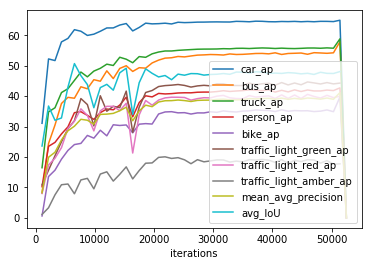

In [39]:
%matplotlib inline 
data.plot(x='iterations',y=['car_ap', 'bus_ap', 'truck_ap', 'person_ap', 'bike_ap','traffic_light_green_ap','traffic_light_red_ap','traffic_light_amber_ap', 'mean_avg_precision', 'avg_IoU'])
plt.show()

In [40]:
df = data.sort_values(by=['avg_IoU'], ascending = False)
df.head(20)

avg_IoU  bike_ap  bus_ap  car_ap  iterations  \
5     50.70    24.10   39.32   61.84        6564   
13    49.19    30.54   50.00   63.86       15316   
16    48.97    30.98   49.20   63.98       18598   
46    48.08    39.71   57.87   64.94       51418   
33    48.01    35.47   54.02   64.63       37196   
34    47.92    35.36   54.04   64.59       38290   
30    47.92    34.80   53.69   64.58       33914   
31    47.88    35.10   53.74   64.53       35008   
43    47.85    35.08   54.19   64.58       48136   
38    47.73    35.05   54.02   64.49       42666   
12    47.67    30.37   49.11   63.36       14222   
39    47.60    35.26   54.09   64.56       43760   
32    47.60    35.18   53.87   64.44       36102   
36    47.57    34.95   54.24   64.43       40478   
41    47.51    35.21   53.76   64.54       45948   
17    47.50    30.84   50.91   63.75       19692   
35    47.49    35.29   53.90   64.46       39384   
44    47.49    35.47   54.08   64.57       49230   
37    47.47    35.52   53.70   64.53       41572   
45    47.45    34.90   54.24   64.50       50324   

                                     map_results_file  mean_avg_precision  \
5   /media/dean/datastore1/datasets/darknet/darkne...               30.13   
13  /media/dean/datastore1/datasets/darknet/darkne...               36.37   
16  /media/dean/datastore1/datasets/darknet/darkne...               37.04   
46  /media/dean/datastore1/datasets/darknet/darkne...               41.17   
33  /media/dean/datastore1/datasets/darknet/darkne...               39.11   
34  /media/dean/datastore1/datasets/darknet/darkne...               39.22   
30  /media/dean/datastore1/datasets/darknet/darkne...               38.77   
31  /media/dean/datastore1/datasets/darknet/darkne...               38.83   
43  /media/dean/datastore1/datasets/darknet/darkne...               39.02   
38  /media/dean/datastore1/datasets/darknet/darkne...               38.95   
12  /media/dean/datastore1/datasets/darknet/darkne...               35.20   
39  /media/dean/datastore1/datasets/darknet/darkne...               39.28   
32  /media/dean/datastore1/datasets/darknet/darkne...               39.20   
36  /media/dean/datastore1/datasets/darknet/darkne...               38.97   
41  /media/dean/datastore1/datasets/darknet/darkne...               39.39   
17  /media/dean/datastore1/datasets/darknet/darkne...               36.55   
35  /media/dean/datastore1/datasets/darknet/darkne...               39.29   
44  /media/dean/datastore1/datasets/darknet/darkne...               39.39   
37  /media/dean/datastore1/datasets/darknet/darkne...               39.36   
45  /media/dean/datastore1/datasets/darknet/darkne...               38.97   

    motor_ap  person_ap  rider_ap total_detection_time  \
5      18.36      34.58     26.83                  NaN   
13     26.79      39.67     31.06                  NaN   
16     30.07      40.12     32.24                  NaN   
46     36.38      42.72     38.11  2294.000000 Seconds   
33     30.89      41.95     35.13                  NaN   
34     31.66      41.80     35.21                  NaN   
30     29.85      41.70     34.70                  NaN   
31     30.32      41.83     35.15                  NaN   
43     32.13      41.71     35.09                  NaN   
38     32.22      41.40     35.33                  NaN   
12     26.16      37.07     30.96                  NaN   
39     31.97      42.07     34.82                  NaN   
32     31.81      42.07     34.50                  NaN   
36     31.88      41.34     35.81                  NaN   
41     32.39      42.03     35.08                  NaN   
17     26.54      39.76     30.04                  NaN   
35     31.97      42.10     35.60                  NaN   
44     32.72      42.00     35.05                  NaN   
37     32.00      41.92     35.46                  NaN   
45     31.95      41.83     34.90                  NaN   

    traffic_light_amber_ap  traffic_light_ap  traffic_light_green_ap  \
5 

In [41]:
df = data.sort_values(by=['mean_avg_precision'], ascending = False)
df.head(10)

avg_IoU  bike_ap  bus_ap  car_ap  iterations  \
46    48.08    39.71   57.87   64.94       51418   
44    47.49    35.47   54.08   64.57       49230   
41    47.51    35.21   53.76   64.54       45948   
37    47.47    35.52   53.70   64.53       41572   
35    47.49    35.29   53.90   64.46       39384   
39    47.60    35.26   54.09   64.56       43760   
42    47.14    34.94   54.28   64.45       47042   
34    47.92    35.36   54.04   64.59       38290   
32    47.60    35.18   53.87   64.44       36102   
33    48.01    35.47   54.02   64.63       37196   

                                     map_results_file  mean_avg_precision  \
46  /media/dean/datastore1/datasets/darknet/darkne...               41.17   
44  /media/dean/datastore1/datasets/darknet/darkne...               39.39   
41  /media/dean/datastore1/datasets/darknet/darkne...               39.39   
37  /media/dean/datastore1/datasets/darknet/darkne...               39.36   
35  /media/dean/datastore1/datasets/darknet/darkne...               39.29   
39  /media/dean/datastore1/datasets/darknet/darkne...               39.28   
42  /media/dean/datastore1/datasets/darknet/darkne...               39.25   
34  /media/dean/datastore1/datasets/darknet/darkne...               39.22   
32  /media/dean/datastore1/datasets/darknet/darkne...               39.20   
33  /media/dean/datastore1/datasets/darknet/darkne...               39.11   

    motor_ap  person_ap  rider_ap total_detection_time  \
46     36.38      42.72     38.11  2294.000000 Seconds   
44     32.72      42.00     35.05                  NaN   
41     32.39      42.03     35.08                  NaN   
37     32.00      41.92     35.46                  NaN   
35     31.97      42.10     35.60                  NaN   
39     31.97      42.07     34.82                  NaN   
42     31.99      41.71     35.37                  NaN   
34     31.66      41.80     35.21                  NaN   
32     31.81      42.07     34.50                  NaN   
33     30.89      41.95     35.13                  NaN   

    traffic_light_amber_ap  traffic_light_ap  traffic_light_green_ap  \
46                   17.77             33.22                   44.29   
44                   18.82             32.46                   44.46   
41                   19.14             32.44                   44.67   
37                   19.15             32.33                   44.47   
35                   18.98             32.05                   44.26   
39                   18.95             32.32                   44.32   
42                   19.03             32.28                   44.35   
34                   19.20             31.99                   44.08   
32                   19.14             32.25                   44.28   
33                   19.01             31.94                   43.77   

    traffic_light_red_ap  traffic_sign_ap  train_ap training_run  truck_ap  
46                 39.97            56.87      4.55        run11     58.82  
44                 40.27            56.34      0.00        run11     55.86  
41                 40.59            56.41      0.00        run11     55.81  
37                 40.43            56.37      0.00        run11     55.77  
35                 40.09            56.26      0.00        run11     55.78  
39                 40.38            56.25      0.00        run11     55.63  
42                 39.90            56.07      0.00        run11     55.82  
34                 39.89            56.16      0.00        run11     55.84  
32                 40.19            56.29      0.00        run11     55.65  
33                 39.70            56.16      0.00        run11     55.76

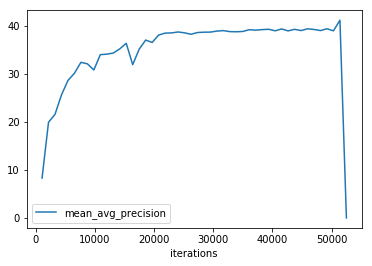

In [42]:
data.plot(x='iterations', y='mean_avg_precision')
plt.show()

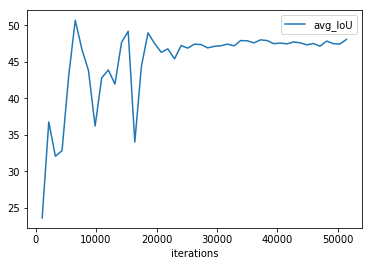

In [43]:
data.plot(x='iterations', y='avg_IoU')
plt.show()

In [23]:
CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'run5_2gpu_0005lr_128bat', 'yolov3-bdd100k_51418.weights')

VIDEOS_DIRECTORY = '/media/dean/datastore1/datasets/BerkeleyDeepDrive/bdd100k/videos/val'
video_files = glob.glob(os.path.join(VIDEOS_DIRECTORY, '*.mov'))
VIDEO_FILE = video_files[np.random.randint(0, len(video_files))]

TMP_FILE = os.path.splitext(VIDEO_FILE)[0]+'-rotated.mov'
FIXED_VIDEO_FILE = os.path.splitext(VIDEO_FILE)[0]+'-fixed.mov'
ANNOTATED_FILE = os.path.join('/home/dean/Desktop', os.path.splitext(VIDEO_FILE)[0]+'-annotated.mov')

if os.path.exists(FIXED_VIDEO_FILE):
    !cd $WORKING_DIRECTORY && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
else:
    !cd $WORKING_DIRECTORY && ffmpeg -i $VIDEO_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $TMP_FILE && ffmpeg -i  $TMP_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $FIXED_VIDEO_FILE && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
            

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

frame= 2407 fps=107 q=-1.0 Lsize=   10519kB time=00:00:40.12 bitrate=2147.6kbits/s    
video:10498kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.195656%
[libx264 @ 0x1ecef20] frame I:10    Avg QP:21.06  size: 51965
[libx264 @ 0x1ecef20] frame P:1448  Avg QP:23.20  size:  6395
[libx264 @ 0x1ecef20] frame B:949   Avg QP:25.53  size:  1022
[libx264 @ 0x1ecef20] consecutive B-frames: 47.4%  0.0%  0.2% 52.3%
[libx264 @ 0x1ecef20] mb I  I16..4: 11.9% 68.4% 19.8%
[libx264 @ 0x1ecef20] mb P  I16..4:  1.5%  2.7%  0.1%  P16..4: 31.4%  5.0%  2.4%  0.0%  0.0%    skip:56.9%
[libx264 @ 0x1ecef20] mb B  I16..4:  0.1%  0.1%  0.0%  B16..8: 24.8%  0.4%  0.1%  direct: 0.3%  skip:74.3%  L0:42.9% L1:56.5% BI: 0.6%
[libx264 @ 0x1ecef20] 8x8 transform intra:63.1% inter:80.6%
[libx264 @ 0x1ecef20] coded y,uvDC,uvAC intra: 32.6% 59.1% 3.8% inter: 6.1% 10.7% 0.5%
[libx264 @ 0x1ecef20] i16 v,h,dc,p: 23% 33% 25% 19%
[libx264 @ 0x1ecef20] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 17% 19% 50

In [30]:
CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs','run11', 'yolov3-bdd100k_51418.weights')
WORKING_DIRECTORY = '/media/dean/datastore1/datasets/darknet/darknet_evaluate/'
if os.path.exists(FIXED_VIDEO_FILE):
    !cd $WORKING_DIRECTORY && ./darknet detector demo cfg/bdd100knew.data ../trainers/20181111--Testing-4trafficlightcats_1gpu_001lr_64bat_16sd_1020ep_2sb/cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
else:
    !cd $WORKING_DIRECTORY && ffmpeg -i $VIDEO_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $TMP_FILE && ffmpeg -i  $TMP_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $FIXED_VIDEO_FILE && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
            

Demo
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
 


FPS:31.2
Objects:

traffic sign: 70% 
traffic sign: 69% 
traffic sign: 56% 
traffic sign: 46% 
traffic sign: 37% 
traffic light-red: 43% 
traffic light-red: 36% 
traffic light-green: 89% traffic light-red: 36% 
traffic light-green: 94% 
traffic light-green: 82% 
traffic light-green: 80% 
traffic light-green: 66% 
traffic light-green: 57% 
traffic light-green: 41% 
traffic light-green: 29% 
traffic light: 25% 
person: 74% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 94% 
car: 75% 
car: 72% 
car: 44% 
car: 34% 

FPS:33.1
Objects:

traffic sign: 75% 
traffic sign: 70% 
traffic sign: 52% 
traffic sign: 42% 
traffic sign: 40% 
traffic light-red: 42% 
traffic light-green: 88% traffic light-red: 35% 
traffic light-red: 32% 
traffic light-green: 94% 
traffic light-green: 84% 
traffic light-green: 80% 
traffic light-green: 72% 
traffic light-green: 56% 
traffic light-green: 38% 
traffic light-green: 26% 
traffic light: 34% 
person: 74% 
car: 100% 
car: 98% 
car: 98% 
car: 97% 
car: 86% 
car:


FPS:16.8
Objects:

traffic sign: 75% 
traffic sign: 71% 
traffic sign: 70% 
traffic sign: 34% 
traffic light-green: 93% 
traffic light-green: 89% 
traffic light-green: 84% 
traffic light-green: 81% 
traffic light-green: 73% 
traffic light-green: 41% 
traffic light-green: 28% 
person: 73% 
car: 100% 
car: 99% 
car: 97% 
car: 97% 
car: 87% 
car: 83% 
car: 75% 
car: 56% 
car: 38% 
car: 36% 

FPS:29.3
Objects:

traffic sign: 76% 
traffic sign: 70% 
traffic sign: 70% 
traffic sign: 35% 
traffic light-green: 93% 
traffic light-green: 90% 
traffic light-green: 84% 
traffic light-green: 81% 
traffic light-green: 74% 
traffic light-green: 42% 
traffic light-green: 28% 
person: 74% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 87% 
car: 83% 
car: 75% 
car: 56% 
car: 38% 
car: 36% 

FPS:33.1
Objects:

traffic sign: 78% 
traffic sign: 77% 
traffic sign: 72% 
traffic sign: 36% 
traffic light-green: 90% traffic light-red: 26% 
traffic light-green: 92% 
traffic light-green: 83% 
traffic light-green


FPS:30.6
Objects:

traffic sign: 85% 
traffic sign: 73% 
traffic sign: 71% 
traffic sign: 32% 
traffic light-green: 89% traffic light-red: 35% 
traffic light-green: 85% 
traffic light-green: 80% 
traffic light-green: 78% 
traffic light-green: 35% 
traffic light-green: 28% 
person: 73% 
car: 100% 
car: 99% 
car: 99% 
car: 83% 
car: 68% 
car: 67% 
car: 63% 
car: 40% 
car: 40% 
car: 31% 
car: 30% 
car: 28% 
car: 27% 

FPS:28.3
Objects:

traffic sign: 85% 
traffic sign: 73% 
traffic sign: 70% 
traffic sign: 32% 
traffic light-green: 89% traffic light-red: 35% 
traffic light-green: 85% 
traffic light-green: 79% 
traffic light-green: 78% 
traffic light-green: 35% 
traffic light-green: 27% 
person: 74% 
car: 100% 
car: 99% 
car: 99% 
car: 83% 
car: 68% 
car: 66% 
car: 63% 
car: 40% 
car: 39% 
car: 32% 
car: 32% 
car: 30% 
car: 27% 

FPS:35.1
Objects:

traffic sign: 85% 
traffic sign: 74% 
traffic sign: 73% 
traffic sign: 28% 
traffic light-green: 89% traffic light-red: 34% 
traffic light-gre


FPS:34.2
Objects:

traffic sign: 86% 
traffic sign: 77% 
traffic sign: 72% 
traffic sign: 33% 
traffic light-red: 36% 
traffic light-green: 91% 
traffic light-green: 85% 
traffic light-green: 81% 
traffic light-green: 67% 
traffic light-green: 32% 
traffic light-green: 26% 
traffic light: 39% 
person: 71% 
car: 100% 
car: 99% 
car: 92% 
car: 91% 
car: 84% 
car: 66% 
car: 65% 
car: 60% 
car: 33% 

FPS:33.7
Objects:

traffic sign: 85% 
traffic sign: 74% 
traffic sign: 72% 
traffic sign: 35% 
traffic light-red: 40% 
traffic light-green: 90% 
traffic light-green: 85% 
traffic light-green: 81% 
traffic light-green: 69% 
traffic light-green: 33% 
traffic light-green: 29% 
traffic light: 44% 
person: 72% 
car: 100% 
car: 100% 
car: 96% 
car: 91% 
car: 83% 
car: 65% 
car: 63% 
car: 56% 
car: 32% 

FPS:33.1
Objects:

traffic sign: 85% 
traffic sign: 75% 
traffic sign: 72% 
traffic sign: 30% 
traffic light-red: 40% 
traffic light-red: 26% 
traffic light-green: 90% 
traffic light-green: 84% 
tra


FPS:35.7
Objects:

traffic sign: 84% 
traffic sign: 75% 
traffic light-red: 26% traffic sign: 49% 
traffic sign: 41% 
traffic light-red: 64% 
traffic light-red: 38% 
traffic light-green: 87% 
traffic light-green: 85% 
traffic light-green: 81% 
traffic light-green: 70% 
traffic light-green: 41% 
traffic light-green: 27% 
person: 74% 
car: 100% 
car: 100% 
car: 100% 
car: 93% 
car: 78% 
car: 78% 
car: 67% 
car: 40% 
car: 31% 
car: 29% 

FPS:36.9
Objects:

traffic sign: 80% 
traffic sign: 73% 
traffic sign: 37% 
traffic light-red: 50% traffic sign: 27% 
traffic sign: 25% 
traffic light-red: 62% 
traffic light-green: 92% 
traffic light-green: 84% 
traffic light-green: 80% 
traffic light-green: 69% 
traffic light-green: 48% 
traffic light-green: 42% 
traffic light-green: 31% 
person: 74% 
car: 100% 
car: 100% 
car: 100% 
car: 90% 
car: 79% 
car: 78% 
car: 66% 
car: 36% 
car: 32% 
car: 30% 

FPS:29.2
Objects:

traffic sign: 80% 
traffic sign: 73% 
traffic sign: 37% 
traffic light-red: 50% t


FPS:31.9
Objects:

traffic sign: 74% 
traffic sign: 74% 
traffic sign: 69% 
traffic sign: 35% 
traffic sign: 34% 
traffic sign: 28% 
traffic light-red: 60% 
traffic light-red: 45% 
traffic light-green: 90% traffic light-red: 35% 
traffic light-green: 94% 
traffic light-green: 84% 
traffic light-green: 80% 
traffic light-green: 68% 
traffic light-green: 37% 
person: 78% 
car: 100% 
car: 100% 
car: 100% 
car: 92% 
car: 86% 
car: 83% 
car: 69% 
car: 39% 
car: 31% 
car: 28% 
car: 26% 

FPS:28.1
Objects:

traffic sign: 74% 
traffic sign: 72% 
traffic sign: 69% 
traffic sign: 37% 
traffic sign: 32% 
traffic light-red: 59% 
traffic light-red: 45% 
traffic light-green: 90% traffic light-red: 35% 
traffic light-green: 94% 
traffic light-green: 84% 
traffic light-green: 82% 
traffic light-green: 69% 
traffic light-green: 38% 
person: 78% 
car: 100% 
car: 100% 
car: 100% 
car: 88% 
car: 84% 
car: 82% 
car: 69% 
car: 54% 
car: 37% 
car: 31% 
car: 31% 
car: 25% 

FPS:35.8
Objects:

traffic sign: 7


FPS:32.9
Objects:

traffic sign: 72% 
traffic sign: 67% 
traffic sign: 48% 
traffic sign: 46% 
traffic sign: 31% 
traffic light-red: 46% 
traffic light-red: 42% 
traffic light-green: 88% traffic light-red: 40% 
traffic light-green: 93% 
traffic light-green: 82% 
traffic light-green: 81% 
traffic light-green: 63% 
traffic light-green: 32% 
person: 73% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 82% 
car: 81% 
car: 70% 
car: 61% 
car: 33% 
car: 32% 
car: 29% 

FPS:33.5
Objects:

traffic sign: 72% 
traffic sign: 68% 
traffic sign: 50% 
traffic sign: 47% 
traffic sign: 31% 
traffic light-red: 46% 
traffic light-red: 43% 
traffic light-green: 88% traffic light-red: 41% 
traffic light-green: 93% 
traffic light-green: 82% 
traffic light-green: 81% 
traffic light-green: 63% 
traffic light-green: 32% 
person: 73% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 82% 
car: 81% 
car: 70% 
car: 61% 
car: 33% 
car: 31% 
car: 29% 

FPS:33.6
Objects:

traffic sign: 72% 
traffic sign: 66% 
traffic si


FPS:33.7
Objects:

traffic sign: 69% 
traffic sign: 60% 
traffic sign: 51% 
traffic sign: 50% 
traffic light-green: 87% traffic light-red: 40% 
traffic light-green: 82% 
traffic light-green: 81% 
traffic light-green: 64% 
traffic light-green: 34% 
person: 76% 
car: 100% 
car: 100% 
car: 98% 
car: 69% 
car: 65% 
car: 59% 
car: 51% 
car: 43% 
car: 42% 
car: 30% 
car: 29% 
car: 28% 
car: 27% 

FPS:33.5
Objects:

traffic sign: 79% 
traffic sign: 72% 
traffic sign: 55% 
traffic sign: 52% 
traffic sign: 42% 
traffic light-green: 90% traffic light-red: 34% 
traffic light-green: 83% 
traffic light-green: 82% 
traffic light-green: 69% 
traffic light-green: 37% 
person: 75% 
car: 100% 
car: 100% 
car: 99% 
car: 68% 
car: 64% 
car: 51% 
car: 50% 
car: 49% 
car: 48% 
car: 32% 
car: 27% 
car: 27% 

FPS:32.2
Objects:

traffic sign: 78% 
traffic sign: 73% 
traffic sign: 54% 
traffic sign: 52% 
traffic sign: 41% 
traffic light-green: 90% traffic light-red: 33% 
traffic light-green: 83% 
traffic light


FPS:34.0
Objects:

traffic sign: 89% 
traffic sign: 53% 
traffic sign: 49% 
traffic light-green: 89% traffic light-red: 28% 
traffic light-red: 27% 
traffic light-green: 87% 
traffic light-green: 85% 
traffic light-green: 73% 
traffic light-green: 33% 
person: 86% 
car: 100% 
car: 100% 
car: 98% 
car: 75% 
car: 68% 
car: 57% 
car: 51% 
car: 47% 
car: 33% 
car: 29% 
car: 25% 

FPS:34.7
Objects:

traffic sign: 89% 
traffic sign: 54% 
traffic sign: 48% 
traffic light-green: 89% traffic light-red: 27% 
traffic light-red: 27% 
traffic light-green: 86% 
traffic light-green: 85% 
traffic light-green: 73% 
traffic light-green: 33% 
person: 87% 
car: 100% 
car: 100% 
car: 98% 
car: 75% 
car: 67% 
car: 57% 
car: 50% 
car: 47% 
car: 33% 
car: 29% 
car: 26% 

FPS:34.4
Objects:

traffic sign: 89% 
traffic sign: 48% 
traffic sign: 46% 
traffic light-red: 31% 
traffic light-green: 89% traffic light-red: 28% 
traffic light-green: 86% 
traffic light-green: 85% 
traffic light-green: 70% 
traffic light-


FPS:33.4
Objects:

traffic sign: 73% 
traffic sign: 67% 
traffic sign: 40% 
traffic sign: 29% 
traffic light-red: 38% 
traffic light-red: 30% 
traffic light: 31% traffic light-red: 26% 
traffic light-green: 91% 
traffic light-green: 87% 
traffic light-green: 85% 
traffic light-green: 62% 
traffic light-green: 37% 
person: 88% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 64% 
car: 58% 
car: 56% 
car: 37% 

FPS:33.5
Objects:

traffic sign: 74% 
traffic sign: 64% 
traffic sign: 38% 
traffic sign: 31% 
traffic sign: 28% 
traffic light-red: 41% 
traffic light-red: 32% 
traffic light: 28% traffic light-red: 32% 
traffic light-green: 91% 
traffic light-green: 87% 
traffic light-green: 86% 
traffic light-green: 62% 
traffic light-green: 35% 
traffic light-green: 34% 
traffic light-green: 27% 
person: 87% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 64% 
car: 57% 
car: 57% 
car: 34% 
car: 25% 

FPS:33.2
Objects:

traffic sign: 74% 
traffic sign: 63% 
traffic sign: 40% 
traffic sign: 31% 


FPS:33.2
Objects:

traffic sign: 78% 
traffic sign: 71% 
traffic sign: 56% 
traffic sign: 37% 
traffic light-red: 50% 
traffic light-red: 42% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 89% 
traffic light-green: 88% 
traffic light-green: 70% 
traffic light-green: 34% 
traffic light: 43% 
person: 91% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 54% 
car: 48% 
car: 46% 
car: 41% 
car: 39% 

FPS:33.1
Objects:

traffic sign: 77% 
traffic sign: 73% 
traffic sign: 58% 
traffic sign: 42% 
traffic light-red: 51% 
traffic light-red: 43% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 90% 
traffic light-green: 90% 
traffic light-green: 69% 
traffic light-green: 33% 
traffic light: 55% 
person: 90% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 61% 
car: 53% 
car: 44% 
car: 37% 
car: 30% 

FPS:25.2
Objects:

traffic sign: 77% 
traffic sign: 73% 
traffic sign: 58% 
traffic sign: 42% 
traffic light-red: 49% 
traffic light-red: 42% 
traf


FPS:30.0
Objects:

traffic sign: 84% 
traffic sign: 82% 
traffic sign: 74% 
traffic sign: 35% 
traffic light-red: 46% 
traffic light-red: 25% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 87% 
traffic light-green: 71% 
traffic light-green: 32% 
traffic light: 26% 
person: 90% 
car: 100% 
car: 100% 
car: 100% 
car: 95% 
car: 52% 
car: 49% 
car: 48% 
car: 46% 
car: 46% 
car: 44% 

FPS:33.1
Objects:

traffic sign: 84% 
traffic sign: 84% 
traffic sign: 74% 
traffic sign: 35% 
traffic light-red: 47% 
traffic light-green: 92% 
traffic light-green: 92% 
traffic light-green: 90% 
traffic light-green: 88% 
traffic light-green: 71% 
traffic light-green: 32% 
traffic light: 27% 
person: 90% 
car: 100% 
car: 100% 
car: 100% 
car: 95% 
car: 52% 
car: 49% 
car: 48% 
car: 46% 
car: 45% 
car: 44% 

FPS:32.1
Objects:

traffic sign: 87% 
traffic sign: 85% 
traffic sign: 73% 
traffic sign: 32% 
traffic light-red: 45% 
traffic light-red: 28% 
traffic 


FPS:36.0
Objects:

traffic sign: 87% 
traffic sign: 77% 
traffic sign: 71% 
traffic sign: 65% 
traffic sign: 35% 
traffic light-red: 36% 
traffic light-red: 35% 
traffic light-red: 29% 
traffic light-green: 92% 
traffic light-green: 92% 
traffic light-green: 90% 
traffic light-green: 86% 
traffic light-green: 68% 
traffic light-green: 47% 
person: 85% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 69% 
car: 60% 
car: 54% 
car: 49% 
car: 47% 
car: 32% 
car: 29% 
car: 26% 

FPS:35.9
Objects:

traffic sign: 87% 
traffic sign: 77% 
traffic sign: 71% 
traffic sign: 65% 
traffic sign: 36% 
traffic light-red: 36% 
traffic light-red: 36% 
traffic light-red: 30% 
traffic light-green: 93% 
traffic light-green: 92% 
traffic light-green: 90% 
traffic light-green: 87% 
traffic light-green: 68% 
traffic light-green: 47% 
person: 84% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 70% 
car: 60% 
car: 53% 
car: 47% 
car: 47% 
car: 32% 
car: 28% 
car: 26% 

FPS:32.5
Objects:

traffic sign: 87% 
traff

car: 37% 

FPS:35.9
Objects:

traffic sign: 86% 
traffic sign: 85% 
traffic sign: 64% 
traffic sign: 57% 
traffic sign: 31% 
traffic sign: 29% 
traffic light-red: 41% 
traffic light-red: 30% 
traffic light-green: 93% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 87% 
traffic light-green: 72% 
traffic light-green: 39% 
traffic light: 27% 
person: 83% 
car: 100% 
car: 99% 
car: 96% 
car: 93% 
car: 58% 
car: 58% 
car: 49% 
car: 41% 
car: 41% 
car: 35% 

FPS:33.9
Objects:

traffic sign: 86% 
traffic sign: 85% 
traffic sign: 64% 
traffic sign: 57% 
traffic sign: 31% 
traffic sign: 29% 
traffic light-red: 42% 
traffic light-red: 30% 
traffic light-green: 93% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 87% 
traffic light-green: 72% 
traffic light-green: 38% 
traffic light: 27% 
person: 83% 
car: 100% 
car: 99% 
car: 96% 
car: 93% 
car: 58% 
car: 58% 
car: 49% 
car: 41% 
car: 41% 
car: 35% 

FPS:35.7
Objects:

traffic sign: 86% 
traffic


FPS:33.0
Objects:

traffic sign: 83% 
traffic sign: 82% 
traffic sign: 66% 
traffic sign: 60% 
traffic light-red: 37% 
traffic light: 34% traffic light-red: 27% 
traffic light-red: 26% 
traffic light-red: 25% 
traffic light-green: 93% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 87% 
traffic light-green: 75% 
traffic light-green: 34% 
person: 81% 
car: 100% 
car: 99% 
car: 97% 
car: 78% 
car: 61% 
car: 61% 
car: 43% 
car: 41% 
car: 40% 

FPS:32.4
Objects:

traffic sign: 84% 
traffic sign: 79% 
traffic sign: 68% 
traffic sign: 62% 
traffic light-red: 39% 
traffic light: 38% traffic light-red: 27% 
traffic light-red: 25% 
traffic light-green: 93% 
traffic light-green: 92% 
traffic light-green: 90% 
traffic light-green: 87% 
traffic light-green: 77% 
traffic light-green: 36% 
person: 80% 
car: 100% 
car: 99% 
car: 96% 
car: 76% 
car: 71% 
car: 60% 
car: 43% 
car: 41% 
car: 37% 

FPS:27.0
Objects:

traffic sign: 84% 
traffic sign: 79% 
traffic sign: 68% 
traff


FPS:32.4
Objects:

traffic sign: 87% 
traffic sign: 78% 
traffic sign: 78% 
traffic sign: 68% 
traffic light-red: 44% 
traffic light-red: 39% 
traffic light-red: 37% 
traffic light-green: 93% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 87% 
traffic light-green: 71% 
traffic light-green: 41% 
person: 83% 
car: 100% 
car: 99% 
car: 95% 
car: 76% 
car: 65% 
car: 53% 
car: 41% 
car: 26% 
car: 25% 

FPS:29.0
Objects:

traffic sign: 83% 
traffic sign: 79% 
traffic sign: 76% 
traffic sign: 68% 
traffic light-red: 46% 
traffic light-red: 39% 
traffic light-red: 35% 
traffic light-green: 93% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 86% 
traffic light-green: 70% 
traffic light-green: 43% 
person: 81% 
car: 100% 
car: 99% 
car: 92% 
car: 67% 
car: 66% 
car: 53% 
car: 37% 
car: 27% 
car: 27% 

FPS:26.8
Objects:

traffic sign: 83% 
traffic sign: 79% 
traffic sign: 74% 
traffic sign: 69% 
traffic light-red: 45% 
traffic light-red: 38% 



FPS:33.6
Objects:

traffic sign: 83% 
traffic sign: 81% 
traffic sign: 70% 
traffic sign: 69% 
traffic sign: 32% 
traffic light-red: 42% 
traffic light-red: 40% 
traffic light-red: 38% 
traffic light-green: 94% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 88% 
traffic light-green: 77% 
traffic light-green: 39% 
person: 89% 
car: 100% 
car: 99% 
car: 85% 
car: 82% 
car: 69% 
car: 63% 
car: 57% 
car: 32% 
car: 26% 
car: 25% 

FPS:33.3
Objects:

traffic sign: 82% 
traffic sign: 79% 
traffic sign: 71% 
traffic sign: 67% 
traffic sign: 35% 
traffic light-red: 42% 
traffic light-red: 42% 
traffic light-red: 41% 
traffic light-red: 26% 
traffic light-green: 94% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 88% 
traffic light-green: 76% 
traffic light-green: 39% 
person: 89% 
car: 100% 
car: 99% 
car: 75% 
car: 63% 
car: 63% 
car: 57% 
car: 55% 
car: 31% 
car: 27% 

FPS:33.1
Objects:

traffic sign: 82% 
traffic sign: 79% 
traffic sign: 


FPS:33.7
Objects:

traffic sign: 85% 
traffic sign: 74% 
traffic sign: 52% 
traffic sign: 29% 
traffic light-red: 46% 
traffic light-red: 42% 
traffic light-red: 40% 
traffic light-green: 93% 
traffic light-green: 93% 
traffic light-green: 89% 
traffic light-green: 88% 
traffic light-green: 76% 
traffic light-green: 33% 
traffic light-green: 32% 
person: 86% 
car: 100% 
car: 98% 
car: 97% 
car: 96% 
car: 71% 
car: 69% 
car: 54% 
car: 52% 
car: 30% 
car: 29% 
car: 26% 

FPS:31.8
Objects:

traffic sign: 86% 
traffic sign: 83% 
traffic sign: 51% 
traffic light-red: 40% 
traffic light-red: 38% 
traffic light-red: 35% 
traffic light-green: 94% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 70% 
traffic light-green: 37% 
person: 89% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 82% 
car: 51% 
car: 42% 
car: 42% 
car: 41% 
car: 31% 

FPS:33.8
Objects:

traffic sign: 86% 
traffic sign: 83% 
traffic sign: 51% 
traffic light-red: 40% 
traffi


FPS:36.1
Objects:

traffic sign: 84% 
traffic sign: 59% 
traffic sign: 36% 
traffic sign: 30% 
traffic light-red: 57% 
traffic light-red: 50% 
traffic light-red: 42% 
traffic light-red: 29% 
traffic light-red: 29% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 82% 
traffic light-green: 67% 
traffic light-green: 32% 
person: 84% 
car: 100% 
car: 99% 
car: 97% 
car: 93% 
car: 90% 
car: 74% 
car: 54% 
car: 53% 
car: 43% 
car: 41% 
car: 40% 
car: 33% 
car: 32% 

FPS:36.5
Objects:

traffic sign: 84% 
traffic sign: 60% 
traffic sign: 33% 
traffic sign: 30% 
traffic light-red: 56% 
traffic light-red: 50% 
traffic light-red: 41% 
traffic light-red: 30% 
traffic light-red: 29% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 82% 
traffic light-green: 66% 
traffic light-green: 31% 
person: 84% 
car: 100% 
car: 99% 
car: 97% 
car: 93% 
car: 90% 
car: 74% 
car: 54% 
car: 53% 
car: 43% 
car: 41%


FPS:33.3
Objects:

traffic sign: 88% 
traffic sign: 58% 
traffic sign: 53% 
traffic sign: 36% 
traffic light-red: 53% 
traffic light-red: 42% 
traffic light-red: 41% 
traffic light-green: 92% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 82% 
traffic light-green: 61% 
traffic light-green: 31% 
traffic light-green: 31% 
traffic light-green: 29% 
traffic light-green: 28% 
person: 68% 
car: 100% 
car: 99% 
car: 92% 
car: 87% 
car: 68% 
car: 63% 
car: 56% 
car: 47% 
car: 40% 
car: 38% 
car: 32% 
car: 30% 
car: 28% 

FPS:32.9
Objects:

traffic sign: 88% 
traffic sign: 58% 
traffic sign: 53% 
traffic sign: 36% 
traffic light-red: 54% 
traffic light-red: 43% 
traffic light-red: 42% 
traffic light-green: 92% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 82% 
traffic light-green: 61% 
traffic light-green: 31% 
traffic light-green: 31% 
traffic light-green: 29% 
traffic light-green: 27% 
person: 68% 
car: 100% 
car: 99% 
car: 91% 
car: 87%

person: 82% 
car: 100% 
car: 100% 
car: 96% 
car: 89% 
car: 80% 
car: 58% 
car: 53% 
car: 53% 
car: 35% 

FPS:30.0
Objects:

traffic sign: 80% 
traffic sign: 70% 
traffic sign: 35% 
traffic light-green: 70% traffic light-red: 33% 
traffic light-red: 27% 
traffic light-red: 26% 
traffic light-green: 91% 
traffic light-green: 91% 
traffic light-green: 63% 
traffic light-green: 41% 
traffic light-green: 27% 
person: 86% 
car: 100% 
car: 100% 
car: 93% 
car: 76% 
car: 73% 
car: 57% 
car: 52% 
car: 52% 
car: 37% 

FPS:33.0
Objects:

traffic sign: 80% 
traffic sign: 71% 
traffic sign: 35% 
traffic light-green: 69% traffic light-red: 33% 
traffic light-red: 28% 
traffic light-red: 26% 
traffic light-green: 91% 
traffic light-green: 91% 
traffic light-green: 64% 
traffic light-green: 41% 
traffic light-green: 26% 
person: 86% 
car: 100% 
car: 100% 
car: 93% 
car: 76% 
car: 73% 
car: 57% 
car: 52% 
car: 52% 
car: 37% 

FPS:33.5
Objects:

traffic sign: 73% 
traffic sign: 66% 
traffic sign: 43% 



FPS:33.9
Objects:

traffic sign: 80% 
traffic sign: 61% 
traffic sign: 51% 
traffic sign: 41% 
traffic light-red: 59% 
traffic light-red: 53% 
traffic light-red: 50% 
traffic light-red: 39% 
traffic light-green: 95% 
traffic light-green: 87% 
traffic light-green: 82% 
traffic light-green: 74% 
traffic light-green: 28% 
traffic light-green: 27% 
person: 59% 
car: 100% 
car: 100% 
car: 90% 
car: 90% 
car: 79% 
car: 70% 
car: 61% 
car: 56% 
car: 45% 
car: 43% 
car: 36% 
car: 35% 
car: 34% 
car: 27% 

FPS:29.1
Objects:

traffic sign: 79% 
traffic sign: 79% 
traffic sign: 77% 
traffic sign: 36% 
traffic light-red: 63% 
traffic light-red: 47% 
traffic light-red: 47% 
traffic light-red: 30% 
traffic light-green: 95% 
traffic light-green: 86% 
traffic light-green: 82% 
traffic light-green: 54% 
traffic light-green: 31% 
traffic light-green: 28% 
traffic light-green: 27% 
person: 50% 
car: 100% 
car: 99% 
car: 90% 
car: 79% 
car: 76% 
car: 69% 
car: 50% 
car: 49% 
car: 48% 
car: 34% 
car: 29% 


FPS:28.9
Objects:

traffic sign: 88% 
traffic sign: 62% 
traffic sign: 51% 
traffic sign: 30% 
traffic light-red: 57% 
traffic light-green: 47% traffic light-red: 44% 
traffic light-red: 44% 
traffic light-red: 42% 
traffic light-red: 27% 
traffic light-green: 94% 
traffic light-green: 68% 
traffic light-green: 59% 
traffic light-green: 53% 
traffic light-green: 40% 
traffic light-green: 37% 
traffic light-green: 29% 
person: 77% 
car: 100% 
car: 100% 
car: 77% 
car: 74% 
car: 72% 
car: 57% 
car: 50% 
car: 49% 
car: 47% 
car: 45% 
car: 27% 

FPS:29.1
Objects:

traffic sign: 88% 
traffic sign: 62% 
traffic sign: 51% 
traffic sign: 32% 
traffic light-red: 57% 
traffic light-green: 47% traffic light-red: 44% 
traffic light-red: 44% 
traffic light-red: 42% 
traffic light-red: 28% 
traffic light-green: 94% 
traffic light-green: 69% 
traffic light-green: 59% 
traffic light-green: 53% 
traffic light-green: 40% 
traffic light-green: 37% 
traffic light-green: 29% 
person: 77% 
car: 100% 
car: 

traffic sign: 83% 
traffic sign: 36% 
traffic sign: 29% 
traffic light-red: 59% 
traffic light-red: 47% 
traffic light-red: 44% 
traffic light-red: 43% 
traffic light-red: 38% 
traffic light-green: 95% 
traffic light-green: 79% 
traffic light-green: 60% 
traffic light-green: 56% 
traffic light-green: 54% 
traffic light-green: 41% 
person: 62% 
car: 100% 
car: 100% 
car: 94% 
car: 85% 
car: 67% 
car: 61% 
car: 49% 
car: 42% 

FPS:31.6
Objects:

traffic sign: 90% 
traffic sign: 86% 
traffic sign: 50% 
traffic light-red: 52% 
traffic light-red: 46% 
traffic light-red: 46% 
traffic light-red: 44% 
traffic light-red: 41% 
traffic light-red: 28% 
traffic light-green: 95% 
traffic light-green: 80% 
traffic light-green: 65% 
traffic light-green: 59% 
traffic light-green: 27% 
person: 42% 
car: 100% 
car: 100% 
car: 92% 
car: 81% 
car: 71% 
car: 63% 
car: 56% 
car: 33% 

FPS:32.7
Objects:

traffic sign: 90% 
traffic sign: 86% 
traffic sign: 50% 
traffic light-red: 52% 
traffic light-red: 46% 
t


FPS:33.7
Objects:

traffic sign: 81% 
traffic sign: 63% 
traffic sign: 26% 
traffic light-red: 69% 
traffic light-red: 59% 
traffic light-red: 39% 
traffic light-red: 38% 
traffic light-red: 33% 
traffic light-green: 95% 
traffic light-green: 76% 
traffic light-green: 76% 
traffic light-green: 73% 
traffic light-green: 42% 
traffic light-green: 29% 
traffic light-green: 27% 
car: 100% 
car: 100% 
car: 88% 
car: 76% 
car: 69% 
car: 51% 
car: 40% 
car: 26% 

FPS:26.3
Objects:

traffic sign: 87% 
traffic sign: 77% 
traffic sign: 63% 
traffic sign: 50% 
traffic light-red: 41% traffic sign: 31% 
traffic light-red: 73% 
traffic light-red: 54% 
traffic light-red: 39% 
traffic light-red: 33% 
traffic light-green: 95% 
traffic light-green: 79% 
traffic light-green: 61% 
traffic light-green: 60% 
traffic light-green: 45% 
car: 100% 
car: 100% 
car: 80% 
car: 71% 
car: 49% 
car: 46% 
car: 36% 

FPS:33.6
Objects:

traffic sign: 87% 
traffic sign: 77% 
traffic sign: 59% 
traffic sign: 49% 
traffic

car: 67% 
car: 59% 
car: 39% 
car: 32% 
car: 28% 

FPS:33.2
Objects:

traffic sign: 90% 
traffic sign: 80% 
traffic sign: 63% 
traffic sign: 58% 
traffic light-red: 71% 
traffic light-red: 64% 
traffic light-red: 40% 
traffic light-red: 26% 
traffic light-green: 95% 
traffic light-green: 88% 
traffic light-green: 75% 
traffic light-green: 59% 
traffic light-green: 44% 
car: 100% 
car: 99% 
car: 68% 
car: 67% 
car: 60% 
car: 39% 
car: 31% 
car: 28% 

FPS:33.3
Objects:

traffic sign: 84% 
traffic sign: 83% 
traffic sign: 79% 
traffic sign: 60% 
traffic light-red: 73% 
traffic light-red: 54% 
traffic light-red: 40% 
traffic light-red: 31% 
traffic light-green: 86% traffic light-red: 27% 
traffic light-green: 89% 
traffic light-green: 87% 
traffic light-green: 48% 
traffic light-green: 44% 
traffic light-green: 33% 
car: 100% 
car: 99% 
car: 79% 
car: 71% 
car: 70% 
car: 48% 
car: 33% 
car: 27% 

FPS:34.1
Objects:

traffic sign: 84% 
traffic sign: 83% 
traffic sign: 79% 
traffic sign: 61% 


FPS:30.8
Objects:

traffic sign: 82% 
traffic sign: 68% 
traffic sign: 50% 
traffic light-red: 71% 
traffic light-red: 49% 
traffic light-red: 37% 
traffic light-green: 92% 
traffic light-green: 82% 
traffic light-green: 81% 
traffic light-green: 69% 
traffic light-green: 41% 
traffic light-green: 40% 
car: 100% 
car: 97% 
car: 84% 
car: 66% 
car: 66% 
car: 55% 
car: 42% 
car: 32% 
car: 25% 

FPS:33.9
Objects:

traffic sign: 81% 
traffic sign: 80% 
traffic sign: 56% 
traffic sign: 28% 
traffic light-red: 62% 
traffic light-red: 60% 
traffic light-green: 77% traffic light-red: 27% 
traffic light-green: 92% 
traffic light-green: 90% 
traffic light-green: 75% 
traffic light-green: 46% 
traffic light-green: 27% 
car: 100% 
car: 96% 
car: 96% 
car: 74% 
car: 61% 
car: 56% 
car: 42% 
car: 27% 
car: 26% 

FPS:33.4
Objects:

traffic sign: 82% 
traffic sign: 63% 
traffic sign: 63% 
traffic sign: 32% 
traffic light-red: 66% 
traffic light-red: 53% 
traffic light-red: 30% 
traffic light-green: 7


FPS:29.8
Objects:

traffic sign: 86% 
traffic sign: 85% 
traffic sign: 77% 
traffic sign: 76% 
traffic sign: 27% 
traffic light-red: 64% 
traffic light-red: 59% 
traffic light-red: 55% 
traffic light-green: 80% traffic light-red: 47% 
traffic light-green: 95% 
traffic light-green: 90% 
traffic light-green: 49% 
traffic light-green: 45% 
traffic light-green: 32% 
person: 44% 
person: 32% 
person: 29% 
car: 100% 
car: 98% 
car: 93% 
car: 81% 
car: 80% 
car: 64% 
car: 42% 
car: 25% 

FPS:30.0
Objects:

traffic sign: 85% 
traffic sign: 82% 
traffic sign: 79% 
traffic sign: 79% 
traffic light-red: 64% 
traffic light-red: 63% 
traffic light-red: 39% 
traffic light-green: 87% traffic light-red: 35% 
traffic light-green: 95% 
traffic light-green: 91% 
traffic light-green: 64% 
traffic light-green: 56% 
traffic light-green: 27% 
person: 25% 
car: 100% 
car: 99% 
car: 89% 
car: 82% 
car: 72% 
car: 69% 
car: 62% 
car: 56% 
car: 46% 

FPS:26.7
Objects:

traffic sign: 85% 
traffic sign: 82% 
traff


FPS:31.9
Objects:

traffic sign: 93% 
traffic sign: 92% 
traffic sign: 89% 
traffic sign: 89% 
traffic sign: 47% 
traffic light-red: 50% 
traffic light-red: 48% 
traffic light-red: 31% 
traffic light-green: 86% traffic light-red: 27% 
traffic light-green: 95% 
traffic light-green: 94% 
traffic light-green: 75% 
traffic light-green: 70% 
traffic light-green: 28% 
traffic light-green: 27% 
traffic light: 36% 
person: 34% 
person: 33% 
person: 29% 
car: 100% 
car: 99% 
car: 88% 
car: 88% 
car: 87% 
car: 77% 
car: 76% 
car: 49% 
car: 39% 
car: 30% 

FPS:28.1
Objects:

traffic sign: 93% 
traffic sign: 92% 
traffic sign: 89% 
traffic sign: 89% 
traffic sign: 47% 
traffic light-red: 50% 
traffic light-red: 48% 
traffic light-red: 31% 
traffic light-green: 86% traffic light-red: 26% 
traffic light-green: 95% 
traffic light-green: 94% 
traffic light-green: 75% 
traffic light-green: 70% 
traffic light-green: 27% 
traffic light-green: 27% 
traffic light: 36% 
person: 35% 
person: 35% 
person: 34


FPS:35.3
Objects:

traffic sign: 91% 
traffic sign: 90% 
traffic sign: 90% 
traffic sign: 77% 
traffic sign: 32% 
traffic light-red: 71% 
traffic light-red: 36% 
traffic light-red: 33% 
traffic light-green: 31% traffic light-red: 30% 
traffic light-green: 95% 
traffic light-green: 90% 
traffic light-green: 80% 
traffic light-green: 74% 
traffic light-green: 64% 
traffic light-green: 51% 
traffic light-green: 35% 
traffic light-green: 33% 
person: 50% 
car: 99% 
car: 98% 
car: 97% 
car: 96% 
car: 94% 
car: 81% 
car: 71% 
car: 62% 
car: 26% 

FPS:28.4
Objects:

traffic sign: 92% 
traffic sign: 90% 
traffic sign: 77% 
traffic sign: 66% 
traffic sign: 30% 
traffic light-red: 71% 
traffic light-red: 49% 
traffic light-green: 36% traffic light-red: 42% 
traffic light-red: 33% 
traffic light-red: 33% 
traffic light-red: 28% 
traffic light-green: 96% 
traffic light-green: 89% 
traffic light-green: 75% 
traffic light-green: 70% 
traffic light-green: 55% 
traffic light-green: 45% 
traffic light

traffic sign: 44% 
traffic light-red: 59% 
traffic light-red: 52% 
traffic light-red: 47% 
traffic light-red: 43% 
traffic light-red: 32% 
traffic light-red: 28% 
traffic light-green: 96% 
traffic light-green: 87% 
traffic light-green: 80% 
traffic light-green: 64% 
traffic light-green: 58% 
traffic light-green: 39% 
traffic light-green: 35% 
traffic light-green: 31% 
person: 30% 
car: 99% 
car: 95% 
car: 91% 
car: 90% 
car: 77% 
car: 73% 
car: 71% 
car: 62% 
car: 47% 
car: 38% 
car: 34% 

FPS:33.0
Objects:

traffic sign: 97% 
traffic sign: 93% 
traffic sign: 92% 
traffic sign: 70% 
traffic sign: 52% 
traffic sign: 42% 
traffic light-red: 57% 
traffic light-red: 54% 
traffic light-red: 47% 
traffic light-red: 44% 
traffic light-red: 33% 
traffic light-green: 96% 
traffic light-green: 84% 
traffic light-green: 82% 
traffic light-green: 63% 
traffic light-green: 52% 
traffic light-green: 49% 
traffic light-green: 46% 
traffic light-green: 38% 
person: 41% 
car: 99% 
car: 96% 
car: 94% 
c


FPS:32.6
Objects:

traffic sign: 94% 
traffic sign: 93% 
traffic sign: 92% 
traffic sign: 51% 
traffic light-red: 57% 
traffic light-red: 56% 
traffic light-red: 50% 
traffic light-red: 37% 
traffic light-green: 94% 
traffic light-green: 89% 
traffic light-green: 87% 
traffic light-green: 76% 
traffic light-green: 58% 
traffic light-green: 52% 
traffic light-green: 29% 
traffic light-green: 29% 
traffic light-green: 27% 
traffic light: 34% 
car: 99% 
car: 99% 
car: 98% 
car: 94% 
car: 92% 
car: 76% 
car: 62% 
car: 61% 
car: 49% 
car: 47% 
car: 44% 
car: 32% 

FPS:29.5
Objects:

traffic sign: 94% 
traffic sign: 93% 
traffic sign: 92% 
traffic sign: 51% 
traffic light-red: 58% 
traffic light-red: 54% 
traffic light-red: 49% 
traffic light-red: 38% 
traffic light-green: 94% 
traffic light-green: 89% 
traffic light-green: 87% 
traffic light-green: 76% 
traffic light-green: 58% 
traffic light-green: 52% 
traffic light-green: 30% 
traffic light-green: 29% 
traffic light-green: 27% 
traffic 


FPS:29.5
Objects:

traffic sign: 95% 
traffic sign: 90% 
traffic sign: 88% 
traffic sign: 51% 
traffic sign: 28% 
traffic light-red: 67% 
traffic light-red: 58% 
traffic light-red: 52% 
traffic light-green: 86% traffic light-red: 40% 
traffic light-red: 36% 
traffic light-red: 28% 
traffic light-green: 92% 
traffic light-green: 90% 
traffic light-green: 61% 
traffic light-green: 57% 
traffic light-green: 39% 
traffic light-green: 35% 
traffic light-green: 28% 
car: 100% 
car: 99% 
car: 92% 
car: 89% 
car: 86% 
car: 83% 
car: 81% 
car: 51% 
car: 36% 
car: 35% 
car: 27% 

FPS:25.8
Objects:

traffic sign: 95% 
traffic sign: 90% 
traffic sign: 88% 
traffic sign: 51% 
traffic sign: 28% 
traffic light-red: 68% 
traffic light-red: 58% 
traffic light-red: 53% 
traffic light-green: 86% traffic light-red: 39% 
traffic light-red: 36% 
traffic light-red: 30% 
traffic light-green: 93% 
traffic light-green: 89% 
traffic light-green: 62% 
traffic light-green: 57% 
traffic light-green: 39% 
traffic l


FPS:35.2
Objects:

traffic sign: 94% 
traffic sign: 86% 
traffic sign: 86% 
traffic sign: 78% 
traffic sign: 36% 
traffic sign: 28% 
traffic light-red: 61% 
traffic light-red: 35% 
traffic light-red: 33% 
traffic light-red: 32% 
traffic light-red: 27% 
traffic light-green: 96% 
traffic light-green: 84% 
traffic light-green: 84% 
traffic light-green: 79% 
traffic light-green: 39% 
traffic light-green: 38% 
traffic light-green: 36% 
traffic light-green: 32% 
traffic light-green: 26% 
car: 100% 
car: 99% 
car: 95% 
car: 95% 
car: 88% 
car: 85% 
car: 83% 
car: 78% 
car: 56% 
car: 54% 
car: 53% 
car: 43% 

FPS:35.7
Objects:

traffic sign: 94% 
traffic sign: 86% 
traffic sign: 86% 
traffic sign: 78% 
traffic sign: 35% 
traffic sign: 28% 
traffic light-red: 61% 
traffic light-red: 35% 
traffic light-red: 32% 
traffic light-red: 32% 
traffic light-red: 27% 
traffic light-green: 96% 
traffic light-green: 84% 
traffic light-green: 84% 
traffic light-green: 79% 
traffic light-green: 39% 
traffic

car: 84% 
car: 69% 
car: 53% 
car: 53% 
car: 51% 
car: 40% 
car: 29% 
car: 27% 

FPS:32.1
Objects:

traffic sign: 93% 
traffic sign: 91% 
traffic sign: 87% 
traffic sign: 63% 
traffic sign: 56% 
traffic sign: 48% 
traffic sign: 41% 
traffic light-red: 74% 
traffic light-red: 67% 
traffic light-red: 65% 
traffic light-red: 51% 
traffic light-red: 48% 
traffic light-green: 94% 
traffic light-green: 80% 
traffic light-green: 79% 
traffic light-green: 65% 
traffic light-green: 51% 
traffic light-green: 48% 
traffic light-green: 48% 
traffic light-green: 36% 
traffic light-green: 35% 
car: 99% 
car: 97% 
car: 96% 
car: 96% 
car: 95% 
car: 87% 
car: 84% 
car: 69% 
car: 53% 
car: 51% 
car: 51% 
car: 40% 
car: 29% 
car: 27% 

FPS:29.8
Objects:

traffic sign: 93% 
traffic sign: 87% 
traffic sign: 66% 
traffic sign: 62% 
traffic sign: 51% 
traffic sign: 40% 
traffic sign: 39% 
traffic sign: 26% 
traffic light-red: 72% 
traffic light-red: 72% 
traffic light-red: 58% 
traffic light-red: 51% 
traff


FPS:33.2
Objects:

traffic sign: 96% 
traffic sign: 92% 
traffic sign: 89% 
traffic sign: 71% 
traffic sign: 57% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-red: 66% 
traffic light-red: 65% 
traffic light-red: 62% 
traffic light-red: 57% 
traffic light-green: 84% traffic light-red: 54% 
traffic light-red: 46% 
traffic light-green: 90% 
traffic light-green: 82% 
traffic light-green: 63% 
traffic light-green: 62% 
traffic light-green: 47% 
traffic light-green: 33% 
traffic light-green: 32% 
traffic light-green: 28% 
car: 99% 
car: 98% 
car: 97% 
car: 88% 
car: 86% 
car: 80% 
car: 79% 
car: 68% 
car: 67% 
car: 48% 
car: 30% 

FPS:30.4
Objects:

traffic sign: 92% 
traffic sign: 92% 
traffic sign: 86% 
traffic sign: 61% 
traffic sign: 53% 
traffic sign: 40% 
traffic sign: 35% 
traffic light-red: 69% 
traffic light-red: 61% 
traffic light-red: 59% 
traffic light-green: 82% traffic light-red: 56% 
traffic light-red: 39% 
traffic light-red: 37% 
traffic light-green: 94% 
traffic ligh


FPS:34.2
Objects:

traffic sign: 93% 
traffic sign: 88% 
traffic sign: 80% 
traffic sign: 69% 
traffic sign: 47% 
traffic sign: 46% 
traffic sign: 38% 
traffic sign: 37% 
traffic light-red: 74% 
traffic light-red: 66% 
traffic light-red: 66% 
traffic light-red: 63% 
traffic light-red: 50% 
traffic light-red: 36% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 89% 
traffic light-green: 88% 
traffic light-green: 43% 
traffic light-green: 26% 
person: 41% 
car: 99% 
car: 99% 
car: 96% 
car: 95% 
car: 94% 
car: 90% 
car: 89% 
car: 85% 
car: 67% 
car: 53% 
car: 47% 
car: 30% 

FPS:35.0
Objects:

traffic sign: 94% 
traffic sign: 88% 
traffic sign: 80% 
traffic sign: 72% 
traffic sign: 47% 
traffic sign: 47% 
traffic sign: 35% 
traffic sign: 34% 
traffic light-red: 74% 
traffic light-red: 66% 
traffic light-red: 66% 
traffic light-red: 64% 
traffic light-red: 50% 
traffic light-red: 36% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 88% 
t


FPS:32.3
Objects:

traffic sign: 85% 
traffic sign: 73% 
traffic sign: 67% 
traffic sign: 60% 
traffic sign: 58% 
traffic sign: 56% 
traffic sign: 53% 
traffic sign: 50% 
traffic light-red: 76% 
traffic light-red: 74% 
traffic light-red: 69% 
traffic light-red: 67% 
traffic light-red: 62% 
traffic light-red: 33% 
traffic light-green: 82% 
traffic light-green: 79% 
traffic light-green: 66% 
traffic light-green: 63% 
traffic light-green: 55% 
traffic light-green: 41% 
traffic light-green: 37% 
traffic light-green: 36% 
traffic light-green: 34% 
traffic light-green: 33% 
traffic light-green: 28% 
car: 99% 
car: 99% 
car: 94% 
car: 86% 
car: 85% 
car: 85% 
car: 75% 
car: 71% 
car: 71% 
car: 54% 
car: 53% 
car: 45% 
car: 35% 

FPS:30.3
Objects:

traffic sign: 85% 
traffic sign: 73% 
traffic sign: 67% 
traffic sign: 60% 
traffic sign: 56% 
traffic sign: 55% 
traffic sign: 53% 
traffic sign: 44% 
traffic light-red: 76% 
traffic light-red: 74% 
traffic light-red: 69% 
traffic light-red: 67% 



FPS:32.9
Objects:

traffic sign: 94% 
traffic sign: 63% 
traffic sign: 57% 
traffic sign: 47% 
traffic sign: 40% 
traffic sign: 37% 
traffic sign: 26% 
traffic light-red: 84% 
traffic light-red: 76% 
traffic light-red: 72% 
traffic light-green: 51% traffic light-red: 56% 
traffic light-red: 55% 
traffic light-red: 51% 
traffic light-red: 38% 
traffic light-green: 90% 
traffic light-green: 78% 
traffic light-green: 64% 
traffic light-green: 57% 
traffic light-green: 44% 
traffic light-green: 43% 
traffic light-green: 40% 
traffic light-green: 30% 
car: 99% 
car: 97% 
car: 94% 
car: 89% 
car: 80% 
car: 75% 
car: 74% 
car: 73% 
car: 61% 
car: 59% 
car: 32% 
car: 29% 

FPS:33.1
Objects:

traffic sign: 91% 
traffic sign: 59% 
traffic sign: 57% 
traffic sign: 50% 
traffic sign: 46% 
traffic sign: 45% 
traffic light-red: 83% 
traffic light-red: 75% 
traffic light-red: 74% 
traffic light-red: 59% 
traffic light-red: 43% 
traffic light-red: 38% 
traffic light-green: 93% 
traffic light-green: 8


FPS:31.9
Objects:

traffic sign: 88% 
traffic sign: 85% 
traffic sign: 57% 
traffic sign: 56% 
traffic sign: 42% 
traffic sign: 36% 
traffic sign: 35% 
traffic sign: 27% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 74% 
traffic light-green: 30% traffic light-red: 66% 
traffic light-red: 64% 
traffic light-red: 42% 
traffic light-green: 90% 
traffic light-green: 85% 
traffic light-green: 57% 
traffic light-green: 50% 
traffic light-green: 45% 
traffic light-green: 35% 
traffic light-green: 34% 
traffic light-green: 33% 
traffic light-green: 32% 
person: 61% 
person: 31% 
motor: 44% 
car: 99% 
car: 97% 
car: 90% 
car: 82% 
car: 78% 
car: 77% 
car: 72% 
car: 71% 
car: 67% 
car: 62% 
car: 57% 
car: 45% 

FPS:22.6
Objects:

traffic sign: 88% 
traffic sign: 85% 
traffic sign: 57% 
traffic sign: 56% 
traffic sign: 42% 
traffic sign: 36% 
traffic sign: 35% 
traffic light-red: 81% 
traffic light-red: 80% 
traffic light-red: 74% 
traffic light-green: 29% traffic light-red


FPS:24.6
Objects:

traffic sign: 96% 
traffic sign: 94% 
traffic sign: 61% 
traffic sign: 55% 
traffic sign: 43% 
traffic sign: 30% 
traffic sign: 30% 
traffic light-red: 87% 
traffic light-red: 73% 
traffic light-red: 66% 
traffic light-green: 61% traffic light-red: 64% 
traffic light-red: 54% 
traffic light-red: 42% 
traffic light-red: 38% 
traffic light-green: 91% 
traffic light-green: 78% 
traffic light-green: 69% 
traffic light-green: 44% 
traffic light-green: 33% 
traffic light-green: 27% 
person: 72% 
person: 63% 
person: 29% 
bike: 34% motor: 28% 
car: 99% 
car: 99% 
car: 95% 
car: 92% 
car: 92% 
car: 82% 
car: 78% 
car: 60% 
car: 52% 
car: 44% 
car: 41% 
car: 41% 
car: 38% 
car: 34% 
car: 34% 

FPS:32.0
Objects:

traffic sign: 96% 
traffic sign: 94% 
traffic sign: 61% 
traffic sign: 55% 
traffic sign: 43% 
traffic sign: 30% 
traffic sign: 30% 
traffic light-red: 87% 
traffic light-red: 72% 
traffic light-red: 65% 
traffic light-green: 61% traffic light-red: 64% 
traffic light


FPS:31.9
Objects:

traffic sign: 92% 
traffic sign: 70% 
traffic sign: 53% 
traffic sign: 32% 
traffic light-red: 73% 
traffic light-red: 71% 
traffic light-red: 68% 
traffic light-red: 58% 
traffic light-red: 38% 
traffic light-red: 32% 
traffic light-green: 88% 
traffic light-green: 80% 
traffic light-green: 70% 
traffic light-green: 55% 
traffic light-green: 33% 
traffic light-green: 28% 
traffic light-green: 27% 
traffic light-green: 26% 
person: 32% 
person: 31% 
car: 99% 
car: 98% 
car: 91% 
car: 89% 
car: 85% 
car: 76% 
car: 67% 
car: 65% 
car: 53% 
car: 52% 
car: 49% 
car: 43% 
car: 41% 
car: 40% 
car: 37% 

FPS:23.5
Objects:

traffic sign: 82% 
traffic sign: 74% 
traffic sign: 53% 
traffic sign: 32% 
traffic light-red: 74% 
traffic light-red: 70% 
traffic light-red: 64% 
traffic light-green: 47% traffic light-red: 37% 
traffic light-red: 31% 
traffic light-green: 77% 
traffic light-green: 66% 
traffic light-green: 63% 
traffic light-green: 43% 
traffic light-green: 40% 
traff


FPS:32.8
Objects:

traffic sign: 87% 
traffic sign: 62% 
traffic sign: 46% 
traffic sign: 40% 
traffic sign: 33% 
traffic sign: 33% 
traffic light-red: 81% 
traffic light-red: 66% 
traffic light-red: 66% 
traffic light-red: 52% 
traffic light-red: 37% 
traffic light-green: 92% 
traffic light-green: 80% 
traffic light-green: 57% 
traffic light-green: 33% 
traffic light-green: 32% 
traffic light-green: 25% 
person: 52% 
car: 98% 
car: 97% 
car: 84% 
car: 82% 
car: 82% 
car: 76% 
car: 72% 
car: 66% 
car: 58% 
car: 57% 
car: 37% 
car: 35% 
car: 32% 
car: 32% 

FPS:33.0
Objects:

traffic sign: 86% 
traffic sign: 62% 
traffic sign: 46% 
traffic sign: 39% 
traffic sign: 33% 
traffic sign: 33% 
traffic light-red: 81% 
traffic light-red: 66% 
traffic light-red: 66% 
traffic light-red: 50% 
traffic light-amber: 26% traffic light-red: 35% 
traffic light-green: 92% 
traffic light-green: 80% 
traffic light-green: 57% 
traffic light-green: 33% 
traffic light-green: 32% 
traffic light-green: 25% 
pe


FPS:32.7
Objects:

traffic sign: 96% 
traffic sign: 79% 
traffic sign: 57% 
traffic sign: 53% 
traffic sign: 38% 
traffic sign: 31% 
traffic light-red: 89% 
traffic light-red: 60% 
traffic light-red: 50% 
traffic light-red: 37% 
traffic light-green: 89% 
traffic light-green: 85% 
traffic light-green: 61% 
traffic light-green: 29% 
traffic light-amber: 34% 
person: 55% 
person: 34% 
car: 99% 
car: 94% 
car: 93% 
car: 91% 
car: 85% 
car: 76% 
car: 74% 
car: 74% 
car: 65% 
car: 39% 
car: 38% 
car: 34% 
car: 31% 

FPS:27.1
Objects:

traffic sign: 95% 
traffic sign: 80% 
traffic sign: 62% 
traffic sign: 55% 
traffic sign: 40% 
traffic sign: 37% 
traffic light-red: 87% 
traffic light-red: 56% 
traffic light-red: 45% 
traffic light-red: 40% 
traffic light-green: 80% 
traffic light-green: 68% 
traffic light-green: 58% 
traffic light-green: 34% 
traffic light-green: 30% 
traffic light-green: 27% 
person: 67% 
person: 50% 
car: 97% 
car: 96% 
car: 88% 
car: 80% 
car: 75% 
car: 74% 
car: 60% 
ca


FPS:30.5
Objects:

traffic sign: 96% 
traffic sign: 68% 
traffic sign: 64% 
traffic sign: 63% 
traffic sign: 48% 
traffic sign: 28% 
traffic light-red: 48% 
traffic light-red: 48% 
traffic light-red: 41% 
traffic light-green: 94% 
traffic light-green: 86% 
traffic light-green: 63% 
traffic light-green: 46% 
traffic light-green: 25% 
traffic light-amber: 25% 
person: 73% 
person: 68% 
person: 37% 
car: 100% 
car: 96% 
car: 85% 
car: 84% 
car: 83% 
car: 82% 
car: 71% 
car: 63% 
car: 58% 
car: 43% 
car: 30% 
car: 26% 

FPS:28.2
Objects:

traffic sign: 96% 
traffic sign: 68% 
traffic sign: 64% 
traffic sign: 63% 
traffic sign: 48% 
traffic sign: 28% 
traffic light-red: 48% 
traffic light-red: 47% 
traffic light-red: 41% 
traffic light-green: 94% 
traffic light-green: 86% 
traffic light-green: 64% 
traffic light-green: 46% 
traffic light-green: 25% 
traffic light-amber: 26% 
person: 73% 
person: 68% 
person: 37% 
car: 100% 
car: 96% 
car: 85% 
car: 84% 
car: 83% 
car: 82% 
car: 71% 
car: 6


FPS:35.6
Objects:

traffic sign: 90% 
traffic sign: 66% 
traffic sign: 62% 
traffic sign: 52% 
traffic sign: 50% 
traffic sign: 44% 
traffic light-red: 87% 
traffic light-red: 58% 
traffic light-red: 47% 
traffic light-red: 39% 
traffic light-green: 84% 
traffic light-green: 51% 
traffic light-green: 45% 
traffic light-green: 39% 
traffic light-green: 38% 
traffic light-green: 27% 
person: 65% 
person: 45% 
motor: 50% 
car: 98% 
car: 98% 
car: 92% 
car: 90% 
car: 78% 
car: 78% 
car: 75% 
car: 72% 
car: 63% 
car: 52% 
car: 46% 
car: 35% 

FPS:30.9
Objects:

traffic sign: 89% 
traffic sign: 70% 
traffic sign: 66% 
traffic sign: 60% 
traffic sign: 35% 
traffic sign: 30% 
traffic light-red: 74% 
traffic light-red: 73% 
traffic light-red: 58% 
traffic light-red: 56% 
traffic light-green: 77% 
traffic light-green: 54% 
traffic light-green: 46% 
traffic light-green: 38% 
traffic light-green: 36% 
traffic light-green: 27% 
traffic light-green: 27% 
person: 73% 
person: 58% 
person: 49% 
perso


FPS:27.0
Objects:

traffic sign: 96% 
traffic sign: 92% 
traffic sign: 44% 
traffic sign: 44% 
traffic sign: 26% 
traffic light-red: 68% 
traffic light-red: 62% 
traffic light-red: 57% 
traffic light-red: 53% 
traffic light-red: 47% 
traffic light-green: 95% 
traffic light-green: 65% 
traffic light-green: 53% 
traffic light-green: 41% 
traffic light-green: 26% 
person: 73% 
person: 45% 
motor: 40% 
car: 99% 
car: 99% 
car: 98% 
car: 89% 
car: 85% 
car: 85% 
car: 83% 
car: 83% 
car: 65% 
car: 55% 
car: 45% 
car: 31% 

FPS:28.5
Objects:

traffic sign: 96% 
traffic sign: 92% 
traffic sign: 44% 
traffic sign: 43% 
traffic sign: 26% 
traffic light-red: 68% 
traffic light-red: 62% 
traffic light-red: 57% 
traffic light-red: 53% 
traffic light-red: 47% 
traffic light-green: 95% 
traffic light-green: 64% 
traffic light-green: 53% 
traffic light-green: 40% 
traffic light-green: 26% 
person: 74% 
person: 45% 
motor: 41% 
car: 99% 
car: 99% 
car: 98% 
car: 89% 
car: 85% 
car: 85% 
car: 83% 
car:


FPS:31.5
Objects:

traffic sign: 88% 
traffic sign: 80% 
traffic sign: 32% 
traffic sign: 29% 
traffic sign: 25% 
traffic light-red: 70% 
traffic light-red: 61% 
traffic light-red: 60% 
traffic light-red: 58% 
traffic light-red: 50% 
traffic light-red: 31% 
traffic light-green: 93% 
traffic light-green: 71% 
traffic light-green: 68% 
traffic light-green: 66% 
traffic light-green: 34% 
traffic light-green: 27% 
traffic light-amber: 37% 
rider: 31% 
person: 41% 
motor: 42% 
car: 100% 
car: 99% 
car: 97% 
car: 77% 
car: 77% 
car: 75% 
car: 74% 
car: 74% 
car: 72% 
car: 48% 
car: 45% 
car: 44% 

FPS:27.8
Objects:

traffic sign: 88% 
traffic sign: 81% 
traffic sign: 32% 
traffic sign: 29% 
traffic sign: 26% 
traffic sign: 25% 
traffic light-red: 70% 
traffic light-red: 61% 
traffic light-red: 60% 
traffic light-red: 58% 
traffic light-red: 50% 
traffic light-red: 30% 
traffic light-green: 93% 
traffic light-green: 71% 
traffic light-green: 68% 
traffic light-green: 66% 
traffic light-green


FPS:29.9
Objects:

traffic sign: 92% 
traffic sign: 88% 
traffic sign: 87% 
traffic sign: 85% 
traffic sign: 27% 
traffic light-red: 58% 
traffic light-red: 52% 
traffic light-red: 50% 
traffic light-red: 43% 
traffic light-red: 30% 
traffic light-green: 84% 
traffic light-green: 70% 
traffic light-green: 54% 
traffic light-green: 46% 
traffic light-green: 46% 
traffic light-green: 41% 
traffic light-green: 39% 
traffic light-green: 30% 
traffic light-amber: 26% 
rider: 41% 
person: 67% 
person: 62% 
motor: 31% 
car: 99% 
car: 99% 
car: 98% 
car: 92% 
car: 85% 
car: 80% 
car: 77% 
car: 75% 
car: 68% 
car: 57% 
car: 51% 
car: 41% 
car: 33% 

FPS:30.1
Objects:

traffic sign: 95% 
traffic sign: 85% 
traffic sign: 83% 
traffic sign: 79% 
traffic sign: 26% 
traffic light-red: 62% 
traffic light-red: 45% 
traffic light-red: 39% 
traffic light-red: 27% 
traffic light-green: 83% 
traffic light-green: 71% 
traffic light-green: 57% 
traffic light-green: 45% 
traffic light-green: 41% 
traffic li


FPS:33.5
Objects:

traffic sign: 85% 
traffic sign: 71% 
traffic sign: 69% 
traffic sign: 62% 
traffic sign: 50% 
traffic sign: 33% 
traffic sign: 30% 
traffic sign: 29% 
traffic light-red: 37% 
traffic light-green: 96% 
traffic light-green: 73% 
traffic light-green: 70% 
traffic light-green: 63% 
traffic light-green: 59% 
traffic light-green: 39% 
traffic light-green: 34% 
traffic light-green: 31% 
person: 71% 
person: 52% 
person: 44% 
car: 100% 
car: 99% 
car: 99% 
car: 88% 
car: 86% 
car: 80% 
car: 76% 
car: 73% 
car: 69% 
car: 59% 
car: 56% 
car: 37% 
car: 33% 

FPS:32.9
Objects:

traffic sign: 91% 
traffic sign: 84% 
traffic sign: 75% 
traffic sign: 60% 
traffic sign: 52% 
traffic sign: 39% 
traffic sign: 35% 
traffic sign: 32% 
traffic light-red: 54% 
traffic light-red: 50% 
traffic light-green: 95% 
traffic light-green: 76% 
traffic light-green: 69% 
traffic light-green: 55% 
traffic light-green: 43% 
traffic light-green: 40% 
traffic light-green: 35% 
traffic light-green: 29%


FPS:33.0
Objects:

traffic sign: 78% 
traffic sign: 72% 
traffic sign: 65% 
traffic sign: 57% 
traffic sign: 32% 
traffic sign: 29% 
traffic light-green: 87% 
traffic light-green: 70% 
traffic light-green: 42% 
traffic light-green: 41% 
traffic light-green: 29% 
traffic light-green: 28% 
traffic light-green: 27% 
traffic light-green: 27% 
person: 31% 
car: 100% 
car: 100% 
car: 96% 
car: 89% 
car: 87% 
car: 85% 
car: 84% 
car: 80% 
car: 80% 
car: 78% 
car: 63% 
car: 62% 
car: 41% 
car: 29% 

FPS:29.5
Objects:

traffic sign: 78% 
traffic sign: 72% 
traffic sign: 65% 
traffic sign: 56% 
traffic sign: 31% 
traffic sign: 26% 
traffic light-green: 87% 
traffic light-green: 70% 
traffic light-green: 41% 
traffic light-green: 41% 
traffic light-green: 29% 
traffic light-green: 28% 
traffic light-green: 27% 
traffic light-green: 26% 
traffic light-green: 25% 
person: 31% 
car: 100% 
car: 100% 
car: 96% 
car: 89% 
car: 87% 
car: 85% 
car: 84% 
car: 80% 
car: 80% 
car: 78% 
car: 64% 
car: 62% 


person: 27% 
car: 100% 
car: 100% 
car: 99% 
car: 92% 
car: 86% 
car: 78% 
car: 77% 
car: 72% 
car: 58% 
car: 53% 
car: 52% 
car: 47% 
car: 41% 

FPS:29.6
Objects:

traffic sign: 82% 
traffic sign: 51% 
traffic sign: 48% 
traffic sign: 44% 
traffic sign: 39% 
traffic sign: 27% 
traffic light-red: 29% 
traffic light-green: 95% 
traffic light-green: 81% 
traffic light-green: 78% 
traffic light-green: 72% 
traffic light-green: 69% 
traffic light-green: 48% 
traffic light-green: 39% 
person: 28% 
car: 100% 
car: 100% 
car: 99% 
car: 87% 
car: 83% 
car: 80% 
car: 75% 
car: 71% 
car: 64% 
car: 64% 
car: 54% 
car: 53% 
car: 52% 
car: 40% 
car: 34% 
car: 26% 

FPS:33.0
Objects:

traffic sign: 82% 
traffic sign: 51% 
traffic sign: 48% 
traffic sign: 44% 
traffic sign: 39% 
traffic sign: 27% 
traffic light-red: 28% 
traffic light-green: 95% 
traffic light-green: 81% 
traffic light-green: 78% 
traffic light-green: 72% 
traffic light-green: 69% 
traffic light-green: 48% 
traffic light-green: 40% 



FPS:25.7
Objects:

traffic sign: 91% 
traffic sign: 87% 
traffic sign: 71% 
traffic sign: 59% 
traffic sign: 54% 
traffic sign: 31% 
traffic light-green: 61% 
traffic light-green: 58% 
traffic light-green: 57% 
traffic light-green: 37% 
traffic light-green: 37% 
traffic light-green: 31% 
traffic light-green: 28% 
person: 45% 
person: 44% 
person: 27% 
car: 100% 
car: 99% 
car: 99% 
car: 89% 
car: 83% 
car: 82% 
car: 78% 
car: 77% 
car: 69% 
car: 65% 
car: 55% 
car: 43% 
car: 39% 
car: 29% 
car: 29% 
car: 26% 

FPS:32.7
Objects:

traffic sign: 80% 
traffic sign: 73% 
traffic sign: 66% 
traffic sign: 43% 
traffic light-green: 74% 
traffic light-green: 66% 
traffic light-green: 54% 
traffic light-green: 53% 
traffic light-green: 50% 
traffic light-green: 50% 
traffic light-green: 41% 
traffic light-green: 40% 
traffic light-green: 31% 
person: 56% 
person: 45% 
person: 28% 
car: 100% 
car: 99% 
car: 98% 
car: 91% 
car: 87% 
car: 87% 
car: 86% 
car: 84% 
car: 72% 
car: 68% 
car: 53% 
car:


FPS:28.8
Objects:

traffic sign: 86% 
traffic sign: 53% 
traffic sign: 51% 
traffic sign: 36% 
traffic sign: 34% 
traffic light-red: 47% 
traffic light-green: 89% 
traffic light-green: 77% 
traffic light-green: 77% 
traffic light-green: 67% 
traffic light-green: 40% 
traffic light-green: 30% 
traffic light-green: 30% 
person: 68% 
person: 47% 
person: 29% 
person: 27% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 88% 
car: 86% 
car: 85% 
car: 76% 
car: 70% 
car: 69% 
car: 58% 
car: 44% 
car: 41% 
car: 35% 
car: 31% 

FPS:26.7
Objects:

traffic sign: 71% 
traffic sign: 69% 
traffic sign: 68% 
traffic sign: 51% 
traffic sign: 42% 
traffic sign: 30% 
traffic sign: 27% 
traffic sign: 25% 
traffic light-red: 49% 
traffic light-green: 92% 
traffic light-green: 75% 
traffic light-green: 72% 
traffic light-green: 60% 
traffic light-green: 39% 
traffic light-green: 36% 
traffic light-green: 30% 
traffic light-green: 29% 
person: 45% 
person: 44% 
person: 35% 
person: 32% 
car: 100% 
car: 99% 

car: 69% 
car: 62% 
car: 59% 
car: 49% 
car: 46% 
car: 41% 
car: 38% 
car: 32% 
car: 29% 

FPS:31.4
Objects:

traffic sign: 61% 
traffic sign: 58% 
traffic sign: 58% 
traffic sign: 50% 
traffic sign: 43% 
traffic sign: 30% 
traffic light-red: 28% 
traffic light-green: 95% 
traffic light-green: 75% 
traffic light-green: 65% 
traffic light-green: 54% 
traffic light-green: 54% 
traffic light-green: 46% 
traffic light-green: 38% 
traffic light-green: 29% 
traffic light-green: 28% 
person: 60% 
person: 48% 
person: 42% 
car: 99% 
car: 99% 
car: 97% 
car: 93% 
car: 84% 
car: 82% 
car: 78% 
car: 74% 
car: 73% 
car: 62% 
car: 56% 
car: 46% 
car: 45% 
car: 42% 
car: 36% 
car: 29% 
car: 26% 
car: 25% 

FPS:32.9
Objects:

traffic sign: 61% 
traffic sign: 58% 
traffic sign: 57% 
traffic sign: 51% 
traffic sign: 43% 
traffic sign: 30% 
traffic light-red: 28% 
traffic light-green: 95% 
traffic light-green: 75% 
traffic light-green: 64% 
traffic light-green: 55% 
traffic light-green: 54% 
traffic lig


FPS:32.8
Objects:

traffic sign: 86% 
traffic sign: 64% 
traffic sign: 57% 
traffic sign: 51% 
traffic sign: 32% 
traffic sign: 27% 
traffic light-red: 58% 
traffic light-green: 96% 
traffic light-green: 83% 
traffic light-green: 68% 
traffic light-green: 56% 
traffic light-green: 45% 
traffic light-green: 43% 
traffic light-green: 33% 
person: 76% 
person: 34% 
person: 27% 
car: 98% 
car: 97% 
car: 93% 
car: 89% 
car: 87% 
car: 85% 
car: 82% 
car: 77% 
car: 76% 
car: 69% 
car: 69% 
car: 45% 
car: 43% 

FPS:32.9
Objects:

traffic sign: 57% 
traffic sign: 55% 
traffic sign: 48% 
traffic sign: 45% 
traffic sign: 36% 
traffic sign: 30% 
traffic light-red: 59% 
traffic light-green: 96% 
traffic light-green: 88% 
traffic light-green: 75% 
traffic light-green: 51% 
traffic light-green: 46% 
traffic light-green: 41% 
traffic light-green: 33% 
traffic light-green: 31% 
person: 73% 
person: 54% 
car: 99% 
car: 98% 
car: 94% 
car: 94% 
car: 92% 
car: 91% 
car: 84% 
car: 64% 
car: 63% 
car: 63% 


FPS:33.0
Objects:

traffic sign: 80% 
traffic sign: 71% 
traffic sign: 67% 
traffic sign: 57% 
traffic sign: 40% 
traffic light-red: 31% 
traffic light-green: 86% 
traffic light-green: 79% 
traffic light-green: 67% 
traffic light-green: 61% 
traffic light-green: 60% 
person: 91% 
person: 41% 
car: 99% 
car: 98% 
car: 98% 
car: 98% 
car: 95% 
car: 91% 
car: 84% 
car: 66% 
car: 60% 
car: 58% 
car: 45% 
car: 40% 
car: 28% 

FPS:29.1
Objects:

traffic sign: 74% 
traffic sign: 65% 
traffic sign: 65% 
traffic sign: 63% 
traffic light-red: 27% 
traffic light-green: 91% 
traffic light-green: 76% 
traffic light-green: 67% 
traffic light-green: 55% 
traffic light-green: 55% 
traffic light-green: 38% 
person: 86% 
person: 50% 
car: 98% 
car: 98% 
car: 97% 
car: 97% 
car: 96% 
car: 69% 
car: 68% 
car: 52% 
car: 47% 
car: 46% 
car: 45% 
car: 41% 
car: 34% 

FPS:27.2
Objects:

traffic sign: 74% 
traffic sign: 66% 
traffic sign: 64% 
traffic sign: 63% 
traffic light-red: 27% 
traffic light-green: 91


FPS:33.1
Objects:

traffic sign: 95% 
traffic sign: 80% 
traffic sign: 74% 
traffic sign: 59% 
traffic sign: 56% 
traffic sign: 30% 
traffic light-red: 46% 
traffic light-green: 90% 
traffic light-green: 88% 
traffic light-green: 71% 
traffic light-green: 69% 
traffic light-green: 61% 
traffic light-green: 37% 
person: 90% 
person: 69% 
car: 99% 
car: 97% 
car: 97% 
car: 92% 
car: 83% 
car: 80% 
car: 76% 
car: 75% 
car: 62% 
car: 50% 
car: 47% 
car: 41% 
car: 36% 
car: 32% 

FPS:33.0
Objects:

traffic sign: 95% 
traffic sign: 80% 
traffic sign: 73% 
traffic sign: 60% 
traffic sign: 55% 
traffic sign: 30% 
traffic light-red: 46% 
traffic light-green: 90% 
traffic light-green: 88% 
traffic light-green: 71% 
traffic light-green: 68% 
traffic light-green: 61% 
traffic light-green: 37% 
person: 90% 
person: 68% 
car: 99% 
car: 97% 
car: 97% 
car: 92% 
car: 81% 
car: 80% 
car: 75% 
car: 74% 
car: 62% 
car: 50% 
car: 47% 
car: 41% 
car: 36% 
car: 32% 

FPS:30.3
Objects:

traffic sign: 94% 
t


FPS:32.8
Objects:

traffic sign: 88% 
traffic sign: 86% 
traffic sign: 59% 
traffic sign: 58% 
traffic sign: 43% 
traffic sign: 27% 
traffic light-red: 37% 
traffic light-green: 82% 
traffic light-green: 79% 
traffic light-green: 64% 
traffic light-green: 60% 
traffic light-green: 37% 
traffic light-green: 36% 
traffic light-green: 29% 
traffic light-green: 28% 
person: 81% 
person: 53% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 95% 
car: 92% 
car: 91% 
car: 85% 
car: 78% 
car: 63% 
car: 48% 
car: 44% 
car: 26% 
car: 25% 

FPS:29.6
Objects:

traffic sign: 84% 
traffic sign: 70% 
traffic sign: 60% 
traffic sign: 57% 
traffic sign: 30% 
traffic sign: 28% 
traffic sign: 27% 
traffic sign: 25% 
traffic light-green: 74% 
traffic light-green: 74% 
traffic light-green: 64% 
traffic light-green: 56% 
traffic light-green: 38% 
traffic light-green: 29% 
traffic light-green: 27% 
person: 86% 
person: 65% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 96% 
car: 89% 
car: 88% 
car: 73%


FPS:33.1
Objects:

traffic sign: 86% 
traffic sign: 78% 
traffic sign: 67% 
traffic sign: 31% 
traffic light-red: 44% 
traffic light-green: 84% 
traffic light-green: 76% 
traffic light-green: 73% 
traffic light-green: 68% 
traffic light-green: 54% 
traffic light-green: 43% 
traffic light-green: 42% 
traffic light-green: 33% 
traffic light-green: 31% 
person: 39% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 98% 
car: 97% 
car: 92% 
car: 88% 
car: 86% 
car: 85% 
car: 67% 
car: 60% 
car: 35% 
car: 33% 
car: 27% 

FPS:31.5
Objects:

traffic sign: 89% 
traffic sign: 82% 
traffic sign: 45% 
traffic sign: 34% 
traffic light-red: 34% 
traffic light-green: 39% traffic light-red: 31% 
traffic light-green: 83% 
traffic light-green: 81% 
traffic light-green: 73% 
traffic light-green: 62% 
traffic light-green: 51% 
traffic light-green: 44% 
traffic light-green: 42% 
traffic light-green: 27% 
traffic light-green: 26% 
person: 82% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 95% 
car: 


FPS:30.4
Objects:

traffic sign: 85% 
traffic sign: 48% 
traffic sign: 44% 
traffic sign: 33% 
traffic light-red: 56% 
traffic light-red: 41% 
traffic light-green: 95% 
traffic light-green: 88% 
traffic light-green: 87% 
traffic light-green: 78% 
traffic light-green: 78% 
traffic light-green: 76% 
traffic light-green: 68% 
traffic light-green: 46% 
traffic light-green: 45% 
person: 81% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 97% 
car: 95% 
car: 90% 
car: 85% 
car: 63% 
car: 58% 
car: 47% 
car: 43% 
car: 29% 
car: 27% 

FPS:18.3
Objects:

traffic sign: 85% 
traffic sign: 48% 
traffic sign: 44% 
traffic sign: 33% 
traffic light-red: 56% 
traffic light-red: 41% 
traffic light-red: 25% 
traffic light-green: 95% 
traffic light-green: 87% 
traffic light-green: 87% 
traffic light-green: 78% 
traffic light-green: 78% 
traffic light-green: 76% 
traffic light-green: 68% 
traffic light-green: 46% 
traffic light-green: 45% 
person: 80% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car:


FPS:34.3
Objects:

traffic sign: 82% 
traffic sign: 81% 
traffic sign: 78% 
traffic sign: 43% 
traffic sign: 41% 
traffic light-red: 67% 
traffic light-red: 47% 
traffic light-green: 94% 
traffic light-green: 87% 
traffic light-green: 85% 
traffic light-green: 82% 
traffic light-green: 81% 
traffic light-green: 68% 
traffic light-green: 51% 
traffic light-green: 44% 
traffic light-green: 37% 
traffic light-green: 27% 
person: 25% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 96% 
car: 93% 
car: 92% 
car: 88% 
car: 71% 
car: 70% 
car: 61% 
car: 50% 
car: 47% 
car: 41% 
car: 30% 

FPS:31.0
Objects:

traffic sign: 82% 
traffic sign: 81% 
traffic sign: 77% 
traffic sign: 42% 
traffic sign: 41% 
traffic light-red: 67% 
traffic light-red: 47% 
traffic light-green: 94% 
traffic light-green: 87% 
traffic light-green: 85% 
traffic light-green: 82% 
traffic light-green: 81% 
traffic light-green: 68% 
traffic light-green: 50% 
traffic light-green: 43% 
traffic light-green: 36% 
person: 26% 
car


FPS:33.0
Objects:

traffic sign: 89% 
traffic sign: 85% 
traffic sign: 75% 
traffic sign: 41% 
traffic sign: 39% 
traffic sign: 30% 
traffic light-red: 44% 
traffic light-red: 38% 
traffic light-red: 29% 
traffic light-green: 95% 
traffic light-green: 90% 
traffic light-green: 89% 
traffic light-green: 86% 
traffic light-green: 80% 
traffic light-green: 79% 
traffic light-green: 51% 
traffic light-green: 37% 
traffic light-green: 30% 
car: 37% traffic light-green: 26% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 77% 
car: 74% 
car: 69% 
car: 62% 
car: 32% 
car: 31% 
car: 28% 

FPS:28.7
Objects:

traffic sign: 89% 
traffic sign: 85% 
traffic sign: 75% 
traffic sign: 40% 
traffic sign: 39% 
traffic sign: 30% 
traffic light-red: 44% 
traffic light-red: 38% 
traffic light-red: 28% 
traffic light-green: 95% 
traffic light-green: 90% 
traffic light-green: 89% 
traffic light-green: 86% 
traffic light-green: 81% 
traffic light-green: 79% 
traffic light-green: 51% 
traffi


FPS:24.0
Objects:

truck: 34% 
traffic sign: 88% 
traffic sign: 77% 
traffic sign: 53% 
traffic sign: 49% 
traffic light-red: 58% 
traffic light-red: 41% 
traffic light-red: 29% 
traffic light-green: 93% 
traffic light-green: 93% 
traffic light-green: 90% 
traffic light-green: 89% 
traffic light-green: 87% 
traffic light-green: 71% 
traffic light-green: 49% 
traffic light-green: 45% 
traffic light-green: 40% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 96% 
car: 96% 
car: 80% 
car: 78% 
car: 38% 
car: 36% 
car: 36% 
car: 32% 
car: 28% 

FPS:32.7
Objects:

truck: 56% 
traffic sign: 90% 
traffic sign: 81% 
traffic sign: 53% 
traffic sign: 43% 
traffic sign: 38% 
traffic light-red: 63% 
traffic light-red: 49% 
traffic light-red: 40% 
traffic light-green: 94% 
traffic light-green: 91% 
traffic light-green: 87% 
traffic light-green: 86% 
traffic light-green: 85% 
traffic light-green: 64% 
traffic light-green: 47% 
traffic light-green: 45% 
traffic light-green: 43% 
person: 31% 


FPS:32.8
Objects:

traffic sign: 94% 
traffic sign: 92% 
traffic sign: 86% 
traffic sign: 67% 
traffic sign: 53% 
traffic light-red: 48% 
traffic light-red: 44% 
traffic light-red: 33% 
traffic light-red: 26% 
traffic light-green: 94% 
traffic light-green: 90% 
traffic light-green: 83% 
traffic light-green: 68% 
traffic light-green: 62% 
traffic light-green: 57% 
traffic light-green: 43% 
traffic light-green: 42% 
traffic light-green: 35% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 96% 
car: 93% 
car: 89% 
car: 89% 
car: 81% 
car: 55% 
car: 36% 
car: 31% 
car: 29% 

FPS:28.4
Objects:

truck: 35% 
traffic sign: 93% 
traffic sign: 90% 
traffic sign: 73% 
traffic sign: 53% 
traffic sign: 44% 
traffic light-red: 60% 
traffic light-red: 59% 
traffic light-red: 33% 
traffic light-red: 28% 
traffic light-green: 80% 
traffic light-green: 78% 
traffic light-green: 62% 
traffic light-green: 35% 
traffic light-green: 27% 
traffic light-green: 27% 
person: 42% 
car: 100% 
car: 99% 
car: 99% 
c


FPS:32.7
Objects:

traffic sign: 89% 
traffic sign: 85% 
traffic sign: 77% 
traffic sign: 53% 
traffic sign: 51% 
traffic sign: 49% 
traffic sign: 34% 
traffic light-red: 73% 
traffic light-red: 56% 
traffic light-red: 52% 
traffic light-green: 95% 
traffic light-green: 79% 
traffic light-green: 56% 
traffic light-green: 54% 
traffic light-green: 37% 
traffic light-green: 37% 
person: 26% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 98% 
car: 92% 
car: 76% 
car: 59% 
car: 58% 
car: 52% 
car: 48% 
car: 25% 

FPS:33.4
Objects:

traffic sign: 92% 
traffic sign: 88% 
traffic sign: 86% 
traffic sign: 60% 
traffic sign: 52% 
traffic sign: 52% 
traffic sign: 31% 
traffic light-red: 80% 
traffic light-red: 47% 
traffic light-red: 43% 
traffic light-green: 92% 
traffic light-green: 80% 
traffic light-green: 52% 
traffic light-green: 46% 
traffic light-green: 43% 
traffic light-green: 30% 
person: 33% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 96% 
car: 95% 
car: 77% 



FPS:31.6
Objects:

traffic sign: 96% 
traffic sign: 89% 
traffic sign: 86% 
traffic sign: 67% 
traffic sign: 55% 
traffic sign: 28% 
traffic sign: 27% 
traffic sign: 25% 
traffic light-red: 63% 
traffic light-red: 59% 
traffic light-red: 44% 
traffic light-red: 36% 
traffic light-red: 25% 
traffic light-green: 94% 
traffic light-green: 86% 
traffic light-green: 67% 
traffic light-green: 52% 
traffic light-green: 35% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 92% 
car: 90% 
car: 89% 
car: 82% 
car: 80% 
car: 55% 
car: 48% 
car: 32% 

FPS:32.7
Objects:

traffic sign: 95% 
traffic sign: 81% 
traffic sign: 80% 
traffic sign: 79% 
traffic sign: 66% 
traffic sign: 35% 
traffic light-red: 73% 
traffic light-red: 63% 
traffic light-red: 59% 
traffic light-red: 28% 
traffic light-green: 96% 
traffic light-green: 87% 
traffic light-green: 66% 
traffic light-green: 53% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 95% 
car: 85% 
car: 81% 
car: 80% 
car: 44% 



FPS:32.9
Objects:

traffic sign: 97% 
traffic sign: 88% 
traffic sign: 85% 
traffic sign: 81% 
traffic sign: 70% 
traffic sign: 68% 
traffic light-red: 86% 
traffic light-red: 78% 
traffic light-red: 49% 
traffic light-red: 41% 
traffic light-red: 35% 
traffic light-green: 84% 
traffic light-green: 71% 
traffic light-green: 63% 
traffic light-green: 57% 
traffic light-green: 49% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 98% 
car: 87% 
car: 78% 
car: 75% 
car: 70% 
car: 47% 
car: 25% 

FPS:32.8
Objects:

traffic sign: 97% 
traffic sign: 88% 
traffic sign: 84% 
traffic sign: 81% 
traffic sign: 71% 
traffic sign: 68% 
traffic light-red: 86% 
traffic light-red: 78% 
traffic light-red: 49% 
traffic light-red: 39% 
traffic light-red: 35% 
traffic light-green: 84% 
traffic light-green: 71% 
traffic light-green: 63% 
traffic light-green: 58% 
traffic light-green: 49% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 87% 
car: 78% 
car: 75%


FPS:31.9
Objects:

traffic sign: 84% 
traffic sign: 78% 
traffic sign: 76% 
traffic sign: 71% 
traffic sign: 62% 
traffic sign: 31% 
traffic sign: 30% 
traffic light-red: 80% 
traffic light-red: 66% 
traffic light-red: 50% 
traffic light-red: 46% 
traffic light-green: 91% 
traffic light-green: 79% 
traffic light-green: 53% 
traffic light-green: 45% 
traffic light-green: 40% 
traffic light-green: 36% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 91% 
car: 89% 
car: 68% 
car: 62% 
car: 60% 
car: 41% 
car: 38% 
car: 33% 
car: 33% 

FPS:27.7
Objects:

traffic sign: 84% 
traffic sign: 78% 
traffic sign: 77% 
traffic sign: 72% 
traffic sign: 63% 
traffic sign: 31% 
traffic sign: 30% 
traffic light-red: 81% 
traffic light-red: 67% 
traffic light-red: 49% 
traffic light-red: 45% 
traffic light-red: 26% 
traffic light-green: 90% 
traffic light-green: 78% 
traffic light-green: 53% 
traffic light-green: 45% 
traffic light-green: 40% 
traffic light-green: 37% 
car: 100% 
car: 100% 



FPS:32.5
Objects:

traffic sign: 90% 
traffic sign: 82% 
traffic sign: 71% 
traffic sign: 57% 
traffic sign: 55% 
traffic sign: 52% 
traffic light-red: 75% 
traffic light-red: 72% 
traffic light-red: 71% 
traffic light-red: 46% 
traffic light-red: 42% 
traffic light-red: 35% 
traffic light-amber: 34% traffic light-red: 34% 
traffic light-green: 87% 
traffic light-green: 80% 
traffic light-green: 71% 
traffic light-green: 41% 
traffic light-green: 40% 
traffic light-green: 30% 
person: 30% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 89% 
car: 82% 
car: 71% 
car: 29% 
car: 29% 
car: 28% 
car: 27% 

FPS:33.2
Objects:

traffic sign: 90% 
traffic sign: 83% 
traffic sign: 72% 
traffic sign: 57% 
traffic sign: 53% 
traffic sign: 53% 
traffic light-red: 75% 
traffic light-red: 72% 
traffic light-red: 71% 
traffic light-red: 47% 
traffic light-red: 41% 
traffic light-red: 35% 
traffic light-amber: 35% traffic light-red: 35% 
traffic light-green: 87% 
traffic light-green


FPS:32.6
Objects:

traffic sign: 95% 
traffic sign: 71% 
traffic sign: 54% 
traffic sign: 41% 
traffic sign: 28% 
traffic light-red: 68% 
traffic light-red: 51% 
traffic light-red: 46% 
traffic light-red: 45% 
traffic light-red: 27% 
traffic light-green: 84% 
traffic light-green: 75% 
traffic light-green: 64% 
traffic light-green: 57% 
traffic light-green: 51% 
person: 51% 
person: 35% 
person: 34% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 91% 
car: 79% 
car: 78% 
car: 68% 
car: 50% 
car: 47% 
car: 44% 
car: 41% 
car: 41% 

FPS:32.6
Objects:

traffic sign: 95% 
traffic sign: 69% 
traffic sign: 54% 
traffic sign: 41% 
traffic light-red: 68% 
traffic light-red: 50% 
traffic light-red: 47% 
traffic light-red: 46% 
traffic light-green: 84% 
traffic light-green: 75% 
traffic light-green: 64% 
traffic light-green: 57% 
traffic light-green: 50% 
person: 51% 
person: 34% 
person: 33% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 91% 
car: 80% 
car: 78% 
car: 68% 
car: 50% 
car: 47% 
c


FPS:33.0
Objects:

traffic sign: 95% 
traffic sign: 65% 
traffic sign: 55% 
traffic sign: 54% 
traffic sign: 34% 
traffic sign: 26% 
traffic light-red: 74% 
traffic light-red: 60% 
traffic light-red: 57% 
traffic light-red: 27% 
traffic light-green: 94% 
traffic light-green: 80% 
traffic light-green: 62% 
traffic light-green: 47% 
traffic light-green: 37% 
traffic light-green: 30% 
person: 54% 
person: 50% 
person: 46% 
person: 36% 
car: 100% 
car: 99% 
car: 98% 
car: 94% 
car: 83% 
car: 79% 
car: 79% 
car: 70% 
car: 59% 
car: 30% 

FPS:32.3
Objects:

traffic sign: 95% 
traffic sign: 65% 
traffic sign: 54% 
traffic sign: 54% 
traffic sign: 34% 
traffic light-red: 73% 
traffic light-red: 60% 
traffic light-red: 57% 
traffic light-red: 28% 
traffic light-green: 94% 
traffic light-green: 80% 
traffic light-green: 62% 
traffic light-green: 47% 
traffic light-green: 37% 
traffic light-green: 30% 
person: 57% 
person: 51% 
person: 47% 
person: 38% 
car: 100% 
car: 99% 
car: 98% 
car: 94% 
c


FPS:30.7
Objects:

traffic sign: 97% 
traffic sign: 65% 
traffic sign: 46% 
traffic sign: 41% 
traffic sign: 34% 
traffic sign: 28% 
traffic light-red: 54% 
traffic light-red: 53% 
traffic light-red: 43% 
traffic light-red: 37% 
traffic light-red: 29% 
traffic light-red: 25% 
traffic light-green: 75% 
traffic light-green: 65% 
traffic light-green: 56% 
traffic light-green: 49% 
traffic light-green: 47% 
traffic light-amber: 26% 
person: 51% 
car: 99% 
car: 99% 
car: 99% 
car: 93% 
car: 82% 
car: 79% 
car: 69% 
car: 62% 
car: 61% 
car: 37% 
car: 35% 

FPS:33.1
Objects:

traffic sign: 96% 
traffic sign: 75% 
traffic sign: 67% 
traffic sign: 54% 
traffic sign: 46% 
traffic light-red: 61% 
traffic light-red: 49% 
traffic light-red: 38% 
traffic light-red: 36% 
traffic light-red: 30% 
traffic light-green: 86% 
traffic light-green: 80% 
traffic light-green: 63% 
traffic light-green: 53% 
traffic light-green: 48% 
person: 47% 
person: 33% 
car: 99% 
car: 98% 
car: 98% 
car: 95% 
car: 89% 
ca


FPS:32.6
Objects:

traffic sign: 96% 
traffic sign: 80% 
traffic sign: 52% 
traffic sign: 29% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 44% 
traffic light-red: 37% 
traffic light-red: 36% 
traffic light-red: 35% 
traffic light-red: 29% 
traffic light-red: 27% 
traffic light-green: 73% 
traffic light-green: 68% 
traffic light-green: 65% 
traffic light-green: 64% 
traffic light-green: 60% 
traffic light-green: 25% 
traffic light-amber: 31% 
person: 40% 
person: 39% 
person: 33% 
car: 100% 
car: 99% 
car: 97% 
car: 95% 
car: 87% 
car: 60% 
car: 59% 
car: 43% 
car: 42% 
car: 37% 
car: 36% 
car: 27% 

FPS:34.4
Objects:

traffic sign: 94% 
traffic sign: 66% 
traffic sign: 52% 
traffic sign: 37% 
traffic sign: 36% 
traffic sign: 35% 
traffic light-red: 66% 
traffic light-red: 45% 
traffic light-red: 44% 
traffic light-red: 42% 
traffic light-green: 69% 
traffic light-green: 67% 
traffic light-green: 66% 
traffic light-green: 56% 
traffic light-green: 38% 
traffic light-amber:


FPS:33.1
Objects:

traffic sign: 91% 
traffic sign: 79% 
traffic sign: 71% 
traffic sign: 62% 
traffic light-red: 67% 
traffic light-red: 49% 
traffic light-red: 27% 
traffic light-green: 94% 
traffic light-green: 84% 
traffic light-green: 43% 
traffic light-green: 33% 
rider: 28% 
person: 91% 
person: 62% 
person: 30% 
car: 99% 
car: 95% 
car: 93% 
car: 86% 
car: 77% 
car: 72% 
car: 54% 
car: 53% 
car: 51% 
car: 49% 
car: 26% 
car: 25% 
bike: 58% 

FPS:36.2
Objects:

traffic sign: 91% 
traffic sign: 81% 
traffic sign: 70% 
traffic sign: 61% 
traffic light-red: 67% 
traffic light-red: 48% 
traffic light-red: 26% 
traffic light-green: 94% 
traffic light-green: 84% 
traffic light-green: 43% 
traffic light-green: 33% 
rider: 28% 
person: 91% 
person: 61% 
person: 30% 
car: 99% 
car: 95% 
car: 94% 
car: 86% 
car: 77% 
car: 72% 
car: 54% 
car: 53% 
car: 51% 
car: 48% 
car: 26% 
car: 26% 
bike: 58% 

FPS:33.9
Objects:

traffic sign: 83% 
traffic sign: 81% 
traffic sign: 48% 
traffic light-r


FPS:32.6
Objects:

traffic sign: 95% 
traffic sign: 87% 
traffic sign: 60% 
traffic sign: 35% 
traffic sign: 26% 
traffic light-red: 73% 
traffic light-red: 39% 
traffic light-red: 26% 
traffic light-green: 80% 
traffic light-green: 73% 
traffic light-green: 65% 
traffic light-green: 38% 
traffic light-green: 37% 
traffic light-green: 28% 
rider: 42% 
person: 81% 
person: 69% 
person: 66% 
car: 97% 
car: 96% 
car: 92% 
car: 77% 
car: 74% 
car: 71% 
car: 70% 
car: 57% 
car: 49% 
car: 44% 
car: 41% 
car: 37% 
car: 30% 
car: 30% 
car: 29% 
car: 26% 
bike: 72% 

FPS:32.4
Objects:

traffic sign: 95% 
traffic sign: 87% 
traffic sign: 60% 
traffic sign: 35% 
traffic sign: 26% 
traffic light-red: 73% 
traffic light-red: 39% 
traffic light-red: 27% 
traffic light-green: 80% 
traffic light-green: 73% 
traffic light-green: 64% 
traffic light-green: 38% 
traffic light-green: 37% 
traffic light-green: 28% 
rider: 42% 
person: 81% 
person: 69% 
person: 67% 
car: 97% 
car: 96% 
car: 91% 
car: 76% 
c


FPS:32.5
Objects:

traffic sign: 97% 
traffic sign: 81% 
traffic sign: 70% 
traffic sign: 48% 
traffic light-red: 71% 
traffic light-red: 61% 
traffic light-red: 61% 
traffic light-red: 56% 
traffic light-red: 49% 
traffic light-red: 26% 
traffic light-red: 25% 
traffic light-green: 76% 
traffic light-green: 69% 
traffic light-green: 51% 
traffic light-green: 51% 
traffic light-green: 38% 
traffic light-green: 25% 
person: 51% 
person: 46% 
person: 27% 
car: 97% 
car: 97% 
car: 91% 
car: 85% 
car: 84% 
car: 77% 
car: 64% 
car: 60% 
car: 58% 
car: 57% 
car: 57% 
car: 49% 
car: 36% 
bike: 39% 

FPS:32.5
Objects:

traffic sign: 94% 
traffic sign: 76% 
traffic sign: 74% 
traffic sign: 40% 
traffic light-red: 74% 
traffic light-red: 69% 
traffic light-red: 63% 
traffic light-red: 58% 
traffic light-red: 49% 
traffic light-red: 28% 
traffic light-green: 86% 
traffic light-green: 77% 
traffic light-green: 66% 
traffic light-green: 50% 
person: 65% 
person: 59% 
car: 98% 
car: 98% 
car: 92% 



FPS:24.7
Objects:

traffic sign: 91% 
traffic sign: 77% 
traffic sign: 76% 
traffic sign: 29% 
traffic sign: 26% 
traffic light-red: 80% 
traffic light-red: 65% 
traffic light-red: 64% 
traffic light-red: 62% 
traffic light-red: 53% 
traffic light-red: 40% 
traffic light-red: 33% 
traffic light-green: 91% 
traffic light-green: 78% 
traffic light-green: 74% 
traffic light-green: 32% 
traffic light-green: 29% 
person: 93% 
person: 68% 
bike: 49% motor: 26% 
car: 100% 
car: 100% 
car: 93% 
car: 92% 
car: 92% 
car: 86% 
car: 74% 
car: 69% 
car: 58% 
car: 57% 
car: 46% 
car: 43% 
car: 28% 
car: 27% 

FPS:32.5
Objects:

traffic sign: 91% 
traffic sign: 76% 
traffic sign: 76% 
traffic sign: 29% 
traffic sign: 26% 
traffic light-red: 81% 
traffic light-red: 64% 
traffic light-red: 64% 
traffic light-red: 62% 
traffic light-red: 53% 
traffic light-red: 40% 
traffic light-red: 33% 
traffic light-green: 91% 
traffic light-green: 78% 
traffic light-green: 74% 
traffic light-green: 32% 
traffic li


FPS:32.0
Objects:

traffic sign: 88% 
traffic sign: 86% 
traffic sign: 64% 
traffic sign: 37% 
traffic light-red: 75% 
traffic light-red: 63% 
traffic light-red: 59% 
traffic light-red: 59% 
traffic light-red: 46% 
traffic light-red: 38% 
traffic light-green: 78% 
traffic light-green: 76% 
traffic light-green: 58% 
traffic light-green: 46% 
traffic light-green: 34% 
traffic light-green: 32% 
traffic light: 29% 
person: 60% 
person: 46% 
person: 29% 
person: 28% 
person: 28% 
person: 27% 
car: 99% 
car: 98% 
car: 96% 
car: 94% 
car: 93% 
car: 78% 
car: 70% 
car: 68% 
car: 65% 
car: 62% 
car: 60% 
car: 50% 
car: 39% 
car: 32% 
car: 29% 

FPS:29.9
Objects:

traffic sign: 89% 
traffic sign: 86% 
traffic sign: 64% 
traffic sign: 37% 
traffic light-red: 75% 
traffic light-red: 62% 
traffic light-red: 59% 
traffic light-red: 59% 
traffic light-red: 45% 
traffic light-red: 38% 
traffic light-green: 77% 
traffic light-green: 76% 
traffic light-green: 58% 
traffic light-green: 46% 
traffic ligh


FPS:34.6
Objects:

traffic sign: 83% 
traffic sign: 81% 
traffic sign: 67% 
traffic sign: 30% 
traffic light-red: 86% 
traffic light-red: 59% 
traffic light-red: 57% 
traffic light-red: 55% 
traffic light-red: 47% 
traffic light-red: 31% 
traffic light-green: 81% 
traffic light-green: 76% 
traffic light-green: 59% 
traffic light-green: 58% 
traffic light-green: 50% 
traffic light-green: 47% 
traffic light-green: 44% 
traffic light-green: 28% 
traffic light: 42% 
person: 75% 
person: 65% 
person: 32% 
person: 32% 
person: 28% 
car: 99% 
car: 99% 
car: 99% 
car: 93% 
car: 89% 
car: 82% 
car: 74% 
car: 64% 
car: 60% 
car: 59% 
car: 57% 
car: 55% 
car: 43% 
car: 37% 

FPS:34.9
Objects:

traffic sign: 83% 
traffic sign: 81% 
traffic sign: 67% 
traffic sign: 30% 
traffic light-red: 86% 
traffic light-red: 59% 
traffic light-red: 57% 
traffic light-red: 55% 
traffic light-red: 47% 
traffic light-red: 31% 
traffic light-green: 81% 
traffic light-green: 76% 
traffic light-green: 58% 
traffic l


FPS:32.7
Objects:

traffic sign: 91% 
traffic sign: 74% 
traffic sign: 72% 
traffic sign: 34% 
traffic sign: 26% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 64% 
traffic light-red: 42% 
traffic light-red: 33% 
traffic light-red: 31% 
traffic light-green: 77% 
traffic light-green: 66% 
traffic light-green: 64% 
traffic light-green: 59% 
traffic light-green: 58% 
traffic light-green: 52% 
traffic light-green: 37% 
person: 62% 
person: 55% 
person: 30% 
car: 99% 
car: 99% 
car: 99% 
car: 96% 
car: 94% 
car: 86% 
car: 62% 
car: 61% 
car: 57% 
car: 52% 
car: 48% 
car: 37% 
car: 34% 

FPS:33.0
Objects:

traffic sign: 91% 
traffic sign: 73% 
traffic sign: 72% 
traffic sign: 33% 
traffic sign: 27% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 64% 
traffic light-red: 43% 
traffic light-red: 33% 
traffic light-red: 31% 
traffic light-green: 78% 
traffic light-green: 66% 
traffic light-green: 64% 
traffic light-green: 59% 
traffic light-green: 58% 
t


FPS:28.9
Objects:

traffic sign: 87% 
traffic sign: 64% 
traffic sign: 43% 
traffic sign: 35% 
traffic sign: 27% 
traffic light-red: 82% 
traffic light-red: 66% 
traffic light-red: 61% 
traffic light-red: 43% 
traffic light-red: 42% 
traffic light-red: 36% 
traffic light-green: 73% 
traffic light-green: 72% 
traffic light-green: 72% 
traffic light-green: 56% 
traffic light-green: 53% 
traffic light-green: 49% 
traffic light-green: 44% 
traffic light: 26% 
person: 64% 
person: 60% 
person: 41% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 93% 
car: 75% 
car: 66% 
car: 58% 
car: 58% 
car: 51% 
car: 44% 
car: 39% 
car: 28% 

FPS:26.2
Objects:

traffic sign: 85% 
traffic sign: 70% 
traffic sign: 46% 
traffic sign: 34% 
traffic light-red: 78% 
traffic light-red: 65% 
traffic light-red: 59% 
traffic light-red: 47% 
traffic light-red: 34% 
traffic light-red: 25% 
traffic light-green: 77% 
traffic light-green: 76% 
traffic light-green: 72% 
traffic light-green: 61% 
traffic light-green: 54% 


FPS:32.6
Objects:

traffic sign: 91% 
traffic sign: 77% 
traffic sign: 67% 
traffic sign: 35% 
traffic sign: 27% 
traffic light-red: 57% 
traffic light-red: 48% 
traffic light-red: 47% 
traffic light-red: 41% 
traffic light-red: 33% 
traffic light-green: 86% 
traffic light-green: 81% 
traffic light-green: 70% 
traffic light-green: 70% 
traffic light-green: 62% 
traffic light-green: 40% 
person: 71% 
person: 41% 
person: 32% 
person: 29% 
car: 100% 
car: 97% 
car: 89% 
car: 88% 
car: 87% 
car: 84% 
car: 60% 
car: 59% 
car: 57% 
car: 48% 
car: 41% 
car: 39% 
car: 38% 

FPS:32.4
Objects:

traffic sign: 91% 
traffic sign: 78% 
traffic sign: 67% 
traffic sign: 35% 
traffic sign: 28% 
traffic light-red: 57% 
traffic light-red: 47% 
traffic light-red: 47% 
traffic light-red: 41% 
traffic light-red: 32% 
traffic light-green: 86% 
traffic light-green: 81% 
traffic light-green: 71% 
traffic light-green: 70% 
traffic light-green: 62% 
traffic light-green: 40% 
person: 70% 
person: 41% 
person: 3


FPS:31.2
Objects:

traffic sign: 94% 
traffic sign: 82% 
traffic sign: 72% 
traffic sign: 27% 
traffic light-red: 59% 
traffic light-red: 52% 
traffic light-red: 49% 
traffic light-red: 47% 
traffic light-red: 40% 
traffic light-red: 26% 
traffic light-green: 89% 
traffic light-green: 82% 
traffic light-green: 71% 
traffic light-green: 70% 
traffic light-green: 67% 
traffic light-green: 31% 
traffic light-green: 27% 
person: 75% 
person: 27% 
person: 26% 
car: 100% 
car: 94% 
car: 86% 
car: 80% 
car: 78% 
car: 77% 
car: 63% 
car: 62% 
car: 56% 
car: 54% 
car: 42% 
car: 41% 
car: 36% 
car: 35% 

FPS:30.5
Objects:

traffic sign: 94% 
traffic sign: 82% 
traffic sign: 71% 
traffic sign: 27% 
traffic light-red: 59% 
traffic light-red: 52% 
traffic light-red: 49% 
traffic light-red: 46% 
traffic light-red: 40% 
traffic light-red: 26% 
traffic light-green: 89% 
traffic light-green: 82% 
traffic light-green: 71% 
traffic light-green: 70% 
traffic light-green: 67% 
traffic light-green: 31% 
tr


FPS:33.4
Objects:

traffic sign: 89% 
traffic sign: 81% 
traffic sign: 80% 
traffic light-red: 56% 
traffic light-red: 54% 
traffic light-red: 44% 
traffic light-red: 37% 
traffic light-green: 89% 
traffic light-green: 82% 
traffic light-green: 69% 
traffic light-green: 68% 
traffic light-green: 68% 
traffic light-green: 31% 
traffic light-green: 27% 
person: 44% 
car: 99% 
car: 87% 
car: 87% 
car: 85% 
car: 84% 
car: 77% 
car: 72% 
car: 67% 
car: 55% 
car: 47% 
car: 44% 
car: 44% 
car: 36% 
car: 35% 
car: 34% 
car: 33% 
car: 29% 
car: 29% 

FPS:28.9
Objects:

traffic sign: 89% 
traffic sign: 81% 
traffic sign: 80% 
traffic light-red: 55% 
traffic light-red: 54% 
traffic light-red: 44% 
traffic light-red: 37% 
traffic light-green: 89% 
traffic light-green: 82% 
traffic light-green: 70% 
traffic light-green: 69% 
traffic light-green: 69% 
traffic light-green: 31% 
traffic light-green: 27% 
person: 43% 
car: 99% 
car: 87% 
car: 86% 
car: 85% 
car: 85% 
car: 76% 
car: 72% 
car: 65% 
car:


FPS:32.0
Objects:

traffic sign: 81% 
traffic sign: 76% 
traffic sign: 65% 
traffic sign: 39% 
traffic sign: 26% 
traffic light-red: 76% 
traffic light-red: 54% 
traffic light-red: 44% 
traffic light-red: 42% 
traffic light-red: 41% 
traffic light: 28% traffic light-red: 34% 
traffic light-green: 93% 
traffic light-green: 80% 
traffic light-green: 63% 
traffic light-green: 62% 
traffic light-green: 37% 
traffic light-green: 34% 
traffic light-green: 32% 
traffic light-green: 26% 
person: 56% 
car: 100% 
car: 97% 
car: 85% 
car: 82% 
car: 77% 
car: 68% 
car: 65% 
car: 59% 
car: 58% 
car: 52% 
car: 48% 
car: 46% 
car: 46% 
car: 44% 
car: 43% 
car: 41% 
car: 27% 

FPS:32.3
Objects:

traffic sign: 81% 
traffic sign: 78% 
traffic sign: 65% 
traffic sign: 39% 
traffic sign: 26% 
traffic light-red: 76% 
traffic light-red: 54% 
traffic light-red: 44% 
traffic light-red: 42% 
traffic light-red: 41% 
traffic light: 28% traffic light-red: 34% 
traffic light-green: 93% 
traffic light-green: 81% 



FPS:25.6
Objects:

traffic sign: 88% 
traffic sign: 85% 
traffic sign: 59% 
traffic sign: 38% 
traffic sign: 31% 
traffic light-red: 84% 
traffic light-red: 60% 
traffic light-red: 57% 
traffic light-red: 46% 
traffic light-red: 32% 
traffic light-red: 30% 
traffic light-green: 93% 
traffic light-green: 74% 
traffic light-green: 73% 
traffic light-green: 70% 
traffic light-green: 52% 
traffic light-green: 38% 
person: 86% 
car: 100% 
car: 97% 
car: 83% 
car: 80% 
car: 77% 
car: 67% 
car: 63% 
car: 61% 
car: 58% 
car: 57% 
car: 57% 
car: 47% 
car: 45% 
car: 39% 
car: 33% 
car: 32% 
car: 31% 
car: 30% 

FPS:22.9
Objects:

traffic sign: 87% 
traffic sign: 82% 
traffic sign: 56% 
traffic sign: 39% 
traffic sign: 39% 
traffic light-red: 84% 
traffic light-red: 58% 
traffic light-red: 56% 
traffic light-red: 43% 
traffic light-red: 32% 
traffic light-red: 27% 
traffic light-green: 93% 
traffic light-green: 74% 
traffic light-green: 72% 
traffic light-green: 70% 
traffic light-green: 52% 
tr


FPS:32.2
Objects:

traffic sign: 90% 
traffic sign: 63% 
traffic sign: 53% 
traffic sign: 36% 
traffic sign: 33% 
traffic light-red: 88% 
traffic light-red: 69% 
traffic light-red: 56% 
traffic light-red: 51% 
traffic light-red: 37% 
traffic light-green: 94% 
traffic light-green: 74% 
traffic light-green: 70% 
traffic light-green: 68% 
traffic light-green: 59% 
traffic light-green: 56% 
traffic light-green: 34% 
person: 76% 
car: 100% 
car: 98% 
car: 85% 
car: 80% 
car: 70% 
car: 69% 
car: 69% 
car: 59% 
car: 44% 
car: 43% 
car: 39% 
car: 37% 
car: 36% 
car: 27% 
bike: 39% 

FPS:24.5
Objects:

traffic sign: 89% 
traffic sign: 61% 
traffic sign: 60% 
traffic sign: 40% 
traffic sign: 37% 
traffic light-red: 88% 
traffic light-red: 70% 
traffic light-red: 55% 
traffic light-red: 50% 
traffic light-red: 33% 
traffic light-red: 25% 
traffic light-green: 94% 
traffic light-green: 73% 
traffic light-green: 70% 
traffic light-green: 67% 
traffic light-green: 59% 
traffic light-green: 56% 
tra


FPS:32.3
Objects:

traffic sign: 89% 
traffic sign: 82% 
traffic sign: 47% 
traffic sign: 34% 
traffic sign: 31% 
traffic light-red: 87% 
traffic light-red: 66% 
traffic light-red: 59% 
traffic light-red: 47% 
traffic light-red: 39% 
traffic light-green: 94% 
traffic light-green: 74% 
traffic light-green: 66% 
traffic light-green: 64% 
traffic light-green: 56% 
traffic light-green: 49% 
traffic light-green: 29% 
traffic light: 40% 
person: 66% 
person: 65% 
person: 42% 
person: 29% 
car: 100% 
car: 97% 
car: 86% 
car: 79% 
car: 77% 
car: 73% 
car: 72% 
car: 70% 
car: 66% 
car: 47% 
car: 47% 
car: 41% 
car: 29% 
bike: 62% 

FPS:32.2
Objects:

traffic sign: 89% 
traffic sign: 79% 
traffic sign: 48% 
traffic sign: 32% 
traffic sign: 30% 
traffic light-red: 86% 
traffic light-red: 66% 
traffic light-red: 58% 
traffic light-red: 47% 
traffic light-red: 39% 
traffic light-green: 94% 
traffic light-green: 75% 
traffic light-green: 65% 
traffic light-green: 65% 
traffic light-green: 56% 
traf


FPS:30.8
Objects:

traffic sign: 91% 
traffic sign: 79% 
traffic sign: 46% 
traffic sign: 44% 
traffic sign: 29% 
traffic light-red: 85% 
traffic light-red: 63% 
traffic light-red: 59% 
traffic light-red: 47% 
traffic light-red: 37% 
traffic light-green: 94% 
traffic light-green: 75% 
traffic light-green: 62% 
traffic light-green: 59% 
traffic light-green: 48% 
traffic light-green: 36% 
traffic light-green: 28% 
traffic light: 52% 
person: 82% 
person: 77% 
person: 41% 
car: 99% 
car: 92% 
car: 85% 
car: 81% 
car: 77% 
car: 77% 
car: 77% 
car: 70% 
car: 60% 
car: 60% 
car: 53% 
car: 48% 
car: 47% 
car: 34% 
car: 28% 
car: 26% 
bike: 62% 

FPS:25.5
Objects:

traffic sign: 91% 
traffic sign: 80% 
traffic sign: 45% 
traffic sign: 43% 
traffic sign: 29% 
traffic light-red: 85% 
traffic light-red: 63% 
traffic light-red: 59% 
traffic light-red: 47% 
traffic light-red: 38% 
traffic light-green: 94% 
traffic light-green: 75% 
traffic light-green: 62% 
traffic light-green: 59% 
traffic light-


FPS:32.8
Objects:

traffic sign: 92% 
traffic sign: 82% 
traffic sign: 62% 
traffic sign: 41% 
traffic light-red: 87% 
traffic light-red: 70% 
traffic light-red: 49% 
traffic light-red: 47% 
traffic light-red: 37% 
traffic light-red: 29% 
traffic light-green: 95% 
traffic light-green: 76% 
traffic light-green: 60% 
traffic light-green: 54% 
traffic light-green: 53% 
traffic light-green: 49% 
traffic light-green: 31% 
traffic light: 47% 
person: 91% 
person: 69% 
person: 57% 
car: 99% 
car: 94% 
car: 86% 
car: 85% 
car: 80% 
car: 79% 
car: 69% 
car: 64% 
car: 60% 
car: 58% 
car: 56% 
car: 49% 
car: 42% 
car: 28% 
car: 28% 
bike: 48% 

FPS:24.8
Objects:

traffic sign: 92% 
traffic sign: 82% 
traffic sign: 65% 
traffic sign: 40% 
traffic light-red: 87% 
traffic light-red: 70% 
traffic light-red: 49% 
traffic light-red: 47% 
traffic light-red: 37% 
traffic light-red: 29% 
traffic light-green: 95% 
traffic light-green: 76% 
traffic light-green: 60% 
traffic light-green: 54% 
traffic light-


FPS:26.0
Objects:

traffic sign: 92% 
traffic sign: 81% 
traffic sign: 67% 
traffic sign: 40% 
traffic sign: 34% 
traffic light-red: 80% 
traffic light-red: 74% 
traffic light-red: 71% 
traffic light-red: 49% 
traffic light-red: 27% 
traffic light-green: 95% 
traffic light-green: 74% 
traffic light-green: 62% 
traffic light-green: 52% 
traffic light-green: 51% 
traffic light-green: 45% 
traffic light-green: 30% 
traffic light-green: 27% 
traffic light: 44% 
person: 90% 
person: 64% 
person: 49% 
person: 28% 
car: 99% 
car: 93% 
car: 83% 
car: 79% 
car: 78% 
car: 74% 
car: 73% 
car: 72% 
car: 65% 
car: 58% 
car: 54% 
car: 53% 
car: 44% 
car: 42% 
car: 26% 
bike: 84% 

FPS:32.3
Objects:

traffic sign: 91% 
traffic sign: 81% 
traffic sign: 66% 
traffic sign: 39% 
traffic sign: 35% 
traffic light-red: 81% 
traffic light-red: 75% 
traffic light-red: 71% 
traffic light-red: 49% 
traffic light-red: 27% 
traffic light-green: 95% 
traffic light-green: 75% 
traffic light-green: 62% 
traffic lig


FPS:32.1
Objects:

traffic sign: 90% 
traffic sign: 82% 
traffic sign: 58% 
traffic sign: 41% 
traffic sign: 31% 
traffic light-red: 82% 
traffic light-red: 74% 
traffic light-red: 68% 
traffic light-red: 48% 
traffic light-red: 28% 
traffic light-green: 93% 
traffic light-green: 69% 
traffic light-green: 56% 
traffic light-green: 50% 
traffic light-green: 46% 
traffic light-green: 45% 
traffic light: 39% 
person: 93% 
person: 55% 
person: 31% 
person: 28% 
car: 99% 
car: 89% 
car: 89% 
car: 82% 
car: 79% 
car: 77% 
car: 76% 
car: 76% 
car: 74% 
car: 70% 
car: 61% 
car: 50% 
car: 43% 
car: 40% 
car: 32% 
car: 26% 
bike: 57% 

FPS:33.0
Objects:

traffic sign: 91% 
traffic sign: 80% 
traffic sign: 58% 
traffic sign: 33% 
traffic sign: 29% 
traffic light-red: 83% 
traffic light-red: 75% 
traffic light-red: 69% 
traffic light-red: 50% 
traffic light-red: 28% 
traffic light-green: 94% 
traffic light-green: 70% 
traffic light-green: 57% 
traffic light-green: 51% 
traffic light-green: 45% 
t


FPS:32.9
Objects:

traffic sign: 91% 
traffic sign: 76% 
traffic sign: 61% 
traffic sign: 31% 
traffic light-red: 85% 
traffic light-red: 79% 
traffic light-red: 74% 
traffic light-red: 48% 
traffic light-red: 48% 
traffic light-red: 32% 
traffic light-green: 58% 
traffic light-green: 34% 
traffic light: 34% 
rider: 28% 
person: 97% 
person: 72% 
car: 99% 
car: 94% 
car: 93% 
car: 82% 
car: 82% 
car: 79% 
car: 79% 
car: 76% 
car: 74% 
car: 66% 
car: 63% 
car: 50% 
car: 47% 
car: 38% 
car: 29% 
car: 27% 
bike: 81% 

FPS:33.1
Objects:

traffic sign: 91% 
traffic sign: 76% 
traffic sign: 62% 
traffic sign: 31% 
traffic light-red: 85% 
traffic light-red: 79% 
traffic light-red: 75% 
traffic light-red: 55% 
traffic light-red: 48% 
traffic light-red: 32% 
traffic light-green: 58% 
traffic light-green: 35% 
traffic light: 34% 
rider: 28% 
person: 97% 
person: 71% 
car: 99% 
car: 94% 
car: 93% 
car: 82% 
car: 82% 
car: 79% 
car: 79% 
car: 76% 
car: 73% 
car: 66% 
car: 64% 
car: 49% 
car: 47% 


FPS:33.1
Objects:

traffic sign: 90% 
traffic sign: 69% 
traffic sign: 67% 
traffic sign: 37% 
traffic sign: 37% 
traffic light-red: 84% 
traffic light-red: 78% 
traffic light-red: 72% 
traffic light-red: 51% 
traffic light-red: 46% 
traffic light-red: 40% 
traffic light-green: 52% 
traffic light-green: 45% 
traffic light-green: 42% 
traffic light-green: 33% 
traffic light: 40% 
person: 98% 
person: 33% 
car: 98% 
car: 93% 
car: 83% 
car: 78% 
car: 78% 
car: 77% 
car: 74% 
car: 68% 
car: 65% 
car: 65% 
car: 63% 
car: 50% 
car: 34% 
car: 34% 
car: 26% 
bike: 51% 

FPS:33.4
Objects:

traffic sign: 90% 
traffic sign: 69% 
traffic sign: 68% 
traffic sign: 37% 
traffic sign: 36% 
traffic light-red: 84% 
traffic light-red: 77% 
traffic light-red: 72% 
traffic light-red: 50% 
traffic light-red: 46% 
traffic light-red: 40% 
traffic light-green: 52% 
traffic light-green: 45% 
traffic light-green: 42% 
traffic light-green: 32% 
traffic light: 41% 
person: 98% 
person: 33% 
car: 98% 
car: 93% 
c


FPS:35.3
Objects:

traffic sign: 89% 
traffic sign: 66% 
traffic sign: 61% 
traffic sign: 34% 
traffic sign: 32% 
traffic sign: 27% 
traffic light-red: 84% 
traffic light-red: 76% 
traffic light-red: 69% 
traffic light-red: 47% 
traffic light-red: 46% 
traffic light-red: 32% 
traffic light-green: 66% 
traffic light-green: 38% 
traffic light-green: 37% 
traffic light: 44% 
person: 93% 
person: 77% 
person: 28% 
car: 98% 
car: 93% 
car: 80% 
car: 79% 
car: 78% 
car: 78% 
car: 76% 
car: 69% 
car: 68% 
car: 41% 
car: 34% 
car: 32% 
car: 25% 
bike: 33% 

FPS:32.5
Objects:

traffic sign: 90% 
traffic sign: 65% 
traffic sign: 62% 
traffic sign: 34% 
traffic sign: 33% 
traffic sign: 26% 
traffic light-red: 84% 
traffic light-red: 76% 
traffic light-red: 70% 
traffic light-red: 47% 
traffic light-red: 46% 
traffic light-red: 31% 
traffic light-green: 66% 
traffic light-green: 38% 
traffic light-green: 38% 
traffic light: 45% 
person: 93% 
person: 78% 
person: 27% 
car: 99% 
car: 93% 
car: 80% 


FPS:29.8
Objects:

traffic sign: 90% 
traffic sign: 76% 
traffic sign: 71% 
traffic sign: 33% 
traffic sign: 33% 
traffic sign: 29% 
traffic light-red: 83% 
traffic light-red: 72% 
traffic light-red: 68% 
traffic light-red: 50% 
traffic light-red: 50% 
traffic light-red: 35% 
traffic light-green: 71% 
traffic light-green: 52% 
traffic light: 38% 
rider: 27% 
person: 90% 
person: 80% 
person: 32% 
person: 31% 
car: 99% 
car: 93% 
car: 81% 
car: 80% 
car: 79% 
car: 77% 
car: 73% 
car: 72% 
car: 71% 
car: 68% 
car: 60% 
car: 57% 
car: 35% 
car: 33% 
car: 30% 
bike: 55% 

FPS:32.7
Objects:

traffic sign: 90% 
traffic sign: 76% 
traffic sign: 69% 
traffic sign: 34% 
traffic sign: 33% 
traffic sign: 28% 
traffic light-red: 83% 
traffic light-red: 72% 
traffic light-red: 68% 
traffic light-red: 50% 
traffic light-red: 50% 
traffic light-red: 35% 
traffic light-green: 70% 
traffic light-green: 51% 
traffic light: 37% 
rider: 28% 
person: 90% 
person: 80% 
person: 32% 
person: 31% 
car: 99% 
c


FPS:32.5
Objects:

traffic sign: 90% 
traffic sign: 69% 
traffic sign: 68% 
traffic sign: 41% 
traffic sign: 34% 
traffic sign: 33% 
traffic light-red: 83% 
traffic light-red: 74% 
traffic light-red: 64% 
traffic light-red: 50% 
traffic light-red: 36% 
traffic light-red: 32% 
traffic light-green: 70% 
traffic light-green: 60% 
traffic light-green: 44% 
traffic light: 36% 
rider: 28% 
person: 70% 
person: 38% 
person: 29% 
person: 26% 
car: 99% 
car: 93% 
car: 92% 
car: 86% 
car: 82% 
car: 75% 
car: 74% 
car: 74% 
car: 71% 
car: 64% 
car: 54% 
car: 52% 
car: 35% 
car: 32% 
bike: 44% 

FPS:32.6
Objects:

traffic sign: 89% 
traffic sign: 72% 
traffic sign: 68% 
traffic sign: 42% 
traffic sign: 34% 
traffic sign: 32% 
traffic light-red: 83% 
traffic light-red: 74% 
traffic light-red: 64% 
traffic light-red: 49% 
traffic light-red: 37% 
traffic light-red: 33% 
traffic light-green: 70% 
traffic light-green: 60% 
traffic light-green: 44% 
traffic light: 36% 
rider: 27% 
person: 72% 
person: 


FPS:26.3
Objects:

traffic sign: 89% 
traffic sign: 71% 
traffic sign: 57% 
traffic sign: 39% 
traffic sign: 34% 
traffic light-red: 83% 
traffic light-red: 73% 
traffic light-red: 69% 
traffic light-red: 48% 
traffic light-red: 31% 
traffic light-green: 70% 
traffic light-green: 60% 
traffic light-green: 47% 
traffic light: 40% 
rider: 33% 
person: 81% 
person: 75% 
person: 73% 
person: 33% 
car: 98% 
car: 95% 
car: 90% 
car: 87% 
car: 76% 
car: 75% 
car: 72% 
car: 67% 
car: 67% 
car: 56% 
car: 52% 
car: 46% 
car: 46% 
bike: 36% 

FPS:32.7
Objects:

traffic sign: 89% 
traffic sign: 71% 
traffic sign: 57% 
traffic sign: 39% 
traffic sign: 33% 
traffic light-red: 84% 
traffic light-red: 73% 
traffic light-red: 70% 
traffic light-red: 48% 
traffic light-red: 31% 
traffic light-green: 71% 
traffic light-green: 59% 
traffic light-green: 47% 
traffic light: 38% 
rider: 32% 
person: 81% 
person: 75% 
person: 72% 
person: 30% 
car: 98% 
car: 96% 
car: 90% 
car: 87% 
car: 75% 
car: 75% 
car: 


FPS:27.3
Objects:

traffic sign: 89% 
traffic sign: 63% 
traffic sign: 56% 
traffic sign: 32% 
traffic sign: 31% 
traffic light-red: 82% 
traffic light-red: 77% 
traffic light-red: 67% 
traffic light-red: 48% 
traffic light-red: 35% 
traffic light-red: 26% 
traffic light-green: 68% 
traffic light-green: 57% 
traffic light-green: 41% 
traffic light-green: 26% 
traffic light: 47% 
person: 94% 
person: 91% 
person: 74% 
person: 51% 
person: 25% 
car: 99% 
car: 96% 
car: 91% 
car: 78% 
car: 77% 
car: 73% 
car: 72% 
car: 71% 
car: 68% 
car: 55% 
car: 51% 
car: 42% 
car: 35% 
car: 29% 
bike: 72% 

FPS:31.2
Objects:

traffic sign: 90% 
traffic sign: 58% 
traffic sign: 58% 
traffic sign: 32% 
traffic sign: 31% 
traffic light-red: 81% 
traffic light-red: 78% 
traffic light-red: 69% 
traffic light-red: 47% 
traffic light-red: 35% 
traffic light-green: 68% 
traffic light-green: 57% 
traffic light-green: 40% 
traffic light-green: 26% 
traffic light: 50% 
rider: 37% 
person: 96% 
person: 89% 
pers


FPS:29.9
Objects:

traffic sign: 92% 
traffic sign: 69% 
traffic sign: 48% 
traffic sign: 34% 
traffic sign: 27% 
traffic light-red: 80% 
traffic light-red: 79% 
traffic light-red: 68% 
traffic light-red: 52% 
traffic light-red: 47% 
traffic light-red: 37% 
traffic light-green: 67% 
traffic light-green: 50% 
traffic light-green: 37% 
traffic light: 44% 
person: 83% 
person: 68% 
car: 99% 
car: 94% 
car: 81% 
car: 74% 
car: 69% 
car: 68% 
car: 61% 
car: 61% 
car: 56% 
car: 52% 
car: 49% 
car: 37% 
car: 31% 
car: 27% 
bike: 43% 

FPS:27.9
Objects:

traffic sign: 92% 
traffic sign: 70% 
traffic sign: 50% 
traffic sign: 36% 
traffic sign: 29% 
traffic sign: 26% 
traffic light-red: 80% 
traffic light-red: 79% 
traffic light-red: 68% 
traffic light-red: 52% 
traffic light-red: 47% 
traffic light-red: 39% 
traffic light-green: 67% 
traffic light-green: 50% 
traffic light-green: 37% 
traffic light: 43% 
person: 83% 
person: 68% 
person: 26% 
car: 99% 
car: 94% 
car: 81% 
car: 74% 
car: 69% 
c


FPS:29.7
Objects:

traffic sign: 88% 
traffic sign: 65% 
traffic sign: 64% 
traffic sign: 30% 
traffic sign: 30% 
traffic sign: 29% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 72% 
traffic light-red: 53% 
traffic light-red: 39% 
traffic light-red: 33% 
traffic light-green: 60% 
traffic light-green: 49% 
traffic light-green: 36% 
traffic light: 42% 
person: 93% 
person: 70% 
person: 47% 
person: 44% 
person: 27% 
person: 26% 
car: 98% 
car: 94% 
car: 80% 
car: 80% 
car: 72% 
car: 72% 
car: 72% 
car: 66% 
car: 64% 
car: 61% 
car: 40% 
car: 37% 
car: 30% 
car: 27% 
bike: 54% 

FPS:27.6
Objects:

traffic sign: 88% 
traffic sign: 65% 
traffic sign: 64% 
traffic sign: 33% 
traffic sign: 29% 
traffic light-red: 82% 
traffic light-red: 77% 
traffic light-red: 72% 
traffic light-red: 53% 
traffic light-red: 36% 
traffic light-red: 32% 
traffic light-green: 60% 
traffic light-green: 48% 
traffic light-green: 36% 
traffic light: 45% 
person: 94% 
person: 78% 
person: 49% 


FPS:33.1
Objects:

traffic sign: 91% 
traffic sign: 61% 
traffic sign: 54% 
traffic light-red: 85% 
traffic light-red: 78% 
traffic light-red: 73% 
traffic light-red: 51% 
traffic light-red: 38% 
traffic light-red: 34% 
traffic light-green: 62% 
traffic light-green: 51% 
traffic light-green: 33% 
traffic light: 45% 
person: 96% 
person: 81% 
person: 36% 
person: 34% 
person: 30% 
car: 94% 
car: 81% 
car: 80% 
car: 76% 
car: 75% 
car: 74% 
car: 69% 
car: 64% 
car: 63% 
car: 60% 
car: 45% 
car: 42% 
car: 33% 
car: 26% 

FPS:33.1
Objects:

traffic sign: 90% 
traffic sign: 60% 
traffic sign: 54% 
traffic light-red: 85% 
traffic light-red: 78% 
traffic light-red: 72% 
traffic light-red: 52% 
traffic light-red: 39% 
traffic light-red: 34% 
traffic light-green: 62% 
traffic light-green: 51% 
traffic light-green: 34% 
traffic light: 44% 
person: 96% 
person: 81% 
person: 38% 
person: 33% 
person: 30% 
car: 94% 
car: 80% 
car: 80% 
car: 75% 
car: 75% 
car: 73% 
car: 69% 
car: 64% 
car: 62% 
ca


FPS:25.7
Objects:

traffic sign: 59% 
traffic sign: 51% 
traffic sign: 40% 
traffic sign: 29% 
traffic sign: 28% 
traffic light-red: 83% 
traffic light-red: 77% 
traffic light-red: 72% 
traffic light-red: 52% 
traffic light-red: 46% 
traffic light-red: 35% 
traffic light-green: 63% 
traffic light-green: 60% 
traffic light-green: 42% 
traffic light: 40% 
person: 97% 
person: 96% 
person: 65% 
person: 47% 
car: 95% 
car: 89% 
car: 88% 
car: 84% 
car: 81% 
car: 81% 
car: 80% 
car: 76% 
car: 70% 
car: 64% 
car: 54% 
car: 44% 
car: 39% 
car: 34% 
car: 27% 

FPS:26.9
Objects:

traffic sign: 60% 
traffic sign: 50% 
traffic sign: 40% 
traffic sign: 29% 
traffic sign: 28% 
traffic light-red: 83% 
traffic light-red: 77% 
traffic light-red: 72% 
traffic light-red: 51% 
traffic light-red: 46% 
traffic light-red: 35% 
traffic light-green: 66% 
traffic light-green: 61% 
traffic light-green: 41% 
traffic light: 40% 
person: 97% 
person: 93% 
person: 76% 
person: 44% 
car: 95% 
car: 88% 
car: 86% 
ca


FPS:31.9
Objects:

traffic sign: 58% 
traffic sign: 48% 
traffic sign: 31% 
traffic sign: 29% 
traffic light-red: 82% 
traffic light-red: 77% 
traffic light-red: 73% 
traffic light-red: 50% 
traffic light-red: 44% 
traffic light-red: 36% 
traffic light-green: 63% 
traffic light-green: 62% 
traffic light-green: 49% 
traffic light: 39% 
person: 88% 
person: 70% 
person: 58% 
person: 41% 
car: 93% 
car: 88% 
car: 87% 
car: 82% 
car: 77% 
car: 75% 
car: 68% 
car: 65% 
car: 63% 
car: 54% 
car: 52% 
car: 48% 
car: 43% 
car: 43% 
car: 30% 

FPS:32.7
Objects:

traffic sign: 57% 
traffic sign: 48% 
traffic sign: 32% 
traffic sign: 29% 
traffic light-red: 82% 
traffic light-red: 77% 
traffic light-red: 74% 
traffic light-red: 50% 
traffic light-red: 44% 
traffic light-red: 36% 
traffic light-green: 63% 
traffic light-green: 62% 
traffic light-green: 49% 
traffic light: 40% 
person: 88% 
person: 71% 
person: 58% 
person: 41% 
car: 94% 
car: 87% 
car: 87% 
car: 82% 
car: 77% 
car: 76% 
car: 68% 



FPS:32.7
Objects:

traffic sign: 82% 
traffic sign: 51% 
traffic sign: 49% 
traffic sign: 28% 
traffic light-red: 91% 
traffic light-red: 78% 
traffic light-red: 76% 
traffic light-red: 72% 
traffic light-red: 72% 
traffic light-red: 52% 
traffic light-red: 37% 
traffic light-red: 33% 
traffic light-green: 57% 
traffic light-green: 55% 
traffic light-green: 40% 
traffic light: 43% 
person: 89% 
person: 77% 
person: 59% 
person: 33% 
car: 98% 
car: 95% 
car: 88% 
car: 84% 
car: 82% 
car: 79% 
car: 78% 
car: 72% 
car: 65% 
car: 58% 
car: 45% 
car: 40% 
car: 36% 
car: 26% 

FPS:30.5
Objects:

traffic sign: 82% 
traffic sign: 51% 
traffic sign: 50% 
traffic sign: 28% 
traffic light-red: 91% 
traffic light-red: 78% 
traffic light-red: 76% 
traffic light-red: 72% 
traffic light-red: 72% 
traffic light-red: 52% 
traffic light-red: 37% 
traffic light-red: 32% 
traffic light-green: 57% 
traffic light-green: 55% 
traffic light-green: 40% 
traffic light: 42% 
person: 89% 
person: 77% 
person: 60


FPS:32.3
Objects:

traffic sign: 83% 
traffic sign: 55% 
traffic sign: 46% 
traffic sign: 29% 
traffic light-red: 88% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 70% 
traffic light-red: 51% 
traffic light-red: 39% 
traffic light-red: 34% 
traffic light-green: 63% 
traffic light-green: 51% 
traffic light: 41% 
person: 96% 
person: 91% 
person: 52% 
person: 42% 
person: 36% 
person: 26% 
car: 94% 
car: 94% 
car: 88% 
car: 80% 
car: 75% 
car: 75% 
car: 74% 
car: 73% 
car: 69% 
car: 62% 
car: 56% 
car: 41% 
car: 34% 
car: 31% 
car: 27% 

FPS:32.1
Objects:

traffic sign: 83% 
traffic sign: 55% 
traffic sign: 47% 
traffic sign: 30% 
traffic light-red: 88% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 70% 
traffic light-red: 51% 
traffic light-red: 39% 
traffic light-red: 35% 
traffic light-green: 62% 
traffic light-green: 51% 
traffic light: 41% 
person: 96% 
person: 91% 
person: 51% 
person: 43% 



FPS:28.6
Objects:

traffic sign: 83% 
traffic sign: 62% 
traffic sign: 53% 
traffic sign: 30% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 69% 
traffic light-red: 47% 
traffic light-red: 42% 
traffic light-red: 34% 
traffic light-red: 33% 
traffic light-green: 27% 
traffic light-green: 26% 
traffic light: 46% 
person: 78% 
person: 60% 
person: 50% 
person: 45% 
person: 43% 
person: 32% 
car: 95% 
car: 92% 
car: 90% 
car: 88% 
car: 82% 
car: 80% 
car: 75% 
car: 71% 
car: 64% 
car: 57% 
car: 48% 
car: 48% 
car: 38% 
car: 36% 
car: 36% 
bike: 34% 

FPS:22.3
Objects:

traffic sign: 83% 
traffic sign: 62% 
traffic sign: 53% 
traffic sign: 30% 
traffic sign: 27% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 68% 
traffic light-red: 47% 
traffic light-red: 42% 
traffic light-red: 34% 
traffic light-red: 33% 
traffic light-green: 28% 
t


FPS:28.2
Objects:

traffic sign: 72% 
traffic sign: 63% 
traffic sign: 58% 
traffic sign: 35% 
traffic sign: 30% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 79% 
traffic light-red: 67% 
traffic light-red: 46% 
traffic light-red: 44% 
traffic light-red: 39% 
traffic light-red: 28% 
traffic light-green: 64% 
traffic light-green: 46% 
traffic light-green: 32% 
traffic light-green: 29% 
traffic light: 42% 
person: 98% 
person: 87% 
person: 79% 
person: 44% 
person: 36% 
car: 88% 
car: 86% 
car: 86% 
car: 86% 
car: 85% 
car: 77% 
car: 73% 
car: 71% 
car: 60% 
car: 60% 
car: 51% 
car: 48% 
car: 42% 
car: 39% 

FPS:34.1
Objects:

traffic sign: 73% 
traffic sign: 62% 
traffic sign: 59% 
traffic sign: 35% 
traffic sign: 31% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 79% 
traffic light-red: 67% 
traffic light-red: 46% 
traffic light-red: 43% 
traffic light-red: 39% 
traffic light-red: 28% 
traffic light-green: 64% 
traffic light-green: 46% 
traff


FPS:32.0
Objects:

traffic sign: 67% 
traffic sign: 61% 
traffic sign: 28% 
traffic light-red: 89% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 75% 
traffic light-red: 69% 
traffic light-red: 53% 
traffic light-red: 48% 
traffic light-red: 34% 
traffic light-red: 27% 
traffic light-green: 58% 
traffic light-green: 47% 
traffic light: 44% 
person: 89% 
person: 88% 
person: 88% 
person: 59% 
person: 34% 
car: 99% 
car: 88% 
car: 84% 
car: 81% 
car: 74% 
car: 70% 
car: 69% 
car: 67% 
car: 61% 
car: 55% 
car: 39% 
car: 34% 
car: 33% 

FPS:28.0
Objects:

traffic sign: 67% 
traffic sign: 62% 
traffic sign: 29% 
traffic light-red: 89% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 75% 
traffic light-red: 69% 
traffic light-red: 53% 
traffic light-red: 48% 
traffic light-red: 34% 
traffic light-red: 27% 
traffic light-green: 58% 
traffic light-green: 47% 
traffic light: 43% 
person: 89% 
person: 89% 
person: 88% 
person: 57% 
person: 33% 
car: 99% 



FPS:32.4
Objects:

traffic sign: 84% 
traffic sign: 41% 
traffic sign: 39% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 89% 
traffic light-red: 86% 
traffic light-red: 78% 
traffic light-red: 75% 
traffic light-red: 62% 
traffic light-red: 51% 
traffic light-red: 46% 
traffic light-red: 38% 
traffic light-red: 30% 
traffic light-green: 58% 
traffic light-green: 49% 
traffic light-green: 32% 
traffic light: 34% 
person: 72% 
person: 66% 
person: 51% 
person: 48% 
person: 39% 
person: 25% 
car: 98% 
car: 92% 
car: 91% 
car: 86% 
car: 84% 
car: 71% 
car: 68% 
car: 65% 
car: 65% 
car: 57% 
car: 54% 
car: 46% 
car: 26% 

FPS:32.7
Objects:

traffic sign: 84% 
traffic sign: 40% 
traffic sign: 40% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 89% 
traffic light-red: 86% 
traffic light-red: 78% 
traffic light-red: 76% 
traffic light-red: 63% 
traffic light-red: 51% 
traffic light-red: 46% 
traffic light-red: 38% 
traffic light-red: 29% 
traffic light-green: 58% 
traffi


FPS:32.9
Objects:

traffic sign: 85% 
traffic sign: 44% 
traffic sign: 39% 
traffic sign: 30% 
traffic sign: 26% 
traffic light-red: 85% 
traffic light-red: 80% 
traffic light-red: 79% 
traffic light-red: 67% 
traffic light-red: 55% 
traffic light-red: 47% 
traffic light-red: 33% 
traffic light-red: 32% 
traffic light-green: 61% 
traffic light-green: 44% 
traffic light: 33% 
person: 94% 
person: 84% 
person: 70% 
car: 98% 
car: 92% 
car: 89% 
car: 87% 
car: 78% 
car: 73% 
car: 72% 
car: 70% 
car: 66% 
car: 56% 
car: 40% 
car: 26% 
car: 26% 

FPS:32.8
Objects:

traffic sign: 86% 
traffic sign: 43% 
traffic sign: 36% 
traffic sign: 30% 
traffic sign: 25% 
traffic light-red: 85% 
traffic light-red: 78% 
traffic light-red: 78% 
traffic light-red: 64% 
traffic light-red: 52% 
traffic light-red: 45% 
traffic light-red: 34% 
traffic light-red: 32% 
traffic light-green: 58% 
traffic light-green: 43% 
traffic light: 35% 
person: 91% 
person: 86% 
person: 77% 
person: 37% 
car: 98% 
car: 91% 
c


FPS:32.6
Objects:

traffic sign: 87% 
traffic sign: 59% 
traffic sign: 50% 
traffic sign: 40% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 80% 
traffic light-red: 78% 
traffic light-red: 59% 
traffic light-red: 54% 
traffic light-red: 43% 
traffic light-red: 40% 
traffic light-red: 27% 
traffic light-green: 41% 
traffic light-green: 35% 
traffic light: 39% 
person: 92% 
person: 88% 
person: 69% 
person: 69% 
car: 99% 
car: 86% 
car: 86% 
car: 84% 
car: 79% 
car: 75% 
car: 72% 
car: 69% 
car: 62% 
car: 59% 
car: 58% 
car: 47% 
car: 41% 
car: 35% 

FPS:33.9
Objects:

traffic sign: 87% 
traffic sign: 60% 
traffic sign: 49% 
traffic sign: 40% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 80% 
traffic light-red: 78% 
traffic light-red: 59% 
traffic light-red: 52% 
traffic light-red: 44% 
traffic light-red: 40% 
traffic light-red: 28% 
traffic light-green: 41% 
traffic light-green: 35% 
traffic light: 39% 
person: 92% 
person: 88% 
person: 69% 
p


FPS:34.9
Objects:

traffic sign: 87% 
traffic sign: 72% 
traffic sign: 61% 
traffic sign: 37% 
traffic sign: 27% 
traffic light-red: 87% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 54% 
traffic light-red: 54% 
traffic light-red: 45% 
traffic light-red: 28% 
traffic light-green: 45% 
traffic light-green: 41% 
traffic light-green: 27% 
person: 84% 
person: 73% 
person: 72% 
person: 59% 
person: 29% 
car: 98% 
car: 85% 
car: 83% 
car: 82% 
car: 80% 
car: 75% 
car: 75% 
car: 74% 
car: 65% 
car: 62% 
car: 57% 
car: 46% 
car: 42% 
car: 40% 
car: 25% 

FPS:32.1
Objects:

traffic sign: 89% 
traffic sign: 77% 
traffic sign: 62% 
traffic sign: 32% 
traffic sign: 28% 
traffic sign: 28% 
traffic light-red: 87% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 51% 
traffic light-red: 44% 
traffic light-red: 31% 
traffic light-green: 52% 
traffic light-green: 46% 
traffic light-green: 43% 
traffic light-green: 38% 
person: 84% 
perso

traffic sign: 78% 
traffic sign: 61% 
traffic sign: 37% 
traffic sign: 33% 
traffic sign: 32% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 65% 
traffic light-red: 52% 
traffic light-red: 46% 
traffic light-red: 44% 
traffic light-red: 36% 
traffic light-green: 56% 
traffic light-green: 49% 
traffic light-green: 45% 
traffic light-green: 31% 
person: 65% 
person: 57% 
person: 53% 
person: 37% 
car: 98% 
car: 87% 
car: 86% 
car: 85% 
car: 82% 
car: 76% 
car: 72% 
car: 70% 
car: 56% 
car: 49% 
car: 43% 

FPS:32.1
Objects:

traffic sign: 90% 
traffic sign: 79% 
traffic sign: 60% 
traffic sign: 37% 
traffic sign: 33% 
traffic sign: 31% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 63% 
traffic light-red: 51% 
traffic light-red: 47% 
traffic light-red: 46% 
traffic light-red: 34% 
traffic light-green: 55% 
traffic light-green: 49% 
traffic light-green: 


FPS:34.9
Objects:

traffic sign: 89% 
traffic sign: 80% 
traffic sign: 61% 
traffic sign: 35% 
traffic sign: 32% 
traffic sign: 27% 
traffic light-red: 89% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 63% 
traffic light-red: 51% 
traffic light-red: 47% 
traffic light-red: 45% 
traffic light-red: 36% 
traffic light-red: 29% 
traffic light-green: 49% 
traffic light-green: 45% 
traffic light-green: 44% 
traffic light-green: 29% 
person: 92% 
person: 46% 
car: 98% 
car: 88% 
car: 86% 
car: 86% 
car: 86% 
car: 81% 
car: 74% 
car: 72% 
car: 56% 
car: 54% 
car: 48% 
car: 39% 

FPS:35.0
Objects:

traffic sign: 89% 
traffic sign: 80% 
traffic sign: 62% 
traffic sign: 35% 
traffic sign: 32% 
traffic sign: 27% 
traffic light-red: 89% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 63% 
traffic light-red: 51% 
traffic light-red: 47% 
traffic light-red: 45% 
traffic light-red: 34% 
traffic light-red: 29% 
traffic light-green: 49% 
traffic light-green: 45%


FPS:32.3
Objects:

traffic sign: 88% 
traffic sign: 85% 
traffic sign: 67% 
traffic sign: 43% 
traffic sign: 33% 
traffic sign: 30% 
traffic light-red: 88% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 66% 
traffic light-red: 49% 
traffic light-red: 42% 
traffic light-red: 31% 
traffic light-green: 58% 
traffic light-green: 48% 
traffic light-green: 45% 
traffic light-green: 42% 
person: 52% 
person: 49% 
person: 46% 
person: 30% 
person: 25% 
car: 98% 
car: 90% 
car: 89% 
car: 87% 
car: 84% 
car: 82% 
car: 77% 
car: 72% 
car: 59% 
car: 55% 
car: 53% 
car: 37% 
car: 30% 
car: 29% 
car: 26% 

FPS:25.6
Objects:

traffic sign: 89% 
traffic sign: 85% 
traffic sign: 67% 
traffic sign: 45% 
traffic sign: 31% 
traffic sign: 30% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 66% 
traffic light-red: 48% 
traffic light-red: 42% 
traffic light-red: 31% 
traffic light-green: 58% 
tra


FPS:32.8
Objects:

traffic sign: 88% 
traffic sign: 81% 
traffic sign: 62% 
traffic sign: 42% 
traffic sign: 32% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 70% 
traffic light-red: 63% 
traffic light-red: 46% 
traffic light-red: 41% 
traffic light-red: 40% 
traffic light-red: 34% 
traffic light-green: 53% 
traffic light-green: 46% 
traffic light-green: 42% 
person: 78% 
person: 43% 
car: 98% 
car: 92% 
car: 87% 
car: 86% 
car: 84% 
car: 80% 
car: 76% 
car: 73% 
car: 68% 
car: 59% 
car: 57% 
car: 49% 
car: 46% 
car: 31% 

FPS:32.5
Objects:

traffic sign: 88% 
traffic sign: 81% 
traffic sign: 64% 
traffic sign: 42% 
traffic sign: 33% 
traffic sign: 26% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 74% 
traffic light-red: 60% 
traffic light-red: 49% 
traffic light-red: 40% 
traffic light-red: 34% 
traffic light-green: 50% 
traffic light-green: 47% 
traffic light-green: 41% 
person: 82% 
person: 


FPS:33.3
Objects:

traffic sign: 86% 
traffic sign: 83% 
traffic sign: 63% 
traffic sign: 43% 
traffic sign: 27% 
traffic light-red: 88% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 60% 
traffic light-red: 50% 
traffic light-red: 41% 
traffic light-red: 31% 
traffic light-green: 41% 
traffic light-green: 41% 
person: 69% 
person: 67% 
car: 98% 
car: 92% 
car: 90% 
car: 87% 
car: 83% 
car: 81% 
car: 78% 
car: 66% 
car: 63% 
car: 60% 
car: 60% 
car: 53% 
car: 48% 
car: 33% 
car: 30% 

FPS:32.7
Objects:

traffic sign: 87% 
traffic sign: 83% 
traffic sign: 65% 
traffic sign: 39% 
traffic sign: 33% 
traffic light-red: 89% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 59% 
traffic light-red: 55% 
traffic light-red: 41% 
traffic light-red: 31% 
traffic light-red: 25% 
traffic light-green: 46% 
traffic light-green: 41% 
traffic light-green: 38% 
person: 62% 
person: 58% 
car: 98% 
car: 92% 
car: 90% 



FPS:32.6
Objects:

traffic sign: 87% 
traffic sign: 84% 
traffic sign: 70% 
traffic sign: 43% 
traffic sign: 36% 
traffic sign: 28% 
traffic light-red: 92% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 70% 
traffic light-red: 55% 
traffic light-red: 43% 
traffic light-red: 34% 
traffic light-red: 32% 
traffic light-green: 50% 
traffic light-green: 43% 
person: 79% 
person: 74% 
car: 98% 
car: 93% 
car: 93% 
car: 90% 
car: 87% 
car: 84% 
car: 78% 
car: 71% 
car: 56% 
car: 56% 
car: 54% 
car: 52% 
car: 42% 
car: 35% 
car: 34% 

FPS:29.6
Objects:

traffic sign: 87% 
traffic sign: 84% 
traffic sign: 69% 
traffic sign: 43% 
traffic sign: 37% 
traffic sign: 29% 
traffic light-red: 92% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 70% 
traffic light-red: 55% 
traffic light-red: 43% 
traffic light-red: 34% 
traffic light-red: 32% 
traffic light-green: 50% 
traffic light-green: 42% 
person: 79% 
person:


FPS:34.9
Objects:

traffic sign: 89% 
traffic sign: 81% 
traffic sign: 38% 
traffic sign: 36% 
traffic sign: 33% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 76% 
traffic light-red: 70% 
traffic light-red: 54% 
traffic light-red: 46% 
traffic light-red: 39% 
traffic light-red: 34% 
traffic light-green: 51% 
traffic light-green: 50% 
traffic light-green: 41% 
person: 68% 
person: 67% 
person: 64% 
person: 53% 
person: 40% 
car: 97% 
car: 95% 
car: 95% 
car: 92% 
car: 82% 
car: 75% 
car: 74% 
car: 69% 
car: 67% 
car: 60% 
car: 49% 
car: 41% 
car: 32% 
car: 30% 

FPS:30.3
Objects:

traffic sign: 89% 
traffic sign: 81% 
traffic sign: 38% 
traffic sign: 37% 
traffic sign: 31% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 76% 
traffic light-red: 70% 
traffic light-red: 54% 
traffic light-red: 46% 
traffic light-red: 39% 
traffic light-red: 34% 
traffic light-green: 51% 
traffic light-green: 49% 
tra


FPS:32.3
Objects:

traffic sign: 91% 
traffic sign: 77% 
traffic sign: 44% 
traffic sign: 39% 
traffic sign: 29% 
traffic light-red: 85% 
traffic light-red: 85% 
traffic light-red: 85% 
traffic light-red: 76% 
traffic light-red: 75% 
traffic light-red: 53% 
traffic light-red: 46% 
traffic light-red: 36% 
traffic light-red: 30% 
traffic light-green: 50% 
traffic light-green: 50% 
traffic light-green: 44% 
traffic light-green: 27% 
person: 86% 
person: 86% 
person: 27% 
car: 98% 
car: 95% 
car: 93% 
car: 91% 
car: 82% 
car: 76% 
car: 68% 
car: 66% 
car: 66% 
car: 66% 
car: 62% 
car: 40% 
car: 39% 
car: 39% 

FPS:32.5
Objects:

traffic sign: 91% 
traffic sign: 76% 
traffic sign: 44% 
traffic sign: 41% 
traffic sign: 29% 
traffic light-red: 85% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 76% 
traffic light-red: 75% 
traffic light-red: 53% 
traffic light-red: 46% 
traffic light-red: 37% 
traffic light-red: 30% 
traffic light-green: 50% 
traffic light-green: 50% 
tra


FPS:29.9
Objects:

traffic sign: 88% 
traffic sign: 78% 
traffic sign: 62% 
traffic sign: 33% 
traffic sign: 30% 
traffic sign: 25% 
traffic light-red: 87% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 73% 
traffic light-red: 70% 
traffic light-red: 48% 
traffic light-red: 46% 
traffic light-red: 31% 
traffic light-red: 29% 
traffic light-green: 57% 
traffic light-green: 49% 
traffic light-green: 43% 
traffic light-green: 32% 
person: 98% 
person: 65% 
person: 39% 
person: 38% 
car: 97% 
car: 95% 
car: 91% 
car: 87% 
car: 86% 
car: 86% 
car: 74% 
car: 68% 
car: 61% 
car: 57% 
car: 47% 
car: 42% 
car: 40% 
car: 29% 

FPS:16.8
Objects:

traffic sign: 88% 
traffic sign: 78% 
traffic sign: 63% 
traffic sign: 32% 
traffic sign: 31% 
traffic sign: 25% 
traffic light-red: 87% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 74% 
traffic light-red: 70% 
traffic light-red: 48% 
traffic light-red: 47% 
traffic light-red: 31% 
traffic light-red: 29% 
traf


FPS:30.3
Objects:

traffic sign: 75% 
traffic sign: 61% 
traffic sign: 32% 
traffic sign: 28% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 74% 
traffic light-red: 70% 
traffic light-red: 48% 
traffic light-red: 47% 
traffic light-red: 29% 
traffic light-red: 26% 
traffic light-green: 57% 
traffic light-green: 49% 
traffic light-green: 43% 
traffic light-green: 31% 
person: 95% 
person: 81% 
person: 44% 
person: 27% 
car: 98% 
car: 95% 
car: 90% 
car: 90% 
car: 83% 
car: 73% 
car: 67% 
car: 65% 
car: 62% 
car: 55% 
car: 51% 
car: 41% 
car: 38% 
car: 31% 
car: 26% 

FPS:33.3
Objects:

traffic sign: 75% 
traffic sign: 62% 
traffic sign: 32% 
traffic sign: 28% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 74% 
traffic light-red: 70% 
traffic light-red: 47% 
traffic light-red: 47% 
traffic light-red: 29% 
traffic light-red: 27% 
traffic light-green: 57% 
traffi

car: 30% 
car: 27% 

FPS:25.0
Objects:

traffic sign: 85% 
traffic sign: 80% 
traffic sign: 67% 
traffic sign: 35% 
traffic sign: 29% 
traffic sign: 27% 
traffic sign: 27% 
traffic sign: 25% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 72% 
traffic light-red: 72% 
traffic light-red: 49% 
traffic light-red: 48% 
traffic light-red: 26% 
traffic light-red: 26% 
traffic light-green: 60% 
traffic light-green: 50% 
traffic light-green: 44% 
traffic light-green: 36% 
person: 71% 
person: 43% 
person: 33% 
person: 28% 
car: 98% 
car: 95% 
car: 91% 
car: 84% 
car: 72% 
car: 70% 
car: 68% 
car: 68% 
car: 63% 
car: 62% 
car: 62% 
car: 40% 
car: 34% 
car: 31% 
car: 27% 

FPS:22.2
Objects:

traffic sign: 82% 
traffic sign: 80% 
traffic sign: 66% 
traffic sign: 35% 
traffic sign: 28% 
traffic sign: 27% 
traffic sign: 26% 
traffic sign: 25% 
traffic light-red: 87% 
traffic light-red: 87% 
traffic light-red: 82% 
traffic light-red: 73% 
traffic light-red:

traffic light-green: 48% 
traffic light-green: 44% 
traffic light-green: 30% 
person: 83% 
person: 61% 
person: 27% 
car: 99% 
car: 94% 
car: 88% 
car: 87% 
car: 86% 
car: 84% 
car: 78% 
car: 75% 
car: 68% 
car: 63% 
car: 47% 
car: 38% 
car: 31% 
car: 30% 

FPS:27.8
Objects:

traffic sign: 89% 
traffic sign: 88% 
traffic sign: 64% 
traffic sign: 34% 
traffic sign: 31% 
traffic sign: 29% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 72% 
traffic light-red: 69% 
traffic light-red: 48% 
traffic light-red: 46% 
traffic light-green: 61% 
traffic light-green: 48% 
traffic light-green: 45% 
traffic light-green: 31% 
person: 83% 
person: 60% 
person: 31% 
car: 99% 
car: 94% 
car: 88% 
car: 88% 
car: 86% 
car: 85% 
car: 78% 
car: 75% 
car: 68% 
car: 63% 
car: 47% 
car: 38% 
car: 30% 
car: 30% 

FPS:35.1
Objects:

traffic sign: 89% 
traffic sign: 89% 
traffic sign: 65% 
traffic sign: 33% 
traffic sign: 30% 
traffic sign: 27% 
traffic light-red: 88% 



FPS:32.8
Objects:

traffic sign: 87% 
traffic sign: 85% 
traffic sign: 63% 
traffic sign: 34% 
traffic sign: 34% 
traffic sign: 34% 
traffic light-red: 90% 
traffic light-red: 86% 
traffic light-red: 82% 
traffic light-red: 77% 
traffic light-red: 71% 
traffic light-red: 61% 
traffic light-red: 49% 
traffic light-red: 37% 
traffic light-green: 44% 
traffic light-green: 32% 
person: 91% 
person: 55% 
person: 52% 
person: 47% 
person: 35% 
person: 29% 
person: 25% 
car: 93% 
car: 90% 
car: 89% 
car: 85% 
car: 85% 
car: 78% 
car: 74% 
car: 69% 
car: 67% 
car: 53% 
car: 51% 
car: 43% 
car: 27% 
car: 27% 

FPS:29.1
Objects:

traffic sign: 87% 
traffic sign: 85% 
traffic sign: 62% 
traffic sign: 35% 
traffic sign: 34% 
traffic sign: 34% 
traffic light-red: 89% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 77% 
traffic light-red: 70% 
traffic light-red: 60% 
traffic light-red: 49% 
traffic light-red: 37% 
traffic light-green: 43% 
traffic light-green: 32% 
person: 92% 



FPS:27.1
Objects:

traffic sign: 88% 
traffic sign: 74% 
traffic sign: 70% 
traffic sign: 46% 
traffic sign: 44% 
traffic sign: 36% 
traffic sign: 34% 
traffic sign: 29% 
traffic light-red: 88% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 76% 
traffic light-red: 60% 
traffic light-red: 48% 
traffic light-red: 32% 
traffic light-red: 28% 
traffic light-green: 42% 
traffic light-green: 28% 
person: 80% 
person: 66% 
person: 57% 
person: 49% 
person: 47% 
person: 33% 
person: 31% 
car: 95% 
car: 91% 
car: 91% 
car: 91% 
car: 90% 
car: 76% 
car: 73% 
car: 70% 
car: 70% 
car: 69% 
car: 67% 
car: 56% 
car: 48% 
car: 44% 
car: 39% 
car: 33% 

FPS:31.5
Objects:

traffic sign: 88% 
traffic sign: 75% 
traffic sign: 70% 
traffic sign: 45% 
traffic sign: 44% 
traffic sign: 36% 
traffic sign: 33% 
traffic sign: 29% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 75% 
traffic light-red


FPS:32.9
Objects:

traffic sign: 89% 
traffic sign: 77% 
traffic sign: 71% 
traffic sign: 45% 
traffic sign: 40% 
traffic sign: 37% 
traffic sign: 33% 
traffic sign: 28% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 83% 
traffic light-red: 72% 
traffic light-red: 59% 
traffic light-red: 50% 
traffic light-red: 33% 
traffic light-red: 27% 
traffic light-green: 41% 
traffic light-green: 28% 
person: 85% 
person: 72% 
person: 63% 
person: 63% 
person: 40% 
person: 32% 
car: 95% 
car: 92% 
car: 91% 
car: 90% 
car: 90% 
car: 75% 
car: 74% 
car: 71% 
car: 66% 
car: 61% 
car: 60% 
car: 58% 
car: 53% 
car: 48% 
car: 42% 
car: 37% 

FPS:27.2
Objects:

traffic sign: 89% 
traffic sign: 79% 
traffic sign: 71% 
traffic sign: 44% 
traffic sign: 41% 
traffic sign: 37% 
traffic sign: 34% 
traffic sign: 30% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 83% 
traffic light-red: 72% 
traffic light-red: 60% 
traffi


FPS:32.3
Objects:

traffic sign: 89% 
traffic sign: 77% 
traffic sign: 71% 
traffic sign: 42% 
traffic sign: 36% 
traffic sign: 35% 
traffic sign: 34% 
traffic sign: 27% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 83% 
traffic light-red: 76% 
traffic light-red: 60% 
traffic light-red: 49% 
traffic light-red: 33% 
traffic light-red: 33% 
traffic light-red: 29% 
traffic light-green: 44% 
person: 83% 
person: 49% 
person: 38% 
person: 37% 
person: 31% 
person: 30% 
car: 95% 
car: 92% 
car: 91% 
car: 91% 
car: 89% 
car: 79% 
car: 72% 
car: 71% 
car: 69% 
car: 67% 
car: 61% 
car: 56% 
car: 55% 
car: 48% 
car: 46% 
car: 34% 

FPS:33.5
Objects:

traffic sign: 88% 
traffic sign: 83% 
traffic sign: 71% 
traffic sign: 40% 
traffic sign: 38% 
traffic sign: 34% 
traffic sign: 32% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 75% 
traffic light-red: 57% 
traffic light-red: 48% 
tra


FPS:29.1
Objects:

traffic sign: 88% 
traffic sign: 83% 
traffic sign: 70% 
traffic sign: 39% 
traffic sign: 31% 
traffic sign: 30% 
traffic sign: 28% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 73% 
traffic light-red: 62% 
traffic light-red: 48% 
traffic light-red: 38% 
traffic light-red: 35% 
traffic light-green: 44% 
traffic light-green: 29% 
traffic light-green: 25% 
person: 95% 
person: 45% 
person: 40% 
person: 39% 
person: 36% 
person: 30% 
car: 97% 
car: 96% 
car: 91% 
car: 90% 
car: 88% 
car: 86% 
car: 77% 
car: 76% 
car: 74% 
car: 73% 
car: 69% 
car: 66% 
car: 59% 
car: 52% 
car: 52% 
car: 31% 

FPS:30.5
Objects:

traffic sign: 88% 
traffic sign: 84% 
traffic sign: 70% 
traffic sign: 39% 
traffic sign: 31% 
traffic sign: 30% 
traffic sign: 30% 
traffic light-red: 87% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 73% 
traffic light-red: 62% 
traffic light-red:


FPS:32.5
Objects:

traffic sign: 87% 
traffic sign: 83% 
traffic sign: 68% 
traffic sign: 36% 
traffic sign: 30% 
traffic sign: 27% 
traffic sign: 27% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 83% 
traffic light-red: 74% 
traffic light-red: 59% 
traffic light-red: 47% 
traffic light-red: 39% 
traffic light-red: 34% 
traffic light-green: 44% 
traffic light-green: 29% 
person: 47% 
person: 38% 
person: 35% 
person: 26% 
car: 98% 
car: 96% 
car: 91% 
car: 90% 
car: 90% 
car: 88% 
car: 78% 
car: 76% 
car: 74% 
car: 73% 
car: 73% 
car: 68% 
car: 59% 
car: 52% 
car: 51% 
car: 32% 

FPS:32.8
Objects:

traffic sign: 88% 
traffic sign: 83% 
traffic sign: 70% 
traffic sign: 38% 
traffic sign: 30% 
traffic sign: 29% 
traffic sign: 28% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 83% 
traffic light-red: 74% 
traffic light-red: 59% 
traffic light-red: 47% 
traffic light-red: 41% 
traffic light-red: 33%


FPS:30.4
Objects:

traffic sign: 87% 
traffic sign: 75% 
traffic sign: 68% 
traffic sign: 39% 
traffic sign: 32% 
traffic sign: 27% 
traffic sign: 27% 
traffic sign: 25% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 73% 
traffic light-red: 68% 
traffic light-red: 49% 
traffic light-red: 35% 
traffic light-red: 33% 
traffic light-green: 42% 
traffic light-green: 29% 
traffic light-green: 26% 
person: 75% 
person: 43% 
person: 38% 
person: 37% 
person: 30% 
person: 28% 
car: 98% 
car: 95% 
car: 92% 
car: 92% 
car: 91% 
car: 90% 
car: 80% 
car: 78% 
car: 76% 
car: 76% 
car: 73% 
car: 58% 
car: 53% 
car: 51% 
car: 50% 
car: 36% 

FPS:33.1
Objects:

traffic sign: 87% 
traffic sign: 74% 
traffic sign: 68% 
traffic sign: 38% 
traffic sign: 33% 
traffic sign: 28% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 83% 
traffic light-red: 73% 
traffic light-red: 68% 


FPS:32.4
Objects:

traffic sign: 89% 
traffic sign: 76% 
traffic sign: 68% 
traffic sign: 35% 
traffic sign: 34% 
traffic sign: 29% 
traffic sign: 27% 
traffic sign: 27% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 83% 
traffic light-red: 71% 
traffic light-red: 68% 
traffic light-red: 49% 
traffic light-red: 33% 
traffic light-red: 33% 
traffic light-green: 44% 
traffic light-green: 28% 
traffic light-green: 26% 
person: 78% 
person: 59% 
person: 46% 
person: 43% 
person: 41% 
person: 36% 
person: 32% 
person: 27% 
car: 98% 
car: 95% 
car: 92% 
car: 92% 
car: 90% 
car: 90% 
car: 80% 
car: 78% 
car: 77% 
car: 75% 
car: 72% 
car: 58% 
car: 50% 
car: 50% 
car: 43% 
car: 36% 

FPS:30.8
Objects:

traffic sign: 88% 
traffic sign: 76% 
traffic sign: 68% 
traffic sign: 35% 
traffic sign: 34% 
traffic sign: 29% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 82% 
tr


FPS:32.9
Objects:

traffic sign: 89% 
traffic sign: 78% 
traffic sign: 65% 
traffic sign: 32% 
traffic sign: 32% 
traffic sign: 31% 
traffic sign: 26% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 70% 
traffic light-red: 70% 
traffic light-red: 49% 
traffic light-red: 33% 
traffic light-red: 32% 
traffic light-green: 44% 
traffic light-green: 26% 
person: 91% 
person: 51% 
person: 47% 
person: 46% 
person: 45% 
person: 30% 
car: 98% 
car: 94% 
car: 92% 
car: 91% 
car: 90% 
car: 89% 
car: 80% 
car: 77% 
car: 75% 
car: 73% 
car: 67% 
car: 62% 
car: 55% 
car: 50% 
car: 42% 
car: 37% 

FPS:30.5
Objects:

traffic sign: 90% 
traffic sign: 77% 
traffic sign: 61% 
traffic sign: 33% 
traffic sign: 31% 
traffic sign: 29% 
traffic sign: 27% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 72% 
traffic light-red: 67% 
traffic light-red: 48% 
traffic light-red: 3


FPS:33.1
Objects:

traffic sign: 89% 
traffic sign: 67% 
traffic sign: 62% 
traffic sign: 35% 
traffic sign: 33% 
traffic sign: 31% 
traffic sign: 29% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 70% 
traffic light-red: 66% 
traffic light-red: 48% 
traffic light-red: 32% 
traffic light-red: 26% 
traffic light-green: 42% 
traffic light-green: 26% 
person: 65% 
person: 52% 
person: 40% 
person: 38% 
person: 25% 
car: 98% 
car: 95% 
car: 90% 
car: 86% 
car: 85% 
car: 85% 
car: 78% 
car: 73% 
car: 72% 
car: 72% 
car: 70% 
car: 68% 
car: 61% 
car: 55% 
car: 49% 
car: 33% 
car: 26% 

FPS:32.3
Objects:

traffic sign: 89% 
traffic sign: 69% 
traffic sign: 62% 
traffic sign: 34% 
traffic sign: 33% 
traffic sign: 31% 
traffic sign: 30% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 70% 
traffic light-red: 65% 
traffic l


FPS:29.9
Objects:

traffic sign: 89% 
traffic sign: 74% 
traffic sign: 60% 
traffic sign: 37% 
traffic sign: 37% 
traffic sign: 34% 
traffic sign: 29% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 70% 
traffic light-red: 66% 
traffic light-red: 47% 
traffic light-red: 31% 
traffic light-red: 28% 
traffic light-green: 42% 
traffic light-green: 27% 
person: 54% 
person: 45% 
person: 39% 
person: 32% 
car: 98% 
car: 94% 
car: 91% 
car: 87% 
car: 86% 
car: 85% 
car: 81% 
car: 73% 
car: 72% 
car: 70% 
car: 66% 
car: 64% 
car: 63% 
car: 59% 
car: 50% 
car: 29% 
car: 29% 

FPS:31.6
Objects:

traffic sign: 89% 
traffic sign: 74% 
traffic sign: 59% 
traffic sign: 41% 
traffic sign: 34% 
traffic sign: 34% 
traffic sign: 29% 
traffic sign: 29% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 69% 
traffic light-red: 66% 
traffic light-red: 47% 
traffic light-red


FPS:30.7
Objects:

traffic sign: 89% 
traffic sign: 77% 
traffic sign: 68% 
traffic sign: 37% 
traffic sign: 37% 
traffic sign: 33% 
traffic sign: 31% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 80% 
traffic light-red: 70% 
traffic light-red: 60% 
traffic light-red: 50% 
traffic light-red: 31% 
traffic light-red: 28% 
traffic light-green: 44% 
traffic light-green: 28% 
person: 81% 
person: 68% 
person: 37% 
person: 26% 
car: 98% 
car: 95% 
car: 86% 
car: 86% 
car: 86% 
car: 84% 
car: 83% 
car: 71% 
car: 71% 
car: 70% 
car: 68% 
car: 67% 
car: 66% 
car: 46% 
car: 44% 
car: 36% 

FPS:32.5
Objects:

traffic sign: 89% 
traffic sign: 78% 
traffic sign: 67% 
traffic sign: 37% 
traffic sign: 37% 
traffic sign: 33% 
traffic sign: 31% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 69% 
traffic light-red: 58% 
traffic light-red: 50% 
traffic 


FPS:31.6
Objects:

traffic sign: 89% 
traffic sign: 66% 
traffic sign: 62% 
traffic sign: 38% 
traffic sign: 34% 
traffic sign: 33% 
traffic sign: 32% 
traffic sign: 29% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 67% 
traffic light-red: 57% 
traffic light-red: 50% 
traffic light-red: 34% 
traffic light-red: 27% 
traffic light-green: 46% 
traffic light-green: 26% 
person: 54% 
person: 44% 
person: 32% 
person: 28% 
person: 27% 
car: 98% 
car: 95% 
car: 89% 
car: 87% 
car: 86% 
car: 86% 
car: 85% 
car: 73% 
car: 72% 
car: 72% 
car: 71% 
car: 67% 
car: 66% 
car: 41% 
car: 38% 
car: 33% 
car: 26% 

FPS:26.0
Objects:

traffic sign: 89% 
traffic sign: 67% 
traffic sign: 63% 
traffic sign: 38% 
traffic sign: 34% 
traffic sign: 33% 
traffic sign: 32% 
traffic sign: 30% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 66% 
traffic light-red: 57% 
traffic l


FPS:32.1
Objects:

traffic sign: 90% 
traffic sign: 73% 
traffic sign: 70% 
traffic sign: 48% 
traffic sign: 39% 
traffic sign: 31% 
traffic sign: 30% 
traffic sign: 29% 
traffic sign: 27% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 78% 
traffic light-red: 68% 
traffic light-red: 63% 
traffic light-red: 45% 
traffic light-red: 41% 
traffic light-green: 47% 
traffic light-green: 27% 
person: 58% 
person: 47% 
person: 37% 
person: 37% 
person: 34% 
person: 30% 
car: 98% 
car: 95% 
car: 90% 
car: 87% 
car: 86% 
car: 85% 
car: 79% 
car: 79% 
car: 77% 
car: 71% 
car: 70% 
car: 69% 
car: 64% 
car: 44% 
car: 42% 
car: 33% 
car: 26% 

FPS:32.6
Objects:

traffic sign: 89% 
traffic sign: 74% 
traffic sign: 70% 
traffic sign: 47% 
traffic sign: 32% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 88% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 78% 
traffic light-red: 67% 
traffic light-red: 64% 
traffic light-red: 4

traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 77% 
traffic light-red: 67% 
traffic light-red: 58% 
traffic light-red: 47% 
traffic light-red: 45% 
traffic light-red: 38% 
traffic light-red: 29% 
traffic light-red: 28% 
traffic light-green: 46% 
person: 79% 
person: 46% 
person: 39% 
person: 29% 
person: 28% 
person: 26% 
person: 25% 
car: 98% 
car: 95% 
car: 91% 
car: 88% 
car: 85% 
car: 84% 
car: 81% 
car: 76% 
car: 75% 
car: 68% 
car: 67% 
car: 67% 
car: 64% 
car: 50% 
car: 36% 
car: 32% 

FPS:32.9
Objects:

traffic sign: 89% 
traffic sign: 77% 
traffic sign: 72% 
traffic sign: 42% 
traffic sign: 31% 
traffic sign: 29% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 78% 
traffic light-red: 68% 
traffic light-red: 59% 
traffic light-red: 46% 
traffic light-red: 45% 
traffic light-red: 39% 
traffic light-red: 30% 
traffic light-red: 29% 
traffic light-red: 26% 


FPS:32.4
Objects:

traffic sign: 90% 
traffic sign: 74% 
traffic sign: 71% 
traffic sign: 43% 
traffic sign: 32% 
traffic sign: 28% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 75% 
traffic light-red: 61% 
traffic light-red: 58% 
traffic light-red: 47% 
traffic light-red: 46% 
traffic light-red: 39% 
traffic light-red: 33% 
traffic light-red: 27% 
traffic light-green: 48% 
person: 80% 
person: 49% 
person: 33% 
person: 26% 
car: 98% 
car: 94% 
car: 88% 
car: 88% 
car: 87% 
car: 84% 
car: 84% 
car: 77% 
car: 76% 
car: 75% 
car: 67% 
car: 64% 
car: 64% 
car: 46% 
car: 46% 
car: 31% 
car: 25% 

FPS:32.3
Objects:

traffic sign: 90% 
traffic sign: 76% 
traffic sign: 71% 
traffic sign: 44% 
traffic sign: 31% 
traffic sign: 29% 
traffic sign: 26% 
traffic sign: 26% 
traffic light-red: 83% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 75% 
traffic light-red: 61% 
traffic light-red: 58% 



FPS:32.3
Objects:

traffic sign: 90% 
traffic sign: 79% 
traffic sign: 70% 
traffic sign: 40% 
traffic sign: 36% 
traffic sign: 31% 
traffic sign: 29% 
traffic sign: 27% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 76% 
traffic light-red: 66% 
traffic light-red: 58% 
traffic light-red: 48% 
traffic light-red: 47% 
traffic light-red: 44% 
traffic light-red: 31% 
traffic light-red: 28% 
traffic light-green: 43% 
person: 46% 
car: 98% 
car: 93% 
car: 87% 
car: 86% 
car: 85% 
car: 84% 
car: 81% 
car: 78% 
car: 78% 
car: 74% 
car: 72% 
car: 62% 
car: 61% 
car: 50% 
car: 34% 
car: 32% 
car: 32% 
car: 30% 
car: 26% 

FPS:30.5
Objects:

traffic sign: 90% 
traffic sign: 80% 
traffic sign: 70% 
traffic sign: 39% 
traffic sign: 36% 
traffic sign: 32% 
traffic sign: 30% 
traffic sign: 27% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 77% 
traffic light-red: 66% 
traffic light-red: 58% 
traffic light-red: 


FPS:32.6
Objects:

traffic sign: 90% 
traffic sign: 74% 
traffic sign: 73% 
traffic sign: 36% 
traffic sign: 36% 
traffic sign: 30% 
traffic sign: 29% 
traffic sign: 28% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 77% 
traffic light-red: 76% 
traffic light-red: 63% 
traffic light-red: 56% 
traffic light-red: 49% 
traffic light-red: 46% 
traffic light-red: 41% 
traffic light-red: 29% 
traffic light-red: 27% 
traffic light-red: 25% 
traffic light-green: 41% 
person: 62% 
car: 99% 
car: 95% 
car: 87% 
car: 87% 
car: 86% 
car: 83% 
car: 81% 
car: 81% 
car: 75% 
car: 74% 
car: 72% 
car: 65% 
car: 60% 
car: 59% 
car: 46% 
car: 40% 
car: 33% 
car: 32% 

FPS:33.0
Objects:

traffic sign: 90% 
traffic sign: 75% 
traffic sign: 72% 
traffic sign: 35% 
traffic sign: 35% 
traffic sign: 30% 
traffic sign: 29% 
traffic sign: 28% 
traffic light-red: 83% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 77% 
traffic light-red: 63% 
traffic light-red: 56% 
traff


FPS:26.2
Objects:

traffic sign: 90% 
traffic sign: 78% 
traffic sign: 67% 
traffic sign: 37% 
traffic sign: 31% 
traffic sign: 29% 
traffic sign: 26% 
traffic sign: 26% 
traffic light-red: 85% 
traffic light-red: 80% 
traffic light-red: 79% 
traffic light-red: 73% 
traffic light-red: 70% 
traffic light-red: 57% 
traffic light-red: 49% 
traffic light-red: 49% 
traffic light-red: 36% 
traffic light-red: 31% 
traffic light-red: 26% 
traffic light-green: 47% 
person: 40% 
car: 99% 
car: 93% 
car: 92% 
car: 89% 
car: 85% 
car: 84% 
car: 82% 
car: 82% 
car: 74% 
car: 72% 
car: 71% 
car: 66% 
car: 61% 
car: 45% 
car: 45% 
car: 42% 
car: 32% 
car: 26% 

FPS:29.3
Objects:

traffic sign: 90% 
traffic sign: 79% 
traffic sign: 67% 
traffic sign: 39% 
traffic sign: 30% 
traffic sign: 30% 
traffic sign: 27% 
traffic sign: 27% 
traffic light-red: 85% 
traffic light-red: 80% 
traffic light-red: 79% 
traffic light-red: 73% 
traffic light-red: 70% 
traffic light-red: 58% 
traffic light-red: 50% 
traff

person: 31% 
car: 98% 
car: 90% 
car: 90% 
car: 89% 
car: 87% 
car: 83% 
car: 83% 
car: 82% 
car: 74% 
car: 73% 
car: 70% 
car: 60% 
car: 60% 
car: 59% 
car: 40% 
car: 33% 
car: 29% 
car: 26% 

FPS:33.0
Objects:

traffic sign: 89% 
traffic sign: 81% 
traffic sign: 69% 
traffic sign: 39% 
traffic sign: 30% 
traffic sign: 29% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 85% 
traffic light-red: 81% 
traffic light-red: 78% 
traffic light-red: 75% 
traffic light-red: 56% 
traffic light-red: 54% 
traffic light-red: 48% 
traffic light-red: 46% 
traffic light-red: 35% 
traffic light-red: 30% 
traffic light-green: 46% 
person: 33% 
car: 98% 
car: 90% 
car: 90% 
car: 89% 
car: 87% 
car: 83% 
car: 83% 
car: 83% 
car: 74% 
car: 73% 
car: 71% 
car: 61% 
car: 60% 
car: 60% 
car: 41% 
car: 34% 
car: 30% 
car: 26% 

FPS:32.1
Objects:

traffic sign: 89% 
traffic sign: 81% 
traffic sign: 68% 
traffic sign: 40% 
traffic sign: 30% 
traffic sign: 29% 
traffic sign: 28% 
traffic sign: 27% 
traf


FPS:29.7
Objects:

traffic sign: 89% 
traffic sign: 78% 
traffic sign: 69% 
traffic sign: 40% 
traffic sign: 38% 
traffic sign: 30% 
traffic sign: 29% 
traffic sign: 28% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 78% 
traffic light-red: 76% 
traffic light-red: 56% 
traffic light-red: 55% 
traffic light-red: 49% 
traffic light-red: 44% 
traffic light-red: 34% 
traffic light-red: 29% 
traffic light-green: 48% 
person: 61% 
car: 99% 
car: 98% 
car: 88% 
car: 87% 
car: 85% 
car: 84% 
car: 83% 
car: 75% 
car: 75% 
car: 74% 
car: 72% 
car: 68% 
car: 67% 
car: 60% 
car: 44% 
car: 33% 
car: 29% 
car: 26% 

FPS:32.4
Objects:

traffic sign: 88% 
traffic sign: 77% 
traffic sign: 69% 
traffic sign: 40% 
traffic sign: 38% 
traffic sign: 30% 
traffic sign: 28% 
traffic sign: 28% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 78% 
traffic light-red: 76% 
traffic light-red: 56% 
traffic light-red: 56% 
traffic light-red: 49% 
traffic light-red: 44% 
traff


FPS:33.0
Objects:

traffic sign: 89% 
traffic sign: 63% 
traffic sign: 59% 
traffic sign: 47% 
traffic sign: 27% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 75% 
traffic light-red: 60% 
traffic light-red: 59% 
traffic light-red: 49% 
traffic light-red: 47% 
traffic light-red: 37% 
traffic light-red: 30% 
traffic light-red: 29% 
traffic light-green: 41% 
person: 79% 
car: 99% 
car: 98% 
car: 86% 
car: 84% 
car: 83% 
car: 81% 
car: 79% 
car: 79% 
car: 73% 
car: 72% 
car: 72% 
car: 67% 
car: 65% 
car: 55% 
car: 37% 
car: 35% 
car: 32% 

FPS:31.2
Objects:

traffic sign: 89% 
traffic sign: 64% 
traffic sign: 60% 
traffic sign: 47% 
traffic sign: 27% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 74% 
traffic light-red: 60% 
traffic light-red: 58% 
traffic light-red: 49% 
traffic light-red: 46% 
traffic light-red: 37% 
traffic light-red: 29% 
traffic light-red: 29% 
traffic light-green: 41% 
person:


FPS:32.6
Objects:

traffic sign: 90% 
traffic sign: 73% 
traffic sign: 67% 
traffic sign: 44% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 64% 
traffic light-red: 60% 
traffic light-red: 48% 
traffic light-red: 45% 
traffic light-red: 39% 
traffic light-red: 33% 
traffic light-red: 30% 
traffic light-green: 42% 
person: 40% 
person: 39% 
car: 98% 
car: 98% 
car: 90% 
car: 89% 
car: 84% 
car: 82% 
car: 79% 
car: 78% 
car: 73% 
car: 68% 
car: 68% 
car: 68% 
car: 65% 
car: 38% 
car: 37% 
car: 28% 

FPS:31.2
Objects:

traffic sign: 90% 
traffic sign: 73% 
traffic sign: 68% 
traffic sign: 43% 
traffic sign: 27% 
traffic sign: 26% 
traffic sign: 26% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 66% 
traffic light-red: 61% 
traffic light-red: 48% 
traffic light-red: 45% 
traffic light-red: 39% 
traffic light-red: 33


FPS:30.3
Objects:

traffic sign: 90% 
traffic sign: 73% 
traffic sign: 64% 
traffic sign: 44% 
traffic sign: 35% 
traffic sign: 28% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 73% 
traffic light-red: 68% 
traffic light-red: 63% 
traffic light-red: 60% 
traffic light-red: 51% 
traffic light-red: 48% 
traffic light-red: 36% 
traffic light-red: 30% 
traffic light-red: 27% 
traffic light-green: 42% 
person: 55% 
person: 51% 
person: 35% 
person: 27% 
person: 27% 
car: 98% 
car: 97% 
car: 89% 
car: 83% 
car: 82% 
car: 79% 
car: 77% 
car: 76% 
car: 76% 
car: 75% 
car: 59% 
car: 56% 
car: 38% 
car: 29% 
car: 25% 

FPS:34.2
Objects:

traffic sign: 90% 
traffic sign: 73% 
traffic sign: 64% 
traffic sign: 44% 
traffic sign: 36% 
traffic sign: 28% 
traffic light-red: 83% 
traffic light-red: 82% 
traffic light-red: 73% 
traffic light-red: 68% 
traffic light-red: 62% 
traffic light-red: 61% 
traffic light-red: 48% 
traffic light-red: 37% 
traffic light-red: 30% 
traffic lig


FPS:23.7
Objects:

traffic sign: 90% 
traffic sign: 71% 
traffic sign: 60% 
traffic sign: 47% 
traffic sign: 28% 
traffic light-red: 86% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 72% 
traffic light-red: 68% 
traffic light-red: 59% 
traffic light-red: 49% 
traffic light-red: 48% 
traffic light-red: 35% 
traffic light-red: 32% 
traffic light-green: 42% 
person: 73% 
person: 45% 
person: 43% 
person: 36% 
person: 35% 
person: 30% 
car: 97% 
car: 96% 
car: 89% 
car: 81% 
car: 80% 
car: 79% 
car: 76% 
car: 73% 
car: 72% 
car: 64% 
car: 63% 
car: 61% 
car: 41% 
car: 29% 

FPS:31.5
Objects:

traffic sign: 90% 
traffic sign: 68% 
traffic sign: 61% 
traffic sign: 45% 
traffic sign: 28% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 75% 
traffic light-red: 68% 
traffic light-red: 59% 
traffic light-red: 57% 
traffic light-red: 49% 
traffic light-red: 46% 
traffic light-red: 37% 
traffic light-red: 30% 
traffic light-green: 4


FPS:33.2
Objects:

traffic sign: 89% 
traffic sign: 72% 
traffic sign: 61% 
traffic sign: 46% 
traffic sign: 28% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 73% 
traffic light-red: 68% 
traffic light-red: 64% 
traffic light-red: 63% 
traffic light-red: 56% 
traffic light-red: 51% 
traffic light-red: 31% 
traffic light-red: 26% 
traffic light-green: 43% 
person: 68% 
person: 50% 
person: 44% 
person: 32% 
person: 31% 
person: 30% 
person: 28% 
person: 27% 
car: 98% 
car: 96% 
car: 89% 
car: 86% 
car: 83% 
car: 80% 
car: 78% 
car: 75% 
car: 61% 
car: 52% 
car: 48% 
car: 31% 
car: 26% 

FPS:26.5
Objects:

traffic sign: 89% 
traffic sign: 75% 
traffic sign: 64% 
traffic sign: 45% 
traffic sign: 27% 
traffic light-red: 83% 
traffic light-red: 82% 
traffic light-red: 76% 
traffic light-red: 66% 
traffic light-red: 66% 
traffic light-red: 64% 
traffic light-red: 64% 
traffic light-red: 62% 
traffic light-red: 52% 
traffic light-red: 38% 
traffic light-red: 33% 
traffi


FPS:32.7
Objects:

traffic sign: 89% 
traffic sign: 79% 
traffic sign: 69% 
traffic sign: 38% 
traffic sign: 28% 
traffic light-red: 89% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 70% 
traffic light-red: 54% 
traffic light-red: 52% 
traffic light-red: 47% 
traffic light-red: 30% 
traffic light-green: 43% 
person: 77% 
person: 56% 
person: 52% 
person: 42% 
person: 39% 
person: 36% 
car: 99% 
car: 99% 
car: 91% 
car: 87% 
car: 79% 
car: 70% 
car: 62% 
car: 62% 
car: 54% 
car: 53% 
car: 35% 
car: 31% 

FPS:27.2
Objects:

traffic sign: 89% 
traffic sign: 79% 
traffic sign: 69% 
traffic sign: 39% 
traffic sign: 26% 
traffic light-red: 89% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 70% 
traffic light-red: 55% 
traffic light-red: 52% 
traffic light-red: 47% 
traffic light-red: 29% 
traffic light-green: 44% 
person: 77% 
person: 56% 
person: 54% 
person: 43% 
person: 41% 
person: 36% 
car: 99% 
car: 99% 
car: 91% 
car: 87% 
car: 79% 
car: 70%


FPS:26.5
Objects:

traffic sign: 89% 
traffic sign: 71% 
traffic sign: 54% 
traffic sign: 43% 
traffic sign: 30% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 75% 
traffic light-red: 74% 
traffic light-red: 71% 
traffic light-red: 51% 
traffic light-red: 51% 
traffic light-red: 50% 
traffic light-red: 32% 
traffic light-green: 49% 
person: 67% 
person: 50% 
person: 46% 
person: 39% 
car: 99% 
car: 99% 
car: 91% 
car: 91% 
car: 90% 
car: 86% 
car: 86% 
car: 75% 
car: 69% 
car: 50% 
car: 34% 

FPS:32.0
Objects:

traffic sign: 88% 
traffic sign: 70% 
traffic sign: 55% 
traffic sign: 42% 
traffic sign: 31% 
traffic light-red: 84% 
traffic light-red: 84% 
traffic light-red: 75% 
traffic light-red: 75% 
traffic light-red: 71% 
traffic light-red: 58% 
traffic light-red: 52% 
traffic light-red: 51% 
traffic light-red: 44% 
traffic light-red: 32% 
traffic light-green: 50% 
person: 59% 
person: 55% 
person: 45% 
person: 37% 
person: 28% 
car: 99% 
car: 99% 
car: 89% 
car: 


FPS:35.8
Objects:

traffic sign: 84% 
traffic sign: 65% 
traffic sign: 60% 
traffic sign: 42% 
traffic sign: 27% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 75% 
traffic light-red: 69% 
traffic light-red: 58% 
traffic light-red: 53% 
traffic light-red: 51% 
traffic light-red: 43% 
traffic light-red: 38% 
traffic light-red: 31% 
traffic light-green: 50% 
person: 72% 
person: 65% 
person: 64% 
person: 59% 
person: 44% 
person: 31% 
car: 99% 
car: 97% 
car: 93% 
car: 91% 
car: 88% 
car: 84% 
car: 72% 
car: 69% 
car: 54% 
car: 43% 
car: 41% 
car: 41% 

FPS:30.8
Objects:

traffic sign: 83% 
traffic sign: 66% 
traffic sign: 60% 
traffic sign: 42% 
traffic sign: 27% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 78% 
traffic light-red: 76% 
traffic light-red: 69% 
traffic light-red: 57% 
traffic light-red: 53% 
traffic light-red: 52% 
traffic light-red: 42% 
traffic light-red: 38% 
traffic light-red: 31% 
traffic light-gree


FPS:26.4
Objects:

traffic sign: 86% 
traffic sign: 61% 
traffic sign: 59% 
traffic sign: 41% 
traffic sign: 32% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 78% 
traffic light-red: 67% 
traffic light-red: 55% 
traffic light-red: 54% 
traffic light-red: 54% 
traffic light-red: 35% 
traffic light-red: 29% 
traffic light-green: 50% 
person: 55% 
person: 44% 
person: 33% 
person: 30% 
person: 28% 
person: 27% 
car: 99% 
car: 92% 
car: 85% 
car: 80% 
car: 75% 
car: 71% 
car: 65% 
car: 65% 
car: 57% 
car: 48% 
car: 41% 
car: 39% 
car: 36% 
car: 30% 

FPS:32.3
Objects:

traffic sign: 85% 
traffic sign: 60% 
traffic sign: 60% 
traffic sign: 42% 
traffic sign: 32% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 78% 
traffic light-red: 67% 
traffic light-red: 55% 
traffic light-red: 55% 
traffic light-red: 54% 
traffic light-red: 35% 
traffic light-red: 29% 
traffic light-green: 49% 
person: 57% 
person:


FPS:29.9
Objects:

traffic sign: 67% 
traffic sign: 60% 
traffic sign: 53% 
traffic sign: 41% 
traffic sign: 36% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 80% 
traffic light-red: 66% 
traffic light-red: 60% 
traffic light-red: 53% 
traffic light-red: 53% 
traffic light-red: 37% 
traffic light-red: 32% 
traffic light-green: 44% 
person: 82% 
car: 97% 
car: 94% 
car: 93% 
car: 81% 
car: 81% 
car: 80% 
car: 74% 
car: 70% 
car: 60% 
car: 60% 
car: 54% 
car: 51% 
car: 43% 
car: 28% 

FPS:31.8
Objects:

traffic sign: 80% 
traffic sign: 59% 
traffic sign: 56% 
traffic sign: 42% 
traffic sign: 37% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 80% 
traffic light-red: 80% 
traffic light-red: 63% 
traffic light-red: 58% 
traffic light-red: 54% 
traffic light-red: 54% 
traffic light-red: 38% 
traffic light-red: 35% 
traffic light-green: 44% 
person: 71% 
car: 96% 
car: 94% 
car: 93% 
car: 84% 
car: 82% 
car: 78% 
car: 74% 
ca


FPS:32.9
Objects:

traffic sign: 85% 
traffic sign: 66% 
traffic sign: 59% 
traffic sign: 38% 
traffic sign: 36% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 80% 
traffic light-red: 80% 
traffic light-red: 62% 
traffic light-red: 62% 
traffic light-red: 57% 
traffic light-red: 53% 
traffic light-red: 37% 
traffic light-red: 33% 
traffic light-green: 46% 
person: 66% 
car: 100% 
car: 96% 
car: 92% 
car: 83% 
car: 81% 
car: 78% 
car: 72% 
car: 68% 
car: 65% 
car: 63% 
car: 60% 
car: 57% 
car: 42% 
car: 35% 
Stream closed.

FPS:32.6
Objects:

traffic sign: 86% 
traffic sign: 66% 
traffic sign: 59% 
traffic sign: 39% 
traffic sign: 35% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 80% 
traffic light-red: 80% 
traffic light-red: 62% 
traffic light-red: 61% 
traffic light-red: 58% 
traffic light-red: 53% 
traffic light-red: 38% 
traffic light-red: 34% 
traffic light-green: 46% 
person: 68% 
car: 100% 
car: 96% 
car: 92% 
car: 82% 
car: 81% 
car: 

In [34]:
CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs','run11', 'yolov3-bdd100k_38290.weights')
WORKING_DIRECTORY = '/media/dean/datastore1/datasets/darknet/darknet_evaluate/'
if os.path.exists(FIXED_VIDEO_FILE):
    !cd $WORKING_DIRECTORY && ./darknet detector demo cfg/bdd100knew.data ../trainers/20181111--Testing-4trafficlightcats_1gpu_001lr_64bat_16sd_1020ep_2sb/cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
else:
    !cd $WORKING_DIRECTORY && ffmpeg -i $VIDEO_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $TMP_FILE && ffmpeg -i  $TMP_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $FIXED_VIDEO_FILE && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
            

Demo
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
 


FPS:22.5
Objects:

traffic sign: 68% 
traffic sign: 67% 
traffic sign: 52% 
traffic sign: 42% 
traffic sign: 41% 
traffic light-red: 41% 
traffic light-green: 88% traffic light-red: 36% 
traffic light-red: 34% 
traffic light-green: 94% 
traffic light-green: 83% 
traffic light-green: 80% 
traffic light-green: 67% 
traffic light-green: 54% 
traffic light-green: 42% 
traffic light-green: 26% 
traffic light: 29% 
person: 71% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 94% 
car: 75% 
car: 73% 
car: 41% 
car: 34% 

FPS:32.8
Objects:

traffic sign: 72% 
traffic sign: 66% 
traffic sign: 48% 
traffic sign: 43% 
traffic sign: 39% 
traffic light-red: 41% 
traffic light-green: 88% traffic light-red: 34% 
traffic light-red: 30% 
traffic light-green: 93% 
traffic light-green: 84% 
traffic light-green: 80% 
traffic light-green: 72% 
traffic light-green: 50% 
traffic light-green: 39% 
traffic light-green: 26% 
traffic light: 37% 
person: 71% 
car: 100% 
car: 98% 
car: 98% 
car: 97% 
car: 86% 
car

traffic light-green: 43% 
traffic light-green: 27% 
person: 69% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 87% 
car: 82% 
car: 76% 
car: 60% 
car: 36% 
car: 35% 
car: 26% 

FPS:32.9
Objects:

traffic sign: 73% 
traffic sign: 69% 
traffic sign: 69% 
traffic sign: 38% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 84% 
traffic light-green: 82% 
traffic light-green: 72% 
traffic light-green: 43% 
traffic light-green: 28% 
person: 70% 
car: 100% 
car: 99% 
car: 97% 
car: 97% 
car: 87% 
car: 82% 
car: 76% 
car: 61% 
car: 36% 
car: 36% 

FPS:32.8
Objects:

traffic sign: 76% 
traffic sign: 76% 
traffic sign: 70% 
traffic sign: 40% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 83% 
traffic light-green: 82% 
traffic light-green: 72% 
traffic light-green: 44% 
traffic light-green: 30% 
person: 71% 
car: 100% 
car: 99% 
car: 97% 
car: 97% 
car: 83% 
car: 82% 
car: 74% 
car: 64% 
car: 37% 
car: 29% 
car: 25% 

FPS:27.4
Objects:

traffic si


FPS:28.0
Objects:

traffic sign: 85% 
traffic sign: 71% 
traffic sign: 67% 
traffic sign: 29% 
traffic light-green: 89% traffic light-red: 33% 
traffic light-green: 85% 
traffic light-green: 81% 
traffic light-green: 76% 
traffic light-green: 35% 
person: 72% 
car: 100% 
car: 99% 
car: 97% 
car: 75% 
car: 73% 
car: 60% 
car: 53% 
car: 53% 
car: 38% 
car: 36% 
car: 31% 
car: 27% 
car: 25% 

FPS:33.4
Objects:

traffic sign: 85% 
traffic sign: 71% 
traffic sign: 69% 
traffic sign: 28% 
traffic light-green: 89% traffic light-red: 33% 
traffic light-green: 85% 
traffic light-green: 81% 
traffic light-green: 76% 
traffic light-green: 35% 
person: 71% 
car: 100% 
car: 98% 
car: 97% 
car: 75% 
car: 74% 
car: 60% 
car: 53% 
car: 53% 
car: 38% 
car: 36% 
car: 31% 
car: 28% 
car: 25% 

FPS:33.0
Objects:

traffic sign: 85% 
traffic sign: 79% 
traffic sign: 69% 
traffic sign: 27% 
traffic light-green: 90% traffic light-red: 32% 
traffic light-green: 85% 
traffic light-green: 82% 
traffic light-gre


FPS:33.2
Objects:

traffic sign: 84% 
traffic sign: 69% 
traffic sign: 66% 
traffic sign: 28% 
traffic sign: 25% 
traffic light-red: 40% 
traffic light-green: 90% 
traffic light-green: 84% 
traffic light-green: 81% 
traffic light-green: 68% 
traffic light-green: 33% 
traffic light-green: 28% 
traffic light: 46% 
person: 68% 
car: 100% 
car: 99% 
car: 96% 
car: 90% 
car: 81% 
car: 64% 
car: 63% 
car: 57% 
car: 31% 
car: 25% 

FPS:33.4
Objects:

traffic sign: 84% 
traffic sign: 72% 
traffic sign: 67% 
traffic sign: 27% 
traffic sign: 25% 
traffic light-red: 42% 
traffic light-green: 91% 
traffic light-green: 84% 
traffic light-green: 82% 
traffic light-green: 68% 
traffic light-green: 34% 
traffic light-green: 29% 
traffic light: 50% 
traffic light: 30% 
person: 66% 
car: 100% 
car: 99% 
car: 92% 
car: 89% 
car: 86% 
car: 74% 
car: 62% 
car: 55% 
car: 31% 
car: 29% 

FPS:33.3
Objects:

traffic sign: 84% 
traffic sign: 70% 
traffic sign: 65% 
traffic sign: 29% 
traffic sign: 26% 
traffic


FPS:32.2
Objects:

traffic sign: 79% 
traffic sign: 68% 
traffic sign: 36% 
traffic sign: 29% 
traffic light-red: 61% 
traffic light-red: 49% 
traffic light-green: 92% 
traffic light-green: 84% 
traffic light-green: 81% 
traffic light-green: 67% 
traffic light-green: 45% 
traffic light-green: 41% 
traffic light-green: 30% 
person: 71% 
car: 100% 
car: 100% 
car: 100% 
car: 90% 
car: 80% 
car: 77% 
car: 67% 
car: 38% 
car: 33% 
car: 30% 

FPS:34.6
Objects:

traffic sign: 79% 
traffic sign: 68% 
traffic sign: 36% 
traffic sign: 30% 
traffic light-red: 61% 
traffic light-red: 49% 
traffic light-green: 92% 
traffic light-green: 84% 
traffic light-green: 81% 
traffic light-green: 68% 
traffic light-green: 46% 
traffic light-green: 40% 
traffic light-green: 30% 
person: 70% 
car: 100% 
car: 100% 
car: 100% 
car: 90% 
car: 80% 
car: 77% 
car: 67% 
car: 39% 
car: 33% 
car: 30% 

FPS:34.2
Objects:

traffic sign: 81% 
traffic sign: 69% 
traffic sign: 31% 
traffic sign: 30% 
traffic light-red: 6


FPS:33.1
Objects:

traffic sign: 70% 
traffic sign: 70% 
traffic sign: 67% 
traffic sign: 37% 
traffic sign: 35% 
traffic sign: 25% 
traffic light-red: 56% 
traffic light-red: 46% 
traffic light-green: 89% traffic light-red: 37% 
traffic light-green: 94% 
traffic light-green: 85% 
traffic light-green: 83% 
traffic light-green: 69% 
traffic light-green: 39% 
person: 75% 
car: 100% 
car: 100% 
car: 100% 
car: 85% 
car: 84% 
car: 83% 
car: 67% 
car: 50% 
car: 40% 
car: 37% 
car: 35% 
car: 29% 

FPS:32.7
Objects:

traffic sign: 72% 
traffic sign: 70% 
traffic sign: 61% 
traffic sign: 38% 
traffic sign: 30% 
traffic light-red: 51% 
traffic light-red: 45% 
traffic light-green: 89% traffic light-red: 37% 
traffic light-green: 94% 
traffic light-green: 85% 
traffic light-green: 82% 
traffic light-green: 71% 
traffic light-green: 40% 
person: 73% 
car: 100% 
car: 100% 
car: 100% 
car: 83% 
car: 83% 
car: 67% 
car: 67% 
car: 66% 
car: 42% 
car: 35% 
car: 34% 
car: 25% 

FPS:35.5
Objects:

traff


FPS:33.7
Objects:

traffic sign: 69% 
traffic sign: 62% 
traffic sign: 49% 
traffic sign: 33% 
traffic light-green: 87% traffic light-red: 43% 
traffic light-green: 92% 
traffic light-green: 83% 
traffic light-green: 81% 
traffic light-green: 65% 
traffic light-green: 34% 
person: 71% 
car: 100% 
car: 99% 
car: 98% 
car: 83% 
car: 73% 
car: 72% 
car: 66% 
car: 57% 
car: 39% 
car: 36% 
car: 32% 
car: 25% 

FPS:33.4
Objects:

traffic sign: 70% 
traffic sign: 60% 
traffic sign: 48% 
traffic sign: 39% 
traffic sign: 36% 
traffic light-green: 87% traffic light-red: 43% 
traffic light-green: 92% 
traffic light-green: 82% 
traffic light-green: 82% 
traffic light-green: 65% 
traffic light-green: 35% 
person: 73% 
car: 100% 
car: 99% 
car: 94% 
car: 84% 
car: 82% 
car: 73% 
car: 69% 
car: 62% 
car: 38% 
car: 35% 
car: 31% 
car: 26% 

FPS:33.3
Objects:

traffic sign: 69% 
traffic sign: 59% 
traffic sign: 48% 
traffic sign: 40% 
traffic sign: 35% 
traffic light-green: 87% traffic light-red: 43% 


FPS:33.1
Objects:

traffic sign: 75% 
traffic sign: 67% 
traffic sign: 54% 
traffic sign: 41% 
traffic sign: 28% 
traffic light-green: 88% traffic light-red: 33% 
traffic light-green: 83% 
traffic light-green: 82% 
traffic light-green: 69% 
traffic light-green: 36% 
person: 72% 
car: 100% 
car: 100% 
car: 99% 
car: 69% 
car: 54% 
car: 51% 
car: 45% 
car: 40% 
car: 35% 
car: 35% 
car: 33% 
car: 29% 

FPS:33.1
Objects:

traffic sign: 75% 
traffic sign: 66% 
traffic sign: 61% 
traffic sign: 40% 
traffic light-green: 88% traffic light-red: 34% 
traffic light-green: 83% 
traffic light-green: 82% 
traffic light-green: 69% 
traffic light-green: 36% 
person: 72% 
car: 100% 
car: 100% 
car: 99% 
car: 67% 
car: 59% 
car: 53% 
car: 52% 
car: 35% 
car: 34% 
car: 33% 
car: 32% 
car: 29% 
car: 28% 

FPS:32.8
Objects:

traffic sign: 74% 
traffic sign: 67% 
traffic sign: 61% 
traffic sign: 40% 
traffic light-green: 88% traffic light-red: 33% 
traffic light-green: 83% 
traffic light-green: 82% 
traffi


FPS:34.0
Objects:

traffic sign: 89% 
traffic sign: 53% 
traffic sign: 43% 
traffic sign: 35% 
traffic light-green: 89% traffic light-red: 26% 
traffic light-green: 86% 
traffic light-green: 85% 
traffic light-green: 71% 
traffic light-green: 35% 
traffic light: 30% 
person: 88% 
car: 100% 
car: 100% 
car: 99% 
car: 73% 
car: 72% 
car: 55% 
car: 54% 
car: 54% 
car: 29% 
car: 29% 
car: 26% 

FPS:33.9
Objects:

traffic sign: 88% 
traffic sign: 48% 
traffic sign: 35% 
traffic sign: 34% 
traffic light-red: 28% 
traffic light-green: 89% traffic light-red: 26% 
traffic light-green: 86% 
traffic light-green: 85% 
traffic light-green: 69% 
traffic light-green: 36% 
traffic light: 35% 
person: 88% 
car: 100% 
car: 100% 
car: 99% 
car: 77% 
car: 71% 
car: 53% 
car: 51% 
car: 51% 
car: 33% 
car: 31% 
car: 27% 

FPS:33.4
Objects:

traffic sign: 89% 
traffic sign: 48% 
traffic sign: 35% 
traffic sign: 34% 
traffic light-red: 28% 
traffic light-green: 89% traffic light-red: 25% 
traffic light-green


FPS:32.8
Objects:

traffic sign: 72% 
traffic sign: 63% 
traffic sign: 40% 
traffic sign: 30% 
traffic light-red: 32% 
traffic light-red: 26% 
traffic light-green: 90% 
traffic light-green: 88% 
traffic light-green: 88% 
traffic light-green: 87% 
traffic light-green: 64% 
traffic light-green: 31% 
traffic light-green: 30% 
traffic light: 28% 
person: 87% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 69% 
car: 50% 
car: 40% 
car: 31% 
car: 30% 
car: 26% 
car: 26% 

FPS:30.2
Objects:

traffic sign: 71% 
traffic sign: 64% 
traffic sign: 39% 
traffic sign: 30% 
traffic light-red: 32% 
traffic light-red: 26% 
traffic light-green: 90% 
traffic light-green: 88% 
traffic light-green: 88% 
traffic light-green: 87% 
traffic light-green: 64% 
traffic light-green: 31% 
traffic light-green: 30% 
traffic light: 27% 
person: 87% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 69% 
car: 51% 
car: 40% 
car: 31% 
car: 29% 
car: 26% 
car: 26% 

FPS:18.4
Objects:

traffic sign: 72% 
traffic sign: 59%


FPS:33.1
Objects:

traffic sign: 73% 
traffic sign: 71% 
traffic sign: 44% 
traffic sign: 38% 
traffic light-red: 50% 
traffic light-red: 36% 
traffic light-red: 35% 
traffic light-green: 92% 
traffic light-green: 90% 
traffic light-green: 90% 
traffic light-green: 87% 
traffic light-green: 70% 
traffic light-green: 36% 
person: 88% 
car: 100% 
car: 100% 
car: 100% 
car: 93% 
car: 58% 
car: 55% 
car: 47% 
car: 37% 
car: 36% 
car: 34% 
car: 28% 

FPS:33.2
Objects:

traffic sign: 72% 
traffic sign: 71% 
traffic sign: 44% 
traffic sign: 39% 
traffic light-red: 50% 
traffic light-red: 36% 
traffic light-red: 35% 
traffic light-green: 92% 
traffic light-green: 90% 
traffic light-green: 90% 
traffic light-green: 87% 
traffic light-green: 70% 
traffic light-green: 36% 
person: 88% 
car: 100% 
car: 100% 
car: 100% 
car: 93% 
car: 58% 
car: 56% 
car: 47% 
car: 36% 
car: 36% 
car: 34% 
car: 28% 

FPS:34.0
Objects:

traffic sign: 78% 
traffic sign: 65% 
traffic sign: 48% 
traffic sign: 41% 
traf


FPS:33.5
Objects:

traffic sign: 86% 
traffic sign: 75% 
traffic sign: 67% 
traffic light-red: 41% 
traffic light-red: 37% 
traffic light-red: 26% 
traffic light-green: 92% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 86% 
traffic light-green: 73% 
traffic light-green: 38% 
traffic light-green: 25% 
person: 92% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 53% 
car: 50% 
car: 46% 
car: 44% 
car: 41% 
car: 41% 

FPS:31.9
Objects:

traffic sign: 87% 
traffic sign: 70% 
traffic sign: 68% 
traffic sign: 55% 
traffic light-red: 37% 
traffic light-red: 35% 
traffic light-red: 28% 
traffic light-green: 92% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 86% 
traffic light-green: 71% 
traffic light-green: 40% 
person: 93% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 57% 
car: 46% 
car: 44% 
car: 43% 
car: 41% 
car: 36% 
car: 28% 

FPS:33.6
Objects:

traffic sign: 86% 
traffic sign: 68% 
traffic sign: 68% 
traffic sign: 55% 
traffic


FPS:32.6
Objects:

traffic sign: 85% 
traffic sign: 77% 
traffic sign: 64% 
traffic sign: 59% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-red: 41% 
traffic light-red: 37% 
traffic light-red: 30% 
traffic light-green: 92% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 86% 
traffic light-green: 68% 
traffic light-green: 49% 
traffic light-green: 26% 
person: 79% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 63% 
car: 54% 
car: 52% 
car: 50% 
car: 28% 
car: 27% 
car: 25% 

FPS:32.7
Objects:

traffic sign: 85% 
traffic sign: 78% 
traffic sign: 64% 
traffic sign: 58% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 42% 
traffic light-red: 37% 
traffic light-red: 30% 
traffic light-green: 92% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 85% 
traffic light-green: 68% 
traffic light-green: 48% 
traffic light-green: 25% 
person: 79% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 64% 
car: 55% 
car: 52% 
car: 51% 
car: 2


FPS:34.0
Objects:

traffic sign: 84% 
traffic sign: 81% 
traffic sign: 59% 
traffic sign: 58% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 42% 
traffic light-red: 33% 
traffic light-green: 92% 
traffic light-green: 90% 
traffic light-green: 89% 
traffic light-green: 83% 
traffic light-green: 73% 
traffic light-green: 36% 
traffic light: 31% 
person: 79% 
car: 100% 
car: 100% 
car: 99% 
car: 89% 
car: 51% 
car: 51% 
car: 47% 
car: 38% 
car: 38% 

FPS:32.0
Objects:

traffic sign: 84% 
traffic sign: 81% 
traffic sign: 58% 
traffic sign: 58% 
traffic sign: 29% 
traffic sign: 26% 
traffic light-red: 42% 
traffic light-red: 33% 
traffic light-green: 92% 
traffic light-green: 90% 
traffic light-green: 89% 
traffic light-green: 83% 
traffic light-green: 73% 
traffic light-green: 36% 
traffic light: 30% 
person: 78% 
car: 100% 
car: 100% 
car: 99% 
car: 89% 
car: 51% 
car: 50% 
car: 47% 
car: 38% 
car: 37% 

FPS:33.4
Objects:

traffic sign: 84% 
traffic sign: 78% 
traffic sign: 61


FPS:32.7
Objects:

traffic sign: 82% 
traffic sign: 76% 
traffic sign: 62% 
traffic sign: 58% 
traffic light-red: 43% 
traffic light-red: 27% 
traffic light: 36% traffic light-red: 27% 
traffic light-green: 92% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 86% 
traffic light-green: 78% 
traffic light-green: 36% 
person: 78% 
car: 100% 
car: 98% 
car: 96% 
car: 79% 
car: 74% 
car: 51% 
car: 48% 
car: 38% 
car: 36% 

FPS:32.7
Objects:

traffic sign: 81% 
traffic sign: 80% 
traffic sign: 61% 
traffic sign: 59% 
traffic light-red: 42% 
traffic light-red: 29% 
traffic light: 33% traffic light-red: 27% 
traffic light-green: 92% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 85% 
traffic light-green: 78% 
traffic light-green: 38% 
traffic light: 25% 
person: 77% 
car: 100% 
car: 99% 
car: 98% 
car: 81% 
car: 76% 
car: 45% 
car: 43% 
car: 36% 
car: 28% 

FPS:32.2
Objects:

traffic sign: 82% 
traffic sign: 80% 
traffic sign: 61% 
traffic s


FPS:32.5
Objects:

traffic sign: 80% 
traffic sign: 74% 
traffic sign: 74% 
traffic sign: 66% 
traffic light-red: 45% 
traffic light-red: 40% 
traffic light-red: 33% 
traffic light-green: 93% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 86% 
traffic light-green: 72% 
traffic light-green: 43% 
person: 78% 
car: 100% 
car: 98% 
car: 90% 
car: 66% 
car: 60% 
car: 46% 
car: 46% 
car: 31% 
car: 26% 

FPS:23.8
Objects:

traffic sign: 78% 
traffic sign: 75% 
traffic sign: 69% 
traffic sign: 60% 
traffic light-red: 41% 
traffic light-red: 37% 
traffic light-red: 34% 
traffic light-green: 93% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 89% 
traffic light-green: 79% 
traffic light-green: 29% 
person: 75% 
car: 100% 
car: 99% 
car: 80% 
car: 64% 
car: 61% 
car: 60% 
car: 36% 
car: 33% 

FPS:22.0
Objects:

traffic sign: 78% 
traffic sign: 75% 
traffic sign: 69% 
traffic sign: 61% 
traffic light-red: 40% 
traffic light-red: 38% 
traffic li


FPS:32.6
Objects:

traffic sign: 79% 
traffic sign: 76% 
traffic sign: 66% 
traffic sign: 58% 
traffic sign: 35% 
traffic light-red: 47% 
traffic light-red: 42% 
traffic light-red: 35% 
traffic light-red: 28% 
traffic light-green: 94% 
traffic light-green: 92% 
traffic light-green: 89% 
traffic light-green: 89% 
traffic light-green: 77% 
traffic light-green: 42% 
person: 87% 
person: 28% 
car: 100% 
car: 99% 
car: 95% 
car: 80% 
car: 61% 
car: 60% 
car: 58% 
car: 37% 
car: 29% 

FPS:33.4
Objects:

traffic sign: 79% 
traffic sign: 76% 
traffic sign: 57% 
traffic sign: 55% 
traffic sign: 38% 
traffic light-red: 45% 
traffic light-red: 41% 
traffic light-red: 35% 
traffic light-red: 32% 
traffic light-green: 94% 
traffic light-green: 92% 
traffic light-green: 88% 
traffic light-green: 88% 
traffic light-green: 77% 
traffic light-green: 42% 
traffic light-green: 26% 
traffic light-green: 26% 
person: 87% 
person: 25% 
car: 100% 
car: 99% 
car: 98% 
car: 74% 
car: 64% 
car: 63% 
car: 58% 



FPS:36.1
Objects:

traffic sign: 81% 
traffic sign: 75% 
traffic sign: 49% 
traffic light-red: 48% 
traffic light-red: 43% 
traffic light-green: 94% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 69% 
traffic light-green: 38% 
traffic light-green: 26% 
person: 84% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 79% 
car: 49% 
car: 48% 
car: 47% 
car: 32% 

FPS:32.7
Objects:

traffic sign: 81% 
traffic sign: 75% 
traffic sign: 49% 
traffic light-red: 48% 
traffic light-red: 44% 
traffic light-green: 94% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 69% 
traffic light-green: 39% 
traffic light-green: 26% 
person: 84% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 80% 
car: 49% 
car: 48% 
car: 46% 
car: 33% 
car: 26% 

FPS:31.5
Objects:

traffic sign: 83% 
traffic sign: 60% 
traffic sign: 47% 
traffic light-red: 43% 
traffic light-red: 37% 
traffic light-green: 94% 
traffic light-gre


FPS:33.5
Objects:

traffic sign: 83% 
traffic sign: 48% 
traffic sign: 36% 
traffic sign: 33% 
traffic light-red: 55% 
traffic light-red: 52% 
traffic light-red: 43% 
traffic light-red: 31% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 81% 
traffic light-green: 69% 
traffic light-green: 32% 
traffic light-green: 29% 
person: 73% 
car: 100% 
car: 98% 
car: 95% 
car: 95% 
car: 82% 
car: 73% 
car: 57% 
car: 51% 
car: 48% 
car: 44% 
car: 38% 
car: 38% 
car: 32% 

FPS:32.8
Objects:

traffic sign: 82% 
traffic sign: 47% 
traffic sign: 38% 
traffic sign: 32% 
traffic light-red: 54% 
traffic light-red: 52% 
traffic light-red: 42% 
traffic light-red: 31% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 80% 
traffic light-green: 69% 
traffic light-green: 32% 
traffic light-green: 29% 
person: 72% 
car: 100% 
car: 98% 
car: 95% 
car: 95% 
car: 82% 
car: 73% 
car: 57% 
car: 51% 
car: 48% 
car:


FPS:32.9
Objects:

traffic sign: 89% 
traffic sign: 53% 
traffic sign: 44% 
traffic sign: 30% 
traffic light-red: 51% 
traffic light-red: 44% 
traffic light-red: 35% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 90% 
traffic light-green: 81% 
traffic light-green: 62% 
traffic light-green: 33% 
traffic light-green: 29% 
traffic light-green: 28% 
traffic light-green: 26% 
person: 55% 
car: 100% 
car: 100% 
car: 93% 
car: 89% 
car: 62% 
car: 59% 
car: 59% 
car: 45% 
car: 43% 
car: 39% 
car: 34% 
car: 34% 
car: 31% 

FPS:33.4
Objects:

traffic sign: 90% 
traffic sign: 52% 
traffic sign: 44% 
traffic sign: 29% 
traffic light-red: 50% 
traffic light-red: 43% 
traffic light-red: 35% 
traffic light-green: 91% 
traffic light-green: 90% 
traffic light-green: 90% 
traffic light-green: 81% 
traffic light-green: 61% 
traffic light-green: 33% 
traffic light-green: 30% 
traffic light-green: 28% 
traffic light-green: 26% 
person: 54% 
car: 100% 
car: 100% 
car: 93% 
car: 8


FPS:33.1
Objects:

traffic sign: 69% 
traffic sign: 63% 
traffic sign: 46% 
traffic sign: 32% 
traffic sign: 29% 
traffic light-red: 36% 
traffic light-red: 27% 
traffic light-green: 91% 
traffic light-green: 91% 
traffic light-green: 78% 
traffic light-green: 59% 
traffic light-green: 55% 
traffic light-green: 26% 
person: 78% 
car: 100% 
car: 100% 
car: 94% 
car: 81% 
car: 73% 
car: 64% 
car: 57% 
car: 42% 
car: 38% 

FPS:33.5
Objects:

traffic sign: 68% 
traffic sign: 64% 
traffic sign: 46% 
traffic sign: 32% 
traffic sign: 29% 
traffic light-red: 35% 
traffic light-red: 26% 
traffic light-green: 77% traffic light-red: 26% 
traffic light-green: 91% 
traffic light-green: 91% 
traffic light-green: 58% 
traffic light-green: 54% 
traffic light-green: 26% 
person: 78% 
car: 100% 
car: 100% 
car: 94% 
car: 80% 
car: 73% 
car: 64% 
car: 57% 
car: 43% 
car: 38% 

FPS:33.4
Objects:

traffic sign: 71% 
traffic sign: 57% 
traffic sign: 44% 
traffic sign: 35% 
traffic light-red: 45% 
traffic l


FPS:32.3
Objects:

traffic sign: 76% 
traffic sign: 74% 
traffic sign: 72% 
traffic sign: 34% 
traffic light-red: 63% 
traffic light-red: 49% 
traffic light-red: 45% 
traffic light-red: 31% 
traffic light-green: 95% 
traffic light-green: 86% 
traffic light-green: 81% 
traffic light-green: 51% 
traffic light-green: 32% 
traffic light-green: 32% 
traffic light-green: 27% 
person: 48% 
car: 100% 
car: 99% 
car: 91% 
car: 78% 
car: 77% 
car: 70% 
car: 51% 
car: 49% 
car: 48% 
car: 40% 
car: 28% 
car: 26% 

FPS:33.0
Objects:

traffic sign: 82% 
traffic sign: 70% 
traffic sign: 61% 
traffic sign: 45% 
traffic light-red: 78% 
traffic light-red: 52% 
traffic light-red: 51% 
traffic light-red: 37% 
traffic light-green: 95% 
traffic light-green: 90% 
traffic light-green: 73% 
traffic light-green: 53% 
traffic light-green: 34% 
traffic light-green: 27% 
person: 53% 
person: 33% 
car: 100% 
car: 100% 
car: 92% 
car: 87% 
car: 71% 
car: 69% 
car: 53% 
car: 43% 
car: 43% 
car: 34% 
car: 29% 
car: 2


FPS:30.8
Objects:

traffic sign: 84% 
traffic sign: 84% 
traffic sign: 76% 
traffic sign: 33% 
traffic light-red: 66% 
traffic light-red: 50% 
traffic light-red: 47% 
traffic light-red: 43% 
traffic light-red: 37% 
traffic light-green: 94% 
traffic light-green: 72% 
traffic light-green: 66% 
traffic light-green: 60% 
traffic light-green: 48% 
person: 62% 
car: 100% 
car: 100% 
car: 83% 
car: 80% 
car: 76% 
car: 63% 
car: 51% 
car: 47% 
car: 38% 
car: 25% 

FPS:35.0
Objects:

traffic sign: 88% 
traffic sign: 87% 
traffic sign: 68% 
traffic light-red: 61% 
traffic light-red: 45% 
traffic light-red: 43% 
traffic light-red: 43% 
traffic light-red: 42% 
traffic light-green: 94% 
traffic light-green: 67% 
traffic light-green: 60% 
traffic light-green: 57% 
traffic light-green: 52% 
traffic light-green: 39% 
person: 38% 
car: 100% 
car: 99% 
car: 81% 
car: 77% 
car: 70% 
car: 69% 
car: 68% 
car: 54% 
car: 33% 

FPS:32.9
Objects:

traffic sign: 88% 
traffic sign: 88% 
traffic sign: 68% 
traff


FPS:33.1
Objects:

traffic sign: 90% 
traffic sign: 73% 
traffic sign: 70% 
traffic light-red: 57% 
traffic light-red: 49% 
traffic light-red: 39% 
traffic light-green: 95% 
traffic light-green: 81% 
traffic light-green: 61% 
traffic light-green: 53% 
traffic light-green: 51% 
person: 29% 
car: 100% 
car: 100% 
car: 91% 
car: 79% 
car: 74% 
car: 72% 
car: 61% 
car: 28% 

FPS:33.8
Objects:

traffic sign: 90% 
traffic sign: 73% 
traffic sign: 70% 
traffic light-red: 57% 
traffic light-red: 49% 
traffic light-red: 38% 
traffic light-green: 95% 
traffic light-green: 82% 
traffic light-green: 60% 
traffic light-green: 54% 
traffic light-green: 51% 
person: 29% 
car: 100% 
car: 100% 
car: 91% 
car: 79% 
car: 73% 
car: 72% 
car: 61% 
car: 28% 

FPS:32.0
Objects:

traffic sign: 91% 
traffic sign: 84% 
traffic sign: 50% 
traffic light-red: 40% 
traffic light-red: 39% 
traffic light-red: 28% 
traffic light-green: 90% 
traffic light-green: 74% 
traffic light-green: 61% 
traffic light-green: 57% 


FPS:32.7
Objects:

traffic sign: 91% 
traffic sign: 76% 
traffic sign: 72% 
traffic sign: 36% 
traffic light-red: 42% traffic sign: 35% 
traffic light-red: 71% 
traffic light-red: 57% 
traffic light-red: 34% 
traffic light-green: 95% 
traffic light-green: 66% 
traffic light-green: 66% 
traffic light-green: 59% 
traffic light-green: 56% 
traffic light-green: 43% 
car: 100% 
car: 100% 
car: 83% 
car: 73% 
car: 52% 
car: 41% 
car: 38% 
car: 26% 

FPS:31.9
Objects:

traffic sign: 83% 
traffic sign: 80% 
traffic sign: 75% 
traffic sign: 50% 
traffic sign: 47% 
traffic light-red: 70% 
traffic light-red: 69% 
traffic light-red: 29% 
traffic light-green: 84% 
traffic light-green: 77% 
traffic light-green: 67% 
traffic light-green: 66% 
traffic light-green: 40% 
traffic light-green: 32% 
car: 100% 
car: 100% 
car: 81% 
car: 72% 
car: 61% 
car: 50% 
car: 32% 

FPS:33.5
Objects:

traffic sign: 83% 
traffic sign: 81% 
traffic sign: 75% 
traffic sign: 50% 
traffic sign: 47% 
traffic light-red: 70%


FPS:32.9
Objects:

traffic sign: 80% 
traffic sign: 69% 
traffic sign: 66% 
traffic sign: 36% 
traffic light-red: 64% 
traffic light-red: 60% 
traffic light-red: 37% 
traffic light-red: 31% 
traffic light-green: 95% 
traffic light-green: 87% 
traffic light-green: 85% 
traffic light-green: 45% 
traffic light-green: 26% 
car: 100% 
car: 98% 
car: 90% 
car: 83% 
car: 61% 
car: 40% 
car: 40% 

FPS:33.3
Objects:

traffic sign: 80% 
traffic sign: 69% 
traffic sign: 66% 
traffic sign: 36% 
traffic light-red: 65% 
traffic light-red: 60% 
traffic light-red: 37% 
traffic light-red: 31% 
traffic light-green: 95% 
traffic light-green: 87% 
traffic light-green: 85% 
traffic light-green: 44% 
traffic light-green: 26% 
car: 100% 
car: 98% 
car: 90% 
car: 83% 
car: 61% 
car: 40% 
car: 40% 

FPS:27.7
Objects:

traffic sign: 81% 
traffic sign: 80% 
traffic sign: 63% 
traffic sign: 52% 
traffic light-red: 60% 
traffic light-red: 58% 
traffic light-red: 42% 
traffic light-green: 93% 
traffic light-green:


FPS:33.0
Objects:

traffic sign: 78% 
traffic sign: 61% 
traffic sign: 49% 
traffic light-red: 73% 
traffic light-red: 67% 
traffic light-green: 81% traffic light-red: 28% 
traffic light-green: 90% 
traffic light-green: 89% 
traffic light-green: 72% 
traffic light-green: 39% 
person: 26% 
car: 100% 
car: 98% 
car: 88% 
car: 85% 
car: 45% 
car: 38% 
car: 31% 

FPS:33.9
Objects:

traffic sign: 65% 
traffic sign: 62% 
traffic sign: 42% 
traffic sign: 29% 
traffic light-red: 64% 
traffic light-red: 46% 
traffic light-red: 29% 
traffic light-red: 26% 
traffic light-green: 94% 
traffic light-green: 87% 
traffic light-green: 87% 
traffic light-green: 51% 
traffic light-green: 30% 
car: 100% 
car: 98% 
car: 87% 
car: 63% 
car: 63% 
car: 62% 
car: 35% 
car: 29% 

FPS:32.7
Objects:

traffic sign: 65% 
traffic sign: 62% 
traffic sign: 42% 
traffic sign: 29% 
traffic light-red: 65% 
traffic light-red: 46% 
traffic light-red: 28% 
traffic light-red: 27% 
traffic light-green: 94% 
traffic light-gre


FPS:22.4
Objects:

traffic sign: 83% 
traffic sign: 82% 
traffic sign: 80% 
traffic sign: 53% 
traffic light-red: 57% 
traffic light-red: 51% 
traffic light-red: 49% 
traffic light-red: 38% 
traffic light-green: 87% traffic light-red: 30% 
traffic light-green: 91% 
traffic light-green: 91% 
traffic light-green: 65% 
traffic light-green: 52% 
traffic light-green: 30% 
person: 26% 
car: 100% 
car: 98% 
car: 90% 
car: 85% 
car: 55% 
car: 52% 
car: 51% 
car: 50% 
car: 34% 

FPS:25.0
Objects:

traffic sign: 83% 
traffic sign: 82% 
traffic sign: 80% 
traffic sign: 51% 
traffic light-red: 57% 
traffic light-red: 51% 
traffic light-red: 50% 
traffic light-red: 37% 
traffic light-green: 87% traffic light-red: 28% 
traffic light-red: 27% 
traffic light-green: 91% 
traffic light-green: 91% 
traffic light-green: 65% 
traffic light-green: 52% 
traffic light-green: 30% 
person: 26% 
car: 100% 
car: 98% 
car: 90% 
car: 83% 
car: 54% 
car: 51% 
car: 50% 
car: 48% 
car: 35% 
car: 34% 

FPS:33.2
Object


FPS:21.5
Objects:

traffic sign: 93% 
traffic sign: 90% 
traffic sign: 89% 
traffic sign: 86% 
traffic sign: 47% 
traffic light-red: 42% 
traffic light-red: 39% 
traffic light-red: 25% 
traffic light-green: 93% 
traffic light-green: 93% 
traffic light-green: 86% 
traffic light-green: 86% 
traffic light-green: 75% 
traffic light-green: 38% 
traffic light-green: 29% 
person: 34% 
person: 27% 
car: 100% 
car: 100% 
car: 92% 
car: 92% 
car: 91% 
car: 76% 
car: 63% 
car: 40% 
car: 34% 
car: 26% 

FPS:28.6
Objects:

traffic sign: 91% 
traffic sign: 89% 
traffic sign: 88% 
traffic sign: 81% 
traffic sign: 25% 
traffic light-red: 44% 
traffic light-red: 42% 
traffic light-green: 92% 
traffic light-green: 91% 
traffic light-green: 89% 
traffic light-green: 87% 
traffic light-green: 76% 
traffic light-green: 40% 
traffic light-green: 32% 
traffic light-green: 28% 
traffic light: 38% 
traffic light: 34% 
person: 50% 
person: 31% 
car: 100% 
car: 100% 
car: 95% 
car: 93% 
car: 92% 
car: 65% 
car:

traffic light-green: 33% 
traffic light-green: 30% 
traffic light-green: 27% 
person: 59% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 92% 
car: 78% 
car: 77% 
car: 55% 
car: 35% 
car: 26% 

FPS:28.7
Objects:

traffic sign: 93% 
traffic sign: 92% 
traffic sign: 77% 
traffic sign: 61% 
traffic light-red: 62% 
traffic light-green: 42% traffic light-red: 41% 
traffic light-red: 32% 
traffic light-red: 31% 
traffic light-red: 30% 
traffic light-green: 96% 
traffic light-green: 88% 
traffic light-green: 71% 
traffic light-green: 67% 
traffic light-green: 52% 
traffic light-green: 48% 
traffic light-green: 37% 
car: 99% 
car: 99% 
car: 97% 
car: 96% 
car: 85% 
car: 75% 
car: 74% 
car: 69% 
car: 36% 
car: 32% 
car: 29% 

FPS:35.7
Objects:

traffic sign: 93% 
traffic sign: 92% 
traffic sign: 76% 
traffic sign: 62% 
traffic light-red: 62% 
traffic light-green: 43% traffic light-red: 40% 
traffic light-red: 36% 
traffic light-red: 31% 
traffic light-red: 29% 
traffic light-green: 96% 
traffic l


FPS:32.3
Objects:

traffic sign: 95% 
traffic sign: 94% 
traffic sign: 92% 
traffic sign: 62% 
traffic sign: 27% 
traffic light-red: 61% 
traffic light-red: 61% 
traffic light-red: 42% 
traffic light-red: 31% 
traffic light-green: 95% 
traffic light-green: 83% 
traffic light-green: 83% 
traffic light-green: 59% 
traffic light-green: 55% 
traffic light-green: 41% 
traffic light-green: 40% 
traffic light-green: 31% 
person: 28% 
car: 98% 
car: 98% 
car: 93% 
car: 85% 
car: 84% 
car: 77% 
car: 71% 
car: 71% 
car: 46% 
car: 35% 
car: 31% 

FPS:24.5
Objects:

traffic sign: 95% 
traffic sign: 94% 
traffic sign: 92% 
traffic sign: 62% 
traffic sign: 25% 
traffic light-red: 61% 
traffic light-red: 60% 
traffic light-red: 42% 
traffic light-red: 31% 
traffic light-green: 95% 
traffic light-green: 83% 
traffic light-green: 83% 
traffic light-green: 59% 
traffic light-green: 55% 
traffic light-green: 41% 
traffic light-green: 40% 
traffic light-green: 31% 
person: 26% 
car: 99% 
car: 98% 
car: 9


FPS:32.8
Objects:

traffic sign: 93% 
traffic sign: 92% 
traffic sign: 78% 
traffic sign: 46% 
traffic light-red: 60% 
traffic light-red: 55% 
traffic light-red: 52% 
traffic light-red: 40% 
traffic light-green: 93% 
traffic light-green: 86% 
traffic light-green: 86% 
traffic light-green: 84% 
traffic light-green: 46% 
traffic light-green: 37% 
traffic light-green: 33% 
traffic light-green: 33% 
traffic light-green: 27% 
person: 31% 
car: 99% 
car: 99% 
car: 97% 
car: 93% 
car: 91% 
car: 77% 
car: 61% 
car: 46% 
car: 45% 
car: 45% 
car: 41% 
car: 35% 
car: 33% 

FPS:30.6
Objects:

traffic sign: 92% 
traffic sign: 91% 
traffic sign: 67% 
traffic sign: 57% 
traffic sign: 25% 
traffic light-red: 70% 
traffic light-red: 62% 
traffic light-red: 50% 
traffic light-red: 42% 
traffic light-red: 40% 
traffic light-red: 32% 
traffic light-green: 92% 
traffic light-green: 88% 
traffic light-green: 87% 
traffic light-green: 84% 
traffic light-green: 43% 
traffic light-green: 29% 
traffic light-gr


FPS:27.2
Objects:

traffic sign: 92% 
traffic sign: 81% 
traffic sign: 74% 
traffic sign: 54% 
traffic sign: 26% 
traffic light-red: 65% 
traffic light-red: 60% 
traffic light-red: 45% 
traffic light-green: 83% traffic light-red: 39% 
traffic light-red: 38% 
traffic light-green: 86% 
traffic light-green: 86% 
traffic light-green: 84% 
traffic light-green: 62% 
traffic light-green: 50% 
traffic light-green: 36% 
car: 100% 
car: 99% 
car: 90% 
car: 85% 
car: 84% 
car: 80% 
car: 57% 
car: 52% 
car: 52% 
car: 45% 
car: 30% 
car: 28% 
car: 27% 

FPS:35.6
Objects:

traffic sign: 92% 
traffic sign: 81% 
traffic sign: 74% 
traffic sign: 54% 
traffic sign: 26% 
traffic light-red: 65% 
traffic light-red: 60% 
traffic light-red: 45% 
traffic light-green: 83% traffic light-red: 41% 
traffic light-red: 38% 
traffic light-green: 86% 
traffic light-green: 86% 
traffic light-green: 84% 
traffic light-green: 62% 
traffic light-green: 51% 
traffic light-green: 36% 
car: 100% 
car: 99% 
car: 89% 
car: 8


FPS:32.4
Objects:

traffic sign: 91% 
traffic sign: 84% 
traffic sign: 74% 
traffic sign: 64% 
traffic sign: 46% 
traffic light-red: 60% 
traffic light-red: 38% 
traffic light-red: 33% 
traffic light-red: 31% 
traffic light-red: 31% 
traffic light-red: 27% 
traffic light-green: 94% 
traffic light-green: 81% 
traffic light-green: 81% 
traffic light-green: 69% 
traffic light-green: 45% 
traffic light-green: 39% 
traffic light-green: 37% 
traffic light-green: 35% 
person: 42% 
person: 36% 
car: 99% 
car: 99% 
car: 96% 
car: 95% 
car: 89% 
car: 86% 
car: 86% 
car: 80% 
car: 66% 
car: 50% 
car: 48% 
car: 40% 

FPS:26.5
Objects:

traffic sign: 95% 
traffic sign: 92% 
traffic sign: 92% 
traffic sign: 67% 
traffic sign: 25% 
traffic light-red: 49% 
traffic light-red: 37% 
traffic light-red: 30% 
traffic light-green: 75% 
traffic light-green: 73% 
traffic light-green: 59% 
traffic light-green: 55% 
traffic light-green: 49% 
traffic light-green: 46% 
traffic light-green: 40% 
traffic light-gree


FPS:30.2
Objects:

traffic sign: 92% 
traffic sign: 86% 
traffic sign: 62% 
traffic sign: 57% 
traffic sign: 44% 
traffic sign: 40% 
traffic sign: 35% 
traffic light-red: 71% 
traffic light-red: 71% 
traffic light-red: 56% 
traffic light-red: 53% 
traffic light-red: 43% 
traffic light-green: 94% 
traffic light-green: 87% 
traffic light-green: 78% 
traffic light-green: 71% 
traffic light-green: 71% 
traffic light-green: 59% 
traffic light-green: 49% 
traffic light-green: 36% 
traffic light-green: 30% 
rider: 40% 
car: 99% 
car: 99% 
car: 98% 
car: 94% 
car: 91% 
car: 86% 
car: 74% 
car: 72% 
car: 63% 
car: 54% 
car: 51% 
car: 41% 
car: 37% 
car: 33% 

FPS:31.9
Objects:

traffic sign: 92% 
traffic sign: 91% 
traffic sign: 88% 
traffic sign: 45% 
traffic sign: 42% 
traffic sign: 29% 
traffic sign: 27% 
traffic light-red: 66% 
traffic light-red: 64% 
traffic light-red: 63% 
traffic light-red: 42% 
traffic light-red: 41% 
traffic light-green: 94% 
traffic light-green: 89% 
traffic light-gr


FPS:28.5
Objects:

traffic sign: 92% 
traffic sign: 90% 
traffic sign: 88% 
traffic sign: 58% 
traffic sign: 58% 
traffic sign: 36% 
traffic sign: 36% 
traffic light-red: 68% 
traffic light-red: 62% 
traffic light-red: 56% 
traffic light-green: 82% traffic light-red: 52% 
traffic light-red: 38% 
traffic light-red: 34% 
traffic light-green: 93% 
traffic light-green: 83% 
traffic light-green: 57% 
traffic light-green: 45% 
traffic light-green: 39% 
traffic light-green: 34% 
traffic light-green: 27% 
traffic light-green: 27% 
traffic light: 30% 
traffic light: 30% 
person: 30% 
car: 99% 
car: 99% 
car: 99% 
car: 92% 
car: 84% 
car: 83% 
car: 81% 
car: 73% 
car: 54% 
car: 52% 
car: 34% 
car: 27% 

FPS:32.5
Objects:

traffic sign: 93% 
traffic sign: 92% 
traffic sign: 58% 
traffic sign: 52% 
traffic sign: 44% 
traffic sign: 38% 
traffic sign: 31% 
traffic sign: 30% 
traffic light-red: 82% 
traffic light-green: 71% traffic light-red: 62% 
traffic light-red: 62% 
traffic light-red: 41% 
traf


FPS:27.0
Objects:

traffic sign: 94% 
traffic sign: 92% 
traffic sign: 88% 
traffic sign: 51% 
traffic sign: 47% 
traffic sign: 39% 
traffic light-red: 73% 
traffic light-red: 63% 
traffic light-red: 50% 
traffic light-red: 38% 
traffic light-red: 36% 
traffic light-green: 85% traffic light-red: 32% 
traffic light-red: 29% 
traffic light-green: 90% 
traffic light-green: 89% 
traffic light-green: 87% 
traffic light-green: 49% 
traffic light-green: 43% 
traffic light-green: 38% 
traffic light-green: 32% 
traffic light: 52% 
person: 53% 
person: 29% 
car: 99% 
car: 98% 
car: 97% 
car: 95% 
car: 89% 
car: 88% 
car: 87% 
car: 77% 
car: 52% 
car: 49% 
car: 47% 
car: 44% 
car: 25% 

FPS:22.9
Objects:

traffic sign: 94% 
traffic sign: 92% 
traffic sign: 88% 
traffic sign: 51% 
traffic sign: 47% 
traffic sign: 41% 
traffic light-red: 73% 
traffic light-red: 63% 
traffic light-red: 50% 
traffic light-red: 39% 
traffic light-red: 36% 
traffic light-green: 85% traffic light-red: 32% 
traffic ligh


FPS:29.8
Objects:

traffic sign: 90% 
traffic sign: 89% 
traffic sign: 77% 
traffic sign: 49% 
traffic sign: 44% 
traffic sign: 29% 
traffic light-red: 73% 
traffic light-red: 62% 
traffic light-red: 60% 
traffic light-red: 60% 
traffic light-red: 54% 
traffic light-red: 50% 
traffic light-red: 35% 
traffic light-red: 33% 
traffic light-green: 88% 
traffic light-green: 79% 
traffic light-green: 74% 
traffic light-green: 50% 
traffic light-green: 49% 
traffic light-green: 45% 
traffic light-green: 45% 
traffic light-green: 41% 
traffic light-green: 37% 
traffic light-green: 28% 
car: 99% 
car: 98% 
car: 92% 
car: 90% 
car: 85% 
car: 83% 
car: 82% 
car: 80% 
car: 76% 
car: 50% 
car: 41% 
car: 30% 

FPS:24.8
Objects:

traffic sign: 90% 
traffic sign: 89% 
traffic sign: 77% 
traffic sign: 57% 
traffic sign: 45% 
traffic sign: 29% 
traffic light-red: 73% 
traffic light-red: 62% 
traffic light-red: 61% 
traffic light-red: 60% 
traffic light-red: 53% 
traffic light-red: 51% 
traffic light-re


FPS:33.5
Objects:

traffic sign: 91% 
traffic sign: 59% 
traffic sign: 51% 
traffic sign: 51% 
traffic sign: 42% 
traffic sign: 40% 
traffic light-red: 84% 
traffic light-red: 75% 
traffic light-red: 74% 
traffic light-red: 55% 
traffic light-red: 42% 
traffic light-red: 37% 
traffic light-green: 92% 
traffic light-green: 84% 
traffic light-green: 74% 
traffic light-green: 70% 
traffic light-green: 53% 
traffic light-green: 38% 
traffic light-green: 30% 
traffic light-green: 28% 
traffic light-green: 28% 
traffic light: 28% 
person: 32% 
car: 99% 
car: 97% 
car: 94% 
car: 94% 
car: 88% 
car: 79% 
car: 79% 
car: 71% 
car: 67% 
car: 50% 
car: 44% 
car: 26% 

FPS:32.3
Objects:

traffic sign: 85% 
traffic sign: 82% 
traffic sign: 60% 
traffic sign: 52% 
traffic sign: 45% 
traffic sign: 37% 
traffic light-red: 83% 
traffic light-red: 79% 
traffic light-red: 72% 
traffic light-red: 53% 
traffic light-red: 46% 
traffic light-red: 44% 
traffic light-green: 93% 
traffic light-green: 85% 
traff


FPS:22.2
Objects:

traffic sign: 88% 
traffic sign: 81% 
traffic sign: 55% 
traffic sign: 49% 
traffic sign: 39% 
traffic sign: 34% 
traffic sign: 32% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 75% 
traffic light-green: 33% traffic light-red: 63% 
traffic light-red: 59% 
traffic light-red: 43% 
traffic light-green: 89% 
traffic light-green: 83% 
traffic light-green: 55% 
traffic light-green: 45% 
traffic light-green: 45% 
traffic light-green: 36% 
traffic light-green: 32% 
traffic light-green: 31% 
traffic light-green: 31% 
person: 61% 
person: 29% 
motor: 43% 
car: 99% 
car: 97% 
car: 89% 
car: 82% 
car: 77% 
car: 74% 
car: 74% 
car: 69% 
car: 63% 
car: 58% 
car: 56% 
car: 50% 

FPS:31.4
Objects:

traffic sign: 96% 
traffic sign: 87% 
traffic sign: 67% 
traffic sign: 45% 
traffic sign: 43% 
traffic sign: 41% 
traffic sign: 27% 
traffic light-red: 87% 
traffic light-red: 71% 
traffic light-red: 68% 
traffic light-red: 67% 
traffic light-red: 52% 
traffic light


FPS:31.0
Objects:

traffic sign: 95% 
traffic sign: 92% 
traffic sign: 60% 
traffic sign: 43% 
traffic sign: 42% 
traffic sign: 35% 
traffic sign: 25% 
traffic light-red: 91% 
traffic light-red: 70% 
traffic light-red: 67% 
traffic light-red: 65% 
traffic light-red: 65% 
traffic light-green: 93% 
traffic light-green: 85% 
traffic light-green: 55% 
traffic light-green: 49% 
traffic light-green: 48% 
traffic light-green: 48% 
traffic light-green: 32% 
traffic light-green: 27% 
traffic light-green: 25% 
person: 57% 
person: 55% 
person: 41% 
car: 99% 
car: 99% 
car: 94% 
car: 87% 
car: 86% 
car: 85% 
car: 61% 
car: 52% 
car: 45% 
car: 41% 
car: 39% 
car: 37% 
car: 34% 
car: 30% 
bike: 33% 

FPS:34.6
Objects:

traffic sign: 95% 
traffic sign: 92% 
traffic sign: 60% 
traffic sign: 43% 
traffic sign: 42% 
traffic sign: 34% 
traffic sign: 25% 
traffic light-red: 91% 
traffic light-red: 70% 
traffic light-red: 67% 
traffic light-red: 65% 
traffic light-red: 65% 
traffic light-green: 93% 
traf


FPS:23.3
Objects:

traffic sign: 80% 
traffic sign: 76% 
traffic sign: 48% 
traffic sign: 30% 
traffic light-red: 73% 
traffic light-red: 71% 
traffic light-red: 65% 
traffic light-green: 47% traffic light-red: 35% 
traffic light-red: 28% 
traffic light-red: 26% 
traffic light-green: 77% 
traffic light-green: 60% 
traffic light-green: 59% 
traffic light-green: 40% 
traffic light-green: 35% 
traffic light-green: 32% 
person: 65% 
person: 63% 
person: 32% 
motor: 27% 
car: 100% 
car: 99% 
car: 90% 
car: 89% 
car: 86% 
car: 75% 
car: 68% 
car: 61% 
car: 47% 
car: 43% 
car: 43% 
car: 42% 
car: 34% 

FPS:28.0
Objects:

traffic sign: 79% 
traffic sign: 77% 
traffic sign: 53% 
traffic light-red: 76% 
traffic light-red: 71% 
traffic light-red: 69% 
traffic light-green: 40% traffic light-red: 61% 
traffic light-red: 54% 
traffic light-green: 74% 
traffic light-green: 63% 
traffic light-green: 51% 
traffic light-green: 27% 
traffic light-green: 26% 
person: 72% 
person: 68% 
person: 42% 
car: 9


FPS:35.0
Objects:

traffic sign: 86% 
traffic sign: 59% 
traffic sign: 46% 
traffic sign: 36% 
traffic sign: 32% 
traffic sign: 30% 
traffic light-red: 81% 
traffic light-red: 66% 
traffic light-red: 66% 
traffic light-red: 44% 
traffic light-amber: 26% traffic light-red: 35% 
traffic light-green: 91% 
traffic light-green: 79% 
traffic light-green: 58% 
traffic light-green: 34% 
traffic light-green: 32% 
person: 55% 
person: 27% 
car: 98% 
car: 96% 
car: 83% 
car: 81% 
car: 81% 
car: 77% 
car: 72% 
car: 67% 
car: 57% 
car: 53% 
car: 41% 
car: 40% 
car: 37% 
car: 34% 

FPS:32.1
Objects:

traffic sign: 73% 
traffic sign: 61% 
traffic sign: 46% 
traffic sign: 44% 
traffic sign: 41% 
traffic sign: 27% 
traffic light-red: 74% 
traffic light-red: 71% 
traffic light-amber: 34% traffic light-red: 36% 
traffic light-red: 32% 
traffic light: 31% traffic light-red: 28% 
traffic light-green: 90% 
traffic light-green: 64% 
traffic light-green: 46% 
traffic light-green: 42% 
traffic light-green: 40


FPS:33.0
Objects:

traffic sign: 94% 
traffic sign: 77% 
traffic sign: 56% 
traffic sign: 55% 
traffic sign: 44% 
traffic sign: 33% 
traffic light-red: 85% 
traffic light-red: 52% 
traffic light-red: 48% 
traffic light-red: 41% 
traffic light-red: 34% 
traffic light-red: 27% 
traffic light-green: 77% 
traffic light-green: 69% 
traffic light-green: 58% 
traffic light-green: 37% 
traffic light-green: 31% 
traffic light-green: 26% 
person: 68% 
person: 51% 
car: 96% 
car: 95% 
car: 87% 
car: 77% 
car: 75% 
car: 73% 
car: 61% 
car: 59% 
car: 55% 
car: 50% 
car: 45% 
car: 37% 
car: 36% 
car: 29% 

FPS:32.8
Objects:

traffic sign: 94% 
traffic sign: 77% 
traffic sign: 59% 
traffic sign: 55% 
traffic sign: 43% 
traffic sign: 34% 
traffic light-red: 85% 
traffic light-red: 52% 
traffic light-red: 45% 
traffic light-red: 40% 
traffic light-red: 35% 
traffic light-red: 27% 
traffic light-green: 77% 
traffic light-green: 69% 
traffic light-green: 58% 
traffic light-green: 36% 
traffic light-gree


FPS:33.7
Objects:

traffic sign: 95% 
traffic sign: 63% 
traffic sign: 60% 
traffic sign: 59% 
traffic sign: 47% 
traffic sign: 29% 
traffic light-red: 47% 
traffic light-red: 44% 
traffic light-red: 42% 
traffic light-green: 94% 
traffic light-green: 85% 
traffic light-green: 62% 
traffic light-green: 46% 
traffic light-green: 27% 
traffic light-amber: 27% 
person: 74% 
person: 70% 
person: 42% 
car: 100% 
car: 95% 
car: 86% 
car: 85% 
car: 83% 
car: 83% 
car: 72% 
car: 62% 
car: 58% 
car: 45% 
car: 36% 
car: 31% 

FPS:27.5
Objects:

traffic sign: 95% 
traffic sign: 63% 
traffic sign: 59% 
traffic sign: 59% 
traffic sign: 47% 
traffic sign: 29% 
traffic light-red: 47% 
traffic light-red: 43% 
traffic light-red: 42% 
traffic light-green: 94% 
traffic light-green: 85% 
traffic light-green: 62% 
traffic light-green: 46% 
traffic light-green: 27% 
traffic light-amber: 27% 
person: 74% 
person: 70% 
person: 42% 
car: 100% 
car: 95% 
car: 85% 
car: 85% 
car: 83% 
car: 83% 
car: 72% 
car: 6


FPS:30.8
Objects:

traffic sign: 87% 
traffic sign: 65% 
traffic sign: 60% 
traffic sign: 56% 
traffic sign: 54% 
traffic sign: 53% 
traffic light-red: 85% 
traffic light-red: 59% 
traffic light-red: 47% 
traffic light-red: 39% 
traffic light-red: 28% 
traffic light-green: 85% 
traffic light-green: 51% 
traffic light-green: 45% 
traffic light-green: 40% 
traffic light-green: 35% 
traffic light-green: 25% 
person: 66% 
person: 49% 
person: 25% 
motor: 47% 
car: 98% 
car: 98% 
car: 92% 
car: 88% 
car: 80% 
car: 76% 
car: 75% 
car: 72% 
car: 64% 
car: 51% 
car: 50% 
car: 26% 

FPS:32.0
Objects:

traffic sign: 87% 
traffic sign: 65% 
traffic sign: 59% 
traffic sign: 55% 
traffic sign: 54% 
traffic sign: 53% 
traffic light-red: 85% 
traffic light-red: 61% 
traffic light-red: 47% 
traffic light-red: 39% 
traffic light-red: 27% 
traffic light-green: 85% 
traffic light-green: 51% 
traffic light-green: 45% 
traffic light-green: 40% 
traffic light-green: 35% 
traffic light-green: 25% 
person: 6


FPS:34.2
Objects:

traffic sign: 96% 
traffic sign: 82% 
traffic sign: 43% 
traffic sign: 42% 
traffic sign: 37% 
traffic light-red: 83% 
traffic light-red: 53% 
traffic light-red: 46% 
traffic light-red: 36% 
traffic light-green: 96% 
traffic light-green: 68% 
traffic light-green: 65% 
traffic light-green: 30% 
traffic light-green: 29% 
traffic light-green: 28% 
rider: 31% 
person: 57% 
person: 52% 
person: 42% 
motor: 28% 
car: 99% 
car: 99% 
car: 98% 
car: 87% 
car: 85% 
car: 84% 
car: 81% 
car: 76% 
car: 74% 
car: 52% 
car: 38% 
car: 26% 

FPS:30.4
Objects:

traffic sign: 95% 
traffic sign: 91% 
traffic sign: 43% 
traffic sign: 42% 
traffic light-red: 66% 
traffic light-red: 63% 
traffic light-red: 57% 
traffic light-red: 50% 
traffic light-red: 47% 
traffic light-green: 95% 
traffic light-green: 65% 
traffic light-green: 54% 
traffic light-green: 48% 
traffic light-green: 28% 
traffic light-green: 26% 
person: 72% 
person: 47% 
motor: 39% 
car: 99% 
car: 99% 
car: 98% 
car: 90% 



FPS:33.3
Objects:

traffic sign: 90% 
traffic sign: 82% 
traffic sign: 56% 
traffic sign: 43% 
traffic sign: 30% 
traffic sign: 28% 
traffic light-red: 62% 
traffic light-red: 44% 
traffic light-red: 42% 
traffic light-red: 41% 
traffic light-red: 25% 
traffic light-green: 94% 
traffic light-green: 74% 
traffic light-green: 74% 
traffic light-green: 65% 
traffic light-green: 37% 
traffic light-green: 30% 
traffic light-green: 27% 
traffic light-amber: 35% 
person: 70% 
person: 27% 
motor: 48% 
car: 99% 
car: 99% 
car: 97% 
car: 84% 
car: 82% 
car: 75% 
car: 75% 
car: 69% 
car: 66% 
car: 63% 
car: 54% 
car: 42% 

FPS:31.5
Objects:

traffic sign: 90% 
traffic sign: 82% 
traffic sign: 57% 
traffic sign: 43% 
traffic sign: 29% 
traffic sign: 27% 
traffic light-red: 62% 
traffic light-red: 44% 
traffic light-red: 43% 
traffic light-red: 42% 
traffic light-green: 94% 
traffic light-green: 74% 
traffic light-green: 74% 
traffic light-green: 65% 
traffic light-green: 36% 
traffic light-green:


FPS:33.0
Objects:

traffic sign: 84% 
traffic sign: 84% 
traffic sign: 69% 
traffic sign: 64% 
traffic sign: 51% 
traffic light-red: 80% 
traffic light-red: 70% 
traffic light-red: 51% 
traffic light-red: 51% 
traffic light-red: 40% 
traffic light-red: 34% 
traffic light-red: 34% 
traffic light-green: 74% 
traffic light-green: 57% 
traffic light-green: 56% 
traffic light-green: 53% 
traffic light-green: 40% 
traffic light-green: 34% 
traffic light-green: 28% 
traffic light-amber: 41% 
rider: 35% 
person: 51% 
person: 30% 
car: 100% 
car: 98% 
car: 98% 
car: 91% 
car: 89% 
car: 81% 
car: 78% 
car: 69% 
car: 61% 
car: 57% 
car: 46% 
car: 42% 
car: 31% 

FPS:35.0
Objects:

traffic sign: 92% 
traffic sign: 87% 
traffic sign: 85% 
traffic sign: 84% 
traffic sign: 29% 
traffic light-red: 57% 
traffic light-red: 52% 
traffic light-red: 51% 
traffic light-red: 42% 
traffic light-red: 31% 
traffic light-green: 85% 
traffic light-green: 75% 
traffic light-green: 56% 
traffic light-green: 49% 
t


FPS:32.8
Objects:

traffic sign: 93% 
traffic sign: 64% 
traffic sign: 47% 
traffic sign: 41% 
traffic sign: 40% 
traffic sign: 35% 
traffic sign: 29% 
traffic light-red: 43% 
traffic light-red: 41% 
traffic light-green: 93% 
traffic light-green: 68% 
traffic light-green: 66% 
traffic light-green: 51% 
traffic light-green: 45% 
traffic light-green: 39% 
traffic light-green: 28% 
person: 42% 
person: 39% 
car: 100% 
car: 100% 
car: 99% 
car: 91% 
car: 80% 
car: 72% 
car: 68% 
car: 66% 
car: 63% 
car: 58% 
car: 58% 
car: 57% 
car: 50% 
car: 40% 

FPS:25.7
Objects:

traffic sign: 83% 
traffic sign: 69% 
traffic sign: 63% 
traffic sign: 60% 
traffic sign: 52% 
traffic sign: 37% 
traffic sign: 30% 
traffic light-red: 34% 
traffic light-red: 26% 
traffic light-green: 95% 
traffic light-green: 73% 
traffic light-green: 72% 
traffic light-green: 61% 
traffic light-green: 56% 
traffic light-green: 37% 
traffic light-green: 37% 
traffic light-green: 32% 
person: 68% 
person: 51% 
person: 36% 
c


FPS:33.0
Objects:

traffic sign: 76% 
traffic sign: 66% 
traffic sign: 51% 
traffic sign: 45% 
traffic light-green: 86% 
traffic light-green: 84% 
traffic light-green: 51% 
traffic light-green: 43% 
traffic light-green: 41% 
traffic light-green: 40% 
traffic light-green: 33% 
traffic light-green: 27% 
person: 46% 
person: 43% 
car: 100% 
car: 100% 
car: 98% 
car: 90% 
car: 89% 
car: 85% 
car: 85% 
car: 77% 
car: 75% 
car: 75% 
car: 67% 
car: 61% 
car: 47% 
car: 36% 

FPS:34.0
Objects:

traffic sign: 76% 
traffic sign: 66% 
traffic sign: 50% 
traffic sign: 45% 
traffic light-green: 86% 
traffic light-green: 84% 
traffic light-green: 51% 
traffic light-green: 44% 
traffic light-green: 42% 
traffic light-green: 39% 
traffic light-green: 33% 
traffic light-green: 26% 
person: 46% 
person: 43% 
car: 100% 
car: 100% 
car: 98% 
car: 90% 
car: 88% 
car: 85% 
car: 85% 
car: 77% 
car: 76% 
car: 75% 
car: 68% 
car: 61% 
car: 47% 
car: 36% 

FPS:33.0
Objects:

traffic sign: 74% 
traffic sign: 67%


FPS:33.0
Objects:

traffic sign: 85% 
traffic sign: 44% 
traffic sign: 40% 
traffic light-green: 97% 
traffic light-green: 83% 
traffic light-green: 80% 
traffic light-green: 73% 
traffic light-green: 70% 
traffic light-green: 36% 
traffic light-green: 28% 
car: 100% 
car: 100% 
car: 99% 
car: 92% 
car: 87% 
car: 80% 
car: 77% 
car: 74% 
car: 61% 
car: 54% 
car: 51% 
car: 45% 
car: 43% 
car: 39% 

FPS:33.1
Objects:

traffic sign: 78% 
traffic sign: 48% 
traffic sign: 47% 
traffic sign: 42% 
traffic sign: 36% 
traffic sign: 27% 
traffic light-red: 31% 
traffic light-green: 95% 
traffic light-green: 82% 
traffic light-green: 76% 
traffic light-green: 71% 
traffic light-green: 69% 
traffic light-green: 41% 
traffic light-green: 41% 
person: 28% 
car: 100% 
car: 100% 
car: 100% 
car: 88% 
car: 84% 
car: 81% 
car: 74% 
car: 73% 
car: 68% 
car: 58% 
car: 55% 
car: 54% 
car: 53% 
car: 49% 
car: 35% 
car: 29% 

FPS:32.1
Objects:

traffic sign: 79% 
traffic sign: 48% 
traffic sign: 48% 
traffi


FPS:36.1
Objects:

traffic sign: 81% 
traffic sign: 76% 
traffic sign: 54% 
traffic sign: 49% 
traffic sign: 36% 
traffic light-green: 68% 
traffic light-green: 61% 
traffic light-green: 56% 
traffic light-green: 48% 
traffic light-green: 41% 
traffic light-green: 37% 
traffic light-green: 36% 
traffic light-green: 34% 
traffic light-green: 26% 
person: 33% 
person: 32% 
car: 100% 
car: 99% 
car: 99% 
car: 93% 
car: 88% 
car: 84% 
car: 81% 
car: 68% 
car: 67% 
car: 57% 
car: 57% 
car: 48% 
car: 40% 
car: 40% 

FPS:33.1
Objects:

traffic sign: 89% 
traffic sign: 87% 
traffic sign: 71% 
traffic sign: 60% 
traffic sign: 52% 
traffic sign: 31% 
traffic light-green: 60% 
traffic light-green: 59% 
traffic light-green: 53% 
traffic light-green: 36% 
traffic light-green: 36% 
traffic light-green: 34% 
traffic light-green: 29% 
traffic light-green: 27% 
person: 48% 
person: 39% 
person: 28% 
car: 100% 
car: 99% 
car: 99% 
car: 90% 
car: 84% 
car: 83% 
car: 77% 
car: 77% 
car: 70% 
car: 67% 
ca


FPS:33.7
Objects:

traffic sign: 80% 
traffic sign: 77% 
traffic sign: 48% 
traffic sign: 34% 
traffic sign: 32% 
traffic light-red: 31% 
traffic light-red: 28% 
traffic light-green: 88% 
traffic light-green: 78% 
traffic light-green: 74% 
traffic light-green: 61% 
traffic light-green: 42% 
traffic light-green: 26% 
person: 67% 
person: 42% 
person: 40% 
person: 39% 
person: 27% 
car: 100% 
car: 99% 
car: 99% 
car: 89% 
car: 88% 
car: 80% 
car: 79% 
car: 78% 
car: 76% 
car: 70% 
car: 65% 
car: 64% 
car: 50% 
car: 47% 
car: 28% 

FPS:31.9
Objects:

traffic sign: 85% 
traffic sign: 50% 
traffic sign: 49% 
traffic sign: 33% 
traffic sign: 28% 
traffic light-red: 46% 
traffic light-green: 89% 
traffic light-green: 79% 
traffic light-green: 78% 
traffic light-green: 66% 
traffic light-green: 42% 
traffic light-green: 29% 
traffic light-green: 27% 
person: 65% 
person: 53% 
person: 30% 
person: 29% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 87% 
car: 86% 
car: 86% 
car: 77% 
car: 70% 
c


FPS:32.4
Objects:

traffic sign: 50% 
traffic sign: 50% 
traffic sign: 44% 
traffic sign: 43% 
traffic sign: 32% 
traffic sign: 25% 
traffic light-green: 97% 
traffic light-green: 82% 
traffic light-green: 59% 
traffic light-green: 58% 
traffic light-green: 54% 
traffic light-green: 50% 
traffic light-green: 39% 
traffic light-green: 39% 
traffic light-green: 27% 
traffic light-green: 25% 
person: 58% 
person: 47% 
person: 45% 
car: 99% 
car: 98% 
car: 97% 
car: 97% 
car: 91% 
car: 84% 
car: 80% 
car: 70% 
car: 66% 
car: 57% 
car: 48% 
car: 44% 
car: 44% 
car: 42% 
car: 35% 
car: 29% 

FPS:32.5
Objects:

traffic sign: 57% 
traffic sign: 57% 
traffic sign: 53% 
traffic sign: 43% 
traffic sign: 41% 
traffic sign: 28% 
traffic light-green: 95% 
traffic light-green: 76% 
traffic light-green: 64% 
traffic light-green: 57% 
traffic light-green: 54% 
traffic light-green: 47% 
traffic light-green: 36% 
traffic light-green: 30% 
person: 58% 
person: 45% 
person: 40% 
car: 99% 
car: 99% 
car: 9


FPS:32.9
Objects:

traffic sign: 70% 
traffic sign: 67% 
traffic sign: 66% 
traffic sign: 61% 
traffic sign: 40% 
traffic sign: 31% 
traffic light-red: 37% 
traffic light-green: 96% 
traffic light-green: 83% 
traffic light-green: 62% 
traffic light-green: 57% 
traffic light-green: 52% 
traffic light-green: 49% 
traffic light-green: 45% 
traffic light-green: 36% 
traffic light-green: 25% 
person: 55% 
person: 47% 
car: 99% 
car: 98% 
car: 91% 
car: 90% 
car: 90% 
car: 80% 
car: 80% 
car: 73% 
car: 70% 
car: 64% 
car: 52% 
car: 41% 
car: 40% 

FPS:32.9
Objects:

traffic sign: 86% 
traffic sign: 60% 
traffic sign: 55% 
traffic sign: 49% 
traffic sign: 32% 
traffic sign: 25% 
traffic light-red: 55% 
traffic light-green: 96% 
traffic light-green: 83% 
traffic light-green: 67% 
traffic light-green: 53% 
traffic light-green: 45% 
traffic light-green: 40% 
traffic light-green: 26% 
traffic light-green: 25% 
person: 77% 
person: 36% 
car: 99% 
car: 98% 
car: 93% 
car: 89% 
car: 89% 
car: 84% 



FPS:27.8
Objects:

traffic sign: 94% 
traffic sign: 72% 
traffic sign: 54% 
traffic sign: 52% 
traffic sign: 26% 
traffic light-red: 33% 
traffic light-green: 88% 
traffic light-green: 82% 
traffic light-green: 74% 
traffic light-green: 55% 
traffic light-green: 48% 
traffic light-green: 37% 
traffic light-green: 30% 
traffic light-green: 28% 
person: 81% 
person: 48% 
car: 99% 
car: 99% 
car: 98% 
car: 92% 
car: 90% 
car: 79% 
car: 75% 
car: 75% 
car: 69% 
car: 67% 
car: 49% 
car: 42% 
car: 36% 
car: 30% 

FPS:33.4
Objects:

traffic sign: 80% 
traffic sign: 65% 
traffic sign: 63% 
traffic sign: 53% 
traffic sign: 39% 
traffic light-red: 33% 
traffic light-green: 87% 
traffic light-green: 79% 
traffic light-green: 64% 
traffic light-green: 64% 
traffic light-green: 60% 
traffic light-green: 27% 
person: 91% 
person: 42% 
car: 99% 
car: 98% 
car: 98% 
car: 98% 
car: 95% 
car: 91% 
car: 83% 
car: 65% 
car: 58% 
car: 57% 
car: 46% 
car: 39% 
car: 29% 
car: 28% 

FPS:33.1
Objects:

traffi


FPS:26.0
Objects:

traffic sign: 94% 
traffic sign: 79% 
traffic sign: 57% 
traffic sign: 45% 
traffic sign: 36% 
traffic sign: 36% 
traffic light-green: 88% 
traffic light-green: 77% 
traffic light-green: 66% 
traffic light-green: 56% 
traffic light-green: 45% 
traffic light-green: 28% 
person: 75% 
person: 48% 
car: 99% 
car: 99% 
car: 97% 
car: 93% 
car: 92% 
car: 90% 
car: 84% 
car: 81% 
car: 78% 
car: 45% 
car: 39% 
car: 37% 
car: 36% 
car: 32% 

FPS:33.4
Objects:

traffic sign: 94% 
traffic sign: 79% 
traffic sign: 58% 
traffic sign: 45% 
traffic sign: 36% 
traffic sign: 35% 
traffic light-green: 88% 
traffic light-green: 77% 
traffic light-green: 66% 
traffic light-green: 56% 
traffic light-green: 45% 
traffic light-green: 29% 
person: 74% 
person: 48% 
car: 99% 
car: 99% 
car: 97% 
car: 93% 
car: 92% 
car: 89% 
car: 84% 
car: 81% 
car: 78% 
car: 45% 
car: 39% 
car: 37% 
car: 36% 
car: 32% 

FPS:32.6
Objects:

traffic sign: 95% 
traffic sign: 73% 
traffic sign: 70% 
traffic sig

traffic light-green: 82% 
traffic light-green: 81% 
traffic light-green: 67% 
traffic light-green: 66% 
traffic light-green: 66% 
traffic light-green: 31% 
traffic light-green: 27% 
traffic light-green: 25% 
person: 84% 
person: 35% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 93% 
car: 92% 
car: 80% 
car: 78% 
car: 76% 
car: 71% 
car: 55% 
car: 35% 
car: 33% 
car: 31% 

FPS:33.3
Objects:

traffic sign: 96% 
traffic sign: 85% 
traffic sign: 51% 
traffic sign: 36% 
traffic sign: 35% 
traffic sign: 28% 
traffic light-red: 37% 
traffic light-green: 82% 
traffic light-green: 82% 
traffic light-green: 67% 
traffic light-green: 66% 
traffic light-green: 66% 
traffic light-green: 30% 
traffic light-green: 26% 
person: 84% 
person: 36% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 93% 
car: 92% 
car: 80% 
car: 79% 
car: 77% 
car: 71% 
car: 56% 
car: 34% 
car: 33% 
car: 31% 

FPS:31.3
Objects:

traffic sign: 86% 
traffic sign: 85% 
traffic sign: 63% 
traffic sign: 59% 
traffic sign: 44% 
traff


FPS:33.1
Objects:

traffic sign: 78% 
traffic sign: 58% 
traffic sign: 54% 
traffic sign: 29% 
traffic light-red: 46% 
traffic light-green: 79% 
traffic light-green: 73% 
traffic light-green: 67% 
traffic light-green: 63% 
traffic light-green: 43% 
traffic light-green: 40% 
traffic light-green: 39% 
person: 75% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 95% 
car: 91% 
car: 90% 
car: 90% 
car: 84% 
car: 64% 
car: 46% 
car: 35% 
car: 30% 

FPS:33.2
Objects:

traffic sign: 76% 
traffic sign: 62% 
traffic sign: 54% 
traffic sign: 35% 
traffic sign: 25% 
traffic light-red: 47% 
traffic light-green: 83% 
traffic light-green: 73% 
traffic light-green: 68% 
traffic light-green: 61% 
traffic light-green: 40% 
traffic light-green: 39% 
traffic light-green: 35% 
person: 76% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 93% 
car: 89% 
car: 84% 
car: 83% 
car: 73% 
car: 70% 
car: 51% 
car: 44% 
car: 31% 

FPS:32.7
Objects:

traffic sign: 76% 
traffic sign: 72% 
traffic si


FPS:31.7
Objects:

traffic sign: 90% 
traffic sign: 81% 
traffic sign: 68% 
traffic sign: 46% 
traffic light-red: 65% 
traffic light-red: 34% 
traffic light-green: 93% 
traffic light-green: 84% 
traffic light-green: 80% 
traffic light-green: 72% 
traffic light-green: 55% 
traffic light-green: 47% 
traffic light-green: 45% 
traffic light-green: 44% 
traffic light-green: 32% 
traffic light-green: 31% 
person: 87% 
person: 30% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 94% 
car: 90% 
car: 74% 
car: 60% 
car: 58% 
car: 54% 
car: 42% 
car: 33% 
car: 28% 

FPS:26.5
Objects:

traffic sign: 90% 
traffic sign: 81% 
traffic sign: 68% 
traffic sign: 47% 
traffic light-red: 65% 
traffic light-red: 34% 
traffic light-green: 93% 
traffic light-green: 84% 
traffic light-green: 80% 
traffic light-green: 72% 
traffic light-green: 55% 
traffic light-green: 47% 
traffic light-green: 45% 
traffic light-green: 44% 
traffic light-green: 32% 
traffic light-green: 31% 
person: 87% 
per


FPS:33.2
Objects:

traffic sign: 80% 
traffic sign: 70% 
traffic sign: 60% 
traffic sign: 26% 
traffic light-red: 66% 
traffic light-green: 94% 
traffic light-green: 88% 
traffic light-green: 81% 
traffic light-green: 73% 
traffic light-green: 71% 
traffic light-green: 68% 
traffic light-green: 62% 
traffic light-green: 52% 
traffic light-green: 45% 
person: 45% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 96% 
car: 91% 
car: 89% 
car: 87% 
car: 83% 
car: 78% 
car: 55% 
car: 38% 
car: 36% 

FPS:31.2
Objects:

traffic sign: 85% 
traffic sign: 69% 
traffic sign: 61% 
traffic sign: 36% 
traffic light-red: 59% 
traffic light-green: 93% 
traffic light-green: 86% 
traffic light-green: 85% 
traffic light-green: 73% 
traffic light-green: 73% 
traffic light-green: 66% 
traffic light-green: 56% 
traffic light-green: 54% 
traffic light-green: 44% 
person: 29% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 91% 
car: 91% 
car: 90% 
car: 87% 
car: 81% 
car: 68% 
car: 62% 
car: 35% 
car: 33% 
car


FPS:33.4
Objects:

traffic sign: 87% 
traffic sign: 76% 
traffic sign: 67% 
traffic sign: 60% 
traffic light-red: 35% 
traffic light-red: 27% 
traffic light-green: 95% 
traffic light-green: 94% 
traffic light-green: 86% 
traffic light-green: 85% 
traffic light-green: 76% 
traffic light-green: 68% 
traffic light-green: 54% 
traffic light-green: 49% 
traffic light-green: 35% 
person: 34% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 95% 
car: 76% 
car: 74% 
car: 59% 
car: 51% 
car: 43% 
car: 36% 
car: 33% 
car: 31% 

FPS:21.4
Objects:

traffic sign: 83% 
traffic sign: 80% 
traffic sign: 77% 
traffic sign: 43% 
traffic light-red: 32% 
traffic light-green: 95% 
traffic light-green: 92% 
traffic light-green: 86% 
traffic light-green: 85% 
traffic light-green: 85% 
traffic light-green: 79% 
traffic light-green: 44% 
traffic light-green: 37% 
traffic light-green: 28% 
traffic light-green: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 73% 
car: 72% 
car:


FPS:33.4
Objects:

truck: 33% 
traffic sign: 83% 
traffic sign: 67% 
traffic sign: 52% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-red: 59% 
traffic light-red: 42% 
traffic light-red: 29% 
traffic light-green: 94% 
traffic light-green: 94% 
traffic light-green: 89% 
traffic light-green: 88% 
traffic light-green: 81% 
traffic light-green: 73% 
traffic light-green: 49% 
traffic light-green: 47% 
traffic light-green: 30% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 98% 
car: 92% 
car: 80% 
car: 80% 
car: 62% 
car: 58% 
car: 36% 
car: 36% 
car: 28% 
car: 28% 
car: 26% 

FPS:32.1
Objects:

truck: 33% 
traffic sign: 83% 
traffic sign: 67% 
traffic sign: 52% 
traffic sign: 26% 
traffic light-red: 60% 
traffic light-red: 42% 
traffic light-red: 27% 
traffic light-green: 94% 
traffic light-green: 94% 
traffic light-green: 89% 
traffic light-green: 88% 
traffic light-green: 81% 
traffic light-green: 73% 
traffic light-green: 48% 
traffic light-green: 47% 
traffic light-green: 30% 
ca


FPS:33.6
Objects:

truck: 35% 
traffic sign: 85% 
traffic sign: 84% 
traffic sign: 78% 
traffic sign: 70% 
traffic sign: 41% 
traffic sign: 29% 
traffic sign: 26% 
traffic light-red: 50% 
traffic light-red: 45% 
traffic light-green: 93% 
traffic light-green: 92% 
traffic light-green: 85% 
traffic light-green: 78% 
traffic light-green: 61% 
traffic light-green: 59% 
traffic light-green: 58% 
traffic light-green: 45% 
traffic light-green: 41% 
person: 38% 
motor: 27% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 91% 
car: 85% 
car: 85% 
car: 74% 
car: 68% 
car: 47% 
car: 43% 
car: 32% 

FPS:28.4
Objects:

truck: 30% 
traffic sign: 84% 
traffic sign: 84% 
traffic sign: 77% 
traffic sign: 77% 
traffic sign: 54% 
traffic sign: 25% 
traffic light-red: 54% 
traffic light-red: 53% 
traffic light-red: 32% 
traffic light-green: 93% 
traffic light-green: 92% 
traffic light-green: 81% 
traffic light-green: 65% 
traffic light-green: 52% 
traffic light-green: 51% 
traffic light-green: 46%


FPS:32.6
Objects:

truck: 46% 
traffic sign: 86% 
traffic sign: 64% 
traffic sign: 62% 
traffic sign: 59% 
traffic sign: 33% 
traffic light-red: 60% 
traffic light-red: 52% 
traffic light-red: 42% 
traffic light-red: 31% 
traffic light-red: 27% 
traffic light-green: 83% 
traffic light-green: 72% 
traffic light-green: 58% 
traffic light-green: 57% 
traffic light-green: 48% 
traffic light-amber: 25% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 96% 
car: 84% 
car: 69% 
car: 67% 
car: 62% 
car: 62% 
car: 33% 

FPS:32.9
Objects:

traffic sign: 89% 
traffic sign: 78% 
traffic sign: 76% 
traffic sign: 55% 
traffic sign: 53% 
traffic sign: 37% 
traffic light-red: 33% traffic sign: 28% 
traffic light-red: 59% 
traffic light-red: 43% 
traffic light-red: 38% 
traffic light-red: 33% 
traffic light-green: 90% 
traffic light-green: 70% 
traffic light-green: 60% 
traffic light-green: 53% 
traffic light-green: 50% 
traffic light-amber: 27% 
motor: 26% 
car: 100% 
car: 99% 
car: 99% 
car:


FPS:32.8
Objects:

traffic sign: 96% 
traffic sign: 91% 
traffic sign: 78% 
traffic sign: 76% 
traffic sign: 74% 
traffic sign: 25% 
traffic light-red: 68% 
traffic light-red: 59% 
traffic light-red: 48% 
traffic light-red: 26% 
traffic light-green: 93% 
traffic light-green: 85% 
traffic light-green: 68% 
traffic light-green: 54% 
traffic light-green: 36% 
person: 38% 
person: 34% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 94% 
car: 91% 
car: 89% 
car: 83% 
car: 77% 
car: 63% 
car: 46% 

FPS:32.3
Objects:

traffic sign: 96% 
traffic sign: 91% 
traffic sign: 78% 
traffic sign: 78% 
traffic sign: 74% 
traffic sign: 26% 
traffic light-red: 68% 
traffic light-red: 59% 
traffic light-red: 48% 
traffic light-red: 26% 
traffic light-red: 26% 
traffic light-green: 93% 
traffic light-green: 85% 
traffic light-green: 67% 
traffic light-green: 54% 
traffic light-green: 36% 
person: 38% 
person: 34% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 94% 
car: 91% 
car: 89% 



FPS:33.3
Objects:

traffic sign: 95% 
traffic sign: 90% 
traffic sign: 74% 
traffic sign: 70% 
traffic sign: 61% 
traffic sign: 53% 
traffic light-red: 77% 
traffic light-red: 70% 
traffic light-red: 54% 
traffic light-red: 37% 
traffic light-red: 28% 
traffic light-green: 88% 
traffic light-green: 79% 
traffic light-green: 57% 
traffic light-green: 50% 
traffic light-green: 36% 
traffic light-green: 32% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 95% 
car: 94% 
car: 93% 
car: 64% 
car: 59% 
car: 48% 
car: 44% 
car: 28% 

FPS:32.7
Objects:

traffic sign: 96% 
traffic sign: 90% 
traffic sign: 85% 
traffic sign: 72% 
traffic sign: 65% 
traffic sign: 57% 
traffic sign: 45% 
traffic sign: 27% 
traffic light-red: 83% 
traffic light-red: 75% 
traffic light-red: 57% 
traffic light-red: 48% 
traffic light-green: 84% 
traffic light-green: 79% 
traffic light-green: 49% 
traffic light-green: 42% 
traffic light-green: 42% 
traffic light-green: 25% 
car: 99% 
car: 98% 
car: 98% 
car: 9


FPS:27.8
Objects:

traffic sign: 95% 
traffic sign: 87% 
traffic sign: 64% 
traffic sign: 48% 
traffic sign: 34% 
traffic light-red: 64% 
traffic light-red: 50% 
traffic light-red: 47% 
traffic light-red: 41% 
traffic light-red: 38% 
traffic light-red: 32% 
traffic light-green: 91% 
traffic light-green: 84% 
traffic light-green: 73% 
traffic light-green: 42% 
traffic light-green: 37% 
person: 36% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 90% 
car: 86% 
car: 80% 
car: 76% 
car: 49% 
car: 43% 
car: 34% 

FPS:30.2
Objects:

traffic sign: 95% 
traffic sign: 87% 
traffic sign: 64% 
traffic sign: 48% 
traffic sign: 34% 
traffic light-red: 64% 
traffic light-red: 52% 
traffic light-red: 41% 
traffic light-red: 38% 
traffic light-red: 32% 
traffic light-green: 91% 
traffic light-green: 84% 
traffic light-green: 73% 
traffic light-green: 42% 
traffic light-green: 37% 
person: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 90% 
car: 86% 
car:


FPS:30.1
Objects:

traffic sign: 77% 
traffic sign: 70% 
traffic sign: 66% 
traffic sign: 52% 
traffic sign: 46% 
traffic sign: 30% 
traffic sign: 29% 
traffic light-red: 78% 
traffic light-red: 76% 
traffic light-amber: 29% traffic light-red: 42% 
traffic light-red: 38% 
traffic light-red: 38% 
traffic light-red: 33% 
traffic light-red: 31% 
traffic light-green: 94% 
traffic light-green: 74% 
traffic light-green: 60% 
traffic light-green: 51% 
traffic light-green: 34% 
traffic light-green: 31% 
traffic light-green: 26% 
person: 39% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 96% 
car: 96% 
car: 82% 
car: 80% 
car: 56% 
car: 26% 
car: 25% 

FPS:28.0
Objects:

traffic sign: 82% 
traffic sign: 77% 
traffic sign: 67% 
traffic sign: 66% 
traffic sign: 45% 
traffic sign: 43% 
traffic sign: 36% 
traffic sign: 29% 
traffic light-red: 76% 
traffic light-red: 76% 
traffic light-red: 56% 
traffic light-red: 48% 
traffic light-red: 45% 
traffic light-amber: 32% traffic light-red: 


FPS:32.5
Objects:

traffic sign: 95% 
traffic sign: 79% 
traffic sign: 49% 
traffic sign: 48% 
traffic sign: 43% 
traffic sign: 37% 
traffic sign: 37% 
traffic light-red: 61% 
traffic light-red: 58% 
traffic light-red: 53% 
traffic light-red: 49% 
traffic light-red: 46% 
traffic light-amber: 37% traffic light-red: 33% 
traffic light-red: 27% 
traffic light-red: 27% 
traffic light-green: 72% 
traffic light-green: 66% 
traffic light-green: 65% 
traffic light-green: 55% 
traffic light-green: 52% 
traffic light-green: 31% 
person: 50% 
person: 45% 
person: 29% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 90% 
car: 85% 
car: 72% 
car: 67% 
car: 45% 
car: 38% 
car: 37% 
car: 33% 
car: 28% 

FPS:28.2
Objects:

traffic sign: 94% 
traffic sign: 59% 
traffic sign: 51% 
traffic sign: 48% 
traffic sign: 25% 
traffic light-red: 78% 
traffic light-red: 53% 
traffic light-red: 46% 
traffic light-amber: 26% traffic light-red: 45% 
traffic light-red: 40% 
traffic light-red: 34% 
traffic l


FPS:32.8
Objects:

traffic sign: 91% 
traffic sign: 67% 
traffic sign: 52% 
traffic sign: 46% 
traffic light-red: 56% 
traffic light-red: 48% 
traffic light-red: 47% 
traffic light-red: 38% 
traffic light-red: 37% 
traffic light-red: 29% 
traffic light-red: 27% 
traffic light-red: 25% 
traffic light-green: 92% 
traffic light-green: 78% 
traffic light-green: 62% 
traffic light-green: 41% 
traffic light-green: 34% 
car: 100% 
car: 99% 
car: 99% 
car: 92% 
car: 79% 
car: 77% 
car: 70% 
car: 70% 
car: 50% 
car: 41% 
car: 26% 
car: 25% 

FPS:33.2
Objects:

traffic sign: 91% 
traffic sign: 67% 
traffic sign: 47% 
traffic sign: 46% 
traffic light-red: 56% 
traffic light-red: 48% 
traffic light-red: 48% 
traffic light-red: 40% 
traffic light-red: 38% 
traffic light-red: 29% 
traffic light-red: 26% 
traffic light-green: 92% 
traffic light-green: 78% 
traffic light-green: 62% 
traffic light-green: 41% 
traffic light-green: 34% 
car: 100% 
car: 99% 
car: 99% 
car: 92% 
car: 79% 
car: 77% 
car: 7


FPS:25.0
Objects:

traffic sign: 91% 
traffic sign: 57% 
traffic sign: 53% 
traffic sign: 52% 
traffic sign: 37% 
traffic sign: 36% 
traffic light-red: 61% 
traffic light-red: 52% 
traffic light-red: 45% 
traffic light-red: 41% 
traffic light-red: 37% 
traffic light-amber: 27% traffic light-red: 25% 
traffic light-green: 88% 
traffic light-green: 71% 
traffic light-green: 61% 
person: 60% 
person: 36% 
person: 34% 
car: 100% 
car: 99% 
car: 96% 
car: 83% 
car: 83% 
car: 75% 
car: 75% 
car: 73% 
car: 54% 
car: 41% 
car: 37% 
car: 33% 

FPS:27.2
Objects:

traffic sign: 96% 
traffic sign: 55% 
traffic sign: 53% 
traffic sign: 51% 
traffic sign: 48% 
traffic light-red: 49% 
traffic light-red: 46% 
traffic light-red: 38% 
traffic light-red: 36% 
traffic light-red: 30% 
traffic light-green: 80% 
traffic light-green: 75% 
traffic light-green: 71% 
traffic light-green: 37% 
traffic light-green: 26% 
traffic light-green: 26% 
person: 52% 
person: 28% 
car: 100% 
car: 99% 
car: 98% 
car: 86% 
c


FPS:28.7
Objects:

traffic sign: 84% 
traffic sign: 83% 
traffic sign: 63% 
traffic sign: 43% 
traffic sign: 35% 
traffic light-red: 76% 
traffic light-red: 60% 
traffic light-red: 56% 
traffic light-red: 44% 
traffic light-green: 87% 
traffic light-green: 61% 
traffic light-green: 46% 
traffic light-green: 45% 
traffic light-green: 37% 
traffic light-green: 26% 
traffic light-green: 25% 
person: 56% 
person: 50% 
person: 49% 
person: 42% 
person: 28% 
car: 100% 
car: 100% 
car: 97% 
car: 94% 
car: 91% 
car: 78% 
car: 65% 
car: 63% 
car: 52% 
car: 34% 
car: 31% 
car: 27% 

FPS:33.6
Objects:

traffic sign: 90% 
traffic sign: 68% 
traffic sign: 55% 
traffic sign: 50% 
traffic sign: 26% 
traffic light-red: 77% 
traffic light-red: 67% 
traffic light-red: 33% 
traffic light-red: 28% 
traffic light-green: 83% 
traffic light-green: 54% 
traffic light-green: 48% 
traffic light-green: 38% 
traffic light-green: 33% 
traffic light-green: 33% 
traffic light-green: 30% 
traffic light-green: 26% 
p

car: 35% 

FPS:26.8
Objects:

traffic sign: 94% 
traffic sign: 68% 
traffic sign: 52% 
traffic light-red: 60% 
traffic light-red: 43% 
traffic light-red: 33% 
traffic light-red: 33% 
traffic light-green: 77% 
traffic light-green: 69% 
traffic light-green: 45% 
traffic light-green: 43% 
traffic light-green: 38% 
traffic light-green: 32% 
traffic light-green: 29% 
traffic light-green: 28% 
traffic light-amber: 30% 
rider: 27% 
person: 71% 
person: 46% 
car: 100% 
car: 99% 
car: 97% 
car: 95% 
car: 76% 
car: 75% 
car: 56% 
car: 55% 
car: 45% 
car: 39% 
car: 38% 
car: 36% 

FPS:21.3
Objects:

traffic sign: 93% 
traffic sign: 62% 
traffic sign: 41% 
traffic sign: 38% 
traffic light-red: 63% 
traffic light-red: 30% 
traffic light-green: 71% 
traffic light-green: 63% 
traffic light-green: 52% 
traffic light-green: 41% 
traffic light-green: 41% 
traffic light-green: 37% 
traffic light-green: 33% 
traffic light-green: 32% 
traffic light-amber: 32% 
person: 59% 
person: 57% 
person: 39% 
car: 10


FPS:32.7
Objects:

traffic sign: 95% 
traffic sign: 68% 
traffic sign: 63% 
traffic light-red: 37% 
traffic light-red: 32% 
traffic light-red: 31% 
traffic light-green: 89% 
traffic light-green: 63% 
traffic light-green: 52% 
traffic light-green: 31% 
rider: 31% 
person: 85% 
person: 83% 
person: 57% 
car: 99% 
car: 96% 
car: 89% 
car: 86% 
car: 79% 
car: 77% 
car: 72% 
car: 43% 
car: 40% 
car: 38% 
car: 37% 
car: 31% 
car: 30% 
car: 30% 
car: 29% 
bike: 61% 

FPS:24.7
Objects:

traffic sign: 95% 
traffic sign: 69% 
traffic sign: 63% 
traffic light-red: 37% 
traffic light-red: 32% 
traffic light-red: 31% 
traffic light-green: 89% 
traffic light-green: 63% 
traffic light-green: 53% 
traffic light-green: 31% 
rider: 31% 
person: 85% 
person: 84% 
person: 57% 
car: 99% 
car: 96% 
car: 88% 
car: 86% 
car: 79% 
car: 77% 
car: 72% 
car: 43% 
car: 41% 
car: 38% 
car: 38% 
car: 31% 
car: 30% 
car: 30% 
car: 29% 
bike: 61% 

FPS:23.5
Objects:

traffic sign: 96% 
traffic sign: 68% 
traffic sign


FPS:32.7
Objects:

traffic sign: 71% 
traffic sign: 68% 
traffic sign: 68% 
traffic sign: 30% 
traffic light-red: 76% 
traffic light-red: 62% 
traffic light-red: 59% 
traffic light-red: 58% 
traffic light-red: 54% 
traffic light-red: 37% 
traffic light-green: 93% 
traffic light-green: 77% 
traffic light-green: 49% 
traffic light-green: 47% 
person: 41% 
person: 41% 
person: 28% 
car: 99% 
car: 95% 
car: 90% 
car: 84% 
car: 82% 
car: 78% 
car: 74% 
car: 71% 
car: 52% 
car: 52% 
car: 47% 
car: 45% 
car: 35% 
car: 28% 
bike: 50% 

FPS:28.2
Objects:

traffic sign: 92% 
traffic sign: 68% 
traffic sign: 54% 
traffic sign: 53% 
traffic sign: 28% 
traffic light-red: 75% 
traffic light-red: 63% 
traffic light-red: 57% 
traffic light-red: 51% 
traffic light-red: 41% 
traffic light-red: 34% 
traffic light-green: 94% 
traffic light-green: 72% 
traffic light-green: 68% 
traffic light-green: 41% 
traffic light-green: 28% 
person: 38% 
person: 37% 
person: 34% 
person: 25% 
car: 99% 
car: 96% 
car: 


FPS:33.1
Objects:

traffic sign: 72% 
traffic sign: 67% 
traffic sign: 54% 
traffic sign: 37% 
traffic sign: 31% 
traffic light-red: 73% 
traffic light-red: 68% 
traffic light-red: 58% 
traffic light-red: 55% 
traffic light-red: 55% 
traffic light-red: 51% 
traffic light-green: 94% 
traffic light-green: 81% 
traffic light-green: 76% 
traffic light-green: 53% 
traffic light-green: 26% 
traffic light: 30% 
person: 75% 
person: 67% 
person: 36% 
person: 27% 
person: 26% 
car: 100% 
car: 100% 
car: 95% 
car: 86% 
car: 81% 
car: 74% 
car: 70% 
car: 67% 
car: 66% 
car: 63% 
car: 38% 
car: 29% 
bike: 37% 

FPS:31.9
Objects:

traffic sign: 70% 
traffic sign: 67% 
traffic sign: 54% 
traffic sign: 37% 
traffic sign: 31% 
traffic light-red: 73% 
traffic light-red: 68% 
traffic light-red: 58% 
traffic light-red: 55% 
traffic light-red: 55% 
traffic light-red: 51% 
traffic light-green: 94% 
traffic light-green: 81% 
traffic light-green: 76% 
traffic light-green: 52% 
traffic light-green: 26% 
traf


FPS:25.8
Objects:

traffic sign: 84% 
traffic sign: 77% 
traffic sign: 57% 
traffic sign: 35% 
traffic light-red: 68% 
traffic light-red: 66% 
traffic light-red: 52% 
traffic light-red: 47% 
traffic light-red: 40% 
traffic light-red: 40% 
traffic light-red: 32% 
traffic light-green: 83% 
traffic light-green: 79% 
traffic light-green: 61% 
traffic light-green: 51% 
traffic light-green: 41% 
traffic light-green: 33% 
traffic light-green: 26% 
traffic light: 26% 
person: 86% 
person: 56% 
person: 28% 
person: 28% 
car: 99% 
car: 99% 
car: 96% 
car: 93% 
car: 92% 
car: 79% 
car: 72% 
car: 63% 
car: 62% 
car: 58% 
car: 53% 
car: 51% 
car: 46% 
car: 33% 
bike: 38% 

FPS:32.3
Objects:

traffic sign: 83% 
traffic sign: 77% 
traffic sign: 59% 
traffic sign: 34% 
traffic sign: 25% 
traffic light-red: 68% 
traffic light-red: 66% 
traffic light-red: 50% 
traffic light-red: 47% 
traffic light-red: 40% 
traffic light-red: 40% 
traffic light-red: 32% 
traffic light-green: 82% 
traffic light-green: 7


FPS:31.8
Objects:

traffic sign: 92% 
traffic sign: 85% 
traffic sign: 62% 
traffic sign: 25% 
traffic light-red: 78% 
traffic light-red: 72% 
traffic light-red: 70% 
traffic light-red: 48% 
traffic light-red: 40% 
traffic light-green: 74% 
traffic light-green: 73% 
traffic light-green: 65% 
traffic light-green: 63% 
traffic light-green: 57% 
traffic light-green: 38% 
traffic light-green: 33% 
person: 68% 
person: 68% 
car: 99% 
car: 99% 
car: 99% 
car: 92% 
car: 91% 
car: 80% 
car: 72% 
car: 70% 
car: 68% 
car: 67% 
car: 65% 
car: 61% 
car: 42% 
car: 30% 

FPS:26.0
Objects:

traffic sign: 92% 
traffic sign: 86% 
traffic sign: 62% 
traffic sign: 25% 
traffic light-red: 78% 
traffic light-red: 71% 
traffic light-red: 70% 
traffic light-red: 47% 
traffic light-red: 40% 
traffic light-green: 73% 
traffic light-green: 73% 
traffic light-green: 65% 
traffic light-green: 63% 
traffic light-green: 57% 
traffic light-green: 38% 
traffic light-green: 33% 
person: 69% 
person: 68% 
person: 27% 


FPS:27.9
Objects:

traffic sign: 89% 
traffic sign: 82% 
traffic sign: 61% 
traffic sign: 34% 
traffic sign: 32% 
traffic light-red: 82% 
traffic light-red: 68% 
traffic light-red: 55% 
traffic light-red: 43% 
traffic light-green: 82% 
traffic light-green: 72% 
traffic light-green: 54% 
traffic light-green: 54% 
traffic light-green: 50% 
traffic light-green: 35% 
traffic light: 36% 
person: 77% 
person: 71% 
person: 26% 
person: 25% 
person: 25% 
car: 100% 
car: 99% 
car: 99% 
car: 91% 
car: 90% 
car: 84% 
car: 70% 
car: 67% 
car: 64% 
car: 62% 
car: 58% 
car: 49% 
car: 30% 
car: 28% 
car: 28% 

FPS:25.5
Objects:

traffic sign: 89% 
traffic sign: 83% 
traffic sign: 61% 
traffic sign: 35% 
traffic sign: 32% 
traffic light-red: 82% 
traffic light-red: 68% 
traffic light-red: 55% 
traffic light-red: 42% 
traffic light-green: 82% 
traffic light-green: 72% 
traffic light-green: 56% 
traffic light-green: 54% 
traffic light-green: 49% 
traffic light-green: 33% 
traffic light: 36% 
person: 77


FPS:33.4
Objects:

traffic sign: 90% 
traffic sign: 72% 
traffic sign: 70% 
traffic sign: 27% 
traffic light-red: 82% 
traffic light-red: 63% 
traffic light-red: 61% 
traffic light-red: 34% 
traffic light-red: 31% 
traffic light-green: 72% 
traffic light-green: 69% 
traffic light-green: 66% 
traffic light-green: 66% 
traffic light-green: 62% 
traffic light-green: 37% 
traffic light-green: 32% 
traffic light-green: 26% 
traffic light-green: 25% 
person: 82% 
person: 59% 
person: 41% 
person: 34% 
car: 100% 
car: 99% 
car: 97% 
car: 96% 
car: 95% 
car: 69% 
car: 66% 
car: 64% 
car: 60% 
car: 47% 
car: 45% 
car: 37% 
car: 34% 
car: 33% 
car: 29% 

FPS:33.1
Objects:

traffic sign: 90% 
traffic sign: 72% 
traffic sign: 70% 
traffic sign: 28% 
traffic light-red: 82% 
traffic light-red: 63% 
traffic light-red: 62% 
traffic light-red: 34% 
traffic light-red: 30% 
traffic light-green: 72% 
traffic light-green: 69% 
traffic light-green: 67% 
traffic light-green: 66% 
traffic light-green: 62% 
t


FPS:32.8
Objects:

traffic sign: 88% 
traffic sign: 75% 
traffic sign: 57% 
traffic sign: 49% 
traffic light-red: 57% 
traffic light-red: 53% 
traffic light-red: 41% 
traffic light-red: 39% 
traffic light-red: 29% 
traffic light-green: 81% 
traffic light-green: 79% 
traffic light-green: 74% 
traffic light-green: 70% 
traffic light-green: 61% 
traffic light-green: 48% 
traffic light-green: 25% 
person: 67% 
person: 49% 
person: 39% 
person: 38% 
person: 36% 
person: 31% 
person: 30% 
person: 28% 
car: 100% 
car: 98% 
car: 96% 
car: 93% 
car: 88% 
car: 81% 
car: 68% 
car: 60% 
car: 51% 
car: 41% 
car: 40% 
car: 40% 
car: 29% 
car: 25% 
car: 25% 

FPS:32.2
Objects:

traffic sign: 89% 
traffic sign: 75% 
traffic sign: 58% 
traffic sign: 49% 
traffic light-red: 57% 
traffic light-red: 53% 
traffic light-red: 41% 
traffic light-red: 39% 
traffic light-red: 29% 
traffic light-green: 81% 
traffic light-green: 79% 
traffic light-green: 74% 
traffic light-green: 70% 
traffic light-green: 61% 
t


FPS:32.9
Objects:

traffic sign: 91% 
traffic sign: 79% 
traffic sign: 68% 
traffic sign: 26% 
traffic light-red: 58% 
traffic light-red: 47% 
traffic light-red: 46% 
traffic light-red: 37% 
traffic light-red: 33% 
traffic light-red: 31% 
traffic light-green: 87% 
traffic light-green: 82% 
traffic light-green: 74% 
traffic light-green: 59% 
traffic light-green: 58% 
traffic light-green: 37% 
person: 68% 
person: 47% 
person: 37% 
person: 34% 
person: 33% 
person: 30% 
car: 100% 
car: 95% 
car: 83% 
car: 82% 
car: 80% 
car: 72% 
car: 70% 
car: 65% 
car: 64% 
car: 52% 
car: 48% 
car: 46% 
car: 39% 
car: 37% 

FPS:31.8
Objects:

traffic sign: 91% 
traffic sign: 81% 
traffic sign: 67% 
traffic sign: 25% 
traffic light-red: 57% 
traffic light-red: 48% 
traffic light-red: 44% 
traffic light-red: 42% 
traffic light-red: 37% 
traffic light-red: 33% 
traffic light-green: 86% 
traffic light-green: 81% 
traffic light-green: 73% 
traffic light-green: 65% 
traffic light-green: 63% 
traffic light-g

car: 56% 
car: 51% 
car: 50% 
car: 45% 
car: 40% 
car: 37% 
car: 33% 
car: 32% 
car: 27% 

FPS:32.4
Objects:

traffic sign: 88% 
traffic sign: 83% 
traffic sign: 78% 
traffic light-red: 55% 
traffic light-red: 55% 
traffic light-red: 46% 
traffic light-red: 35% 
traffic light-red: 30% 
traffic light-red: 27% 
traffic light-green: 88% 
traffic light-green: 82% 
traffic light-green: 70% 
traffic light-green: 68% 
traffic light-green: 65% 
traffic light-green: 31% 
traffic light-green: 28% 
traffic light-green: 26% 
person: 65% 
car: 99% 
car: 87% 
car: 85% 
car: 85% 
car: 84% 
car: 76% 
car: 73% 
car: 66% 
car: 54% 
car: 50% 
car: 50% 
car: 44% 
car: 41% 
car: 38% 
car: 36% 
car: 31% 

FPS:26.7
Objects:

traffic sign: 89% 
traffic sign: 83% 
traffic sign: 78% 
traffic light-red: 55% 
traffic light-red: 54% 
traffic light-red: 46% 
traffic light-red: 35% 
traffic light-red: 29% 
traffic light-red: 27% 
traffic light-green: 88% 
traffic light-green: 82% 
traffic light-green: 70% 
traffic l


FPS:24.5
Objects:

traffic sign: 72% 
traffic sign: 72% 
traffic sign: 67% 
traffic sign: 41% 
traffic sign: 29% 
traffic light-red: 67% 
traffic light-red: 55% 
traffic light-red: 49% 
traffic light-red: 47% 
traffic light-red: 43% 
traffic light-red: 34% 
traffic light-green: 92% 
traffic light-green: 81% 
traffic light-green: 60% 
traffic light-green: 53% 
traffic light-green: 46% 
traffic light-green: 38% 
person: 49% 
person: 28% 
person: 28% 
car: 100% 
car: 95% 
car: 85% 
car: 76% 
car: 75% 
car: 66% 
car: 62% 
car: 59% 
car: 56% 
car: 56% 
car: 49% 
car: 47% 
car: 46% 
car: 43% 
car: 41% 
car: 34% 
car: 33% 

FPS:22.4
Objects:

traffic sign: 72% 
traffic sign: 72% 
traffic sign: 67% 
traffic sign: 42% 
traffic sign: 29% 
traffic light-red: 67% 
traffic light-red: 55% 
traffic light-red: 50% 
traffic light-red: 48% 
traffic light-red: 43% 
traffic light-red: 35% 
traffic light-green: 92% 
traffic light-green: 81% 
traffic light-green: 60% 
traffic light-green: 53% 
traffic ligh

person: 85% 
person: 26% 
car: 100% 
car: 97% 
car: 83% 
car: 82% 
car: 76% 
car: 72% 
car: 69% 
car: 68% 
car: 65% 
car: 61% 
car: 57% 
car: 50% 
car: 39% 
car: 31% 
car: 31% 
car: 28% 
car: 27% 
bike: 34% 

FPS:33.0
Objects:

traffic sign: 88% 
traffic sign: 86% 
traffic sign: 52% 
traffic sign: 38% 
traffic sign: 28% 
traffic light-red: 82% 
traffic light-red: 60% 
traffic light-red: 56% 
traffic light-red: 42% 
traffic light-red: 35% 
traffic light: 29% traffic light-red: 26% 
traffic light-green: 93% 
traffic light-green: 73% 
traffic light-green: 71% 
traffic light-green: 67% 
traffic light-green: 51% 
traffic light-green: 38% 
person: 86% 
car: 100% 
car: 97% 
car: 83% 
car: 82% 
car: 77% 
car: 67% 
car: 65% 
car: 62% 
car: 62% 
car: 54% 
car: 54% 
car: 52% 
car: 39% 
car: 33% 
car: 31% 
car: 30% 
car: 29% 

FPS:29.2
Objects:

traffic sign: 88% 
traffic sign: 86% 
traffic sign: 53% 
traffic sign: 37% 
traffic sign: 28% 
traffic light-red: 82% 
traffic light-red: 60% 
traffic lig


FPS:32.7
Objects:

traffic sign: 89% 
traffic sign: 53% 
traffic sign: 51% 
traffic sign: 31% 
traffic sign: 27% 
traffic light-red: 88% 
traffic light-red: 68% 
traffic light-red: 53% 
traffic light-red: 48% 
traffic light-red: 35% 
traffic light-red: 25% 
traffic light-green: 93% 
traffic light-green: 72% 
traffic light-green: 68% 
traffic light-green: 68% 
traffic light-green: 58% 
traffic light-green: 55% 
traffic light-green: 33% 
person: 77% 
car: 100% 
car: 98% 
car: 85% 
car: 82% 
car: 71% 
car: 70% 
car: 66% 
car: 66% 
car: 58% 
car: 46% 
car: 46% 
car: 43% 
car: 41% 
car: 40% 
car: 25% 
bike: 40% 

FPS:29.7
Objects:

traffic sign: 89% 
traffic sign: 52% 
traffic sign: 51% 
traffic sign: 33% 
traffic sign: 28% 
traffic light-red: 88% 
traffic light-red: 68% 
traffic light-red: 53% 
traffic light-red: 49% 
traffic light-red: 34% 
traffic light-red: 25% 
traffic light-green: 93% 
traffic light-green: 72% 
traffic light-green: 68% 
traffic light-green: 68% 
traffic light-green: 


FPS:17.9
Objects:

traffic sign: 88% 
traffic sign: 82% 
traffic sign: 50% 
traffic sign: 36% 
traffic sign: 28% 
traffic light-red: 87% 
traffic light-red: 64% 
traffic light-red: 58% 
traffic light-red: 45% 
traffic light-red: 42% 
traffic light-green: 93% 
traffic light-green: 74% 
traffic light-green: 64% 
traffic light-green: 64% 
traffic light-green: 50% 
traffic light-green: 43% 
traffic light-green: 27% 
traffic light: 39% 
person: 75% 
person: 66% 
person: 34% 
person: 32% 
car: 100% 
car: 97% 
car: 85% 
car: 83% 
car: 79% 
car: 78% 
car: 78% 
car: 66% 
car: 63% 
car: 52% 
car: 51% 
car: 42% 
car: 27% 
bike: 68% 

FPS:32.1
Objects:

traffic sign: 87% 
traffic sign: 83% 
traffic sign: 39% 
traffic sign: 34% 
traffic sign: 27% 
traffic light-red: 86% 
traffic light-red: 64% 
traffic light-red: 62% 
traffic light-red: 47% 
traffic light-red: 40% 
traffic light-green: 93% 
traffic light-green: 74% 
traffic light-green: 65% 
traffic light-green: 64% 
traffic light-green: 49% 
traf


FPS:28.9
Objects:

traffic sign: 90% 
traffic sign: 78% 
traffic sign: 43% 
traffic sign: 42% 
traffic sign: 38% 
traffic sign: 26% 
traffic light-red: 83% 
traffic light-red: 62% 
traffic light-red: 60% 
traffic light-red: 47% 
traffic light-red: 39% 
traffic light-green: 93% 
traffic light-green: 77% 
traffic light-green: 63% 
traffic light-green: 56% 
traffic light-green: 46% 
traffic light-green: 29% 
traffic light-green: 27% 
traffic light: 55% 
person: 81% 
person: 78% 
person: 33% 
person: 25% 
car: 99% 
car: 92% 
car: 87% 
car: 78% 
car: 78% 
car: 77% 
car: 65% 
car: 64% 
car: 56% 
car: 53% 
car: 48% 
car: 44% 
car: 37% 
car: 32% 
car: 30% 
bike: 70% 

FPS:30.9
Objects:

traffic sign: 89% 
traffic sign: 79% 
traffic sign: 41% 
traffic sign: 40% 
traffic sign: 26% 
traffic light-red: 83% 
traffic light-red: 64% 
traffic light-red: 60% 
traffic light-red: 49% 
traffic light-red: 40% 
traffic light-green: 93% 
traffic light-green: 77% 
traffic light-green: 63% 
traffic light-gree


FPS:33.5
Objects:

traffic sign: 91% 
traffic sign: 85% 
traffic sign: 53% 
traffic sign: 45% 
traffic sign: 25% 
traffic light-red: 86% 
traffic light-red: 72% 
traffic light-red: 51% 
traffic light-red: 38% 
traffic light-red: 38% 
traffic light-red: 34% 
traffic light-green: 94% 
traffic light-green: 79% 
traffic light-green: 60% 
traffic light-green: 52% 
traffic light-green: 49% 
traffic light-green: 47% 
traffic light-green: 31% 
traffic light: 49% 
person: 88% 
person: 71% 
person: 52% 
person: 43% 
car: 99% 
car: 93% 
car: 87% 
car: 85% 
car: 79% 
car: 79% 
car: 69% 
car: 61% 
car: 61% 
car: 59% 
car: 58% 
car: 53% 
car: 52% 
car: 30% 
car: 28% 
car: 26% 
bike: 45% 

FPS:31.9
Objects:

traffic sign: 91% 
traffic sign: 82% 
traffic sign: 58% 
traffic sign: 39% 
traffic light-red: 86% 
traffic light-red: 73% 
traffic light-red: 50% 
traffic light-red: 46% 
traffic light-red: 36% 
traffic light-red: 28% 
traffic light-green: 94% 
traffic light-green: 80% 
traffic light-green: 61%


FPS:27.6
Objects:

traffic sign: 91% 
traffic sign: 82% 
traffic sign: 61% 
traffic sign: 37% 
traffic sign: 34% 
traffic light-red: 82% 
traffic light-red: 77% 
traffic light-red: 67% 
traffic light-red: 49% 
traffic light-red: 33% 
traffic light-green: 95% 
traffic light-green: 80% 
traffic light-green: 53% 
traffic light-green: 53% 
traffic light-green: 50% 
traffic light-green: 45% 
traffic light-green: 29% 
traffic light-green: 28% 
traffic light: 42% 
person: 90% 
person: 63% 
person: 56% 
car: 99% 
car: 92% 
car: 84% 
car: 81% 
car: 80% 
car: 75% 
car: 72% 
car: 68% 
car: 66% 
car: 53% 
car: 51% 
car: 49% 
car: 42% 
car: 37% 
car: 31% 
bike: 80% 

FPS:32.5
Objects:

traffic sign: 91% 
traffic sign: 81% 
traffic sign: 62% 
traffic sign: 38% 
traffic sign: 34% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 72% 
traffic light-red: 50% 
traffic light-red: 30% 
traffic light-green: 95% 
traffic light-green: 78% 
traffic light-green: 61% 
traffic light-green: 51%

traffic light-green: 94% 
traffic light-green: 73% 
traffic light-green: 56% 
traffic light-green: 46% 
traffic light-green: 44% 
traffic light-green: 44% 
traffic light: 38% 
person: 92% 
person: 62% 
car: 99% 
car: 89% 
car: 85% 
car: 82% 
car: 80% 
car: 78% 
car: 77% 
car: 77% 
car: 71% 
car: 66% 
car: 58% 
car: 49% 
car: 42% 
car: 42% 
car: 31% 
car: 28% 
bike: 56% 

FPS:31.5
Objects:

traffic sign: 90% 
traffic sign: 82% 
traffic sign: 53% 
traffic sign: 36% 
traffic sign: 31% 
traffic light-red: 82% 
traffic light-red: 77% 
traffic light-red: 69% 
traffic light-red: 47% 
traffic light-red: 32% 
traffic light-green: 93% 
traffic light-green: 73% 
traffic light-green: 56% 
traffic light-green: 45% 
traffic light-green: 44% 
traffic light-green: 43% 
traffic light: 40% 
person: 92% 
person: 62% 
person: 25% 
car: 99% 
car: 89% 
car: 85% 
car: 81% 
car: 81% 
car: 78% 
car: 77% 
car: 77% 
car: 71% 
car: 66% 
car: 58% 
car: 50% 
car: 42% 
car: 42% 
car: 31% 
car: 27% 
bike: 56% 

FPS:1

FPS:32.5
Objects:

traffic sign: 89% 
traffic sign: 77% 
traffic sign: 50% 
traffic sign: 32% 
traffic light-red: 83% 
traffic light-red: 78% 
traffic light-red: 69% 
traffic light-red: 61% 
traffic light-red: 46% 
traffic light-red: 29% 
traffic light-green: 48% 
traffic light-green: 37% 
traffic light: 43% 
person: 96% 
person: 76% 
car: 99% 
car: 93% 
car: 91% 
car: 85% 
car: 83% 
car: 81% 
car: 80% 
car: 79% 
car: 78% 
car: 61% 
car: 52% 
car: 46% 
car: 45% 
car: 42% 
car: 28% 
car: 26% 
car: 25% 
bike: 84% 

FPS:19.3
Objects:

traffic sign: 90% 
traffic sign: 77% 
traffic sign: 55% 
traffic sign: 30% 
traffic light-red: 84% 
traffic light-red: 80% 
traffic light-red: 76% 
traffic light-red: 64% 
traffic light-red: 46% 
traffic light-red: 34% 
traffic light-green: 55% 
traffic light-green: 30% 
traffic light: 36% 
person: 97% 
person: 78% 
car: 99% 
car: 93% 
car: 92% 
car: 83% 
car: 83% 
car: 79% 
car: 75% 
car: 75% 
car: 75% 
car: 68% 
car: 62% 
car: 51% 
car: 43% 
car: 37% 
car:


FPS:22.2
Objects:

traffic sign: 90% 
traffic sign: 71% 
traffic sign: 66% 
traffic sign: 35% 
traffic sign: 32% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 73% 
traffic light-red: 53% 
traffic light-red: 47% 
traffic light-red: 37% 
traffic light-green: 48% 
traffic light-green: 46% 
traffic light-green: 37% 
traffic light-green: 32% 
traffic light: 43% 
person: 97% 
person: 70% 
person: 27% 
car: 98% 
car: 92% 
car: 81% 
car: 80% 
car: 78% 
car: 75% 
car: 73% 
car: 72% 
car: 66% 
car: 65% 
car: 63% 
car: 62% 
car: 36% 
car: 34% 
car: 27% 
bike: 51% 

FPS:24.5
Objects:

traffic sign: 90% 
traffic sign: 70% 
traffic sign: 66% 
traffic sign: 40% 
traffic sign: 30% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 72% 
traffic light-red: 54% 
traffic light-red: 47% 
traffic light-red: 41% 
traffic light-green: 47% 
traffic light-green: 39% 
traffic light-green: 37% 
traffic light-green: 37% 
traffic light: 42% 
person: 97% 
person: 55% 
car: 98%


FPS:35.5
Objects:

traffic sign: 89% 
traffic sign: 73% 
traffic sign: 67% 
traffic sign: 34% 
traffic light-red: 83% 
traffic light-red: 77% 
traffic light-red: 70% 
traffic light-red: 57% 
traffic light-red: 49% 
traffic light-red: 39% 
traffic light-green: 58% 
traffic light-green: 41% 
traffic light-green: 33% 
traffic light: 44% 
rider: 27% 
person: 81% 
person: 78% 
car: 98% 
car: 92% 
car: 80% 
car: 80% 
car: 78% 
car: 76% 
car: 74% 
car: 67% 
car: 65% 
car: 57% 
car: 46% 
car: 41% 
car: 31% 
car: 27% 
bike: 52% 

FPS:34.4
Objects:

traffic sign: 89% 
traffic sign: 73% 
traffic sign: 67% 
traffic sign: 35% 
traffic sign: 26% 
traffic light-red: 83% 
traffic light-red: 77% 
traffic light-red: 70% 
traffic light-red: 58% 
traffic light-red: 49% 
traffic light-red: 38% 
traffic light-green: 59% 
traffic light-green: 42% 
traffic light-green: 33% 
traffic light: 43% 
rider: 27% 
person: 80% 
person: 78% 
car: 98% 
car: 92% 
car: 80% 
car: 79% 
car: 78% 
car: 77% 
car: 74% 
car: 67%


FPS:28.5
Objects:

traffic sign: 88% 
traffic sign: 64% 
traffic sign: 63% 
traffic sign: 39% 
traffic sign: 35% 
traffic light-red: 82% 
traffic light-red: 75% 
traffic light-red: 69% 
traffic light-red: 46% 
traffic light-red: 44% 
traffic light-red: 41% 
traffic light-green: 64% 
traffic light-green: 47% 
traffic light-green: 36% 
traffic light: 40% 
person: 95% 
person: 79% 
person: 34% 
car: 98% 
car: 94% 
car: 82% 
car: 80% 
car: 79% 
car: 75% 
car: 74% 
car: 68% 
car: 66% 
car: 57% 
car: 57% 
car: 42% 
car: 33% 
car: 33% 
car: 28% 
car: 27% 
bike: 25% 

FPS:26.6
Objects:

traffic sign: 90% 
traffic sign: 72% 
traffic sign: 70% 
traffic sign: 34% 
traffic sign: 33% 
traffic light-red: 82% 
traffic light-red: 74% 
traffic light-red: 70% 
traffic light-red: 52% 
traffic light-red: 47% 
traffic light-red: 40% 
traffic light-green: 71% 
traffic light-green: 50% 
traffic light-green: 27% 
traffic light: 35% 
person: 94% 
person: 84% 
person: 28% 
car: 99% 
car: 92% 
car: 83% 
car: 82


FPS:32.6
Objects:

traffic sign: 89% 
traffic sign: 73% 
traffic sign: 72% 
traffic sign: 38% 
traffic sign: 30% 
traffic sign: 29% 
traffic light-red: 82% 
traffic light-red: 75% 
traffic light-red: 64% 
traffic light-red: 48% 
traffic light-red: 47% 
traffic light-red: 38% 
traffic light-green: 68% 
traffic light-green: 54% 
traffic light-green: 35% 
traffic light: 37% 
person: 81% 
person: 64% 
person: 38% 
car: 99% 
car: 93% 
car: 89% 
car: 85% 
car: 81% 
car: 78% 
car: 75% 
car: 71% 
car: 71% 
car: 65% 
car: 57% 
car: 42% 
car: 37% 
car: 34% 
bike: 65% 

FPS:31.3
Objects:

traffic sign: 88% 
traffic sign: 74% 
traffic sign: 72% 
traffic sign: 36% 
traffic sign: 32% 
traffic sign: 28% 
traffic light-red: 82% 
traffic light-red: 75% 
traffic light-red: 64% 
traffic light-red: 46% 
traffic light-red: 46% 
traffic light-red: 37% 
traffic light-green: 67% 
traffic light-green: 54% 
traffic light-green: 37% 
traffic light: 36% 
person: 73% 
person: 56% 
car: 99% 
car: 93% 
car: 90% 
ca


FPS:27.5
Objects:

traffic sign: 88% 
traffic sign: 72% 
traffic sign: 66% 
traffic sign: 44% 
traffic sign: 38% 
traffic light-red: 82% 
traffic light-red: 75% 
traffic light-red: 66% 
traffic light-red: 48% 
traffic light-red: 48% 
traffic light-red: 38% 
traffic light-green: 68% 
traffic light-green: 54% 
traffic light-green: 38% 
traffic light: 36% 
person: 63% rider: 42% 
person: 77% 
person: 69% 
person: 33% 
person: 31% 
car: 98% 
car: 93% 
car: 89% 
car: 87% 
car: 77% 
car: 72% 
car: 71% 
car: 71% 
car: 70% 
car: 70% 
car: 69% 
car: 44% 
car: 44% 
car: 27% 
bike: 67% 

FPS:32.3
Objects:

traffic sign: 88% 
traffic sign: 73% 
traffic sign: 65% 
traffic sign: 41% 
traffic light-red: 81% 
traffic light-red: 76% 
traffic light-red: 66% 
traffic light-red: 50% 
traffic light-red: 48% 
traffic light-red: 37% 
traffic light-green: 68% 
traffic light-green: 53% 
traffic light-green: 35% 
traffic light: 36% 
rider: 30% 
person: 78% 
person: 74% 
person: 71% 
person: 41% 
car: 98% 
car:


FPS:32.9
Objects:

traffic sign: 87% 
traffic sign: 72% 
traffic sign: 55% 
traffic sign: 35% 
traffic sign: 27% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 66% 
traffic light-red: 45% 
traffic light-red: 37% 
traffic light-red: 36% 
traffic light-green: 65% 
traffic light-green: 55% 
traffic light-green: 38% 
traffic light-green: 26% 
traffic light: 48% 
rider: 25% 
person: 95% 
person: 80% 
person: 76% 
person: 40% 
car: 98% 
car: 95% 
car: 90% 
car: 79% 
car: 75% 
car: 74% 
car: 69% 
car: 68% 
car: 63% 
car: 55% 
car: 48% 
car: 43% 
car: 26% 
bike: 43% 

FPS:24.8
Objects:

traffic sign: 87% 
traffic sign: 71% 
traffic sign: 55% 
traffic sign: 35% 
traffic sign: 27% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 67% 
traffic light-red: 45% 
traffic light-red: 38% 
traffic light-red: 37% 
traffic light-green: 65% 
traffic light-green: 54% 
traffic light-green: 37% 
traffic light-green: 26% 
traffic light: 48% 
rider: 26% 
person: 95% 
pers


FPS:32.2
Objects:

traffic sign: 89% 
traffic sign: 63% 
traffic sign: 58% 
traffic sign: 39% 
traffic light-red: 80% 
traffic light-red: 78% 
traffic light-red: 69% 
traffic light-red: 49% 
traffic light-red: 47% 
traffic light-red: 39% 
traffic light-green: 61% 
traffic light-green: 47% 
traffic light-green: 32% 
traffic light: 45% 
person: 85% 
person: 80% 
person: 62% 
person: 27% 
car: 99% 
car: 94% 
car: 85% 
car: 74% 
car: 72% 
car: 69% 
car: 67% 
car: 63% 
car: 59% 
car: 57% 
car: 56% 
car: 51% 
car: 47% 
car: 36% 
car: 28% 
bike: 68% 

FPS:32.9
Objects:

traffic sign: 90% 
traffic sign: 63% 
traffic sign: 57% 
traffic sign: 34% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 70% 
traffic light-red: 52% 
traffic light-red: 49% 
traffic light-red: 38% 
traffic light-green: 62% 
traffic light-green: 48% 
traffic light-green: 33% 
traffic light: 47% 
person: 74% 
person: 72% 
car: 99% 
car: 94% 
car: 84% 
car: 78% 
car: 67% 
car: 67% 
car: 61% 
car: 61% 
car: 


FPS:23.6
Objects:

traffic sign: 85% 
traffic sign: 60% 
traffic sign: 58% 
traffic sign: 29% 
traffic sign: 26% 
traffic light-red: 84% 
traffic light-red: 74% 
traffic light-red: 59% 
traffic light-red: 51% 
traffic light-red: 50% 
traffic light-red: 36% 
traffic light-green: 57% 
traffic light-green: 47% 
traffic light-green: 34% 
traffic light: 41% 
person: 75% rider: 30% 
person: 47% 
person: 28% 
person: 26% 
car: 99% 
car: 94% 
car: 80% 
car: 80% 
car: 73% 
car: 71% 
car: 69% 
car: 64% 
car: 63% 
car: 60% 
car: 35% 
car: 34% 
car: 29% 
bike: 59% 

FPS:27.3
Objects:

traffic sign: 86% 
traffic sign: 61% 
traffic sign: 60% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 84% 
traffic light-red: 73% 
traffic light-red: 60% 
traffic light-red: 51% 
traffic light-red: 49% 
traffic light-red: 36% 
traffic light-green: 56% 
traffic light-green: 47% 
traffic light-green: 33% 
traffic light: 40% 
person: 73% rider: 32% 
person: 48% 
person: 33% 
person: 28% 
car: 99% 
car: 94% 


FPS:35.9
Objects:

traffic sign: 89% 
traffic sign: 60% 
traffic sign: 56% 
traffic sign: 25% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 74% 
traffic light-red: 51% 
traffic light-red: 46% 
traffic light-red: 34% 
traffic light-green: 55% 
traffic light-green: 50% 
traffic light-green: 31% 
traffic light: 47% 
person: 96% 
person: 82% 
person: 38% 
person: 37% 
person: 34% 
car: 93% 
car: 81% 
car: 78% 
car: 77% 
car: 73% 
car: 72% 
car: 71% 
car: 70% 
car: 67% 
car: 58% 
car: 40% 
car: 37% 
car: 37% 
car: 28% 
bike: 45% 

FPS:35.1
Objects:

traffic sign: 89% 
traffic sign: 58% 
traffic sign: 55% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 74% 
traffic light-red: 49% 
traffic light-red: 46% 
traffic light-red: 34% 
traffic light-green: 55% 
traffic light-green: 50% 
traffic light-green: 30% 
traffic light: 44% 
person: 96% 
person: 86% 
person: 44% 
person: 39% 
person: 35% 
car: 93% 
car: 79% 
car: 79% 
car: 75% 
car: 72% 
car: 71% 
ca


FPS:26.4
Objects:

traffic sign: 54% 
traffic sign: 46% 
traffic sign: 45% 
traffic sign: 29% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 83% 
traffic light-red: 80% 
traffic light-red: 73% 
traffic light-red: 57% 
traffic light-red: 51% 
traffic light-red: 36% 
traffic light-green: 58% 
traffic light-green: 56% 
traffic light-green: 39% 
traffic light: 40% 
person: 97% 
person: 96% 
person: 64% 
person: 31% 
car: 95% 
car: 89% 
car: 88% 
car: 84% 
car: 82% 
car: 81% 
car: 80% 
car: 76% 
car: 67% 
car: 64% 
car: 53% 
car: 43% 
car: 40% 
car: 39% 
car: 36% 
car: 30% 

FPS:32.3
Objects:

traffic sign: 55% 
traffic sign: 43% 
traffic sign: 42% 
traffic sign: 31% 
traffic sign: 27% 
traffic sign: 27% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 73% 
traffic light-red: 56% 
traffic light-red: 51% 
traffic light-red: 36% 
traffic light-green: 59% 
traffic light-green: 57% 
traffic light-green: 39% 
traffic light: 41% 
person: 97% 
person: 97% 
person: 70


FPS:32.2
Objects:

traffic sign: 86% 
traffic sign: 57% 
traffic sign: 54% 
traffic sign: 32% 
traffic sign: 31% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 75% 
traffic light-red: 52% 
traffic light-red: 51% 
traffic light-red: 37% 
traffic light-green: 60% 
traffic light-green: 58% 
traffic light-green: 41% 
traffic light: 42% 
person: 81% 
person: 79% 
person: 48% 
person: 46% 
car: 93% 
car: 86% 
car: 85% 
car: 82% 
car: 81% 
car: 76% 
car: 74% 
car: 63% 
car: 61% 
car: 60% 
car: 52% 
car: 47% 
car: 38% 
car: 38% 
car: 32% 

FPS:28.4
Objects:

traffic sign: 52% 
traffic sign: 52% 
traffic sign: 33% 
traffic sign: 27% 
traffic light-red: 80% 
traffic light-red: 78% 
traffic light-red: 75% 
traffic light-red: 51% 
traffic light-red: 51% 
traffic light-red: 38% 
traffic light-green: 59% 
traffic light-green: 59% 
traffic light-green: 43% 
traffic light: 41% 
person: 89% 
person: 66% 
person: 52% 
person: 42% 
car: 93% 
car: 86% 
car: 85% 
car: 81% 
car: 75% 
c


FPS:32.7
Objects:

traffic sign: 80% 
traffic sign: 54% 
traffic sign: 47% 
traffic sign: 30% 
traffic light-red: 91% 
traffic light-red: 79% 
traffic light-red: 77% 
traffic light-red: 73% 
traffic light-red: 71% 
traffic light-red: 52% 
traffic light-red: 41% 
traffic light-red: 39% 
traffic light-green: 54% 
traffic light-green: 53% 
traffic light-green: 36% 
traffic light: 45% 
person: 89% 
person: 74% 
person: 60% 
person: 27% 
car: 97% 
car: 93% 
car: 86% 
car: 84% 
car: 82% 
car: 82% 
car: 75% 
car: 66% 
car: 64% 
car: 57% 
car: 41% 
car: 40% 
car: 37% 

FPS:31.5
Objects:

traffic sign: 80% 
traffic sign: 54% 
traffic sign: 47% 
traffic sign: 29% 
traffic light-red: 91% 
traffic light-red: 79% 
traffic light-red: 77% 
traffic light-red: 74% 
traffic light-red: 70% 
traffic light-red: 52% 
traffic light-red: 40% 
traffic light-red: 39% 
traffic light-green: 54% 
traffic light-green: 53% 
traffic light-green: 36% 
traffic light: 44% 
person: 89% 
person: 74% 
person: 61% 
person:


FPS:21.1
Objects:

traffic sign: 81% 
traffic sign: 48% 
traffic sign: 33% 
traffic sign: 32% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 71% 
traffic light-red: 50% 
traffic light-red: 40% 
traffic light-red: 37% 
traffic light-green: 59% 
traffic light-green: 53% 
traffic light: 42% 
person: 96% 
person: 89% 
person: 62% 
person: 45% 
person: 39% 
car: 93% 
car: 93% 
car: 85% 
car: 83% 
car: 73% 
car: 73% 
car: 72% 
car: 72% 
car: 72% 
car: 65% 
car: 59% 
car: 54% 
car: 43% 
car: 30% 

FPS:22.0
Objects:

traffic sign: 80% 
traffic sign: 49% 
traffic sign: 47% 
traffic sign: 32% 
traffic light-red: 87% 
traffic light-red: 82% 
traffic light-red: 82% 
traffic light-red: 82% 
traffic light-red: 71% 
traffic light-red: 51% 
traffic light-red: 41% 
traffic light-red: 35% 
traffic light-green: 59% 
traffic light-green: 48% 
traffic light: 43% 
person: 96% 
person: 92% 
person: 50% 
person: 37% 
person: 27% 
car: 93% 
car: 93% 
car: 85% 
car:


FPS:35.4
Objects:

traffic sign: 81% 
traffic sign: 56% 
traffic sign: 52% 
traffic sign: 33% 
traffic light-red: 87% 
traffic light-red: 83% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 69% 
traffic light-red: 47% 
traffic light-red: 41% 
traffic light-red: 40% 
traffic light-red: 36% 
traffic light-green: 26% 
traffic light: 47% 
person: 76% 
person: 56% 
person: 45% 
person: 45% 
person: 41% 
person: 32% 
car: 94% 
car: 91% 
car: 90% 
car: 87% 
car: 83% 
car: 82% 
car: 76% 
car: 71% 
car: 64% 
car: 58% 
car: 51% 
car: 46% 
car: 43% 
car: 35% 
car: 35% 
bike: 29% 

FPS:31.7
Objects:

traffic sign: 81% 
traffic sign: 56% 
traffic sign: 53% 
traffic sign: 32% 
traffic light-red: 87% 
traffic light-red: 83% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 69% 
traffic light-red: 47% 
traffic light-red: 41% 
traffic light-red: 40% 
traffic light-red: 37% 
traffic light-green: 26% 
traffic light: 46% 
person: 77% 
person: 55% 
person: 45% 
person


FPS:32.5
Objects:

traffic sign: 71% 
traffic sign: 57% 
traffic sign: 56% 
traffic sign: 39% 
traffic sign: 25% 
traffic light-red: 87% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 69% 
traffic light-red: 50% 
traffic light-red: 47% 
traffic light-red: 36% 
traffic light-red: 32% 
traffic light-green: 62% 
traffic light-green: 43% 
traffic light-green: 32% 
traffic light-green: 32% 
traffic light: 43% 
person: 98% 
person: 88% 
person: 81% 
person: 45% 
person: 42% 
car: 87% 
car: 87% 
car: 85% 
car: 85% 
car: 85% 
car: 81% 
car: 74% 
car: 71% 
car: 61% 
car: 55% 
car: 49% 
car: 46% 
car: 41% 
car: 41% 

FPS:32.4
Objects:

traffic sign: 72% 
traffic sign: 58% 
traffic sign: 56% 
traffic sign: 40% 
traffic light-red: 87% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 69% 
traffic light-red: 49% 
traffic light-red: 47% 
traffic light-red: 37% 
traffic light-red: 32% 
traffic light-green: 62% 
traffic light-green: 43% 
traffic light-green: 32%


FPS:33.3
Objects:

traffic sign: 71% 
traffic sign: 56% 
traffic sign: 31% 
traffic light-red: 90% 
traffic light-red: 82% 
traffic light-red: 82% 
traffic light-red: 77% 
traffic light-red: 70% 
traffic light-red: 54% 
traffic light-red: 49% 
traffic light-red: 33% 
traffic light-red: 32% 
traffic light-green: 55% 
traffic light-green: 45% 
traffic light: 43% 
person: 88% 
person: 87% 
person: 87% 
person: 64% 
person: 34% 
car: 99% 
car: 87% 
car: 84% 
car: 79% 
car: 75% 
car: 68% 
car: 68% 
car: 66% 
car: 57% 
car: 52% 
car: 41% 
car: 34% 
car: 34% 

FPS:33.3
Objects:

traffic sign: 71% 
traffic sign: 56% 
traffic sign: 32% 
traffic light-red: 89% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 76% 
traffic light-red: 70% 
traffic light-red: 54% 
traffic light-red: 49% 
traffic light-red: 33% 
traffic light-red: 33% 
traffic light-green: 56% 
traffic light-green: 45% 
traffic light: 43% 
person: 88% 
person: 88% 
person: 88% 
person: 63% 
person: 33% 
car: 99% 



FPS:24.1
Objects:

traffic sign: 83% 
traffic sign: 45% 
traffic sign: 40% 
traffic sign: 31% 
traffic light-red: 90% 
traffic light-red: 85% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 66% 
traffic light-red: 53% 
traffic light-red: 45% 
traffic light-red: 40% 
traffic light-red: 31% 
traffic light-green: 54% 
traffic light-green: 45% 
traffic light-green: 27% 
traffic light: 37% 
person: 70% 
person: 67% 
person: 50% 
person: 48% 
person: 36% 
car: 98% 
car: 91% 
car: 91% 
car: 85% 
car: 83% 
car: 70% 
car: 67% 
car: 67% 
car: 64% 
car: 57% 
car: 51% 
car: 45% 
car: 25% 

FPS:25.8
Objects:

traffic sign: 82% 
traffic sign: 46% 
traffic sign: 39% 
traffic sign: 30% 
traffic light-red: 90% 
traffic light-red: 85% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 66% 
traffic light-red: 53% 
traffic light-red: 45% 
traffic light-red: 40% 
traffic light-red: 30% 
traffic light-green: 54% 
traffic light-green: 45% 
traffic light-green: 27% 
traff


FPS:32.5
Objects:

traffic sign: 84% 
traffic sign: 50% 
traffic sign: 36% 
traffic sign: 31% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 69% 
traffic light-red: 55% 
traffic light-red: 46% 
traffic light-red: 38% 
traffic light-red: 33% 
traffic light-green: 58% 
traffic light-green: 42% 
traffic light: 36% 
person: 94% 
person: 84% 
person: 65% 
car: 99% 
car: 92% 
car: 90% 
car: 84% 
car: 80% 
car: 73% 
car: 72% 
car: 71% 
car: 62% 
car: 56% 
car: 40% 
car: 29% 
car: 27% 

FPS:31.8
Objects:

traffic sign: 84% 
traffic sign: 43% 
traffic sign: 40% 
traffic sign: 32% 
traffic light-red: 83% 
traffic light-red: 80% 
traffic light-red: 80% 
traffic light-red: 66% 
traffic light-red: 53% 
traffic light-red: 44% 
traffic light-red: 38% 
traffic light-red: 33% 
traffic light-green: 55% 
traffic light-green: 40% 
traffic light: 38% 
person: 92% 
person: 86% 
person: 75% 
person: 36% 
car: 99% 
car: 91% 
car: 87% 
car: 81% 
car: 77% 
car: 74% 


FPS:32.0
Objects:

traffic sign: 85% 
traffic sign: 56% 
traffic sign: 55% 
traffic sign: 42% 
traffic light-red: 86% 
traffic light-red: 82% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 58% 
traffic light-red: 58% 
traffic light-red: 43% 
traffic light-red: 40% 
traffic light-red: 33% 
traffic light-green: 39% 
traffic light-green: 30% 
traffic light: 41% 
person: 92% 
person: 89% 
person: 69% 
person: 67% 
car: 99% 
car: 85% 
car: 85% 
car: 83% 
car: 82% 
car: 74% 
car: 74% 
car: 71% 
car: 63% 
car: 60% 
car: 58% 
car: 46% 
car: 46% 
car: 37% 
car: 33% 
car: 26% 

FPS:34.5
Objects:

traffic sign: 85% 
traffic sign: 56% 
traffic sign: 55% 
traffic sign: 43% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 57% 
traffic light-red: 57% 
traffic light-red: 43% 
traffic light-red: 40% 
traffic light-red: 33% 
traffic light-green: 39% 
traffic light-green: 31% 
traffic light: 41% 
person: 92% 
person:


FPS:33.2
Objects:

traffic sign: 84% 
traffic sign: 72% 
traffic sign: 57% 
traffic sign: 42% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 87% 
traffic light-red: 82% 
traffic light-red: 60% 
traffic light-red: 55% 
traffic light-red: 44% 
traffic light-red: 34% 
traffic light-green: 47% 
traffic light-green: 38% 
traffic light-green: 28% 
traffic light-green: 25% 
person: 85% 
person: 76% 
person: 64% 
person: 59% 
person: 29% 
car: 98% 
car: 84% 
car: 82% 
car: 82% 
car: 81% 
car: 79% 
car: 76% 
car: 73% 
car: 67% 
car: 61% 
car: 59% 
car: 47% 
car: 43% 
car: 42% 
car: 29% 

FPS:27.1
Objects:

traffic sign: 85% 
traffic sign: 74% 
traffic sign: 57% 
traffic sign: 40% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 87% 
traffic light-red: 82% 
traffic light-red: 60% 
traffic light-red: 54% 
traffic light-red: 44% 
traffic light-red: 34% 
traffic light-green: 46% 
traffic light-green: 38% 
traffic light-green: 28% 
traffic light-green: 25% 
p


FPS:30.9
Objects:

traffic sign: 88% 
traffic sign: 80% 
traffic sign: 54% 
traffic sign: 38% 
traffic sign: 34% 
traffic sign: 30% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 83% 
traffic light-red: 83% 
traffic light-red: 66% 
traffic light-red: 52% 
traffic light-red: 45% 
traffic light-red: 44% 
traffic light-red: 38% 
traffic light-green: 53% 
traffic light-green: 47% 
traffic light-green: 46% 
person: 63% 
person: 58% 
person: 56% 
person: 34% 
car: 98% 
car: 86% 
car: 85% 
car: 85% 
car: 84% 
car: 73% 
car: 72% 
car: 71% 
car: 56% 
car: 49% 
car: 46% 

FPS:32.6
Objects:

traffic sign: 89% 
traffic sign: 81% 
traffic sign: 54% 
traffic sign: 39% 
traffic sign: 34% 
traffic sign: 31% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 66% 
traffic light-red: 51% 
traffic light-red: 48% 
traffic light-red: 45% 
traffic light-red: 36% 
traffic light-green: 53% 
traffic light-green: 48% 
traffic 


FPS:33.4
Objects:

traffic sign: 88% 
traffic sign: 81% 
traffic sign: 55% 
traffic sign: 40% 
traffic sign: 29% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 69% 
traffic light-red: 57% 
traffic light-red: 47% 
traffic light-red: 44% 
traffic light-red: 32% 
traffic light-green: 49% 
traffic light-green: 47% 
traffic light-green: 45% 
person: 91% 
person: 53% 
car: 98% 
car: 89% 
car: 88% 
car: 87% 
car: 86% 
car: 83% 
car: 71% 
car: 70% 
car: 64% 
car: 55% 
car: 54% 
car: 49% 
car: 39% 
car: 31% 
car: 26% 
car: 25% 

FPS:30.9
Objects:

traffic sign: 88% 
traffic sign: 81% 
traffic sign: 57% 
traffic sign: 39% 
traffic sign: 31% 
traffic sign: 26% 
traffic light-red: 89% 
traffic light-red: 87% 
traffic light-red: 83% 
traffic light-red: 68% 
traffic light-red: 58% 
traffic light-red: 48% 
traffic light-red: 44% 
traffic light-red: 35% 
traffic light-red: 33% 
traffic light-green: 48% 
traffic light-green: 46% 
tra


FPS:31.4
Objects:

traffic sign: 87% 
traffic sign: 86% 
traffic sign: 64% 
traffic sign: 44% 
traffic sign: 29% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 70% 
traffic light-red: 51% 
traffic light-red: 43% 
traffic light-red: 35% 
traffic light-green: 53% 
traffic light-green: 48% 
traffic light-green: 39% 
traffic light-green: 39% 
person: 54% 
person: 39% 
person: 39% 
person: 35% 
person: 30% 
car: 98% 
car: 92% 
car: 89% 
car: 87% 
car: 85% 
car: 81% 
car: 76% 
car: 65% 
car: 58% 
car: 55% 
car: 55% 
car: 36% 
car: 32% 
car: 26% 

FPS:32.2
Objects:

traffic sign: 87% 
traffic sign: 86% 
traffic sign: 62% 
traffic sign: 45% 
traffic sign: 30% 
traffic sign: 28% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 69% 
traffic light-red: 48% 
traffic light-red: 41% 
traffic light-red: 34% 
traffic light-green:


FPS:33.3
Objects:

traffic sign: 87% 
traffic sign: 83% 
traffic sign: 58% 
traffic sign: 42% 
traffic sign: 27% 
traffic sign: 26% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 68% 
traffic light-red: 67% 
traffic light-red: 40% 
traffic light-red: 38% 
traffic light-green: 48% 
traffic light-green: 47% 
traffic light-green: 41% 
person: 67% 
person: 55% 
car: 98% 
car: 92% 
car: 86% 
car: 86% 
car: 84% 
car: 79% 
car: 75% 
car: 72% 
car: 65% 
car: 57% 
car: 53% 
car: 50% 
car: 46% 
car: 32% 

FPS:32.7
Objects:

traffic sign: 87% 
traffic sign: 83% 
traffic sign: 58% 
traffic sign: 42% 
traffic sign: 27% 
traffic sign: 25% 
traffic sign: 25% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 69% 
traffic light-red: 67% 
traffic light-red: 40% 
traffic light-red: 38% 
traffic light-green: 48% 
traffic light-green: 47% 
traffic light-green: 41% 
person: 67% 
person: 55% 
car: 98% 



FPS:28.2
Objects:

traffic sign: 87% 
traffic sign: 84% 
traffic sign: 60% 
traffic sign: 45% 
traffic sign: 27% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 66% 
traffic light-red: 51% 
traffic light-red: 42% 
traffic light-red: 37% 
traffic light-red: 32% 
traffic light-green: 41% 
traffic light-green: 39% 
person: 84% 
person: 75% 
car: 98% 
car: 91% 
car: 89% 
car: 86% 
car: 86% 
car: 81% 
car: 80% 
car: 79% 
car: 65% 
car: 61% 
car: 59% 
car: 47% 
car: 47% 
car: 36% 
car: 32% 

FPS:33.1
Objects:

traffic sign: 86% 
traffic sign: 83% 
traffic sign: 59% 
traffic sign: 45% 
traffic sign: 25% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 63% 
traffic light-red: 53% 
traffic light-red: 41% 
traffic light-red: 36% 
traffic light-red: 31% 
traffic light-green: 43% 
traffic light-green: 36% 
person: 75% 
person: 70% 
car: 98% 
car: 91% 
car: 89% 
ca


FPS:32.6
Objects:

traffic sign: 86% 
traffic sign: 86% 
traffic sign: 65% 
traffic sign: 47% 
traffic sign: 33% 
traffic sign: 30% 
traffic light-red: 91% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 68% 
traffic light-red: 55% 
traffic light-red: 41% 
traffic light-red: 36% 
traffic light-red: 33% 
traffic light-green: 47% 
traffic light-green: 42% 
traffic light-green: 42% 
person: 68% 
person: 59% 
car: 98% 
car: 92% 
car: 91% 
car: 89% 
car: 86% 
car: 84% 
car: 80% 
car: 71% 
car: 59% 
car: 55% 
car: 52% 
car: 50% 
car: 50% 
car: 39% 
car: 37% 

FPS:32.9
Objects:

traffic sign: 87% 
traffic sign: 86% 
traffic sign: 63% 
traffic sign: 47% 
traffic sign: 31% 
traffic sign: 30% 
traffic light-red: 89% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 68% 
traffic light-red: 54% 
traffic light-red: 42% 
traffic light-red: 36% 
traffic light-red: 32% 
traffic light-green: 46% 
traffic light-green:

traffic sign: 33% 
traffic sign: 29% 
traffic sign: 25% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 79% 
traffic light-red: 70% 
traffic light-red: 59% 
traffic light-red: 45% 
traffic light-red: 42% 
traffic light-red: 33% 
traffic light-green: 50% 
traffic light-green: 39% 
traffic light-green: 38% 
person: 85% 
person: 65% 
person: 65% 
person: 42% 
person: 33% 
car: 98% 
car: 96% 
car: 94% 
car: 91% 
car: 81% 
car: 73% 
car: 66% 
car: 62% 
car: 55% 
car: 50% 
car: 49% 
car: 38% 
car: 37% 
car: 35% 
car: 34% 

FPS:31.6
Objects:

traffic sign: 88% 
traffic sign: 82% 
traffic sign: 72% 
traffic sign: 32% 
traffic sign: 28% 
traffic sign: 27% 
traffic sign: 25% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 79% 
traffic light-red: 70% 
traffic light-red: 60% 
traffic light-red: 44% 
traffic light-red: 43% 
traffic light-red: 35% 
traffic light-green: 51% 
traffic light-green: 42% 
traffic light


FPS:22.2
Objects:

traffic sign: 90% 
traffic sign: 83% 
traffic sign: 38% 
traffic sign: 32% 
traffic sign: 28% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 84% 
traffic light-red: 77% 
traffic light-red: 74% 
traffic light-red: 58% 
traffic light-red: 45% 
traffic light-red: 39% 
traffic light-red: 35% 
traffic light-green: 49% 
traffic light-green: 48% 
traffic light-green: 44% 
person: 83% 
person: 67% 
person: 34% 
car: 98% 
car: 95% 
car: 93% 
car: 91% 
car: 81% 
car: 71% 
car: 70% 
car: 69% 
car: 69% 
car: 68% 
car: 61% 
car: 54% 
car: 40% 
car: 31% 
car: 30% 

FPS:31.5
Objects:

traffic sign: 90% 
traffic sign: 82% 
traffic sign: 38% 
traffic sign: 33% 
traffic sign: 28% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 84% 
traffic light-red: 77% 
traffic light-red: 74% 
traffic light-red: 59% 
traffic light-red: 46% 
traffic light-red: 39% 
traffic light-red: 34% 
traffic light-green: 49% 
traffic light-green: 48% 
traffic light-green


FPS:32.4
Objects:

traffic sign: 89% 
traffic sign: 79% 
traffic sign: 56% 
traffic sign: 31% 
traffic sign: 30% 
traffic sign: 29% 
traffic light-red: 89% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 77% 
traffic light-red: 76% 
traffic light-red: 58% 
traffic light-red: 44% 
traffic light-red: 37% 
traffic light-red: 34% 
traffic light-green: 51% 
traffic light-green: 49% 
traffic light-green: 46% 
person: 95% 
person: 81% 
person: 25% 
car: 98% 
car: 95% 
car: 93% 
car: 91% 
car: 86% 
car: 82% 
car: 77% 
car: 75% 
car: 67% 
car: 66% 
car: 62% 
car: 41% 
car: 27% 

FPS:31.7
Objects:

traffic sign: 88% 
traffic sign: 79% 
traffic sign: 56% 
traffic sign: 32% 
traffic sign: 30% 
traffic sign: 29% 
traffic light-red: 89% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 77% 
traffic light-red: 76% 
traffic light-red: 58% 
traffic light-red: 45% 
traffic light-red: 37% 
traffic light-red: 34% 
traffic light-green: 51% 
traffic light-green: 49% 
t


FPS:31.4
Objects:

traffic sign: 78% 
traffic sign: 67% 
traffic sign: 64% 
traffic sign: 32% 
traffic sign: 31% 
traffic sign: 30% 
traffic light-red: 88% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 77% 
traffic light-red: 71% 
traffic light-red: 49% 
traffic light-red: 48% 
traffic light-red: 34% 
traffic light-red: 32% 
traffic light-green: 54% 
traffic light-green: 46% 
traffic light-green: 45% 
traffic light-green: 32% 
person: 97% 
person: 50% 
person: 36% 
person: 34% 
car: 98% 
car: 95% 
car: 92% 
car: 88% 
car: 84% 
car: 78% 
car: 77% 
car: 71% 
car: 64% 
car: 59% 
car: 58% 
car: 38% 
car: 35% 
car: 35% 

FPS:22.3
Objects:

traffic sign: 79% 
traffic sign: 67% 
traffic sign: 63% 
traffic sign: 33% 
traffic sign: 30% 
traffic sign: 29% 
traffic light-red: 88% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 77% 
traffic light-red: 71% 
traffic light-red: 49% 
traffic light-red: 48% 
traffic light-red: 33% 
traffic light-red: 31% 
traf


FPS:31.9
Objects:

traffic sign: 89% 
traffic sign: 79% 
traffic sign: 62% 
traffic sign: 31% 
traffic sign: 28% 
traffic sign: 27% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 75% 
traffic light-red: 72% 
traffic light-red: 49% 
traffic light-red: 47% 
traffic light-red: 34% 
traffic light-red: 32% 
traffic light-green: 56% 
traffic light-green: 45% 
traffic light-green: 43% 
traffic light-green: 36% 
person: 74% 
person: 63% 
person: 52% 
person: 27% 
car: 98% 
car: 95% 
car: 91% 
car: 86% 
car: 74% 
car: 71% 
car: 71% 
car: 67% 
car: 67% 
car: 64% 
car: 62% 
car: 43% 
car: 37% 
car: 35% 
car: 32% 

FPS:22.3
Objects:

traffic sign: 89% 
traffic sign: 80% 
traffic sign: 64% 
traffic sign: 31% 
traffic sign: 27% 
traffic sign: 26% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 76% 
traffic light-red: 73% 
traffic light-red: 49% 
traffic light-red: 46% 
traffic light-red: 32% 


FPS:31.6
Objects:

traffic sign: 88% 
traffic sign: 86% 
traffic sign: 63% 
traffic sign: 36% 
traffic sign: 27% 
traffic sign: 27% 
traffic light-red: 89% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 75% 
traffic light-red: 72% 
traffic light-red: 53% 
traffic light-red: 47% 
traffic light-red: 32% 
traffic light-green: 60% 
traffic light-green: 49% 
traffic light-green: 47% 
traffic light-green: 28% 
person: 77% 
person: 73% 
person: 33% 
person: 27% 
car: 99% 
car: 93% 
car: 88% 
car: 83% 
car: 79% 
car: 78% 
car: 73% 
car: 69% 
car: 67% 
car: 54% 
car: 37% 
car: 36% 
car: 31% 
car: 29% 

FPS:35.5
Objects:

traffic sign: 88% 
traffic sign: 86% 
traffic sign: 64% 
traffic sign: 38% 
traffic sign: 27% 
traffic sign: 27% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 75% 
traffic light-red: 72% 
traffic light-red: 53% 
traffic light-red: 48% 
traffic light-red: 32% 
traffic light-green: 59% 
traffic light-green: 49% 



FPS:33.2
Objects:

traffic sign: 89% 
traffic sign: 81% 
traffic sign: 59% 
traffic sign: 34% 
traffic sign: 33% 
traffic sign: 30% 
traffic light-red: 90% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 71% 
traffic light-red: 58% 
traffic light-red: 48% 
traffic light-red: 39% 
traffic light-red: 28% 
traffic light-green: 43% 
traffic light-green: 29% 
traffic light-green: 25% 
person: 86% 
person: 38% 
person: 29% 
car: 97% 
car: 93% 
car: 92% 
car: 89% 
car: 88% 
car: 84% 
car: 75% 
car: 73% 
car: 67% 
car: 66% 
car: 51% 
car: 45% 
car: 41% 
car: 29% 
car: 28% 

FPS:32.7
Objects:

traffic sign: 89% 
traffic sign: 81% 
traffic sign: 60% 
traffic sign: 34% 
traffic sign: 34% 
traffic sign: 31% 
traffic light-red: 90% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 71% 
traffic light-red: 58% 
traffic light-red: 48% 
traffic light-red: 40% 
traffic light-red: 28% 
traffic light-green: 43% 
traffic


FPS:32.8
Objects:

traffic sign: 86% 
traffic sign: 85% 
traffic sign: 58% 
traffic sign: 36% 
traffic sign: 36% 
traffic sign: 30% 
traffic sign: 26% 
traffic light-red: 90% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 80% 
traffic light-red: 73% 
traffic light-red: 57% 
traffic light-red: 49% 
traffic light-red: 35% 
traffic light-red: 26% 
traffic light-green: 46% 
traffic light-green: 35% 
traffic light-green: 26% 
person: 91% 
person: 51% 
person: 48% 
person: 47% 
person: 41% 
person: 35% 
car: 92% 
car: 92% 
car: 89% 
car: 87% 
car: 84% 
car: 79% 
car: 74% 
car: 70% 
car: 66% 
car: 64% 
car: 61% 
car: 52% 
car: 46% 
car: 31% 
car: 29% 
car: 27% 

FPS:25.8
Objects:

traffic sign: 88% 
traffic sign: 83% 
traffic sign: 63% 
traffic sign: 37% 
traffic sign: 36% 
traffic sign: 35% 
traffic sign: 28% 
traffic light-red: 89% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 74% 
traffic light-red: 58% 
traffic light-red:


FPS:26.7
Objects:

traffic sign: 87% 
traffic sign: 80% 
traffic sign: 65% 
traffic sign: 42% 
traffic sign: 40% 
traffic sign: 34% 
traffic sign: 30% 
traffic sign: 26% 
traffic sign: 25% 
traffic light-red: 88% 
traffic light-red: 86% 
traffic light-red: 86% 
traffic light-red: 81% 
traffic light-red: 74% 
traffic light-red: 61% 
traffic light-red: 47% 
traffic light-red: 34% 
traffic light-red: 30% 
traffic light-green: 40% 
traffic light-green: 27% 
person: 61% 
person: 58% 
person: 56% 
person: 54% 
person: 33% 
person: 25% 
car: 94% 
car: 91% 
car: 91% 
car: 90% 
car: 90% 
car: 74% 
car: 70% 
car: 70% 
car: 69% 
car: 68% 
car: 63% 
car: 60% 
car: 60% 
car: 49% 
car: 43% 
car: 38% 
car: 25% 

FPS:28.4
Objects:

traffic sign: 87% 
traffic sign: 80% 
traffic sign: 65% 
traffic sign: 41% 
traffic sign: 40% 
traffic sign: 34% 
traffic sign: 30% 
traffic sign: 28% 
traffic light-red: 88% 
traffic light-red: 86% 
traffic light-red: 86% 
traffic light-red: 81% 
traffic light-red: 74% 
t


FPS:25.9
Objects:

traffic sign: 86% 
traffic sign: 85% 
traffic sign: 65% 
traffic sign: 42% 
traffic sign: 33% 
traffic sign: 32% 
traffic sign: 30% 
traffic sign: 30% 
traffic light-red: 88% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 81% 
traffic light-red: 71% 
traffic light-red: 60% 
traffic light-red: 48% 
traffic light-red: 35% 
traffic light-red: 34% 
traffic light-green: 42% 
traffic light-green: 26% 
person: 82% 
person: 44% 
person: 42% 
person: 38% 
person: 32% 
person: 29% 
car: 94% 
car: 92% 
car: 91% 
car: 91% 
car: 88% 
car: 71% 
car: 70% 
car: 70% 
car: 68% 
car: 65% 
car: 65% 
car: 58% 
car: 57% 
car: 46% 
car: 43% 
car: 38% 

FPS:32.2
Objects:

traffic sign: 86% 
traffic sign: 85% 
traffic sign: 65% 
traffic sign: 42% 
traffic sign: 33% 
traffic sign: 31% 
traffic sign: 31% 
traffic sign: 30% 
traffic light-red: 88% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 81% 
traffic light-red: 71% 
traffic light-red: 60% 
traffi


FPS:32.0
Objects:

traffic sign: 87% 
traffic sign: 84% 
traffic sign: 67% 
traffic sign: 36% 
traffic sign: 30% 
traffic sign: 29% 
traffic light-red: 88% 
traffic light-red: 88% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 75% 
traffic light-red: 57% 
traffic light-red: 48% 
traffic light-red: 37% 
traffic light-red: 36% 
traffic light-green: 44% 
traffic light-green: 28% 
traffic light-green: 28% 
person: 74% 
person: 43% 
person: 35% 
person: 35% 
person: 34% 
person: 31% 
car: 95% 
car: 92% 
car: 92% 
car: 89% 
car: 88% 
car: 86% 
car: 74% 
car: 73% 
car: 73% 
car: 71% 
car: 70% 
car: 62% 
car: 58% 
car: 52% 
car: 51% 
car: 36% 
car: 26% 

FPS:30.7
Objects:

traffic sign: 87% 
traffic sign: 85% 
traffic sign: 68% 
traffic sign: 36% 
traffic sign: 31% 
traffic sign: 28% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 74% 
traffic light-red: 58% 
traffic light-red: 48% 
traffic light-red: 37%


FPS:29.9
Objects:

traffic sign: 87% 
traffic sign: 87% 
traffic sign: 63% 
traffic sign: 32% 
traffic sign: 25% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 74% 
traffic light-red: 59% 
traffic light-red: 46% 
traffic light-red: 38% 
traffic light-red: 37% 
traffic light-green: 44% 
traffic light-green: 28% 
traffic light-green: 27% 
person: 81% 
person: 49% 
person: 40% 
person: 36% 
person: 33% 
person: 28% 
car: 97% 
car: 95% 
car: 91% 
car: 91% 
car: 90% 
car: 87% 
car: 75% 
car: 75% 
car: 75% 
car: 74% 
car: 73% 
car: 65% 
car: 58% 
car: 54% 
car: 53% 
car: 34% 

FPS:34.7
Objects:

traffic sign: 87% 
traffic sign: 87% 
traffic sign: 63% 
traffic sign: 32% 
traffic light-red: 88% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 76% 
traffic light-red: 58% 
traffic light-red: 46% 
traffic light-red: 38% 
traffic light-red: 37% 
traffic light-green: 43% 
traffic light-g


FPS:27.5
Objects:

traffic sign: 86% 
traffic sign: 78% 
traffic sign: 64% 
traffic sign: 37% 
traffic sign: 34% 
traffic sign: 27% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 72% 
traffic light-red: 66% 
traffic light-red: 48% 
traffic light-red: 36% 
traffic light-red: 36% 
traffic light-green: 44% 
traffic light-green: 29% 
traffic light-green: 27% 
person: 82% 
person: 41% 
person: 41% 
person: 36% 
person: 34% 
car: 98% 
car: 93% 
car: 92% 
car: 92% 
car: 91% 
car: 89% 
car: 79% 
car: 77% 
car: 75% 
car: 74% 
car: 66% 
car: 61% 
car: 59% 
car: 56% 
car: 51% 
car: 37% 

FPS:30.6
Objects:

traffic sign: 86% 
traffic sign: 78% 
traffic sign: 63% 
traffic sign: 37% 
traffic sign: 33% 
traffic sign: 28% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 72% 
traffic light-red: 66% 
traffic light-red: 48% 
traffic light-red: 37% 
traffic light-red: 35


FPS:32.8
Objects:

traffic sign: 86% 
traffic sign: 76% 
traffic sign: 63% 
traffic sign: 33% 
traffic sign: 31% 
traffic sign: 25% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 71% 
traffic light-red: 67% 
traffic light-red: 48% 
traffic light-red: 36% 
traffic light-red: 34% 
traffic light-green: 43% 
traffic light-green: 31% 
traffic light-green: 28% 
person: 64% 
person: 37% 
person: 36% 
person: 33% 
person: 25% 
person: 25% 
car: 98% 
car: 94% 
car: 92% 
car: 91% 
car: 90% 
car: 88% 
car: 78% 
car: 77% 
car: 73% 
car: 72% 
car: 68% 
car: 58% 
car: 58% 
car: 51% 
car: 50% 
car: 38% 

FPS:28.7
Objects:

traffic sign: 86% 
traffic sign: 76% 
traffic sign: 64% 
traffic sign: 33% 
traffic sign: 32% 
traffic sign: 25% 
traffic light-red: 86% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 72% 
traffic light-red: 66% 
traffic light-red: 48% 
traffic light-red: 35% 
traffic 


FPS:27.4
Objects:

traffic sign: 87% 
traffic sign: 79% 
traffic sign: 61% 
traffic sign: 34% 
traffic sign: 29% 
traffic sign: 26% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 84% 
traffic light-red: 78% 
traffic light-red: 70% 
traffic light-red: 69% 
traffic light-red: 47% 
traffic light-red: 35% 
traffic light-red: 30% 
traffic light-green: 41% 
traffic light-green: 27% 
traffic light-green: 26% 
person: 89% 
person: 44% 
person: 43% 
person: 35% 
person: 26% 
car: 98% 
car: 93% 
car: 93% 
car: 91% 
car: 91% 
car: 90% 
car: 78% 
car: 73% 
car: 73% 
car: 72% 
car: 64% 
car: 61% 
car: 58% 
car: 51% 
car: 50% 
car: 37% 

FPS:30.8
Objects:

traffic sign: 87% 
traffic sign: 79% 
traffic sign: 62% 
traffic sign: 33% 
traffic sign: 29% 
traffic sign: 26% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 84% 
traffic light-red: 78% 
traffic light-red: 70% 
traffic light-red: 69% 
traffic light-red: 47% 
traffic light-red: 35% 
traffic light-red: 31

person: 26% 
person: 26% 
car: 98% 
car: 95% 
car: 90% 
car: 87% 
car: 87% 
car: 84% 
car: 82% 
car: 75% 
car: 73% 
car: 69% 
car: 64% 
car: 61% 
car: 60% 
car: 54% 
car: 52% 
car: 38% 

FPS:32.3
Objects:

traffic sign: 88% 
traffic sign: 76% 
traffic sign: 58% 
traffic sign: 36% 
traffic sign: 29% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 84% 
traffic light-red: 84% 
traffic light-red: 79% 
traffic light-red: 72% 
traffic light-red: 65% 
traffic light-red: 48% 
traffic light-red: 34% 
traffic light-red: 27% 
traffic light-green: 37% 
traffic light-green: 28% 
person: 65% 
person: 51% 
person: 31% 
person: 27% 
person: 25% 
car: 98% 
car: 95% 
car: 89% 
car: 88% 
car: 88% 
car: 84% 
car: 83% 
car: 75% 
car: 73% 
car: 69% 
car: 64% 
car: 62% 
car: 60% 
car: 54% 
car: 52% 
car: 38% 

FPS:32.1
Objects:

traffic sign: 88% 
traffic sign: 73% 
traffic sign: 58% 
traffic sign: 34% 
traffic sign: 29% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-r


FPS:31.0
Objects:

traffic sign: 88% 
traffic sign: 73% 
traffic sign: 57% 
traffic sign: 39% 
traffic sign: 31% 
traffic sign: 27% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 80% 
traffic light-red: 73% 
traffic light-red: 62% 
traffic light-red: 46% 
traffic light-red: 33% 
traffic light-red: 30% 
traffic light-green: 39% 
traffic light-green: 28% 
person: 88% 
person: 46% 
person: 30% 
person: 25% 
car: 98% 
car: 93% 
car: 90% 
car: 88% 
car: 87% 
car: 84% 
car: 82% 
car: 75% 
car: 74% 
car: 71% 
car: 70% 
car: 66% 
car: 65% 
car: 63% 
car: 48% 
car: 35% 
car: 28% 

FPS:27.3
Objects:

traffic sign: 88% 
traffic sign: 76% 
traffic sign: 57% 
traffic sign: 39% 
traffic sign: 31% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 80% 
traffic light-red: 73% 
traffic light-red: 63% 
traffic light-red: 46% 
traffic light-red: 34% 
traffic light-red: 30% 
traffic light-green: 40% 



FPS:32.2
Objects:

traffic sign: 88% 
traffic sign: 72% 
traffic sign: 63% 
traffic sign: 38% 
traffic sign: 35% 
traffic sign: 33% 
traffic sign: 26% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 70% 
traffic light-red: 58% 
traffic light-red: 48% 
traffic light-red: 33% 
traffic light-red: 31% 
traffic light-green: 46% 
traffic light-green: 28% 
person: 87% 
person: 67% 
person: 27% 
car: 98% 
car: 94% 
car: 87% 
car: 86% 
car: 86% 
car: 84% 
car: 84% 
car: 74% 
car: 73% 
car: 70% 
car: 66% 
car: 62% 
car: 62% 
car: 49% 
car: 46% 
car: 36% 

FPS:24.8
Objects:

traffic sign: 88% 
traffic sign: 75% 
traffic sign: 64% 
traffic sign: 38% 
traffic sign: 35% 
traffic sign: 35% 
traffic sign: 27% 
traffic sign: 25% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 70% 
traffic light-red: 59% 
traffic light-red: 49% 
traffic light-red: 33% 
traffic light-re


FPS:34.4
Objects:

traffic sign: 87% 
traffic sign: 72% 
traffic sign: 64% 
traffic sign: 34% 
traffic sign: 33% 
traffic sign: 32% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 82% 
traffic light-red: 82% 
traffic light-red: 69% 
traffic light-red: 59% 
traffic light-red: 49% 
traffic light-red: 30% 
traffic light-red: 29% 
traffic light-green: 44% 
traffic light-green: 26% 
person: 65% 
person: 46% 
person: 26% 
person: 26% 
car: 97% 
car: 94% 
car: 87% 
car: 87% 
car: 86% 
car: 84% 
car: 82% 
car: 69% 
car: 69% 
car: 69% 
car: 69% 
car: 67% 
car: 67% 
car: 51% 
car: 43% 
car: 37% 

FPS:34.5
Objects:

traffic sign: 87% 
traffic sign: 72% 
traffic sign: 64% 
traffic sign: 34% 
traffic sign: 34% 
traffic sign: 31% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 86% 
traffic light-red: 82% 
traffic light-red: 82% 
traffic light-red: 69% 
traffic light-red: 59% 
traffic light-red: 49% 
traffic light-red: 31% 
traffic light-red: 30%


FPS:31.6
Objects:

traffic sign: 88% 
traffic sign: 64% 
traffic sign: 57% 
traffic sign: 34% 
traffic sign: 31% 
traffic sign: 30% 
traffic sign: 27% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 82% 
traffic light-red: 68% 
traffic light-red: 63% 
traffic light-red: 47% 
traffic light-red: 36% 
traffic light-red: 32% 
traffic light-green: 45% 
person: 50% 
person: 48% 
person: 39% 
person: 36% 
person: 33% 
person: 26% 
car: 98% 
car: 94% 
car: 89% 
car: 86% 
car: 86% 
car: 85% 
car: 84% 
car: 71% 
car: 70% 
car: 69% 
car: 67% 
car: 66% 
car: 66% 
car: 47% 
car: 38% 
car: 36% 
car: 33% 

FPS:32.0
Objects:

traffic sign: 88% 
traffic sign: 63% 
traffic sign: 61% 
traffic sign: 34% 
traffic sign: 33% 
traffic sign: 30% 
traffic sign: 28% 
traffic light-red: 88% 
traffic light-red: 85% 
traffic light-red: 83% 
traffic light-red: 82% 
traffic light-red: 68% 
traffic light-red: 64% 
traffic light-red: 47% 
traffic light-red: 35% 
traffic ligh


FPS:32.1
Objects:

traffic sign: 88% 
traffic sign: 74% 
traffic sign: 68% 
traffic sign: 41% 
traffic sign: 32% 
traffic sign: 30% 
traffic sign: 27% 
traffic sign: 27% 
traffic light-red: 84% 
traffic light-red: 83% 
traffic light-red: 83% 
traffic light-red: 79% 
traffic light-red: 68% 
traffic light-red: 55% 
traffic light-red: 44% 
traffic light-red: 37% 
traffic light-red: 30% 
traffic light-red: 26% 
traffic light-green: 45% 
person: 40% 
person: 40% 
person: 36% 
person: 34% 
person: 28% 
car: 98% 
car: 94% 
car: 90% 
car: 86% 
car: 85% 
car: 84% 
car: 84% 
car: 76% 
car: 76% 
car: 74% 
car: 71% 
car: 62% 
car: 61% 
car: 45% 
car: 40% 
car: 30% 
car: 27% 

FPS:26.2
Objects:

traffic sign: 88% 
traffic sign: 75% 
traffic sign: 69% 
traffic sign: 40% 
traffic sign: 33% 
traffic sign: 30% 
traffic sign: 26% 
traffic sign: 25% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 69% 
traffic light-red: 57% 
traffic lig


FPS:30.4
Objects:

traffic sign: 88% 
traffic sign: 79% 
traffic sign: 69% 
traffic sign: 33% 
traffic sign: 31% 
traffic sign: 26% 
traffic light-red: 84% 
traffic light-red: 82% 
traffic light-red: 79% 
traffic light-red: 77% 
traffic light-red: 69% 
traffic light-red: 56% 
traffic light-red: 47% 
traffic light-red: 45% 
traffic light-red: 38% 
traffic light-red: 31% 
traffic light-red: 29% 
traffic light-green: 46% 
person: 64% 
person: 45% 
person: 33% 
person: 30% 
person: 29% 
person: 27% 
car: 98% 
car: 94% 
car: 91% 
car: 89% 
car: 85% 
car: 83% 
car: 82% 
car: 75% 
car: 75% 
car: 73% 
car: 69% 
car: 62% 
car: 61% 
car: 54% 
car: 35% 
car: 31% 
car: 29% 

FPS:32.7
Objects:

traffic sign: 88% 
traffic sign: 77% 
traffic sign: 68% 
traffic sign: 34% 
traffic sign: 30% 
traffic sign: 27% 
traffic light-red: 85% 
traffic light-red: 82% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 67% 
traffic light-red: 56% 
traffic light-red: 46% 
traffic light-red: 44% 
tr


FPS:31.7
Objects:

traffic sign: 88% 
traffic sign: 78% 
traffic sign: 67% 
traffic sign: 37% 
traffic sign: 32% 
traffic sign: 25% 
traffic sign: 25% 
traffic light-red: 83% 
traffic light-red: 80% 
traffic light-red: 78% 
traffic light-red: 78% 
traffic light-red: 58% 
traffic light-red: 55% 
traffic light-red: 49% 
traffic light-red: 46% 
traffic light-red: 44% 
traffic light-red: 31% 
traffic light-red: 26% 
traffic light-green: 39% 
person: 64% 
person: 53% 
car: 98% 
car: 93% 
car: 88% 
car: 88% 
car: 85% 
car: 84% 
car: 83% 
car: 80% 
car: 75% 
car: 73% 
car: 66% 
car: 63% 
car: 59% 
car: 49% 
car: 41% 
car: 36% 
car: 35% 
car: 29% 

FPS:28.7
Objects:

traffic sign: 87% 
traffic sign: 78% 
traffic sign: 68% 
traffic sign: 36% 
traffic sign: 33% 
traffic sign: 32% 
traffic sign: 26% 
traffic sign: 25% 
traffic light-red: 83% 
traffic light-red: 80% 
traffic light-red: 79% 
traffic light-red: 78% 
traffic light-red: 57% 
traffic light-red: 55% 
traffic light-red: 48% 
traffic lig


FPS:30.4
Objects:

traffic sign: 88% 
traffic sign: 78% 
traffic sign: 68% 
traffic sign: 32% 
traffic sign: 30% 
traffic sign: 29% 
traffic sign: 28% 
traffic sign: 26% 
traffic light-red: 84% 
traffic light-red: 80% 
traffic light-red: 79% 
traffic light-red: 76% 
traffic light-red: 66% 
traffic light-red: 56% 
traffic light-red: 48% 
traffic light-red: 46% 
traffic light-red: 42% 
traffic light-red: 32% 
traffic light-red: 27% 
traffic light-red: 27% 
traffic light-green: 43% 
person: 27% 
car: 99% 
car: 95% 
car: 90% 
car: 87% 
car: 84% 
car: 83% 
car: 82% 
car: 78% 
car: 77% 
car: 74% 
car: 72% 
car: 63% 
car: 58% 
car: 54% 
car: 49% 
car: 36% 
car: 36% 
car: 33% 

FPS:28.4
Objects:

traffic sign: 88% 
traffic sign: 78% 
traffic sign: 68% 
traffic sign: 32% 
traffic sign: 29% 
traffic sign: 29% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-red: 84% 
traffic light-red: 80% 
traffic light-red: 79% 
traffic light-red: 77% 
traffic light-red: 66% 
traffic light-red: 56% 
traff


FPS:28.7
Objects:

traffic sign: 86% 
traffic sign: 77% 
traffic sign: 68% 
traffic sign: 33% 
traffic sign: 32% 
traffic sign: 32% 
traffic sign: 27% 
traffic light-red: 83% 
traffic light-red: 80% 
traffic light-red: 78% 
traffic light-red: 78% 
traffic light-red: 72% 
traffic light-red: 58% 
traffic light-red: 51% 
traffic light-red: 48% 
traffic light-red: 43% 
traffic light-red: 32% 
traffic light-red: 29% 
traffic light-green: 41% 
person: 33% 
car: 99% 
car: 93% 
car: 89% 
car: 89% 
car: 87% 
car: 83% 
car: 81% 
car: 77% 
car: 76% 
car: 73% 
car: 68% 
car: 65% 
car: 62% 
car: 58% 
car: 43% 
car: 42% 
car: 37% 
car: 34% 

FPS:32.8
Objects:

traffic sign: 86% 
traffic sign: 76% 
traffic sign: 67% 
traffic sign: 33% 
traffic sign: 33% 
traffic sign: 33% 
traffic sign: 29% 
traffic sign: 26% 
traffic light-red: 84% 
traffic light-red: 80% 
traffic light-red: 79% 
traffic light-red: 79% 
traffic light-red: 65% 
traffic light-red: 58% 
traffic light-red: 51% 
traffic light-red: 48% 



FPS:32.1
Objects:

traffic sign: 89% 
traffic sign: 77% 
traffic sign: 65% 
traffic sign: 33% 
traffic sign: 30% 
traffic sign: 29% 
traffic sign: 28% 
traffic sign: 27% 
traffic sign: 25% 
traffic light-red: 87% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 76% 
traffic light-red: 57% 
traffic light-red: 56% 
traffic light-red: 51% 
traffic light-red: 48% 
traffic light-red: 37% 
traffic light-red: 33% 
traffic light-red: 29% 
traffic light-green: 43% 
person: 63% 
car: 98% 
car: 97% 
car: 91% 
car: 87% 
car: 86% 
car: 85% 
car: 83% 
car: 82% 
car: 74% 
car: 73% 
car: 72% 
car: 71% 
car: 70% 
car: 59% 
car: 49% 
car: 47% 
car: 31% 
car: 29% 

FPS:31.9
Objects:

traffic sign: 88% 
traffic sign: 80% 
traffic sign: 66% 
traffic sign: 38% 
traffic sign: 28% 
traffic sign: 27% 
traffic sign: 26% 
traffic light-red: 87% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 76% 
traffic light-red: 62% 
traffic light-red: 56% 
traffic light-red: 50% 
traff


FPS:30.8
Objects:

traffic sign: 87% 
traffic sign: 82% 
traffic sign: 64% 
traffic sign: 35% 
traffic sign: 34% 
traffic sign: 29% 
traffic light-red: 86% 
traffic light-red: 82% 
traffic light-red: 78% 
traffic light-red: 76% 
traffic light-red: 55% 
traffic light-red: 53% 
traffic light-red: 48% 
traffic light-red: 47% 
traffic light-red: 34% 
traffic light-red: 34% 
traffic light-red: 28% 
traffic light-green: 43% 
person: 65% 
car: 99% 
car: 97% 
car: 90% 
car: 87% 
car: 86% 
car: 85% 
car: 84% 
car: 76% 
car: 76% 
car: 75% 
car: 73% 
car: 67% 
car: 66% 
car: 60% 
car: 44% 
car: 31% 
car: 27% 
car: 26% 

FPS:25.7
Objects:

traffic sign: 87% 
traffic sign: 82% 
traffic sign: 64% 
traffic sign: 35% 
traffic sign: 34% 
traffic sign: 29% 
traffic light-red: 86% 
traffic light-red: 83% 
traffic light-red: 79% 
traffic light-red: 77% 
traffic light-red: 55% 
traffic light-red: 53% 
traffic light-red: 48% 
traffic light-red: 47% 
traffic light-red: 35% 
traffic light-red: 34% 
traffic l


FPS:26.6
Objects:

traffic sign: 87% 
traffic sign: 71% 
traffic sign: 62% 
traffic sign: 43% 
traffic sign: 29% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 66% 
traffic light-red: 63% 
traffic light-red: 49% 
traffic light-red: 49% 
traffic light-red: 40% 
traffic light-red: 34% 
traffic light-green: 41% 
person: 51% 
car: 99% 
car: 99% 
car: 89% 
car: 86% 
car: 86% 
car: 85% 
car: 82% 
car: 80% 
car: 80% 
car: 74% 
car: 65% 
car: 64% 
car: 63% 
car: 60% 
car: 44% 
car: 38% 
car: 29% 
car: 27% 

FPS:27.9
Objects:

traffic sign: 86% 
traffic sign: 71% 
traffic sign: 62% 
traffic sign: 44% 
traffic sign: 28% 
traffic light-red: 84% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 78% 
traffic light-red: 66% 
traffic light-red: 62% 
traffic light-red: 50% 
traffic light-red: 49% 
traffic light-red: 40% 
traffic light-red: 35% 
traffic light-green: 42% 
person: 52% 
car: 99% 
car: 99% 
car: 89% 
ca


FPS:18.7
Objects:

traffic sign: 88% 
traffic sign: 74% 
traffic sign: 64% 
traffic sign: 38% 
traffic sign: 31% 
traffic light-red: 85% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 65% 
traffic light-red: 60% 
traffic light-red: 51% 
traffic light-red: 47% 
traffic light-red: 37% 
traffic light-red: 35% 
traffic light-red: 26% 
traffic light-red: 25% 
traffic light-green: 38% 
traffic light-green: 25% 
person: 81% 
car: 99% 
car: 98% 
car: 91% 
car: 87% 
car: 86% 
car: 82% 
car: 82% 
car: 79% 
car: 73% 
car: 71% 
car: 64% 
car: 63% 
car: 58% 
car: 39% 
car: 35% 
car: 28% 
car: 27% 

FPS:22.4
Objects:

traffic sign: 88% 
traffic sign: 73% 
traffic sign: 64% 
traffic sign: 38% 
traffic sign: 31% 
traffic light-red: 86% 
traffic light-red: 84% 
traffic light-red: 81% 
traffic light-red: 79% 
traffic light-red: 66% 
traffic light-red: 60% 
traffic light-red: 50% 
traffic light-red: 47% 
traffic light-red: 37% 
traffic light-red: 34% 
traffic


FPS:33.2
Objects:

traffic sign: 88% 
traffic sign: 73% 
traffic sign: 60% 
traffic sign: 45% 
traffic sign: 34% 
traffic light-red: 83% 
traffic light-red: 82% 
traffic light-red: 73% 
traffic light-red: 67% 
traffic light-red: 67% 
traffic light-red: 59% 
traffic light-red: 57% 
traffic light-red: 50% 
traffic light-red: 39% 
traffic light-red: 33% 
traffic light-red: 28% 
traffic light-red: 28% 
traffic light-green: 41% 
person: 37% 
person: 30% 
person: 26% 
person: 26% 
car: 98% 
car: 97% 
car: 88% 
car: 82% 
car: 80% 
car: 80% 
car: 79% 
car: 78% 
car: 76% 
car: 75% 
car: 59% 
car: 54% 
car: 35% 
car: 32% 
car: 29% 

FPS:34.6
Objects:

traffic sign: 88% 
traffic sign: 74% 
traffic sign: 61% 
traffic sign: 43% 
traffic sign: 36% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 73% 
traffic light-red: 67% 
traffic light-red: 63% 
traffic light-red: 59% 
traffic light-red: 49% 
traffic light-red: 39% 
traffic light-red: 32% 
traffic light-red: 30% 
traffic light-


FPS:34.8
Objects:

traffic sign: 88% 
traffic sign: 73% 
traffic sign: 61% 
traffic sign: 43% 
traffic sign: 28% 
traffic light-red: 86% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 76% 
traffic light-red: 71% 
traffic light-red: 59% 
traffic light-red: 54% 
traffic light-red: 52% 
traffic light-red: 49% 
traffic light-red: 36% 
traffic light-red: 30% 
traffic light-red: 28% 
traffic light-green: 40% 
person: 47% 
person: 42% 
person: 40% 
person: 37% 
person: 37% 
person: 34% 
car: 97% 
car: 94% 
car: 88% 
car: 83% 
car: 82% 
car: 80% 
car: 78% 
car: 76% 
car: 75% 
car: 71% 
car: 61% 
car: 60% 
car: 45% 
car: 37% 
car: 32% 

FPS:33.1
Objects:

traffic sign: 88% 
traffic sign: 74% 
traffic sign: 61% 
traffic sign: 43% 
traffic sign: 28% 
traffic light-red: 86% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 76% 
traffic light-red: 70% 
traffic light-red: 59% 
traffic light-red: 54% 
traffic light-red: 52% 
traffic light-red: 49% 
traffic ligh


FPS:30.0
Objects:

traffic sign: 88% 
traffic sign: 77% 
traffic sign: 58% 
traffic sign: 43% 
traffic sign: 29% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 76% 
traffic light-red: 69% 
traffic light-red: 67% 
traffic light-red: 61% 
traffic light-red: 60% 
traffic light-red: 51% 
traffic light-red: 34% 
traffic light-red: 32% 
traffic light-green: 39% 
person: 52% 
person: 52% 
person: 44% 
person: 42% 
person: 35% 
person: 32% 
person: 29% 
car: 98% 
car: 95% 
car: 88% 
car: 86% 
car: 84% 
car: 81% 
car: 76% 
car: 74% 
car: 58% 
car: 58% 
car: 55% 
car: 47% 
car: 30% 

FPS:34.0
Objects:

traffic sign: 88% 
traffic sign: 77% 
traffic sign: 58% 
traffic sign: 42% 
traffic sign: 30% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 76% 
traffic light-red: 69% 
traffic light-red: 67% 
traffic light-red: 61% 
traffic light-red: 60% 
traffic light-red: 51% 
traffic light-red: 34% 
traffic light-red: 32% 
traffic light-green: 39% 
person: 52% 
pers


FPS:32.6
Objects:

traffic sign: 87% 
traffic sign: 79% 
traffic sign: 59% 
traffic sign: 34% 
traffic sign: 34% 
traffic light-red: 89% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 68% 
traffic light-red: 63% 
traffic light-red: 54% 
traffic light-red: 52% 
traffic light-red: 35% 
traffic light-green: 40% 
person: 66% 
person: 54% 
person: 54% 
person: 40% 
person: 35% 
person: 33% 
car: 99% 
car: 98% 
car: 90% 
car: 85% 
car: 82% 
car: 75% 
car: 57% 
car: 53% 
car: 52% 
car: 47% 
car: 31% 

FPS:29.9
Objects:

traffic sign: 87% 
traffic sign: 79% 
traffic sign: 60% 
traffic sign: 34% 
traffic sign: 34% 
traffic light-red: 89% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 68% 
traffic light-red: 63% 
traffic light-red: 55% 
traffic light-red: 53% 
traffic light-red: 35% 
traffic light-green: 39% 
person: 66% 
person: 58% 
person: 54% 
person: 41% 
person: 36% 
person: 32% 
car: 99% 
car: 98% 
car: 91% 
car: 85% 
car: 82% 
car: 76% 
car: 58%

person: 31% 
car: 99% 
car: 99% 
car: 93% 
car: 86% 
car: 82% 
car: 80% 
car: 77% 
car: 73% 
car: 72% 
car: 57% 
car: 48% 

FPS:33.4
Objects:

traffic sign: 88% 
traffic sign: 72% 
traffic sign: 32% 
traffic sign: 31% 
traffic sign: 31% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 77% 
traffic light-red: 68% 
traffic light-red: 51% 
traffic light-red: 49% 
traffic light-red: 37% 
traffic light-red: 37% 
traffic light-red: 29% 
traffic light-green: 47% 
person: 68% 
person: 49% 
person: 34% 
person: 32% 
car: 99% 
car: 99% 
car: 93% 
car: 84% 
car: 83% 
car: 82% 
car: 81% 
car: 80% 
car: 74% 
car: 57% 
car: 50% 

FPS:32.2
Objects:

traffic sign: 88% 
traffic sign: 72% 
traffic sign: 33% 
traffic sign: 32% 
traffic sign: 32% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 76% 
traffic light-red: 69% 
traffic light-red: 51% 
traffic light-red: 49% 
traffic light-red: 38% 
traffic light-red: 37% 
tra


FPS:25.2
Objects:

traffic sign: 85% 
traffic sign: 65% 
traffic sign: 58% 
traffic sign: 35% 
traffic sign: 33% 
traffic light-red: 85% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 77% 
traffic light-red: 68% 
traffic light-red: 58% 
traffic light-red: 52% 
traffic light-red: 50% 
traffic light-red: 37% 
traffic light-red: 34% 
traffic light-green: 47% 
person: 62% 
person: 58% 
person: 55% 
person: 52% 
person: 49% 
person: 32% 
car: 99% 
car: 98% 
car: 93% 
car: 93% 
car: 85% 
car: 79% 
car: 59% 
car: 56% 
car: 51% 
car: 39% 
car: 32% 
car: 28% 

FPS:26.0
Objects:

traffic sign: 83% 
traffic sign: 63% 
traffic sign: 58% 
traffic sign: 36% 
traffic sign: 33% 
traffic light-red: 85% 
traffic light-red: 81% 
traffic light-red: 78% 
traffic light-red: 77% 
traffic light-red: 70% 
traffic light-red: 56% 
traffic light-red: 53% 
traffic light-red: 53% 
traffic light-red: 40% 
traffic light-red: 36% 
traffic light-red: 26% 
traffic light-green: 47% 
person: 55% 
per


FPS:31.8
Objects:

traffic sign: 85% 
traffic sign: 63% 
traffic sign: 56% 
traffic sign: 35% 
traffic sign: 34% 
traffic light-red: 83% 
traffic light-red: 81% 
traffic light-red: 80% 
traffic light-red: 77% 
traffic light-red: 71% 
traffic light-red: 57% 
traffic light-red: 55% 
traffic light-red: 54% 
traffic light-red: 35% 
traffic light-red: 29% 
traffic light-red: 27% 
traffic light-green: 46% 
person: 71% 
person: 58% 
person: 45% 
person: 42% 
person: 40% 
person: 30% 
car: 99% 
car: 91% 
car: 82% 
car: 76% 
car: 72% 
car: 71% 
car: 62% 
car: 61% 
car: 58% 
car: 48% 
car: 43% 
car: 34% 
car: 28% 

FPS:24.3
Objects:

traffic sign: 85% 
traffic sign: 63% 
traffic sign: 56% 
traffic sign: 36% 
traffic sign: 34% 
traffic light-red: 83% 
traffic light-red: 80% 
traffic light-red: 80% 
traffic light-red: 78% 
traffic light-red: 70% 
traffic light-red: 57% 
traffic light-red: 56% 
traffic light-red: 54% 
traffic light-red: 34% 
traffic light-red: 30% 
traffic light-red: 27% 
traffic 


FPS:26.8
Objects:

traffic sign: 66% 
traffic sign: 57% 
traffic sign: 49% 
traffic sign: 39% 
traffic sign: 33% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 80% 
traffic light-red: 80% 
traffic light-red: 68% 
traffic light-red: 56% 
traffic light-red: 53% 
traffic light-red: 53% 
traffic light-red: 39% 
traffic light-red: 29% 
traffic light-green: 40% 
person: 96% 
car: 94% 
car: 94% 
car: 93% 
car: 88% 
car: 81% 
car: 80% 
car: 76% 
car: 74% 
car: 70% 
car: 64% 
car: 60% 
car: 51% 
car: 41% 
car: 29% 

FPS:25.4
Objects:

traffic sign: 67% 
traffic sign: 57% 
traffic sign: 54% 
traffic sign: 39% 
traffic sign: 33% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 81% 
traffic light-red: 80% 
traffic light-red: 67% 
traffic light-red: 55% 
traffic light-red: 54% 
traffic light-red: 53% 
traffic light-red: 39% 
traffic light-red: 30% 
traffic light-green: 42% 
person: 81% 
car: 97% 
car: 94% 
car: 93% 
car: 81% 
car: 80% 
car: 80% 
car: 74% 
ca


FPS:32.9
Objects:

traffic sign: 84% 
traffic sign: 67% 
traffic sign: 57% 
traffic sign: 39% 
traffic sign: 31% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 80% 
traffic light-red: 80% 
traffic light-red: 63% 
traffic light-red: 57% 
traffic light-red: 55% 
traffic light-red: 53% 
traffic light-red: 39% 
traffic light-red: 30% 
traffic light-green: 43% 
person: 78% 
car: 100% 
car: 96% 
car: 91% 
car: 84% 
car: 80% 
car: 77% 
car: 72% 
car: 69% 
car: 68% 
car: 62% 
car: 59% 
car: 59% 
car: 45% 
car: 26% 

FPS:33.0
Objects:

traffic sign: 84% 
traffic sign: 67% 
traffic sign: 57% 
traffic sign: 39% 
traffic sign: 31% 
traffic light-red: 82% 
traffic light-red: 81% 
traffic light-red: 80% 
traffic light-red: 80% 
traffic light-red: 63% 
traffic light-red: 57% 
traffic light-red: 55% 
traffic light-red: 53% 
traffic light-red: 39% 
traffic light-red: 31% 
traffic light-green: 43% 
person: 77% 
car: 100% 
car: 96% 
car: 91% 
car: 84% 
car: 80% 
car: 78% 
car: 71% 
